In [1]:
import math
import numpy as np
import random
from time import time

import pandas as pd
from downcast import reduce

import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression, load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import lightgbm as lgb

import optuna
import joblib

from model import Autoencoder, Regressor
import torch
from torch import nn, optim
from utils import *

In [2]:
import pprint
pp = pprint.PrettyPrinter()

# PREPARE FEATURE SETS

In [88]:
OLD_RAW_PATH = "../../datasets/train_data_iowa.csv" 
RAW_PATH = '../../datasets/raw.csv' 
CF_PATH = "../../datasets/crafted_features.csv"

In [89]:
# Not needed since 
features = [
    "location",
    "location_x", "location_y",
    "restaurant_location_x", "restaurant_location_y", 
    "order_time",
    "etd",
    "restaurant_queue",
    "max_pre_shift",
    "max_post_shift",
    "restaurants_before_customer",
    "customers_before_customer",
    "len_vehicle_route_to_customer",
]

for i in range(24):
    features.append(f"vehicle_route_to_customer_pos_x_{i}")
    features.append(f"vehicle_route_to_customer_pos_y_{i}")
    features.append(f"vehicle_route_to_customer_action_{i}")
    features.append(f"vehicle_route_to_customer_time_action_{i}") 

In [90]:
def load_csv(path):
    start_time = time()

    meta = pd.read_csv(path, header=0, sep=";", nrows=2, index_col=[0])
    meta = reduce(meta)
    dtypes = dict(meta.dtypes)

    data = pd.read_csv(path, header=0, sep=";", dtype=dtypes, index_col=[0]) 

    print(f"Elapsed time: {time() - start_time} seconds")
    print("\n")
    print(data.info(verbose=False, memory_usage="deep"))
    print("\n")
          
    X = data.loc[:, data.columns != 'atd']
    y = data['atd'] - data['etd']

    return data, X, y

In [114]:
# Import data
raw, X_raw, y_raw = load_csv(RAW_PATH)
crafted, X_crafted, y_crafted = load_csv(CF_PATH)

Elapsed time: 3.400684356689453 seconds


<class 'pandas.core.frame.DataFrame'>
Int64Index: 850469 entries, 0 to 850468
Columns: 110 entries, location to vehicle_route_to_customer_time_action_23
dtypes: float16(50), int16(4), int8(56)
memory usage: 139.5 MB
None


Elapsed time: 0.45274806022644043 seconds


<class 'pandas.core.frame.DataFrame'>
Int64Index: 850469 entries, 0 to 850468
Columns: 13 entries, location_x to n_delivery_stops
dtypes: float16(4), int16(3), int8(6)
memory usage: 22.7 MB
None




# Feature Engineering

Features used in Hildebrandt et al. (2020):
<ul>
    <li>n_stops: sum(vehicle_route_to_customer_action_i = 1 or 2)</li>
    <li>n_pickup_stops: sum(vehicle_route_to_customer_action_i = 1)</li>
    <li>n_delivery_stops: sum(vehicle_route_to_customer_action_i = 2)</li>
    <li>max_pre_shift: already given</li>    
    <li>max_post_shift: already given</li>
    <li>prep_time: already given ( == restaurant_queue)</li>
    <li>order_time: already given</li>
    <li>eta_pom: already given</li>
    <li>customer_location: already given</li>
    <li>restaurant_location: already given</li>
</ul>

In [84]:
#Define strings to identify needed columns for each feature we want to craft
query_strings = {
    "n_stops" : ["vehicle_route_to_customer_action"],
        
    "n_pickup_stops" : ["vehicle_route_to_customer_action"],
    
    "n_delivery_stops" : ["vehicle_route_to_customer_action"],
}

raw_feats = [
    "location_x", "location_y",
    "restaurant_location_x", "restaurant_location_y",
    "etd", 
    "atd", 
    "order_time", 
    "max_pre_shift", 
    "max_post_shift", 
    "restaurant_queue",
    
    
]

mask = pd.DataFrame()
feats = pd.DataFrame()

# First, add used raw features to feats
for feat in raw_feats:
    feats[feat] = raw[feat]

# Craft features and add to feats
for key,value in query_strings.items():
    
    needed_columns = [col for col in raw.columns if any(x in col for x in value)]
    inp = raw[needed_columns]
    
    if key == "n_stops":
        for col in inp:
            mask[col] = (inp[col] > 0) & (inp[col] < 3)
            feats[key] = mask.sum(axis=1)
    
    if key == "n_pickup_stops": 
        for col in inp:
            mask[col] = inp[col] == 1
            feats[key] = mask.sum(axis=1)
    
    if key == "n_delivery_stops": 
        for col in inp:
            mask[col] = inp[col] == 2
            feats[key] = mask.sum(axis=1)

In [85]:
feats.to_csv(CF_PATH, sep=";")

# Data description

## Temporal distributions

In [7]:
def displot(data, xlabel, ylabel, filepath=None, kind="kde", bw_adjust=2):
    ax = sns.displot(data, 
            kind=kind,
            bw_adjust=bw_adjust,
            height=4, aspect=6/4,
            legend=True)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    if filepath != None:
        ax.savefig(filepath)
    plt.show(ax)

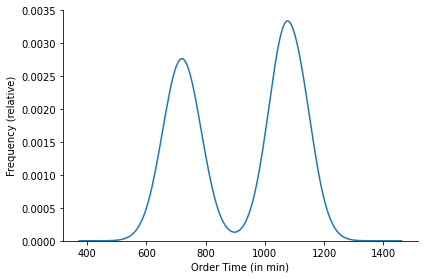

In [8]:
displot(
    data = crafted["order_time"], 
    xlabel = "Order Time (in min)", 
    ylabel = "Frequency (relative)", 
    filepath = "Plots/order_time_dist.png"
)

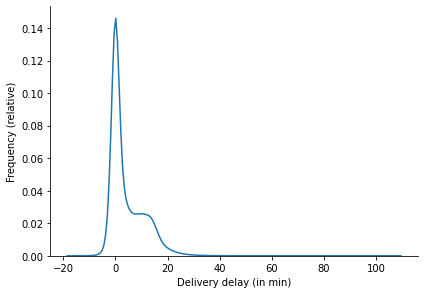

In [9]:
displot(
    data = crafted["atd"]-crafted["etd"],
    xlabel = "Delivery delay (in min)",
    ylabel = "Frequency (relative)",
    filepath = "Plots/delivery_delay.png",
)

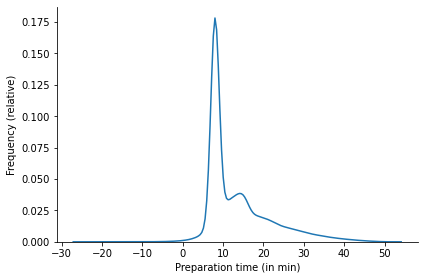

In [10]:
displot(
    data = crafted["restaurant_queue"],
    xlabel = "Preparation time (in min)",
    ylabel = "Frequency (relative)",
    filepath = "Plots/prep_time.png",
)

## Spatial distributions

Idea: Scatterplot x Heatmap?

(23341, 2)


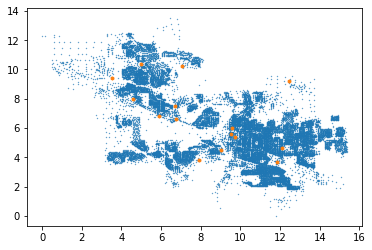

In [11]:
customer_locations = np.asarray(list(set(zip(raw.location_x, raw.location_y))))
customer_locations_x = [t[0] for t in customer_locations]
customer_locations_y = [t[1] for t in customer_locations]

restaurant_locations = list(set(zip(raw.restaurant_location_x, raw.restaurant_location_y)))
restaurant_locations_x = [t[0] for t in restaurant_locations]
restaurant_locations_y = [t[1] for t in restaurant_locations]

print(customer_locations.shape)
plt.scatter(customer_locations_x, customer_locations_y, s=0.1)
plt.scatter(restaurant_locations_x, restaurant_locations_y, s=10, marker="h")
plt.savefig("Plots/spatial_dist.png")

plt.show()

# Study

### Helper functions ###

In [116]:
def plot_convergence(sample_sizes, results, title):
    if title is None:
        pass
    else:
        plt.xlabel("Sample size")
        plt.ylabel("Mean squared error")
        plt.plot(sample_sizes, results)
        plt.savefig(f"Plots/{title}.png")

def best_iteration(evals_result):
    best = evals_result[0]
    for i in evals_result:
        if best > i:
            best = i
    return best 

### Training functions

In [8]:
def nn_train(model, data, params, feature_list=None, rows=None):

    # Set the seed for reproducability
    torch.manual_seed(0)
    np.random.seed(0)
    random.seed(0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print("Importing data.")

    etd_dataset = ETDData(data=data, objective=model.mode) #TODO: change to model.mode
    split = DataSplit(etd_dataset, shuffle=True, rows=rows)
    trainloader, _, testloader = split.get_split(batch_size=params["batch_size"], num_workers=8)

    print("Start training.")
    patience = params["patience"]
    criterion = params["criterion"]  
    optimizer = params["optimizer"]

    early_stopping = EarlyStopping(patience=params["patience"], verbose=True) 
    epochs = params["epochs"]

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            # get the inputs; data is a list of [inputs, labels]
            inputs = inputs.float().to(device)
            labels = labels.float().view(-1, model.view).to(device) 
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels) 
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
        test_loss = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs = inputs.float().to(device)
                labels = labels.float().view(-1, model.view).to(device) 
                logps = model.forward(inputs)
                batch_loss = criterion(logps, labels)
                test_loss += batch_loss.item()
        print(f"Epoch {epoch+1}/{epochs}.. "
                f"Train loss: {running_loss / len(trainloader):.3f}.. "
                f"Test loss: {test_loss / len(testloader):.3f}.. ")
        early_stopping(test_loss / len(testloader), model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        model.train()

    print('Finished Training')
    model.load_state_dict(torch.load('checkpoint.pt'))
    model.save(model, 'perceptron.pth')
    return model, abs(early_stopping.best_score)

## Part 1:  Sample size testing

With the first part, we seek to examine the convergence behavior of our models and answer following question: How many samples are enough to train the model without ? 
We determine the answer to that question graphically. For that, we construct plots where the x-axis represents the number of samples used in the corresponding training instance, and the y-axis represents the corresponding L<sub>2</sub>-loss measured with the mean squared error.

### Test 1.1: Tree-based ensembles: GBDT and RF (LightGBM Implementation)

In [63]:
### Convergence Test for LightGBM's GBDT ###
def sample_size_ensembles(X, y, params, title, start=2000, stop=202000, step=2000):
    
    sample_sizes = np.arange(start=start, stop=stop, step=step)
    results = []
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8, random_state=42)
    
    for rows in sample_sizes:
        train_set = lgb.Dataset(X_train[:rows],y_train[:rows])
        val_set = lgb.Dataset(X_test, y_test)
        evals_result = {}
        bst = lgb.train(
            params,
            train_set=train_set,
            valid_sets=[val_set, train_set],
            valid_names=["Validation error", "Train error"],
            verbose_eval=5,
            evals_result = evals_result,
        )
        best_mse = best_iteration(evals_result["Validation error"]["l2"])
        results.append(best_mse)
    plot_convergence(sample_sizes, results, title)

In [71]:
params_gbdt = {
    "boosting_type" : "gbdt",
    "metrics" : "l2",
    "learning_rate" : 0.02, 
    "num_threads"  : 6,
    "random_state" : 42,
    "force_row_wise" : True,
    "n_estimators" : 1000,
    "early_stopping_rounds" : 20,
}

params_rf = {
    "boosting_type" : "rf",
    "learning_rate" : 1,
    "num_leaves" : 1000,
    "metrics" : "l2",
    "n_estimators" : 1000,
    "bagging_fraction" : 0.8,
    "bagging_freq" : 1,
    "feature_fraction" : 0.8,
    "num_threads"  : 6,
    "random_state" : 42,
    "force_row_wise" : True,
    "early_stopping" : 20,
    "min_data_in_bin" : 1,
    "min_data_in_leaf": 1,
}

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Total Bins 8215
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 81
[LightGBM] [Info] Start training from score 4.151500
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 37.6452	Validation error's l2: 38.9745
[10]	Train error's l2: 35.407	Validation error's l2: 37.6547
[15]	Train error's l2: 33.3757	Validation error's l2: 36.5077
[20]	Train error's l2: 31.491	Validation error's l2: 35.5088
[25]	Train error's l2: 29.8714	Validation error's l2: 34.7452
[30]	Train error's l2: 28.4434	Validation error's l2: 34.0658
[35]	Train error's l2: 27.1692	Validation error's l2: 33.5142
[40]	Train error's l2: 25.9415	Validation error's l2: 33.0014
[45]	Train error's l2: 24.8322	Validation error's l2: 32.575
[50]	Train error's l2: 23.8537	Validation error's l2: 32.2513
[55]	Train error's l2: 22.9931	Validation error's l2: 32.0075
[60]	Train error's l2: 22.1193	Validation error's l2: 31.7442
[65]	Train error's l

[235]	Train error's l2: 18.1658	Validation error's l2: 28.5417
[240]	Train error's l2: 18.0092	Validation error's l2: 28.5407
[245]	Train error's l2: 17.8615	Validation error's l2: 28.5449
[250]	Train error's l2: 17.7048	Validation error's l2: 28.5445
[255]	Train error's l2: 17.5531	Validation error's l2: 28.5467
Early stopping, best iteration is:
[239]	Train error's l2: 18.0374	Validation error's l2: 28.5401
[LightGBM] [Info] Total Bins 9780
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 85
[LightGBM] [Info] Start training from score 4.185375
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.4494	Validation error's l2: 38.692
[10]	Train error's l2: 37.563	Validation error's l2: 37.0974
[15]	Train error's l2: 35.9731	Validation error's l2: 35.791
[20]	Train error's l2: 34.6418	Validation error's l2: 34.739
[25]	Train error's l2: 33.5039	Validation error's l2: 33.8874
[30]	Train error's l2: 32.4968	Validation 

[305]	Train error's l2: 19.2466	Validation error's l2: 28.0874
[310]	Train error's l2: 19.139	Validation error's l2: 28.0862
[315]	Train error's l2: 19.0385	Validation error's l2: 28.0815
[320]	Train error's l2: 18.9375	Validation error's l2: 28.0747
[325]	Train error's l2: 18.8411	Validation error's l2: 28.0727
[330]	Train error's l2: 18.7526	Validation error's l2: 28.07
[335]	Train error's l2: 18.6646	Validation error's l2: 28.0704
[340]	Train error's l2: 18.5713	Validation error's l2: 28.0738
[345]	Train error's l2: 18.4853	Validation error's l2: 28.0733
[350]	Train error's l2: 18.4	Validation error's l2: 28.073
Early stopping, best iteration is:
[334]	Train error's l2: 18.6826	Validation error's l2: 28.0697
[LightGBM] [Info] Total Bins 10119
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 89
[LightGBM] [Info] Start training from score 4.212833
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.1534	Validat

[175]	Train error's l2: 23.7611	Validation error's l2: 28.0763
[180]	Train error's l2: 23.6238	Validation error's l2: 28.0563
[185]	Train error's l2: 23.4894	Validation error's l2: 28.0418
[190]	Train error's l2: 23.3602	Validation error's l2: 28.0246
[195]	Train error's l2: 23.2307	Validation error's l2: 28.0104
[200]	Train error's l2: 23.1028	Validation error's l2: 27.9978
[205]	Train error's l2: 22.9809	Validation error's l2: 27.988
[210]	Train error's l2: 22.862	Validation error's l2: 27.9727
[215]	Train error's l2: 22.7485	Validation error's l2: 27.9613
[220]	Train error's l2: 22.6324	Validation error's l2: 27.9546
[225]	Train error's l2: 22.5256	Validation error's l2: 27.946
[230]	Train error's l2: 22.4173	Validation error's l2: 27.939
[235]	Train error's l2: 22.3204	Validation error's l2: 27.9319
[240]	Train error's l2: 22.216	Validation error's l2: 27.9207
[245]	Train error's l2: 22.1153	Validation error's l2: 27.9136
[250]	Train error's l2: 22.0156	Validation error's l2: 27.90

[340]	Train error's l2: 20.9082	Validation error's l2: 27.6979
[345]	Train error's l2: 20.8432	Validation error's l2: 27.6963
[350]	Train error's l2: 20.7698	Validation error's l2: 27.6958
[355]	Train error's l2: 20.6948	Validation error's l2: 27.6879
[360]	Train error's l2: 20.6267	Validation error's l2: 27.6865
[365]	Train error's l2: 20.559	Validation error's l2: 27.6815
[370]	Train error's l2: 20.4906	Validation error's l2: 27.6767
[375]	Train error's l2: 20.4237	Validation error's l2: 27.6761
[380]	Train error's l2: 20.3555	Validation error's l2: 27.6711
[385]	Train error's l2: 20.2868	Validation error's l2: 27.6702
[390]	Train error's l2: 20.2193	Validation error's l2: 27.6707
[395]	Train error's l2: 20.1551	Validation error's l2: 27.6671
[400]	Train error's l2: 20.0866	Validation error's l2: 27.668
[405]	Train error's l2: 20.0213	Validation error's l2: 27.6696
[410]	Train error's l2: 19.9464	Validation error's l2: 27.6705
[415]	Train error's l2: 19.8815	Validation error's l2: 27

[30]	Train error's l2: 32.3648	Validation error's l2: 33.0991
[35]	Train error's l2: 31.6301	Validation error's l2: 32.4623
[40]	Train error's l2: 30.9823	Validation error's l2: 31.9083
[45]	Train error's l2: 30.4171	Validation error's l2: 31.443
[50]	Train error's l2: 29.9018	Validation error's l2: 31.0326
[55]	Train error's l2: 29.442	Validation error's l2: 30.6617
[60]	Train error's l2: 29.0308	Validation error's l2: 30.3384
[65]	Train error's l2: 28.6619	Validation error's l2: 30.064
[70]	Train error's l2: 28.325	Validation error's l2: 29.8142
[75]	Train error's l2: 28.0265	Validation error's l2: 29.6072
[80]	Train error's l2: 27.7636	Validation error's l2: 29.4293
[85]	Train error's l2: 27.4982	Validation error's l2: 29.2583
[90]	Train error's l2: 27.2506	Validation error's l2: 29.1062
[95]	Train error's l2: 27.0337	Validation error's l2: 28.9803
[100]	Train error's l2: 26.8165	Validation error's l2: 28.8556
[105]	Train error's l2: 26.6009	Validation error's l2: 28.7439
[110]	Trai

[245]	Train error's l2: 23.4094	Validation error's l2: 27.5143
[250]	Train error's l2: 23.3308	Validation error's l2: 27.5024
[255]	Train error's l2: 23.2528	Validation error's l2: 27.4903
[260]	Train error's l2: 23.1768	Validation error's l2: 27.477
[265]	Train error's l2: 23.0965	Validation error's l2: 27.4662
[270]	Train error's l2: 23.0242	Validation error's l2: 27.4517
[275]	Train error's l2: 22.9492	Validation error's l2: 27.4402
[280]	Train error's l2: 22.8699	Validation error's l2: 27.4325
[285]	Train error's l2: 22.7996	Validation error's l2: 27.4261
[290]	Train error's l2: 22.7271	Validation error's l2: 27.4184
[295]	Train error's l2: 22.6558	Validation error's l2: 27.4107
[300]	Train error's l2: 22.5861	Validation error's l2: 27.4036
[305]	Train error's l2: 22.5153	Validation error's l2: 27.3982
[310]	Train error's l2: 22.4528	Validation error's l2: 27.3916
[315]	Train error's l2: 22.3885	Validation error's l2: 27.3869
[320]	Train error's l2: 22.3178	Validation error's l2: 2

[375]	Train error's l2: 22.196	Validation error's l2: 27.3377
[380]	Train error's l2: 22.1402	Validation error's l2: 27.3333
[385]	Train error's l2: 22.0825	Validation error's l2: 27.3302
[390]	Train error's l2: 22.0303	Validation error's l2: 27.3294
[395]	Train error's l2: 21.9749	Validation error's l2: 27.3267
[400]	Train error's l2: 21.9254	Validation error's l2: 27.3269
[405]	Train error's l2: 21.8757	Validation error's l2: 27.3236
[410]	Train error's l2: 21.8177	Validation error's l2: 27.322
[415]	Train error's l2: 21.755	Validation error's l2: 27.3182
[420]	Train error's l2: 21.7001	Validation error's l2: 27.3142
[425]	Train error's l2: 21.6495	Validation error's l2: 27.3129
[430]	Train error's l2: 21.5968	Validation error's l2: 27.312
[435]	Train error's l2: 21.5428	Validation error's l2: 27.3078
[440]	Train error's l2: 21.4866	Validation error's l2: 27.3074
[445]	Train error's l2: 21.433	Validation error's l2: 27.3034
[450]	Train error's l2: 21.3817	Validation error's l2: 27.30

[540]	Train error's l2: 20.8789	Validation error's l2: 27.2187
[545]	Train error's l2: 20.8359	Validation error's l2: 27.2174
[550]	Train error's l2: 20.7905	Validation error's l2: 27.2174
[555]	Train error's l2: 20.7434	Validation error's l2: 27.2139
[560]	Train error's l2: 20.7013	Validation error's l2: 27.2132
[565]	Train error's l2: 20.6597	Validation error's l2: 27.2125
[570]	Train error's l2: 20.6139	Validation error's l2: 27.21
[575]	Train error's l2: 20.571	Validation error's l2: 27.2055
[580]	Train error's l2: 20.5264	Validation error's l2: 27.206
[585]	Train error's l2: 20.4831	Validation error's l2: 27.2032
[590]	Train error's l2: 20.4469	Validation error's l2: 27.2034
[595]	Train error's l2: 20.4101	Validation error's l2: 27.2051
[600]	Train error's l2: 20.3717	Validation error's l2: 27.2063
[605]	Train error's l2: 20.3263	Validation error's l2: 27.207
Early stopping, best iteration is:
[589]	Train error's l2: 20.4538	Validation error's l2: 27.2028
[LightGBM] [Info] Total B

[30]	Train error's l2: 32.8648	Validation error's l2: 33.0065
[35]	Train error's l2: 32.123	Validation error's l2: 32.3505
[40]	Train error's l2: 31.4852	Validation error's l2: 31.8053
[45]	Train error's l2: 30.9182	Validation error's l2: 31.3063
[50]	Train error's l2: 30.4478	Validation error's l2: 30.9163
[55]	Train error's l2: 30.0257	Validation error's l2: 30.5654
[60]	Train error's l2: 29.648	Validation error's l2: 30.2576
[65]	Train error's l2: 29.337	Validation error's l2: 30.0189
[70]	Train error's l2: 29.0338	Validation error's l2: 29.7804
[75]	Train error's l2: 28.7633	Validation error's l2: 29.579
[80]	Train error's l2: 28.5132	Validation error's l2: 29.3961
[85]	Train error's l2: 28.2744	Validation error's l2: 29.2229
[90]	Train error's l2: 28.0378	Validation error's l2: 29.0514
[95]	Train error's l2: 27.8278	Validation error's l2: 28.8997
[100]	Train error's l2: 27.6307	Validation error's l2: 28.7679
[105]	Train error's l2: 27.4399	Validation error's l2: 28.6404
[110]	Trai

[130]	Train error's l2: 26.7904	Validation error's l2: 28.1489
[135]	Train error's l2: 26.6538	Validation error's l2: 28.0727
[140]	Train error's l2: 26.5283	Validation error's l2: 28.004
[145]	Train error's l2: 26.4062	Validation error's l2: 27.939
[150]	Train error's l2: 26.2864	Validation error's l2: 27.8832
[155]	Train error's l2: 26.1766	Validation error's l2: 27.8333
[160]	Train error's l2: 26.0708	Validation error's l2: 27.7851
[165]	Train error's l2: 25.9686	Validation error's l2: 27.7402
[170]	Train error's l2: 25.8731	Validation error's l2: 27.7005
[175]	Train error's l2: 25.7781	Validation error's l2: 27.6679
[180]	Train error's l2: 25.6883	Validation error's l2: 27.635
[185]	Train error's l2: 25.6018	Validation error's l2: 27.6007
[190]	Train error's l2: 25.5146	Validation error's l2: 27.5683
[195]	Train error's l2: 25.4323	Validation error's l2: 27.5404
[200]	Train error's l2: 25.3485	Validation error's l2: 27.5113
[205]	Train error's l2: 25.2656	Validation error's l2: 27.

[85]	Train error's l2: 28.4346	Validation error's l2: 29.1935
[90]	Train error's l2: 28.227	Validation error's l2: 29.0408
[95]	Train error's l2: 28.0363	Validation error's l2: 28.9087
[100]	Train error's l2: 27.8444	Validation error's l2: 28.7716
[105]	Train error's l2: 27.6596	Validation error's l2: 28.6417
[110]	Train error's l2: 27.4879	Validation error's l2: 28.5268
[115]	Train error's l2: 27.3291	Validation error's l2: 28.4224
[120]	Train error's l2: 27.1774	Validation error's l2: 28.3198
[125]	Train error's l2: 27.0304	Validation error's l2: 28.2273
[130]	Train error's l2: 26.8887	Validation error's l2: 28.1403
[135]	Train error's l2: 26.7541	Validation error's l2: 28.0535
[140]	Train error's l2: 26.6212	Validation error's l2: 27.9818
[145]	Train error's l2: 26.4998	Validation error's l2: 27.9204
[150]	Train error's l2: 26.3851	Validation error's l2: 27.8577
[155]	Train error's l2: 26.2776	Validation error's l2: 27.8106
[160]	Train error's l2: 26.1751	Validation error's l2: 27.7

[750]	Train error's l2: 20.5986	Validation error's l2: 26.9746
[755]	Train error's l2: 20.5681	Validation error's l2: 26.9733
[760]	Train error's l2: 20.5377	Validation error's l2: 26.9729
[765]	Train error's l2: 20.4997	Validation error's l2: 26.9699
[770]	Train error's l2: 20.4714	Validation error's l2: 26.9704
[775]	Train error's l2: 20.4366	Validation error's l2: 26.9707
[780]	Train error's l2: 20.4071	Validation error's l2: 26.9711
[785]	Train error's l2: 20.3759	Validation error's l2: 26.9709
Early stopping, best iteration is:
[765]	Train error's l2: 20.4997	Validation error's l2: 26.9699
[LightGBM] [Info] Total Bins 10803
[LightGBM] [Info] Number of data points in the train set: 36000, number of used features: 93
[LightGBM] [Info] Start training from score 4.222194
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.2254	Validation error's l2: 38.715
[10]	Train error's l2: 37.5192	Validation error's l2: 37.1093
[15]	Train error's l2: 36.1046	Val

[615]	Train error's l2: 21.6781	Validation error's l2: 26.9675
[620]	Train error's l2: 21.6461	Validation error's l2: 26.9672
[625]	Train error's l2: 21.6094	Validation error's l2: 26.9679
[630]	Train error's l2: 21.5795	Validation error's l2: 26.969
[635]	Train error's l2: 21.545	Validation error's l2: 26.9684
[640]	Train error's l2: 21.5095	Validation error's l2: 26.969
Early stopping, best iteration is:
[621]	Train error's l2: 21.6389	Validation error's l2: 26.9671
[LightGBM] [Info] Total Bins 10835
[LightGBM] [Info] Number of data points in the train set: 38000, number of used features: 93
[LightGBM] [Info] Start training from score 4.217211
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.2377	Validation error's l2: 38.715
[10]	Train error's l2: 37.5324	Validation error's l2: 37.1091
[15]	Train error's l2: 36.1121	Validation error's l2: 35.7763
[20]	Train error's l2: 34.9258	Validation error's l2: 34.6754
[25]	Train error's l2: 33.9318	Validati

[30]	Train error's l2: 32.9231	Validation error's l2: 33.0016
[35]	Train error's l2: 32.2177	Validation error's l2: 32.3653
[40]	Train error's l2: 31.6147	Validation error's l2: 31.8258
[45]	Train error's l2: 31.0905	Validation error's l2: 31.3687
[50]	Train error's l2: 30.6127	Validation error's l2: 30.9509
[55]	Train error's l2: 30.1779	Validation error's l2: 30.5668
[60]	Train error's l2: 29.7966	Validation error's l2: 30.2375
[65]	Train error's l2: 29.4843	Validation error's l2: 29.9857
[70]	Train error's l2: 29.178	Validation error's l2: 29.7355
[75]	Train error's l2: 28.9129	Validation error's l2: 29.529
[80]	Train error's l2: 28.675	Validation error's l2: 29.3504
[85]	Train error's l2: 28.4656	Validation error's l2: 29.188
[90]	Train error's l2: 28.2593	Validation error's l2: 29.0267
[95]	Train error's l2: 28.0694	Validation error's l2: 28.8841
[100]	Train error's l2: 27.8973	Validation error's l2: 28.7579
[105]	Train error's l2: 27.7221	Validation error's l2: 28.6302
[110]	Trai

[685]	Train error's l2: 21.569	Validation error's l2: 26.9059
[690]	Train error's l2: 21.5361	Validation error's l2: 26.906
[695]	Train error's l2: 21.5043	Validation error's l2: 26.9061
[700]	Train error's l2: 21.4781	Validation error's l2: 26.9062
Early stopping, best iteration is:
[681]	Train error's l2: 21.5888	Validation error's l2: 26.9051
[LightGBM] [Info] Total Bins 10895
[LightGBM] [Info] Number of data points in the train set: 42000, number of used features: 93
[LightGBM] [Info] Start training from score 4.210381
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.1747	Validation error's l2: 38.7176
[10]	Train error's l2: 37.4807	Validation error's l2: 37.1087
[15]	Train error's l2: 36.0803	Validation error's l2: 35.7879
[20]	Train error's l2: 34.9091	Validation error's l2: 34.6898
[25]	Train error's l2: 33.9237	Validation error's l2: 33.7755
[30]	Train error's l2: 33.092	Validation error's l2: 33.0101
[35]	Train error's l2: 32.3867	Validatio

[630]	Train error's l2: 22.1565	Validation error's l2: 26.8518
[635]	Train error's l2: 22.1234	Validation error's l2: 26.8522
[640]	Train error's l2: 22.093	Validation error's l2: 26.8521
[645]	Train error's l2: 22.0637	Validation error's l2: 26.8527
[650]	Train error's l2: 22.0311	Validation error's l2: 26.8523
[655]	Train error's l2: 21.9961	Validation error's l2: 26.8514
[660]	Train error's l2: 21.9665	Validation error's l2: 26.8503
[665]	Train error's l2: 21.9315	Validation error's l2: 26.8503
[670]	Train error's l2: 21.9021	Validation error's l2: 26.8501
[675]	Train error's l2: 21.8695	Validation error's l2: 26.8485
[680]	Train error's l2: 21.8414	Validation error's l2: 26.848
[685]	Train error's l2: 21.8137	Validation error's l2: 26.8483
[690]	Train error's l2: 21.783	Validation error's l2: 26.8477
[695]	Train error's l2: 21.7529	Validation error's l2: 26.8471
[700]	Train error's l2: 21.7198	Validation error's l2: 26.8448
[705]	Train error's l2: 21.6924	Validation error's l2: 26.

[515]	Train error's l2: 22.9863	Validation error's l2: 26.8701
[520]	Train error's l2: 22.9562	Validation error's l2: 26.8684
[525]	Train error's l2: 22.9197	Validation error's l2: 26.8673
[530]	Train error's l2: 22.8819	Validation error's l2: 26.8633
[535]	Train error's l2: 22.8486	Validation error's l2: 26.8617
[540]	Train error's l2: 22.8152	Validation error's l2: 26.863
[545]	Train error's l2: 22.78	Validation error's l2: 26.8611
[550]	Train error's l2: 22.7505	Validation error's l2: 26.8607
[555]	Train error's l2: 22.7186	Validation error's l2: 26.861
[560]	Train error's l2: 22.6855	Validation error's l2: 26.8582
[565]	Train error's l2: 22.6526	Validation error's l2: 26.8565
[570]	Train error's l2: 22.6202	Validation error's l2: 26.8561
[575]	Train error's l2: 22.5886	Validation error's l2: 26.8526
[580]	Train error's l2: 22.5609	Validation error's l2: 26.851
[585]	Train error's l2: 22.527	Validation error's l2: 26.8489
[590]	Train error's l2: 22.4908	Validation error's l2: 26.847

[370]	Train error's l2: 24.1815	Validation error's l2: 26.9701
[375]	Train error's l2: 24.1414	Validation error's l2: 26.9664
[380]	Train error's l2: 24.1038	Validation error's l2: 26.9616
[385]	Train error's l2: 24.0627	Validation error's l2: 26.9571
[390]	Train error's l2: 24.0244	Validation error's l2: 26.9545
[395]	Train error's l2: 23.9833	Validation error's l2: 26.9457
[400]	Train error's l2: 23.9464	Validation error's l2: 26.9426
[405]	Train error's l2: 23.9102	Validation error's l2: 26.9387
[410]	Train error's l2: 23.8685	Validation error's l2: 26.9317
[415]	Train error's l2: 23.8302	Validation error's l2: 26.9253
[420]	Train error's l2: 23.7931	Validation error's l2: 26.9208
[425]	Train error's l2: 23.7566	Validation error's l2: 26.9152
[430]	Train error's l2: 23.7227	Validation error's l2: 26.9117
[435]	Train error's l2: 23.6871	Validation error's l2: 26.9087
[440]	Train error's l2: 23.6486	Validation error's l2: 26.9074
[445]	Train error's l2: 23.6128	Validation error's l2: 

[225]	Train error's l2: 25.6218	Validation error's l2: 27.2818
[230]	Train error's l2: 25.554	Validation error's l2: 27.2534
[235]	Train error's l2: 25.49	Validation error's l2: 27.2293
[240]	Train error's l2: 25.4312	Validation error's l2: 27.2062
[245]	Train error's l2: 25.3737	Validation error's l2: 27.1895
[250]	Train error's l2: 25.3187	Validation error's l2: 27.1727
[255]	Train error's l2: 25.2639	Validation error's l2: 27.1539
[260]	Train error's l2: 25.207	Validation error's l2: 27.1356
[265]	Train error's l2: 25.1555	Validation error's l2: 27.1255
[270]	Train error's l2: 25.1046	Validation error's l2: 27.112
[275]	Train error's l2: 25.0515	Validation error's l2: 27.0978
[280]	Train error's l2: 25.0058	Validation error's l2: 27.0883
[285]	Train error's l2: 24.9565	Validation error's l2: 27.0781
[290]	Train error's l2: 24.9076	Validation error's l2: 27.0623
[295]	Train error's l2: 24.855	Validation error's l2: 27.0464
[300]	Train error's l2: 24.8073	Validation error's l2: 27.036

[115]	Train error's l2: 27.6682	Validation error's l2: 28.433
[120]	Train error's l2: 27.5408	Validation error's l2: 28.343
[125]	Train error's l2: 27.4124	Validation error's l2: 28.2485
[130]	Train error's l2: 27.2748	Validation error's l2: 28.1581
[135]	Train error's l2: 27.1548	Validation error's l2: 28.0745
[140]	Train error's l2: 27.0376	Validation error's l2: 27.9962
[145]	Train error's l2: 26.9276	Validation error's l2: 27.929
[150]	Train error's l2: 26.8236	Validation error's l2: 27.8658
[155]	Train error's l2: 26.7282	Validation error's l2: 27.8167
[160]	Train error's l2: 26.6349	Validation error's l2: 27.7632
[165]	Train error's l2: 26.5507	Validation error's l2: 27.7171
[170]	Train error's l2: 26.4687	Validation error's l2: 27.6812
[175]	Train error's l2: 26.3864	Validation error's l2: 27.6389
[180]	Train error's l2: 26.3059	Validation error's l2: 27.5935
[185]	Train error's l2: 26.2312	Validation error's l2: 27.5565
[190]	Train error's l2: 26.1599	Validation error's l2: 27.

[795]	Train error's l2: 21.739	Validation error's l2: 26.7772
[800]	Train error's l2: 21.7135	Validation error's l2: 26.7772
[805]	Train error's l2: 21.6902	Validation error's l2: 26.7769
[810]	Train error's l2: 21.6658	Validation error's l2: 26.7764
[815]	Train error's l2: 21.6409	Validation error's l2: 26.7773
[820]	Train error's l2: 21.6121	Validation error's l2: 26.7751
[825]	Train error's l2: 21.5858	Validation error's l2: 26.775
[830]	Train error's l2: 21.5595	Validation error's l2: 26.7736
[835]	Train error's l2: 21.5399	Validation error's l2: 26.7734
[840]	Train error's l2: 21.5097	Validation error's l2: 26.7695
[845]	Train error's l2: 21.4882	Validation error's l2: 26.7683
[850]	Train error's l2: 21.463	Validation error's l2: 26.7674
[855]	Train error's l2: 21.4392	Validation error's l2: 26.7663
[860]	Train error's l2: 21.4129	Validation error's l2: 26.7661
[865]	Train error's l2: 21.3845	Validation error's l2: 26.7633
[870]	Train error's l2: 21.3585	Validation error's l2: 26.

[500]	Train error's l2: 23.4318	Validation error's l2: 26.8365
[505]	Train error's l2: 23.3983	Validation error's l2: 26.8335
[510]	Train error's l2: 23.368	Validation error's l2: 26.8307
[515]	Train error's l2: 23.3369	Validation error's l2: 26.8298
[520]	Train error's l2: 23.3072	Validation error's l2: 26.8281
[525]	Train error's l2: 23.2741	Validation error's l2: 26.8229
[530]	Train error's l2: 23.2466	Validation error's l2: 26.8217
[535]	Train error's l2: 23.2184	Validation error's l2: 26.8198
[540]	Train error's l2: 23.1905	Validation error's l2: 26.819
[545]	Train error's l2: 23.1607	Validation error's l2: 26.818
[550]	Train error's l2: 23.1267	Validation error's l2: 26.813
[555]	Train error's l2: 23.0932	Validation error's l2: 26.8076
[560]	Train error's l2: 23.0651	Validation error's l2: 26.8051
[565]	Train error's l2: 23.0347	Validation error's l2: 26.8016
[570]	Train error's l2: 23.0079	Validation error's l2: 26.8013
[575]	Train error's l2: 22.976	Validation error's l2: 26.79

[345]	Train error's l2: 24.5976	Validation error's l2: 26.9472
[350]	Train error's l2: 24.5596	Validation error's l2: 26.9392
[355]	Train error's l2: 24.5207	Validation error's l2: 26.9334
[360]	Train error's l2: 24.4791	Validation error's l2: 26.9263
[365]	Train error's l2: 24.4435	Validation error's l2: 26.9206
[370]	Train error's l2: 24.4054	Validation error's l2: 26.914
[375]	Train error's l2: 24.3694	Validation error's l2: 26.9096
[380]	Train error's l2: 24.3369	Validation error's l2: 26.9055
[385]	Train error's l2: 24.2976	Validation error's l2: 26.899
[390]	Train error's l2: 24.2604	Validation error's l2: 26.8936
[395]	Train error's l2: 24.2246	Validation error's l2: 26.8906
[400]	Train error's l2: 24.1902	Validation error's l2: 26.8851
[405]	Train error's l2: 24.1555	Validation error's l2: 26.8803
[410]	Train error's l2: 24.1188	Validation error's l2: 26.8741
[415]	Train error's l2: 24.085	Validation error's l2: 26.8703
[420]	Train error's l2: 24.0491	Validation error's l2: 26.

[165]	Train error's l2: 26.5587	Validation error's l2: 27.6814
[170]	Train error's l2: 26.4755	Validation error's l2: 27.6333
[175]	Train error's l2: 26.4007	Validation error's l2: 27.5942
[180]	Train error's l2: 26.3222	Validation error's l2: 27.5521
[185]	Train error's l2: 26.2482	Validation error's l2: 27.5105
[190]	Train error's l2: 26.1775	Validation error's l2: 27.4698
[195]	Train error's l2: 26.1102	Validation error's l2: 27.4372
[200]	Train error's l2: 26.0429	Validation error's l2: 27.4034
[205]	Train error's l2: 25.9782	Validation error's l2: 27.3688
[210]	Train error's l2: 25.914	Validation error's l2: 27.3439
[215]	Train error's l2: 25.848	Validation error's l2: 27.3113
[220]	Train error's l2: 25.7866	Validation error's l2: 27.2858
[225]	Train error's l2: 25.7294	Validation error's l2: 27.262
[230]	Train error's l2: 25.6718	Validation error's l2: 27.238
[235]	Train error's l2: 25.6107	Validation error's l2: 27.2087
[240]	Train error's l2: 25.5583	Validation error's l2: 27.1

[845]	Train error's l2: 21.7945	Validation error's l2: 26.6891
[850]	Train error's l2: 21.7728	Validation error's l2: 26.689
Early stopping, best iteration is:
[832]	Train error's l2: 21.8563	Validation error's l2: 26.6881
[LightGBM] [Info] Total Bins 11013
[LightGBM] [Info] Number of data points in the train set: 58000, number of used features: 93
[LightGBM] [Info] Start training from score 4.197190
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.0669	Validation error's l2: 38.7239
[10]	Train error's l2: 37.3941	Validation error's l2: 37.1218
[15]	Train error's l2: 36.0046	Validation error's l2: 35.796
[20]	Train error's l2: 34.847	Validation error's l2: 34.7019
[25]	Train error's l2: 33.874	Validation error's l2: 33.789
[30]	Train error's l2: 33.0538	Validation error's l2: 33.0264
[35]	Train error's l2: 32.3325	Validation error's l2: 32.3598
[40]	Train error's l2: 31.7118	Validation error's l2: 31.787
[45]	Train error's l2: 31.1812	Validation err

[635]	Train error's l2: 22.9605	Validation error's l2: 26.7345
[640]	Train error's l2: 22.933	Validation error's l2: 26.7319
[645]	Train error's l2: 22.906	Validation error's l2: 26.7293
[650]	Train error's l2: 22.883	Validation error's l2: 26.7284
[655]	Train error's l2: 22.8572	Validation error's l2: 26.7248
[660]	Train error's l2: 22.8293	Validation error's l2: 26.7206
[665]	Train error's l2: 22.8042	Validation error's l2: 26.7209
[670]	Train error's l2: 22.7768	Validation error's l2: 26.7205
[675]	Train error's l2: 22.7496	Validation error's l2: 26.7188
[680]	Train error's l2: 22.7267	Validation error's l2: 26.718
[685]	Train error's l2: 22.7014	Validation error's l2: 26.7146
[690]	Train error's l2: 22.6773	Validation error's l2: 26.7137
[695]	Train error's l2: 22.6516	Validation error's l2: 26.7115
[700]	Train error's l2: 22.6264	Validation error's l2: 26.7102
[705]	Train error's l2: 22.6025	Validation error's l2: 26.7089
[710]	Train error's l2: 22.576	Validation error's l2: 26.70

[430]	Train error's l2: 24.1626	Validation error's l2: 26.8129
[435]	Train error's l2: 24.1299	Validation error's l2: 26.8069
[440]	Train error's l2: 24.0984	Validation error's l2: 26.8053
[445]	Train error's l2: 24.0697	Validation error's l2: 26.8008
[450]	Train error's l2: 24.0408	Validation error's l2: 26.7963
[455]	Train error's l2: 24.0084	Validation error's l2: 26.7931
[460]	Train error's l2: 23.9783	Validation error's l2: 26.7882
[465]	Train error's l2: 23.9492	Validation error's l2: 26.7848
[470]	Train error's l2: 23.9187	Validation error's l2: 26.7819
[475]	Train error's l2: 23.8884	Validation error's l2: 26.7778
[480]	Train error's l2: 23.8578	Validation error's l2: 26.7711
[485]	Train error's l2: 23.8269	Validation error's l2: 26.7647
[490]	Train error's l2: 23.7966	Validation error's l2: 26.7601
[495]	Train error's l2: 23.7667	Validation error's l2: 26.7558
[500]	Train error's l2: 23.74	Validation error's l2: 26.7529
[505]	Train error's l2: 23.7118	Validation error's l2: 26

[245]	Train error's l2: 25.7108	Validation error's l2: 27.1433
[250]	Train error's l2: 25.6549	Validation error's l2: 27.1176
[255]	Train error's l2: 25.6019	Validation error's l2: 27.0991
[260]	Train error's l2: 25.5492	Validation error's l2: 27.0816
[265]	Train error's l2: 25.4987	Validation error's l2: 27.0653
[270]	Train error's l2: 25.4501	Validation error's l2: 27.0497
[275]	Train error's l2: 25.404	Validation error's l2: 27.0365
[280]	Train error's l2: 25.3566	Validation error's l2: 27.0191
[285]	Train error's l2: 25.3118	Validation error's l2: 27.0059
[290]	Train error's l2: 25.2651	Validation error's l2: 26.9927
[295]	Train error's l2: 25.2224	Validation error's l2: 26.9823
[300]	Train error's l2: 25.1801	Validation error's l2: 26.9743
[305]	Train error's l2: 25.1378	Validation error's l2: 26.9601
[310]	Train error's l2: 25.1	Validation error's l2: 26.9507
[315]	Train error's l2: 25.0569	Validation error's l2: 26.9397
[320]	Train error's l2: 25.0232	Validation error's l2: 26.9

[900]	Train error's l2: 21.9469	Validation error's l2: 26.6199
[905]	Train error's l2: 21.9252	Validation error's l2: 26.6201
[910]	Train error's l2: 21.9044	Validation error's l2: 26.6202
[915]	Train error's l2: 21.8822	Validation error's l2: 26.6184
[920]	Train error's l2: 21.8628	Validation error's l2: 26.6183
[925]	Train error's l2: 21.8455	Validation error's l2: 26.6184
[930]	Train error's l2: 21.8215	Validation error's l2: 26.6156
[935]	Train error's l2: 21.7982	Validation error's l2: 26.6153
[940]	Train error's l2: 21.7764	Validation error's l2: 26.6144
[945]	Train error's l2: 21.755	Validation error's l2: 26.613
[950]	Train error's l2: 21.7331	Validation error's l2: 26.6128
[955]	Train error's l2: 21.7133	Validation error's l2: 26.614
[960]	Train error's l2: 21.6895	Validation error's l2: 26.6131
[965]	Train error's l2: 21.6676	Validation error's l2: 26.6103
[970]	Train error's l2: 21.6463	Validation error's l2: 26.6091
[975]	Train error's l2: 21.6272	Validation error's l2: 26.

[560]	Train error's l2: 23.5977	Validation error's l2: 26.6866
[565]	Train error's l2: 23.5699	Validation error's l2: 26.6835
[570]	Train error's l2: 23.5442	Validation error's l2: 26.681
[575]	Train error's l2: 23.5179	Validation error's l2: 26.68
[580]	Train error's l2: 23.4908	Validation error's l2: 26.6759
[585]	Train error's l2: 23.4659	Validation error's l2: 26.6745
[590]	Train error's l2: 23.4423	Validation error's l2: 26.6728
[595]	Train error's l2: 23.4152	Validation error's l2: 26.6691
[600]	Train error's l2: 23.3908	Validation error's l2: 26.6689
[605]	Train error's l2: 23.3681	Validation error's l2: 26.6678
[610]	Train error's l2: 23.3428	Validation error's l2: 26.6672
[615]	Train error's l2: 23.3139	Validation error's l2: 26.6606
[620]	Train error's l2: 23.2919	Validation error's l2: 26.6602
[625]	Train error's l2: 23.2639	Validation error's l2: 26.6566
[630]	Train error's l2: 23.2383	Validation error's l2: 26.657
[635]	Train error's l2: 23.2136	Validation error's l2: 26.6

[205]	Train error's l2: 26.1913	Validation error's l2: 27.3601
[210]	Train error's l2: 26.1308	Validation error's l2: 27.3312
[215]	Train error's l2: 26.0757	Validation error's l2: 27.3078
[220]	Train error's l2: 26.0074	Validation error's l2: 27.2726
[225]	Train error's l2: 25.9475	Validation error's l2: 27.2421
[230]	Train error's l2: 25.8903	Validation error's l2: 27.2162
[235]	Train error's l2: 25.8357	Validation error's l2: 27.1916
[240]	Train error's l2: 25.7828	Validation error's l2: 27.1717
[245]	Train error's l2: 25.7277	Validation error's l2: 27.1486
[250]	Train error's l2: 25.6748	Validation error's l2: 27.1271
[255]	Train error's l2: 25.6248	Validation error's l2: 27.1079
[260]	Train error's l2: 25.5773	Validation error's l2: 27.0918
[265]	Train error's l2: 25.5288	Validation error's l2: 27.0723
[270]	Train error's l2: 25.4804	Validation error's l2: 27.055
[275]	Train error's l2: 25.4343	Validation error's l2: 27.0415
[280]	Train error's l2: 25.3887	Validation error's l2: 2

[885]	Train error's l2: 22.1864	Validation error's l2: 26.62
[890]	Train error's l2: 22.1666	Validation error's l2: 26.6188
[895]	Train error's l2: 22.1469	Validation error's l2: 26.619
[900]	Train error's l2: 22.1272	Validation error's l2: 26.6188
[905]	Train error's l2: 22.1038	Validation error's l2: 26.6179
[910]	Train error's l2: 22.0831	Validation error's l2: 26.6174
[915]	Train error's l2: 22.0632	Validation error's l2: 26.6172
[920]	Train error's l2: 22.0449	Validation error's l2: 26.6171
[925]	Train error's l2: 22.0281	Validation error's l2: 26.6161
[930]	Train error's l2: 22.0093	Validation error's l2: 26.6156
[935]	Train error's l2: 21.9865	Validation error's l2: 26.6127
[940]	Train error's l2: 21.9682	Validation error's l2: 26.6124
[945]	Train error's l2: 21.947	Validation error's l2: 26.6118
[950]	Train error's l2: 21.9275	Validation error's l2: 26.6115
[955]	Train error's l2: 21.9084	Validation error's l2: 26.6106
[960]	Train error's l2: 21.8896	Validation error's l2: 26.6

[525]	Train error's l2: 23.8736	Validation error's l2: 26.6971
[530]	Train error's l2: 23.8501	Validation error's l2: 26.6959
[535]	Train error's l2: 23.8267	Validation error's l2: 26.6934
[540]	Train error's l2: 23.7989	Validation error's l2: 26.6916
[545]	Train error's l2: 23.7749	Validation error's l2: 26.6899
[550]	Train error's l2: 23.7505	Validation error's l2: 26.6887
[555]	Train error's l2: 23.7262	Validation error's l2: 26.6852
[560]	Train error's l2: 23.7024	Validation error's l2: 26.6825
[565]	Train error's l2: 23.6778	Validation error's l2: 26.6806
[570]	Train error's l2: 23.654	Validation error's l2: 26.677
[575]	Train error's l2: 23.6288	Validation error's l2: 26.6731
[580]	Train error's l2: 23.6064	Validation error's l2: 26.6722
[585]	Train error's l2: 23.5837	Validation error's l2: 26.6711
[590]	Train error's l2: 23.5579	Validation error's l2: 26.6699
[595]	Train error's l2: 23.5327	Validation error's l2: 26.6672
[600]	Train error's l2: 23.5077	Validation error's l2: 26

[160]	Train error's l2: 26.8412	Validation error's l2: 27.6943
[165]	Train error's l2: 26.7632	Validation error's l2: 27.6483
[170]	Train error's l2: 26.6876	Validation error's l2: 27.6059
[175]	Train error's l2: 26.6121	Validation error's l2: 27.5629
[180]	Train error's l2: 26.5442	Validation error's l2: 27.5276
[185]	Train error's l2: 26.4761	Validation error's l2: 27.4921
[190]	Train error's l2: 26.4098	Validation error's l2: 27.4549
[195]	Train error's l2: 26.3464	Validation error's l2: 27.424
[200]	Train error's l2: 26.2851	Validation error's l2: 27.3947
[205]	Train error's l2: 26.2233	Validation error's l2: 27.3626
[210]	Train error's l2: 26.1615	Validation error's l2: 27.3338
[215]	Train error's l2: 26.1012	Validation error's l2: 27.3021
[220]	Train error's l2: 26.0455	Validation error's l2: 27.2733
[225]	Train error's l2: 25.9903	Validation error's l2: 27.2461
[230]	Train error's l2: 25.9364	Validation error's l2: 27.2214
[235]	Train error's l2: 25.884	Validation error's l2: 27

[840]	Train error's l2: 22.5123	Validation error's l2: 26.583
[845]	Train error's l2: 22.4914	Validation error's l2: 26.5815
[850]	Train error's l2: 22.4714	Validation error's l2: 26.5804
[855]	Train error's l2: 22.4529	Validation error's l2: 26.5801
[860]	Train error's l2: 22.4332	Validation error's l2: 26.5791
[865]	Train error's l2: 22.4131	Validation error's l2: 26.5788
[870]	Train error's l2: 22.3925	Validation error's l2: 26.5773
[875]	Train error's l2: 22.3731	Validation error's l2: 26.577
[880]	Train error's l2: 22.3537	Validation error's l2: 26.5749
[885]	Train error's l2: 22.3298	Validation error's l2: 26.5731
[890]	Train error's l2: 22.3082	Validation error's l2: 26.5707
[895]	Train error's l2: 22.2892	Validation error's l2: 26.5696
[900]	Train error's l2: 22.2725	Validation error's l2: 26.5705
[905]	Train error's l2: 22.2561	Validation error's l2: 26.569
[910]	Train error's l2: 22.2396	Validation error's l2: 26.5683
[915]	Train error's l2: 22.2198	Validation error's l2: 26.

[480]	Train error's l2: 24.2276	Validation error's l2: 26.703
[485]	Train error's l2: 24.1994	Validation error's l2: 26.6986
[490]	Train error's l2: 24.1764	Validation error's l2: 26.6966
[495]	Train error's l2: 24.1527	Validation error's l2: 26.6945
[500]	Train error's l2: 24.1243	Validation error's l2: 26.6874
[505]	Train error's l2: 24.0997	Validation error's l2: 26.6856
[510]	Train error's l2: 24.0714	Validation error's l2: 26.6829
[515]	Train error's l2: 24.0446	Validation error's l2: 26.6801
[520]	Train error's l2: 24.0199	Validation error's l2: 26.6756
[525]	Train error's l2: 23.9943	Validation error's l2: 26.6712
[530]	Train error's l2: 23.9708	Validation error's l2: 26.6693
[535]	Train error's l2: 23.9464	Validation error's l2: 26.6662
[540]	Train error's l2: 23.9242	Validation error's l2: 26.6645
[545]	Train error's l2: 23.898	Validation error's l2: 26.6621
[550]	Train error's l2: 23.8728	Validation error's l2: 26.6592
[555]	Train error's l2: 23.8485	Validation error's l2: 26

[265]	Train error's l2: 25.6442	Validation error's l2: 27.031
[270]	Train error's l2: 25.5987	Validation error's l2: 27.0128
[275]	Train error's l2: 25.5549	Validation error's l2: 26.9941
[280]	Train error's l2: 25.5113	Validation error's l2: 26.9799
[285]	Train error's l2: 25.4741	Validation error's l2: 26.9686
[290]	Train error's l2: 25.43	Validation error's l2: 26.9496
[295]	Train error's l2: 25.3891	Validation error's l2: 26.9366
[300]	Train error's l2: 25.3473	Validation error's l2: 26.9203
[305]	Train error's l2: 25.3091	Validation error's l2: 26.9089
[310]	Train error's l2: 25.2701	Validation error's l2: 26.8967
[315]	Train error's l2: 25.2335	Validation error's l2: 26.8832
[320]	Train error's l2: 25.192	Validation error's l2: 26.8685
[325]	Train error's l2: 25.1529	Validation error's l2: 26.856
[330]	Train error's l2: 25.1147	Validation error's l2: 26.8452
[335]	Train error's l2: 25.0785	Validation error's l2: 26.8328
[340]	Train error's l2: 25.043	Validation error's l2: 26.820

[945]	Train error's l2: 22.2666	Validation error's l2: 26.5274
[950]	Train error's l2: 22.2507	Validation error's l2: 26.5267
[955]	Train error's l2: 22.2344	Validation error's l2: 26.5264
[960]	Train error's l2: 22.216	Validation error's l2: 26.5255
[965]	Train error's l2: 22.1964	Validation error's l2: 26.5244
[970]	Train error's l2: 22.1785	Validation error's l2: 26.5239
[975]	Train error's l2: 22.1634	Validation error's l2: 26.5242
[980]	Train error's l2: 22.1454	Validation error's l2: 26.5231
[985]	Train error's l2: 22.1283	Validation error's l2: 26.5227
[990]	Train error's l2: 22.1107	Validation error's l2: 26.5224
[995]	Train error's l2: 22.0899	Validation error's l2: 26.5207
[1000]	Train error's l2: 22.0733	Validation error's l2: 26.5209
Did not meet early stopping. Best iteration is:
[1000]	Train error's l2: 22.0733	Validation error's l2: 26.5209
[LightGBM] [Info] Total Bins 11150
[LightGBM] [Info] Number of data points in the train set: 76000, number of used features: 93
[Lig

[580]	Train error's l2: 23.8513	Validation error's l2: 26.5951
[585]	Train error's l2: 23.8272	Validation error's l2: 26.592
[590]	Train error's l2: 23.805	Validation error's l2: 26.5901
[595]	Train error's l2: 23.7826	Validation error's l2: 26.5885
[600]	Train error's l2: 23.7616	Validation error's l2: 26.5881
[605]	Train error's l2: 23.7396	Validation error's l2: 26.5858
[610]	Train error's l2: 23.7151	Validation error's l2: 26.5811
[615]	Train error's l2: 23.694	Validation error's l2: 26.5792
[620]	Train error's l2: 23.6695	Validation error's l2: 26.5755
[625]	Train error's l2: 23.6497	Validation error's l2: 26.5745
[630]	Train error's l2: 23.6303	Validation error's l2: 26.5726
[635]	Train error's l2: 23.6085	Validation error's l2: 26.5715
[640]	Train error's l2: 23.5891	Validation error's l2: 26.5709
[645]	Train error's l2: 23.5678	Validation error's l2: 26.5698
[650]	Train error's l2: 23.5485	Validation error's l2: 26.5689
[655]	Train error's l2: 23.5264	Validation error's l2: 26.

[225]	Train error's l2: 26.1485	Validation error's l2: 27.1924
[230]	Train error's l2: 26.095	Validation error's l2: 27.1627
[235]	Train error's l2: 26.0431	Validation error's l2: 27.1363
[240]	Train error's l2: 25.9958	Validation error's l2: 27.1154
[245]	Train error's l2: 25.9455	Validation error's l2: 27.0874
[250]	Train error's l2: 25.8994	Validation error's l2: 27.0642
[255]	Train error's l2: 25.8519	Validation error's l2: 27.0437
[260]	Train error's l2: 25.8057	Validation error's l2: 27.025
[265]	Train error's l2: 25.7638	Validation error's l2: 27.0085
[270]	Train error's l2: 25.7197	Validation error's l2: 26.9894
[275]	Train error's l2: 25.6772	Validation error's l2: 26.9754
[280]	Train error's l2: 25.6344	Validation error's l2: 26.9561
[285]	Train error's l2: 25.5927	Validation error's l2: 26.9415
[290]	Train error's l2: 25.5498	Validation error's l2: 26.9258
[295]	Train error's l2: 25.5114	Validation error's l2: 26.9136
[300]	Train error's l2: 25.4704	Validation error's l2: 26

[895]	Train error's l2: 22.6834	Validation error's l2: 26.4998
[900]	Train error's l2: 22.6625	Validation error's l2: 26.4987
[905]	Train error's l2: 22.6464	Validation error's l2: 26.5002
[910]	Train error's l2: 22.6303	Validation error's l2: 26.5004
[915]	Train error's l2: 22.6164	Validation error's l2: 26.5012
Early stopping, best iteration is:
[898]	Train error's l2: 22.6707	Validation error's l2: 26.4986
[LightGBM] [Info] Total Bins 11177
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 93
[LightGBM] [Info] Start training from score 4.186475
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.0043	Validation error's l2: 38.7253
[10]	Train error's l2: 37.3677	Validation error's l2: 37.1305
[15]	Train error's l2: 36.0137	Validation error's l2: 35.8186
[20]	Train error's l2: 34.8823	Validation error's l2: 34.7237
[25]	Train error's l2: 33.9328	Validation error's l2: 33.8128
[30]	Train error's l2: 33.1084	Valid

[640]	Train error's l2: 23.708	Validation error's l2: 26.5271
[645]	Train error's l2: 23.6861	Validation error's l2: 26.5244
[650]	Train error's l2: 23.6674	Validation error's l2: 26.5237
[655]	Train error's l2: 23.6486	Validation error's l2: 26.5228
[660]	Train error's l2: 23.6291	Validation error's l2: 26.523
[665]	Train error's l2: 23.6088	Validation error's l2: 26.522
[670]	Train error's l2: 23.5884	Validation error's l2: 26.5209
[675]	Train error's l2: 23.5667	Validation error's l2: 26.5189
[680]	Train error's l2: 23.5443	Validation error's l2: 26.5169
[685]	Train error's l2: 23.525	Validation error's l2: 26.5147
[690]	Train error's l2: 23.5064	Validation error's l2: 26.5127
[695]	Train error's l2: 23.4873	Validation error's l2: 26.5133
[700]	Train error's l2: 23.4671	Validation error's l2: 26.512
[705]	Train error's l2: 23.4467	Validation error's l2: 26.511
[710]	Train error's l2: 23.4279	Validation error's l2: 26.5098
[715]	Train error's l2: 23.4078	Validation error's l2: 26.508

[280]	Train error's l2: 25.6247	Validation error's l2: 26.9484
[285]	Train error's l2: 25.5836	Validation error's l2: 26.9338
[290]	Train error's l2: 25.5457	Validation error's l2: 26.9177
[295]	Train error's l2: 25.5034	Validation error's l2: 26.897
[300]	Train error's l2: 25.4613	Validation error's l2: 26.8794
[305]	Train error's l2: 25.4265	Validation error's l2: 26.8669
[310]	Train error's l2: 25.3874	Validation error's l2: 26.8491
[315]	Train error's l2: 25.35	Validation error's l2: 26.8336
[320]	Train error's l2: 25.3154	Validation error's l2: 26.8231
[325]	Train error's l2: 25.2778	Validation error's l2: 26.8078
[330]	Train error's l2: 25.2457	Validation error's l2: 26.7961
[335]	Train error's l2: 25.2112	Validation error's l2: 26.786
[340]	Train error's l2: 25.1757	Validation error's l2: 26.7728
[345]	Train error's l2: 25.1414	Validation error's l2: 26.7604
[350]	Train error's l2: 25.1107	Validation error's l2: 26.7496
[355]	Train error's l2: 25.0813	Validation error's l2: 26.7

[955]	Train error's l2: 22.5238	Validation error's l2: 26.4505
[960]	Train error's l2: 22.505	Validation error's l2: 26.4499
[965]	Train error's l2: 22.4882	Validation error's l2: 26.4469
[970]	Train error's l2: 22.4689	Validation error's l2: 26.4442
[975]	Train error's l2: 22.4532	Validation error's l2: 26.444
[980]	Train error's l2: 22.4344	Validation error's l2: 26.4422
[985]	Train error's l2: 22.4156	Validation error's l2: 26.4416
[990]	Train error's l2: 22.3992	Validation error's l2: 26.4414
[995]	Train error's l2: 22.383	Validation error's l2: 26.4411
[1000]	Train error's l2: 22.3686	Validation error's l2: 26.4407
Did not meet early stopping. Best iteration is:
[1000]	Train error's l2: 22.3686	Validation error's l2: 26.4407
[LightGBM] [Info] Total Bins 11213
[LightGBM] [Info] Number of data points in the train set: 84000, number of used features: 93
[LightGBM] [Info] Start training from score 4.183595
Training until validation scores don't improve for 20 rounds
[5]	Train error's 

[590]	Train error's l2: 23.9407	Validation error's l2: 26.5176
[595]	Train error's l2: 23.9224	Validation error's l2: 26.5181
[600]	Train error's l2: 23.8992	Validation error's l2: 26.5151
[605]	Train error's l2: 23.8779	Validation error's l2: 26.5137
[610]	Train error's l2: 23.8572	Validation error's l2: 26.5123
[615]	Train error's l2: 23.8379	Validation error's l2: 26.5099
[620]	Train error's l2: 23.8183	Validation error's l2: 26.5085
[625]	Train error's l2: 23.797	Validation error's l2: 26.5063
[630]	Train error's l2: 23.7787	Validation error's l2: 26.5041
[635]	Train error's l2: 23.7555	Validation error's l2: 26.5001
[640]	Train error's l2: 23.7377	Validation error's l2: 26.4992
[645]	Train error's l2: 23.7178	Validation error's l2: 26.4967
[650]	Train error's l2: 23.6962	Validation error's l2: 26.494
[655]	Train error's l2: 23.6756	Validation error's l2: 26.4921
[660]	Train error's l2: 23.6578	Validation error's l2: 26.492
[665]	Train error's l2: 23.6393	Validation error's l2: 26.

[235]	Train error's l2: 26.0677	Validation error's l2: 27.1286
[240]	Train error's l2: 26.019	Validation error's l2: 27.1044
[245]	Train error's l2: 25.9692	Validation error's l2: 27.0806
[250]	Train error's l2: 25.9252	Validation error's l2: 27.0595
[255]	Train error's l2: 25.8804	Validation error's l2: 27.0394
[260]	Train error's l2: 25.833	Validation error's l2: 27.0116
[265]	Train error's l2: 25.7898	Validation error's l2: 26.9948
[270]	Train error's l2: 25.7483	Validation error's l2: 26.9747
[275]	Train error's l2: 25.7052	Validation error's l2: 26.9567
[280]	Train error's l2: 25.6637	Validation error's l2: 26.9378
[285]	Train error's l2: 25.6233	Validation error's l2: 26.9216
[290]	Train error's l2: 25.5871	Validation error's l2: 26.9074
[295]	Train error's l2: 25.5508	Validation error's l2: 26.8931
[300]	Train error's l2: 25.5142	Validation error's l2: 26.8784
[305]	Train error's l2: 25.4759	Validation error's l2: 26.8637
[310]	Train error's l2: 25.4406	Validation error's l2: 26

[LightGBM] [Info] Start training from score 4.180205
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 38.9236	Validation error's l2: 38.7233
[10]	Train error's l2: 37.2989	Validation error's l2: 37.138
[15]	Train error's l2: 35.948	Validation error's l2: 35.8244
[20]	Train error's l2: 34.8206	Validation error's l2: 34.7342
[25]	Train error's l2: 33.8785	Validation error's l2: 33.8264
[30]	Train error's l2: 33.0375	Validation error's l2: 33.0184
[35]	Train error's l2: 32.3358	Validation error's l2: 32.347
[40]	Train error's l2: 31.7419	Validation error's l2: 31.7847
[45]	Train error's l2: 31.2202	Validation error's l2: 31.2937
[50]	Train error's l2: 30.7712	Validation error's l2: 30.8741
[55]	Train error's l2: 30.3678	Validation error's l2: 30.5011
[60]	Train error's l2: 30.0349	Validation error's l2: 30.1946
[65]	Train error's l2: 29.7462	Validation error's l2: 29.9331
[70]	Train error's l2: 29.4791	Validation error's l2: 29.6949
[75]	Train error's l2:

[670]	Train error's l2: 23.7079	Validation error's l2: 26.4816
[675]	Train error's l2: 23.6899	Validation error's l2: 26.4808
[680]	Train error's l2: 23.6725	Validation error's l2: 26.4795
[685]	Train error's l2: 23.6535	Validation error's l2: 26.4782
[690]	Train error's l2: 23.6351	Validation error's l2: 26.4775
[695]	Train error's l2: 23.6179	Validation error's l2: 26.4771
[700]	Train error's l2: 23.6006	Validation error's l2: 26.4755
[705]	Train error's l2: 23.5823	Validation error's l2: 26.4746
[710]	Train error's l2: 23.5659	Validation error's l2: 26.4735
[715]	Train error's l2: 23.5482	Validation error's l2: 26.4732
[720]	Train error's l2: 23.5324	Validation error's l2: 26.4719
[725]	Train error's l2: 23.5141	Validation error's l2: 26.4702
[730]	Train error's l2: 23.4951	Validation error's l2: 26.4673
[735]	Train error's l2: 23.4764	Validation error's l2: 26.4657
[740]	Train error's l2: 23.4604	Validation error's l2: 26.4641
[745]	Train error's l2: 23.4436	Validation error's l2: 

[305]	Train error's l2: 25.4926	Validation error's l2: 26.846
[310]	Train error's l2: 25.4583	Validation error's l2: 26.8324
[315]	Train error's l2: 25.425	Validation error's l2: 26.821
[320]	Train error's l2: 25.3902	Validation error's l2: 26.8063
[325]	Train error's l2: 25.3563	Validation error's l2: 26.7959
[330]	Train error's l2: 25.3227	Validation error's l2: 26.7858
[335]	Train error's l2: 25.2898	Validation error's l2: 26.7719
[340]	Train error's l2: 25.2555	Validation error's l2: 26.7571
[345]	Train error's l2: 25.2233	Validation error's l2: 26.7428
[350]	Train error's l2: 25.1942	Validation error's l2: 26.7324
[355]	Train error's l2: 25.1636	Validation error's l2: 26.7222
[360]	Train error's l2: 25.1333	Validation error's l2: 26.7127
[365]	Train error's l2: 25.1021	Validation error's l2: 26.7023
[370]	Train error's l2: 25.0743	Validation error's l2: 26.695
[375]	Train error's l2: 25.0465	Validation error's l2: 26.6892
[380]	Train error's l2: 25.0155	Validation error's l2: 26.6

[985]	Train error's l2: 22.6162	Validation error's l2: 26.3792
[990]	Train error's l2: 22.5992	Validation error's l2: 26.3774
[995]	Train error's l2: 22.581	Validation error's l2: 26.3765
[1000]	Train error's l2: 22.5634	Validation error's l2: 26.3759
Did not meet early stopping. Best iteration is:
[1000]	Train error's l2: 22.5634	Validation error's l2: 26.3759
[LightGBM] [Info] Total Bins 11274
[LightGBM] [Info] Number of data points in the train set: 92000, number of used features: 93
[LightGBM] [Info] Start training from score 4.183478
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 38.9224	Validation error's l2: 38.7319
[10]	Train error's l2: 37.2944	Validation error's l2: 37.1469
[15]	Train error's l2: 35.9398	Validation error's l2: 35.8263
[20]	Train error's l2: 34.8189	Validation error's l2: 34.7425
[25]	Train error's l2: 33.8697	Validation error's l2: 33.8301
[30]	Train error's l2: 33.0321	Validation error's l2: 33.0243
[35]	Train error's l2: 

[625]	Train error's l2: 23.9143	Validation error's l2: 26.4517
[630]	Train error's l2: 23.8932	Validation error's l2: 26.449
[635]	Train error's l2: 23.877	Validation error's l2: 26.4478
[640]	Train error's l2: 23.8595	Validation error's l2: 26.4463
[645]	Train error's l2: 23.8403	Validation error's l2: 26.4448
[650]	Train error's l2: 23.8201	Validation error's l2: 26.4431
[655]	Train error's l2: 23.8037	Validation error's l2: 26.4421
[660]	Train error's l2: 23.785	Validation error's l2: 26.4407
[665]	Train error's l2: 23.7668	Validation error's l2: 26.4403
[670]	Train error's l2: 23.746	Validation error's l2: 26.437
[675]	Train error's l2: 23.7284	Validation error's l2: 26.436
[680]	Train error's l2: 23.7143	Validation error's l2: 26.4363
[685]	Train error's l2: 23.6949	Validation error's l2: 26.4337
[690]	Train error's l2: 23.6724	Validation error's l2: 26.4303
[695]	Train error's l2: 23.6548	Validation error's l2: 26.4289
[700]	Train error's l2: 23.6365	Validation error's l2: 26.428

[260]	Train error's l2: 25.8725	Validation error's l2: 26.9983
[265]	Train error's l2: 25.8318	Validation error's l2: 26.9783
[270]	Train error's l2: 25.7868	Validation error's l2: 26.955
[275]	Train error's l2: 25.7477	Validation error's l2: 26.9384
[280]	Train error's l2: 25.7035	Validation error's l2: 26.9144
[285]	Train error's l2: 25.6639	Validation error's l2: 26.8961
[290]	Train error's l2: 25.6236	Validation error's l2: 26.8778
[295]	Train error's l2: 25.5884	Validation error's l2: 26.863
[300]	Train error's l2: 25.5499	Validation error's l2: 26.8463
[305]	Train error's l2: 25.5136	Validation error's l2: 26.8311
[310]	Train error's l2: 25.4757	Validation error's l2: 26.8118
[315]	Train error's l2: 25.4418	Validation error's l2: 26.7979
[320]	Train error's l2: 25.4078	Validation error's l2: 26.785
[325]	Train error's l2: 25.3707	Validation error's l2: 26.7695
[330]	Train error's l2: 25.338	Validation error's l2: 26.7579
[335]	Train error's l2: 25.3067	Validation error's l2: 26.7

[925]	Train error's l2: 22.9104	Validation error's l2: 26.3613
[930]	Train error's l2: 22.8939	Validation error's l2: 26.3602
[935]	Train error's l2: 22.8796	Validation error's l2: 26.3594
[940]	Train error's l2: 22.8624	Validation error's l2: 26.3577
[945]	Train error's l2: 22.8479	Validation error's l2: 26.3565
[950]	Train error's l2: 22.8328	Validation error's l2: 26.3556
[955]	Train error's l2: 22.8167	Validation error's l2: 26.354
[960]	Train error's l2: 22.8015	Validation error's l2: 26.3536
[965]	Train error's l2: 22.7846	Validation error's l2: 26.3526
[970]	Train error's l2: 22.7677	Validation error's l2: 26.3519
[975]	Train error's l2: 22.7519	Validation error's l2: 26.3503
[980]	Train error's l2: 22.7372	Validation error's l2: 26.3493
[985]	Train error's l2: 22.7195	Validation error's l2: 26.3488
[990]	Train error's l2: 22.7039	Validation error's l2: 26.3484
[995]	Train error's l2: 22.6876	Validation error's l2: 26.347
[1000]	Train error's l2: 22.6722	Validation error's l2: 2

[575]	Train error's l2: 24.1702	Validation error's l2: 26.485
[580]	Train error's l2: 24.1511	Validation error's l2: 26.4833
[585]	Train error's l2: 24.134	Validation error's l2: 26.4821
[590]	Train error's l2: 24.1156	Validation error's l2: 26.4799
[595]	Train error's l2: 24.0978	Validation error's l2: 26.4779
[600]	Train error's l2: 24.0772	Validation error's l2: 26.4735
[605]	Train error's l2: 24.0578	Validation error's l2: 26.4718
[610]	Train error's l2: 24.0402	Validation error's l2: 26.4697
[615]	Train error's l2: 24.0212	Validation error's l2: 26.4662
[620]	Train error's l2: 24.0008	Validation error's l2: 26.4635
[625]	Train error's l2: 23.9805	Validation error's l2: 26.4595
[630]	Train error's l2: 23.963	Validation error's l2: 26.4572
[635]	Train error's l2: 23.943	Validation error's l2: 26.4545
[640]	Train error's l2: 23.9216	Validation error's l2: 26.4505
[645]	Train error's l2: 23.9053	Validation error's l2: 26.4493
[650]	Train error's l2: 23.8862	Validation error's l2: 26.4

[215]	Train error's l2: 26.3071	Validation error's l2: 27.1885
[220]	Train error's l2: 26.2539	Validation error's l2: 27.1594
[225]	Train error's l2: 26.2012	Validation error's l2: 27.1253
[230]	Train error's l2: 26.1505	Validation error's l2: 27.1001
[235]	Train error's l2: 26.1033	Validation error's l2: 27.0742
[240]	Train error's l2: 26.0574	Validation error's l2: 27.0521
[245]	Train error's l2: 26.0076	Validation error's l2: 27.0245
[250]	Train error's l2: 25.9669	Validation error's l2: 27.0068
[255]	Train error's l2: 25.9228	Validation error's l2: 26.9854
[260]	Train error's l2: 25.881	Validation error's l2: 26.9651
[265]	Train error's l2: 25.8367	Validation error's l2: 26.9435
[270]	Train error's l2: 25.7937	Validation error's l2: 26.9227
[275]	Train error's l2: 25.752	Validation error's l2: 26.9011
[280]	Train error's l2: 25.7111	Validation error's l2: 26.8831
[285]	Train error's l2: 25.6726	Validation error's l2: 26.8633
[290]	Train error's l2: 25.637	Validation error's l2: 26.

[890]	Train error's l2: 23.0688	Validation error's l2: 26.3377
[895]	Train error's l2: 23.0561	Validation error's l2: 26.3374
[900]	Train error's l2: 23.0416	Validation error's l2: 26.3359
[905]	Train error's l2: 23.0273	Validation error's l2: 26.3352
[910]	Train error's l2: 23.01	Validation error's l2: 26.3334
[915]	Train error's l2: 22.9942	Validation error's l2: 26.3313
[920]	Train error's l2: 22.9811	Validation error's l2: 26.3309
[925]	Train error's l2: 22.9626	Validation error's l2: 26.3291
[930]	Train error's l2: 22.9462	Validation error's l2: 26.3297
[935]	Train error's l2: 22.9319	Validation error's l2: 26.3299
[940]	Train error's l2: 22.9173	Validation error's l2: 26.3301
Early stopping, best iteration is:
[923]	Train error's l2: 22.9693	Validation error's l2: 26.3288
[LightGBM] [Info] Total Bins 11319
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation sco

[605]	Train error's l2: 24.1483	Validation error's l2: 26.4143
[610]	Train error's l2: 24.1287	Validation error's l2: 26.4099
[615]	Train error's l2: 24.1107	Validation error's l2: 26.4088
[620]	Train error's l2: 24.0882	Validation error's l2: 26.4023
[625]	Train error's l2: 24.0694	Validation error's l2: 26.4002
[630]	Train error's l2: 24.052	Validation error's l2: 26.397
[635]	Train error's l2: 24.0341	Validation error's l2: 26.3953
[640]	Train error's l2: 24.0142	Validation error's l2: 26.3939
[645]	Train error's l2: 23.9937	Validation error's l2: 26.3895
[650]	Train error's l2: 23.9772	Validation error's l2: 26.3881
[655]	Train error's l2: 23.958	Validation error's l2: 26.3858
[660]	Train error's l2: 23.9418	Validation error's l2: 26.3852
[665]	Train error's l2: 23.9215	Validation error's l2: 26.3829
[670]	Train error's l2: 23.9062	Validation error's l2: 26.3816
[675]	Train error's l2: 23.8875	Validation error's l2: 26.3794
[680]	Train error's l2: 23.8679	Validation error's l2: 26.

[240]	Train error's l2: 26.1539	Validation error's l2: 27.0525
[245]	Train error's l2: 26.1067	Validation error's l2: 27.0296
[250]	Train error's l2: 26.0614	Validation error's l2: 27.0051
[255]	Train error's l2: 26.0198	Validation error's l2: 26.9859
[260]	Train error's l2: 25.9743	Validation error's l2: 26.9589
[265]	Train error's l2: 25.9335	Validation error's l2: 26.9381
[270]	Train error's l2: 25.8922	Validation error's l2: 26.9164
[275]	Train error's l2: 25.8507	Validation error's l2: 26.8916
[280]	Train error's l2: 25.8118	Validation error's l2: 26.8719
[285]	Train error's l2: 25.7746	Validation error's l2: 26.8556
[290]	Train error's l2: 25.7362	Validation error's l2: 26.8344
[295]	Train error's l2: 25.7001	Validation error's l2: 26.8185
[300]	Train error's l2: 25.6654	Validation error's l2: 26.8053
[305]	Train error's l2: 25.6289	Validation error's l2: 26.7889
[310]	Train error's l2: 25.5929	Validation error's l2: 26.7727
[315]	Train error's l2: 25.558	Validation error's l2: 2

[915]	Train error's l2: 23.1455	Validation error's l2: 26.3123
[920]	Train error's l2: 23.1307	Validation error's l2: 26.3104
[925]	Train error's l2: 23.1131	Validation error's l2: 26.3091
[930]	Train error's l2: 23.0997	Validation error's l2: 26.3095
[935]	Train error's l2: 23.086	Validation error's l2: 26.3083
[940]	Train error's l2: 23.0715	Validation error's l2: 26.3082
[945]	Train error's l2: 23.0536	Validation error's l2: 26.3065
[950]	Train error's l2: 23.0395	Validation error's l2: 26.3066
[955]	Train error's l2: 23.0244	Validation error's l2: 26.3048
[960]	Train error's l2: 23.0075	Validation error's l2: 26.3039
[965]	Train error's l2: 22.9944	Validation error's l2: 26.3029
[970]	Train error's l2: 22.9789	Validation error's l2: 26.3021
[975]	Train error's l2: 22.9662	Validation error's l2: 26.3023
[980]	Train error's l2: 22.9493	Validation error's l2: 26.2999
[985]	Train error's l2: 22.9351	Validation error's l2: 26.2998
[990]	Train error's l2: 22.9209	Validation error's l2: 2

[555]	Train error's l2: 24.417	Validation error's l2: 26.4038
[560]	Train error's l2: 24.3987	Validation error's l2: 26.401
[565]	Train error's l2: 24.3799	Validation error's l2: 26.3979
[570]	Train error's l2: 24.361	Validation error's l2: 26.396
[575]	Train error's l2: 24.3422	Validation error's l2: 26.395
[580]	Train error's l2: 24.3248	Validation error's l2: 26.3926
[585]	Train error's l2: 24.3055	Validation error's l2: 26.3909
[590]	Train error's l2: 24.2862	Validation error's l2: 26.3872
[595]	Train error's l2: 24.2686	Validation error's l2: 26.3863
[600]	Train error's l2: 24.2521	Validation error's l2: 26.3859
[605]	Train error's l2: 24.2315	Validation error's l2: 26.3829
[610]	Train error's l2: 24.2152	Validation error's l2: 26.382
[615]	Train error's l2: 24.1969	Validation error's l2: 26.3796
[620]	Train error's l2: 24.1802	Validation error's l2: 26.3784
[625]	Train error's l2: 24.1607	Validation error's l2: 26.3759
[630]	Train error's l2: 24.1441	Validation error's l2: 26.374

[195]	Train error's l2: 26.6557	Validation error's l2: 27.2955
[200]	Train error's l2: 26.5987	Validation error's l2: 27.2573
[205]	Train error's l2: 26.5396	Validation error's l2: 27.2188
[210]	Train error's l2: 26.4845	Validation error's l2: 27.1832
[215]	Train error's l2: 26.4334	Validation error's l2: 27.1532
[220]	Train error's l2: 26.3859	Validation error's l2: 27.125
[225]	Train error's l2: 26.337	Validation error's l2: 27.0968
[230]	Train error's l2: 26.2866	Validation error's l2: 27.0654
[235]	Train error's l2: 26.2376	Validation error's l2: 27.0368
[240]	Train error's l2: 26.1903	Validation error's l2: 27.0103
[245]	Train error's l2: 26.1477	Validation error's l2: 26.9873
[250]	Train error's l2: 26.1066	Validation error's l2: 26.9668
[255]	Train error's l2: 26.0628	Validation error's l2: 26.9414
[260]	Train error's l2: 26.0225	Validation error's l2: 26.9212
[265]	Train error's l2: 25.9822	Validation error's l2: 26.9007
[270]	Train error's l2: 25.9399	Validation error's l2: 26

[855]	Train error's l2: 23.4388	Validation error's l2: 26.2708
[860]	Train error's l2: 23.4237	Validation error's l2: 26.2695
[865]	Train error's l2: 23.4091	Validation error's l2: 26.2674
[870]	Train error's l2: 23.3934	Validation error's l2: 26.2651
[875]	Train error's l2: 23.3769	Validation error's l2: 26.2625
[880]	Train error's l2: 23.3629	Validation error's l2: 26.262
[885]	Train error's l2: 23.3465	Validation error's l2: 26.2604
[890]	Train error's l2: 23.3297	Validation error's l2: 26.2587
[895]	Train error's l2: 23.3168	Validation error's l2: 26.2581
[900]	Train error's l2: 23.3007	Validation error's l2: 26.2562
[905]	Train error's l2: 23.2831	Validation error's l2: 26.2546
[910]	Train error's l2: 23.2702	Validation error's l2: 26.2538
[915]	Train error's l2: 23.2567	Validation error's l2: 26.253
[920]	Train error's l2: 23.2413	Validation error's l2: 26.2507
[925]	Train error's l2: 23.2265	Validation error's l2: 26.2498
[930]	Train error's l2: 23.2131	Validation error's l2: 26

[505]	Train error's l2: 24.6592	Validation error's l2: 26.4159
[510]	Train error's l2: 24.6375	Validation error's l2: 26.4125
[515]	Train error's l2: 24.6172	Validation error's l2: 26.4108
[520]	Train error's l2: 24.5971	Validation error's l2: 26.4074
[525]	Train error's l2: 24.5785	Validation error's l2: 26.4038
[530]	Train error's l2: 24.5555	Validation error's l2: 26.4001
[535]	Train error's l2: 24.5377	Validation error's l2: 26.3982
[540]	Train error's l2: 24.5204	Validation error's l2: 26.3967
[545]	Train error's l2: 24.499	Validation error's l2: 26.3928
[550]	Train error's l2: 24.4801	Validation error's l2: 26.3889
[555]	Train error's l2: 24.4593	Validation error's l2: 26.3839
[560]	Train error's l2: 24.4412	Validation error's l2: 26.3821
[565]	Train error's l2: 24.4226	Validation error's l2: 26.3788
[570]	Train error's l2: 24.4051	Validation error's l2: 26.3773
[575]	Train error's l2: 24.3861	Validation error's l2: 26.3745
[580]	Train error's l2: 24.3658	Validation error's l2: 2

[140]	Train error's l2: 27.4593	Validation error's l2: 27.8507
[145]	Train error's l2: 27.3777	Validation error's l2: 27.7933
[150]	Train error's l2: 27.2855	Validation error's l2: 27.7216
[155]	Train error's l2: 27.2023	Validation error's l2: 27.6621
[160]	Train error's l2: 27.1225	Validation error's l2: 27.6031
[165]	Train error's l2: 27.048	Validation error's l2: 27.5497
[170]	Train error's l2: 26.9788	Validation error's l2: 27.5026
[175]	Train error's l2: 26.9084	Validation error's l2: 27.4519
[180]	Train error's l2: 26.8461	Validation error's l2: 27.4117
[185]	Train error's l2: 26.7817	Validation error's l2: 27.3656
[190]	Train error's l2: 26.7257	Validation error's l2: 27.3293
[195]	Train error's l2: 26.6691	Validation error's l2: 27.2931
[200]	Train error's l2: 26.6092	Validation error's l2: 27.2524
[205]	Train error's l2: 26.5524	Validation error's l2: 27.214
[210]	Train error's l2: 26.4983	Validation error's l2: 27.1774
[215]	Train error's l2: 26.4443	Validation error's l2: 27

[805]	Train error's l2: 23.666	Validation error's l2: 26.2926
[810]	Train error's l2: 23.6525	Validation error's l2: 26.2922
[815]	Train error's l2: 23.6373	Validation error's l2: 26.2914
[820]	Train error's l2: 23.6224	Validation error's l2: 26.2896
[825]	Train error's l2: 23.6086	Validation error's l2: 26.2871
[830]	Train error's l2: 23.5948	Validation error's l2: 26.2865
[835]	Train error's l2: 23.58	Validation error's l2: 26.2854
[840]	Train error's l2: 23.5644	Validation error's l2: 26.283
[845]	Train error's l2: 23.5486	Validation error's l2: 26.2803
[850]	Train error's l2: 23.5323	Validation error's l2: 26.2786
[855]	Train error's l2: 23.5195	Validation error's l2: 26.2785
[860]	Train error's l2: 23.5061	Validation error's l2: 26.2779
[865]	Train error's l2: 23.4934	Validation error's l2: 26.2763
[870]	Train error's l2: 23.4759	Validation error's l2: 26.2728
[875]	Train error's l2: 23.4617	Validation error's l2: 26.271
[880]	Train error's l2: 23.4445	Validation error's l2: 26.26

[450]	Train error's l2: 24.9429	Validation error's l2: 26.4673
[455]	Train error's l2: 24.9238	Validation error's l2: 26.4648
[460]	Train error's l2: 24.9022	Validation error's l2: 26.4621
[465]	Train error's l2: 24.8804	Validation error's l2: 26.4566
[470]	Train error's l2: 24.86	Validation error's l2: 26.4523
[475]	Train error's l2: 24.8372	Validation error's l2: 26.4453
[480]	Train error's l2: 24.8175	Validation error's l2: 26.441
[485]	Train error's l2: 24.796	Validation error's l2: 26.435
[490]	Train error's l2: 24.7782	Validation error's l2: 26.4325
[495]	Train error's l2: 24.756	Validation error's l2: 26.426
[500]	Train error's l2: 24.7352	Validation error's l2: 26.4219
[505]	Train error's l2: 24.7168	Validation error's l2: 26.42
[510]	Train error's l2: 24.6951	Validation error's l2: 26.4147
[515]	Train error's l2: 24.6772	Validation error's l2: 26.4114
[520]	Train error's l2: 24.6595	Validation error's l2: 26.4092
[525]	Train error's l2: 24.6385	Validation error's l2: 26.404
[5

[80]	Train error's l2: 29.0675	Validation error's l2: 29.2232
[85]	Train error's l2: 28.8738	Validation error's l2: 29.0524
[90]	Train error's l2: 28.6902	Validation error's l2: 28.891
[95]	Train error's l2: 28.5223	Validation error's l2: 28.7454
[100]	Train error's l2: 28.3705	Validation error's l2: 28.6198
[105]	Train error's l2: 28.2335	Validation error's l2: 28.5043
[110]	Train error's l2: 28.0977	Validation error's l2: 28.3916
[115]	Train error's l2: 27.9735	Validation error's l2: 28.2894
[120]	Train error's l2: 27.8555	Validation error's l2: 28.1945
[125]	Train error's l2: 27.7433	Validation error's l2: 28.1034
[130]	Train error's l2: 27.6398	Validation error's l2: 28.0211
[135]	Train error's l2: 27.5397	Validation error's l2: 27.9402
[140]	Train error's l2: 27.4434	Validation error's l2: 27.8645
[145]	Train error's l2: 27.3585	Validation error's l2: 27.8034
[150]	Train error's l2: 27.2684	Validation error's l2: 27.7318
[155]	Train error's l2: 27.1814	Validation error's l2: 27.66

[745]	Train error's l2: 23.877	Validation error's l2: 26.3016
[750]	Train error's l2: 23.86	Validation error's l2: 26.2996
[755]	Train error's l2: 23.8468	Validation error's l2: 26.2984
[760]	Train error's l2: 23.8314	Validation error's l2: 26.2976
[765]	Train error's l2: 23.8133	Validation error's l2: 26.2947
[770]	Train error's l2: 23.7995	Validation error's l2: 26.2937
[775]	Train error's l2: 23.7828	Validation error's l2: 26.2907
[780]	Train error's l2: 23.7691	Validation error's l2: 26.2901
[785]	Train error's l2: 23.7543	Validation error's l2: 26.2886
[790]	Train error's l2: 23.7407	Validation error's l2: 26.2873
[795]	Train error's l2: 23.7244	Validation error's l2: 26.2846
[800]	Train error's l2: 23.7094	Validation error's l2: 26.2832
[805]	Train error's l2: 23.6925	Validation error's l2: 26.2799
[810]	Train error's l2: 23.6774	Validation error's l2: 26.2782
[815]	Train error's l2: 23.6632	Validation error's l2: 26.2779
[820]	Train error's l2: 23.6488	Validation error's l2: 26.

[375]	Train error's l2: 25.3061	Validation error's l2: 26.5449
[380]	Train error's l2: 25.2823	Validation error's l2: 26.5382
[385]	Train error's l2: 25.2563	Validation error's l2: 26.5301
[390]	Train error's l2: 25.2298	Validation error's l2: 26.5201
[395]	Train error's l2: 25.2023	Validation error's l2: 26.5133
[400]	Train error's l2: 25.1771	Validation error's l2: 26.5052
[405]	Train error's l2: 25.1519	Validation error's l2: 26.4972
[410]	Train error's l2: 25.1275	Validation error's l2: 26.4903
[415]	Train error's l2: 25.1025	Validation error's l2: 26.4832
[420]	Train error's l2: 25.0797	Validation error's l2: 26.4762
[425]	Train error's l2: 25.0572	Validation error's l2: 26.4707
[430]	Train error's l2: 25.0314	Validation error's l2: 26.462
[435]	Train error's l2: 25.01	Validation error's l2: 26.4566
[440]	Train error's l2: 24.9878	Validation error's l2: 26.4493
[445]	Train error's l2: 24.9645	Validation error's l2: 26.4423
[450]	Train error's l2: 24.9424	Validation error's l2: 26.

[20]	Train error's l2: 34.9136	Validation error's l2: 34.7355
[25]	Train error's l2: 33.9631	Validation error's l2: 33.8145
[30]	Train error's l2: 33.1444	Validation error's l2: 33.0259
[35]	Train error's l2: 32.4338	Validation error's l2: 32.3445
[40]	Train error's l2: 31.8354	Validation error's l2: 31.7745
[45]	Train error's l2: 31.304	Validation error's l2: 31.2712
[50]	Train error's l2: 30.854	Validation error's l2: 30.8464
[55]	Train error's l2: 30.46	Validation error's l2: 30.4776
[60]	Train error's l2: 30.1168	Validation error's l2: 30.1549
[65]	Train error's l2: 29.8262	Validation error's l2: 29.8863
[70]	Train error's l2: 29.5565	Validation error's l2: 29.6376
[75]	Train error's l2: 29.3263	Validation error's l2: 29.4289
[80]	Train error's l2: 29.1119	Validation error's l2: 29.2375
[85]	Train error's l2: 28.9207	Validation error's l2: 29.0688
[90]	Train error's l2: 28.7394	Validation error's l2: 28.9089
[95]	Train error's l2: 28.5686	Validation error's l2: 28.76
[100]	Train er

[675]	Train error's l2: 24.1958	Validation error's l2: 26.3199
[680]	Train error's l2: 24.1793	Validation error's l2: 26.3187
[685]	Train error's l2: 24.1633	Validation error's l2: 26.3169
[690]	Train error's l2: 24.147	Validation error's l2: 26.315
[695]	Train error's l2: 24.1306	Validation error's l2: 26.3136
[700]	Train error's l2: 24.1176	Validation error's l2: 26.3128
[705]	Train error's l2: 24.0979	Validation error's l2: 26.3082
[710]	Train error's l2: 24.0814	Validation error's l2: 26.305
[715]	Train error's l2: 24.0651	Validation error's l2: 26.3021
[720]	Train error's l2: 24.0479	Validation error's l2: 26.2998
[725]	Train error's l2: 24.032	Validation error's l2: 26.2986
[730]	Train error's l2: 24.0132	Validation error's l2: 26.2929
[735]	Train error's l2: 23.9983	Validation error's l2: 26.2919
[740]	Train error's l2: 23.9831	Validation error's l2: 26.291
[745]	Train error's l2: 23.9703	Validation error's l2: 26.2904
[750]	Train error's l2: 23.9534	Validation error's l2: 26.28

[320]	Train error's l2: 25.6585	Validation error's l2: 26.69
[325]	Train error's l2: 25.6301	Validation error's l2: 26.6784
[330]	Train error's l2: 25.5969	Validation error's l2: 26.6618
[335]	Train error's l2: 25.5658	Validation error's l2: 26.6445
[340]	Train error's l2: 25.5338	Validation error's l2: 26.6294
[345]	Train error's l2: 25.506	Validation error's l2: 26.6192
[350]	Train error's l2: 25.479	Validation error's l2: 26.6084
[355]	Train error's l2: 25.4517	Validation error's l2: 26.5962
[360]	Train error's l2: 25.4243	Validation error's l2: 26.5844
[365]	Train error's l2: 25.3995	Validation error's l2: 26.5759
[370]	Train error's l2: 25.3734	Validation error's l2: 26.5624
[375]	Train error's l2: 25.3486	Validation error's l2: 26.5553
[380]	Train error's l2: 25.3245	Validation error's l2: 26.5469
[385]	Train error's l2: 25.2991	Validation error's l2: 26.5368
[390]	Train error's l2: 25.2757	Validation error's l2: 26.5298
[395]	Train error's l2: 25.2506	Validation error's l2: 26.5

[1000]	Train error's l2: 23.2568	Validation error's l2: 26.2177
Did not meet early stopping. Best iteration is:
[1000]	Train error's l2: 23.2568	Validation error's l2: 26.2177
[LightGBM] [Info] Total Bins 11362
[LightGBM] [Info] Number of data points in the train set: 122000, number of used features: 93
[LightGBM] [Info] Start training from score 4.180820
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 38.9247	Validation error's l2: 38.7317
[10]	Train error's l2: 37.3141	Validation error's l2: 37.1538
[15]	Train error's l2: 35.9647	Validation error's l2: 35.8368
[20]	Train error's l2: 34.836	Validation error's l2: 34.738
[25]	Train error's l2: 33.8865	Validation error's l2: 33.8171
[30]	Train error's l2: 33.0849	Validation error's l2: 33.0435
[35]	Train error's l2: 32.3804	Validation error's l2: 32.3662
[40]	Train error's l2: 31.7849	Validation error's l2: 31.7964
[45]	Train error's l2: 31.2708	Validation error's l2: 31.3059
[50]	Train error's l2: 30.

[635]	Train error's l2: 24.3022	Validation error's l2: 26.3049
[640]	Train error's l2: 24.2872	Validation error's l2: 26.3033
[645]	Train error's l2: 24.2731	Validation error's l2: 26.3013
[650]	Train error's l2: 24.2565	Validation error's l2: 26.2981
[655]	Train error's l2: 24.2385	Validation error's l2: 26.2939
[660]	Train error's l2: 24.2227	Validation error's l2: 26.2923
[665]	Train error's l2: 24.2074	Validation error's l2: 26.29
[670]	Train error's l2: 24.1938	Validation error's l2: 26.2891
[675]	Train error's l2: 24.1768	Validation error's l2: 26.2864
[680]	Train error's l2: 24.1617	Validation error's l2: 26.2843
[685]	Train error's l2: 24.1446	Validation error's l2: 26.2816
[690]	Train error's l2: 24.1292	Validation error's l2: 26.2789
[695]	Train error's l2: 24.1137	Validation error's l2: 26.2773
[700]	Train error's l2: 24.0986	Validation error's l2: 26.2753
[705]	Train error's l2: 24.0836	Validation error's l2: 26.2735
[710]	Train error's l2: 24.0693	Validation error's l2: 26

[275]	Train error's l2: 25.9149	Validation error's l2: 26.8481
[280]	Train error's l2: 25.8802	Validation error's l2: 26.8308
[285]	Train error's l2: 25.8459	Validation error's l2: 26.813
[290]	Train error's l2: 25.8091	Validation error's l2: 26.7922
[295]	Train error's l2: 25.7752	Validation error's l2: 26.7725
[300]	Train error's l2: 25.7417	Validation error's l2: 26.7537
[305]	Train error's l2: 25.7104	Validation error's l2: 26.7368
[310]	Train error's l2: 25.678	Validation error's l2: 26.7218
[315]	Train error's l2: 25.6445	Validation error's l2: 26.7019
[320]	Train error's l2: 25.614	Validation error's l2: 26.6858
[325]	Train error's l2: 25.5834	Validation error's l2: 26.6683
[330]	Train error's l2: 25.5543	Validation error's l2: 26.6551
[335]	Train error's l2: 25.5245	Validation error's l2: 26.6439
[340]	Train error's l2: 25.4946	Validation error's l2: 26.6286
[345]	Train error's l2: 25.4682	Validation error's l2: 26.6183
[350]	Train error's l2: 25.4392	Validation error's l2: 26.

[945]	Train error's l2: 23.4197	Validation error's l2: 26.216
[950]	Train error's l2: 23.4049	Validation error's l2: 26.2145
[955]	Train error's l2: 23.3922	Validation error's l2: 26.2133
[960]	Train error's l2: 23.3793	Validation error's l2: 26.2133
[965]	Train error's l2: 23.3638	Validation error's l2: 26.2111
[970]	Train error's l2: 23.352	Validation error's l2: 26.2113
[975]	Train error's l2: 23.3401	Validation error's l2: 26.2113
[980]	Train error's l2: 23.3263	Validation error's l2: 26.2092
[985]	Train error's l2: 23.3152	Validation error's l2: 26.208
[990]	Train error's l2: 23.3002	Validation error's l2: 26.2062
[995]	Train error's l2: 23.2873	Validation error's l2: 26.2058
[1000]	Train error's l2: 23.2757	Validation error's l2: 26.2054
Did not meet early stopping. Best iteration is:
[1000]	Train error's l2: 23.2757	Validation error's l2: 26.2054
[LightGBM] [Info] Total Bins 11372
[LightGBM] [Info] Number of data points in the train set: 126000, number of used features: 93
[Ligh

[595]	Train error's l2: 24.4374	Validation error's l2: 26.3335
[600]	Train error's l2: 24.4195	Validation error's l2: 26.3305
[605]	Train error's l2: 24.4045	Validation error's l2: 26.3277
[610]	Train error's l2: 24.3888	Validation error's l2: 26.3265
[615]	Train error's l2: 24.3726	Validation error's l2: 26.3241
[620]	Train error's l2: 24.3559	Validation error's l2: 26.3213
[625]	Train error's l2: 24.3391	Validation error's l2: 26.3172
[630]	Train error's l2: 24.323	Validation error's l2: 26.3145
[635]	Train error's l2: 24.3088	Validation error's l2: 26.3128
[640]	Train error's l2: 24.2912	Validation error's l2: 26.3093
[645]	Train error's l2: 24.2763	Validation error's l2: 26.3067
[650]	Train error's l2: 24.2615	Validation error's l2: 26.3043
[655]	Train error's l2: 24.2474	Validation error's l2: 26.3015
[660]	Train error's l2: 24.2309	Validation error's l2: 26.2991
[665]	Train error's l2: 24.2158	Validation error's l2: 26.2962
[670]	Train error's l2: 24.2014	Validation error's l2: 2

[225]	Train error's l2: 26.2896	Validation error's l2: 27.0957
[230]	Train error's l2: 26.2467	Validation error's l2: 27.0681
[235]	Train error's l2: 26.204	Validation error's l2: 27.0427
[240]	Train error's l2: 26.1633	Validation error's l2: 27.018
[245]	Train error's l2: 26.1196	Validation error's l2: 26.9919
[250]	Train error's l2: 26.0807	Validation error's l2: 26.9692
[255]	Train error's l2: 26.0401	Validation error's l2: 26.9483
[260]	Train error's l2: 26.0004	Validation error's l2: 26.9245
[265]	Train error's l2: 25.9614	Validation error's l2: 26.8993
[270]	Train error's l2: 25.9272	Validation error's l2: 26.8815
[275]	Train error's l2: 25.8918	Validation error's l2: 26.8628
[280]	Train error's l2: 25.8579	Validation error's l2: 26.8453
[285]	Train error's l2: 25.8222	Validation error's l2: 26.8253
[290]	Train error's l2: 25.7891	Validation error's l2: 26.8091
[295]	Train error's l2: 25.7544	Validation error's l2: 26.7895
[300]	Train error's l2: 25.7211	Validation error's l2: 26

[890]	Train error's l2: 23.5696	Validation error's l2: 26.2229
[895]	Train error's l2: 23.5571	Validation error's l2: 26.2213
[900]	Train error's l2: 23.5411	Validation error's l2: 26.2184
[905]	Train error's l2: 23.5258	Validation error's l2: 26.2172
[910]	Train error's l2: 23.5145	Validation error's l2: 26.2171
[915]	Train error's l2: 23.5016	Validation error's l2: 26.2168
[920]	Train error's l2: 23.4906	Validation error's l2: 26.2167
[925]	Train error's l2: 23.4778	Validation error's l2: 26.2142
[930]	Train error's l2: 23.4638	Validation error's l2: 26.2135
[935]	Train error's l2: 23.4505	Validation error's l2: 26.2136
[940]	Train error's l2: 23.4384	Validation error's l2: 26.2122
[945]	Train error's l2: 23.4262	Validation error's l2: 26.2113
[950]	Train error's l2: 23.4115	Validation error's l2: 26.2094
[955]	Train error's l2: 23.3985	Validation error's l2: 26.2081
[960]	Train error's l2: 23.3848	Validation error's l2: 26.2063
[965]	Train error's l2: 23.3714	Validation error's l2: 

[535]	Train error's l2: 24.6761	Validation error's l2: 26.3522
[540]	Train error's l2: 24.6579	Validation error's l2: 26.3479
[545]	Train error's l2: 24.6408	Validation error's l2: 26.3443
[550]	Train error's l2: 24.622	Validation error's l2: 26.3407
[555]	Train error's l2: 24.6043	Validation error's l2: 26.3357
[560]	Train error's l2: 24.5891	Validation error's l2: 26.334
[565]	Train error's l2: 24.5732	Validation error's l2: 26.3315
[570]	Train error's l2: 24.5551	Validation error's l2: 26.3267
[575]	Train error's l2: 24.536	Validation error's l2: 26.3227
[580]	Train error's l2: 24.5191	Validation error's l2: 26.3202
[585]	Train error's l2: 24.5033	Validation error's l2: 26.3181
[590]	Train error's l2: 24.4872	Validation error's l2: 26.3137
[595]	Train error's l2: 24.4701	Validation error's l2: 26.3103
[600]	Train error's l2: 24.4528	Validation error's l2: 26.3064
[605]	Train error's l2: 24.4378	Validation error's l2: 26.3037
[610]	Train error's l2: 24.4205	Validation error's l2: 26.

[165]	Train error's l2: 26.9741	Validation error's l2: 27.5396
[170]	Train error's l2: 26.9054	Validation error's l2: 27.4877
[175]	Train error's l2: 26.8399	Validation error's l2: 27.4367
[180]	Train error's l2: 26.7768	Validation error's l2: 27.3904
[185]	Train error's l2: 26.7183	Validation error's l2: 27.3478
[190]	Train error's l2: 26.6604	Validation error's l2: 27.306
[195]	Train error's l2: 26.6029	Validation error's l2: 27.2635
[200]	Train error's l2: 26.5525	Validation error's l2: 27.2279
[205]	Train error's l2: 26.4978	Validation error's l2: 27.1911
[210]	Train error's l2: 26.447	Validation error's l2: 27.1597
[215]	Train error's l2: 26.3967	Validation error's l2: 27.1258
[220]	Train error's l2: 26.3504	Validation error's l2: 27.0938
[225]	Train error's l2: 26.3062	Validation error's l2: 27.0632
[230]	Train error's l2: 26.2613	Validation error's l2: 27.0336
[235]	Train error's l2: 26.2192	Validation error's l2: 27.0065
[240]	Train error's l2: 26.1762	Validation error's l2: 26

[835]	Train error's l2: 23.7841	Validation error's l2: 26.2148
[840]	Train error's l2: 23.7681	Validation error's l2: 26.2114
[845]	Train error's l2: 23.7538	Validation error's l2: 26.2094
[850]	Train error's l2: 23.7417	Validation error's l2: 26.2081
[855]	Train error's l2: 23.729	Validation error's l2: 26.2076
[860]	Train error's l2: 23.7156	Validation error's l2: 26.2068
[865]	Train error's l2: 23.7016	Validation error's l2: 26.2056
[870]	Train error's l2: 23.6886	Validation error's l2: 26.2041
[875]	Train error's l2: 23.6772	Validation error's l2: 26.2035
[880]	Train error's l2: 23.6616	Validation error's l2: 26.2005
[885]	Train error's l2: 23.6464	Validation error's l2: 26.199
[890]	Train error's l2: 23.6337	Validation error's l2: 26.1978
[895]	Train error's l2: 23.6163	Validation error's l2: 26.1953
[900]	Train error's l2: 23.6021	Validation error's l2: 26.1937
[905]	Train error's l2: 23.5901	Validation error's l2: 26.1927
[910]	Train error's l2: 23.5748	Validation error's l2: 26

[475]	Train error's l2: 24.9245	Validation error's l2: 26.3824
[480]	Train error's l2: 24.9047	Validation error's l2: 26.3763
[485]	Train error's l2: 24.8849	Validation error's l2: 26.3699
[490]	Train error's l2: 24.8682	Validation error's l2: 26.3667
[495]	Train error's l2: 24.8484	Validation error's l2: 26.3596
[500]	Train error's l2: 24.8304	Validation error's l2: 26.3549
[505]	Train error's l2: 24.8154	Validation error's l2: 26.3525
[510]	Train error's l2: 24.7974	Validation error's l2: 26.3491
[515]	Train error's l2: 24.7785	Validation error's l2: 26.3439
[520]	Train error's l2: 24.7619	Validation error's l2: 26.3402
[525]	Train error's l2: 24.7432	Validation error's l2: 26.3358
[530]	Train error's l2: 24.7241	Validation error's l2: 26.3307
[535]	Train error's l2: 24.7064	Validation error's l2: 26.3272
[540]	Train error's l2: 24.691	Validation error's l2: 26.3252
[545]	Train error's l2: 24.6743	Validation error's l2: 26.3203
[550]	Train error's l2: 24.6573	Validation error's l2: 2

[105]	Train error's l2: 28.1275	Validation error's l2: 28.4764
[110]	Train error's l2: 27.9961	Validation error's l2: 28.3658
[115]	Train error's l2: 27.8724	Validation error's l2: 28.2626
[120]	Train error's l2: 27.7589	Validation error's l2: 28.168
[125]	Train error's l2: 27.6513	Validation error's l2: 28.0765
[130]	Train error's l2: 27.5503	Validation error's l2: 27.992
[135]	Train error's l2: 27.4569	Validation error's l2: 27.9162
[140]	Train error's l2: 27.3681	Validation error's l2: 27.8419
[145]	Train error's l2: 27.2799	Validation error's l2: 27.7728
[150]	Train error's l2: 27.2038	Validation error's l2: 27.7136
[155]	Train error's l2: 27.1267	Validation error's l2: 27.6533
[160]	Train error's l2: 27.0565	Validation error's l2: 27.6012
[165]	Train error's l2: 26.9855	Validation error's l2: 27.5445
[170]	Train error's l2: 26.922	Validation error's l2: 27.4967
[175]	Train error's l2: 26.8575	Validation error's l2: 27.449
[180]	Train error's l2: 26.7936	Validation error's l2: 27.4

[775]	Train error's l2: 24.0091	Validation error's l2: 26.214
[780]	Train error's l2: 23.9962	Validation error's l2: 26.2122
[785]	Train error's l2: 23.9817	Validation error's l2: 26.2106
[790]	Train error's l2: 23.9662	Validation error's l2: 26.2077
[795]	Train error's l2: 23.9552	Validation error's l2: 26.2076
[800]	Train error's l2: 23.9401	Validation error's l2: 26.2055
[805]	Train error's l2: 23.9273	Validation error's l2: 26.2043
[810]	Train error's l2: 23.9144	Validation error's l2: 26.2025
[815]	Train error's l2: 23.8998	Validation error's l2: 26.2007
[820]	Train error's l2: 23.8863	Validation error's l2: 26.1991
[825]	Train error's l2: 23.8707	Validation error's l2: 26.1966
[830]	Train error's l2: 23.8595	Validation error's l2: 26.1957
[835]	Train error's l2: 23.848	Validation error's l2: 26.1946
[840]	Train error's l2: 23.834	Validation error's l2: 26.1934
[845]	Train error's l2: 23.8227	Validation error's l2: 26.1932
[850]	Train error's l2: 23.8078	Validation error's l2: 26.

[415]	Train error's l2: 25.1661	Validation error's l2: 26.4616
[420]	Train error's l2: 25.1464	Validation error's l2: 26.4563
[425]	Train error's l2: 25.1255	Validation error's l2: 26.4482
[430]	Train error's l2: 25.1066	Validation error's l2: 26.4424
[435]	Train error's l2: 25.0842	Validation error's l2: 26.4353
[440]	Train error's l2: 25.0674	Validation error's l2: 26.432
[445]	Train error's l2: 25.0454	Validation error's l2: 26.4246
[450]	Train error's l2: 25.0243	Validation error's l2: 26.418
[455]	Train error's l2: 25.004	Validation error's l2: 26.4106
[460]	Train error's l2: 24.9866	Validation error's l2: 26.4074
[465]	Train error's l2: 24.9672	Validation error's l2: 26.4018
[470]	Train error's l2: 24.9475	Validation error's l2: 26.3947
[475]	Train error's l2: 24.929	Validation error's l2: 26.3903
[480]	Train error's l2: 24.9108	Validation error's l2: 26.3853
[485]	Train error's l2: 24.892	Validation error's l2: 26.381
[490]	Train error's l2: 24.8739	Validation error's l2: 26.375

[45]	Train error's l2: 31.1358	Validation error's l2: 31.2688
[50]	Train error's l2: 30.6914	Validation error's l2: 30.841
[55]	Train error's l2: 30.2993	Validation error's l2: 30.4646
[60]	Train error's l2: 29.9605	Validation error's l2: 30.1453
[65]	Train error's l2: 29.6741	Validation error's l2: 29.8803
[70]	Train error's l2: 29.4181	Validation error's l2: 29.6465
[75]	Train error's l2: 29.1853	Validation error's l2: 29.4319
[80]	Train error's l2: 28.9823	Validation error's l2: 29.2484
[85]	Train error's l2: 28.7832	Validation error's l2: 29.0676
[90]	Train error's l2: 28.6041	Validation error's l2: 28.903
[95]	Train error's l2: 28.443	Validation error's l2: 28.7587
[100]	Train error's l2: 28.2923	Validation error's l2: 28.6241
[105]	Train error's l2: 28.1494	Validation error's l2: 28.5022
[110]	Train error's l2: 28.017	Validation error's l2: 28.3857
[115]	Train error's l2: 27.8919	Validation error's l2: 28.2789
[120]	Train error's l2: 27.7773	Validation error's l2: 28.1844
[125]	T

[715]	Train error's l2: 24.2172	Validation error's l2: 26.2353
[720]	Train error's l2: 24.2004	Validation error's l2: 26.2307
[725]	Train error's l2: 24.1849	Validation error's l2: 26.2277
[730]	Train error's l2: 24.1717	Validation error's l2: 26.2253
[735]	Train error's l2: 24.1591	Validation error's l2: 26.2233
[740]	Train error's l2: 24.1477	Validation error's l2: 26.2227
[745]	Train error's l2: 24.1339	Validation error's l2: 26.2185
[750]	Train error's l2: 24.121	Validation error's l2: 26.2174
[755]	Train error's l2: 24.108	Validation error's l2: 26.215
[760]	Train error's l2: 24.0942	Validation error's l2: 26.213
[765]	Train error's l2: 24.081	Validation error's l2: 26.2117
[770]	Train error's l2: 24.0644	Validation error's l2: 26.208
[775]	Train error's l2: 24.0525	Validation error's l2: 26.2078
[780]	Train error's l2: 24.0386	Validation error's l2: 26.2061
[785]	Train error's l2: 24.0259	Validation error's l2: 26.204
[790]	Train error's l2: 24.0138	Validation error's l2: 26.2029

[350]	Train error's l2: 25.4678	Validation error's l2: 26.5682
[355]	Train error's l2: 25.4426	Validation error's l2: 26.5553
[360]	Train error's l2: 25.4164	Validation error's l2: 26.5417
[365]	Train error's l2: 25.392	Validation error's l2: 26.5319
[370]	Train error's l2: 25.369	Validation error's l2: 26.5226
[375]	Train error's l2: 25.3453	Validation error's l2: 26.5124
[380]	Train error's l2: 25.3222	Validation error's l2: 26.5018
[385]	Train error's l2: 25.2975	Validation error's l2: 26.4889
[390]	Train error's l2: 25.2775	Validation error's l2: 26.484
[395]	Train error's l2: 25.2525	Validation error's l2: 26.4711
[400]	Train error's l2: 25.2316	Validation error's l2: 26.4621
[405]	Train error's l2: 25.21	Validation error's l2: 26.4534
[410]	Train error's l2: 25.1897	Validation error's l2: 26.4463
[415]	Train error's l2: 25.1681	Validation error's l2: 26.4375
[420]	Train error's l2: 25.1485	Validation error's l2: 26.4311
[425]	Train error's l2: 25.1278	Validation error's l2: 26.42

[LightGBM] [Info] Total Bins 11401
[LightGBM] [Info] Number of data points in the train set: 144000, number of used features: 93
[LightGBM] [Info] Start training from score 4.170243
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 38.7525	Validation error's l2: 38.7469
[10]	Train error's l2: 37.1562	Validation error's l2: 37.1727
[15]	Train error's l2: 35.8236	Validation error's l2: 35.8596
[20]	Train error's l2: 34.7064	Validation error's l2: 34.765
[25]	Train error's l2: 33.7699	Validation error's l2: 33.8512
[30]	Train error's l2: 32.9728	Validation error's l2: 33.0724
[35]	Train error's l2: 32.2818	Validation error's l2: 32.3997
[40]	Train error's l2: 31.6476	Validation error's l2: 31.7835
[45]	Train error's l2: 31.1218	Validation error's l2: 31.2744
[50]	Train error's l2: 30.6661	Validation error's l2: 30.8336
[55]	Train error's l2: 30.2892	Validation error's l2: 30.4717
[60]	Train error's l2: 29.9517	Validation error's l2: 30.15
[65]	Train error'

[655]	Train error's l2: 24.4127	Validation error's l2: 26.2373
[660]	Train error's l2: 24.3975	Validation error's l2: 26.2343
[665]	Train error's l2: 24.3808	Validation error's l2: 26.2316
[670]	Train error's l2: 24.3682	Validation error's l2: 26.2296
[675]	Train error's l2: 24.356	Validation error's l2: 26.2294
[680]	Train error's l2: 24.341	Validation error's l2: 26.2263
[685]	Train error's l2: 24.3278	Validation error's l2: 26.225
[690]	Train error's l2: 24.3129	Validation error's l2: 26.2219
[695]	Train error's l2: 24.299	Validation error's l2: 26.2197
[700]	Train error's l2: 24.2845	Validation error's l2: 26.2171
[705]	Train error's l2: 24.2719	Validation error's l2: 26.2168
[710]	Train error's l2: 24.2588	Validation error's l2: 26.2149
[715]	Train error's l2: 24.2454	Validation error's l2: 26.2136
[720]	Train error's l2: 24.2327	Validation error's l2: 26.2119
[725]	Train error's l2: 24.2181	Validation error's l2: 26.2094
[730]	Train error's l2: 24.2037	Validation error's l2: 26.2

[290]	Train error's l2: 25.8366	Validation error's l2: 26.7333
[295]	Train error's l2: 25.8068	Validation error's l2: 26.7167
[300]	Train error's l2: 25.7745	Validation error's l2: 26.6969
[305]	Train error's l2: 25.7486	Validation error's l2: 26.6838
[310]	Train error's l2: 25.7196	Validation error's l2: 26.6684
[315]	Train error's l2: 25.6911	Validation error's l2: 26.654
[320]	Train error's l2: 25.6611	Validation error's l2: 26.6357
[325]	Train error's l2: 25.6323	Validation error's l2: 26.6201
[330]	Train error's l2: 25.6064	Validation error's l2: 26.6077
[335]	Train error's l2: 25.5796	Validation error's l2: 26.5923
[340]	Train error's l2: 25.5537	Validation error's l2: 26.5796
[345]	Train error's l2: 25.5275	Validation error's l2: 26.5667
[350]	Train error's l2: 25.5012	Validation error's l2: 26.5551
[355]	Train error's l2: 25.4769	Validation error's l2: 26.544
[360]	Train error's l2: 25.4533	Validation error's l2: 26.532
[365]	Train error's l2: 25.429	Validation error's l2: 26.5

[965]	Train error's l2: 23.6079	Validation error's l2: 26.1123
[970]	Train error's l2: 23.5952	Validation error's l2: 26.1108
[975]	Train error's l2: 23.5837	Validation error's l2: 26.1103
[980]	Train error's l2: 23.5715	Validation error's l2: 26.1081
[985]	Train error's l2: 23.5595	Validation error's l2: 26.107
[990]	Train error's l2: 23.5478	Validation error's l2: 26.1058
[995]	Train error's l2: 23.5364	Validation error's l2: 26.1047
[1000]	Train error's l2: 23.5262	Validation error's l2: 26.1037
Did not meet early stopping. Best iteration is:
[1000]	Train error's l2: 23.5262	Validation error's l2: 26.1037
[LightGBM] [Info] Total Bins 11406
[LightGBM] [Info] Number of data points in the train set: 148000, number of used features: 93
[LightGBM] [Info] Start training from score 4.171757
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 38.7334	Validation error's l2: 38.7422
[10]	Train error's l2: 37.1401	Validation error's l2: 37.1698
[15]	Train error's

[600]	Train error's l2: 24.554	Validation error's l2: 26.236
[605]	Train error's l2: 24.5385	Validation error's l2: 26.2328
[610]	Train error's l2: 24.5238	Validation error's l2: 26.2297
[615]	Train error's l2: 24.5098	Validation error's l2: 26.2287
[620]	Train error's l2: 24.4979	Validation error's l2: 26.227
[625]	Train error's l2: 24.4844	Validation error's l2: 26.2251
[630]	Train error's l2: 24.4686	Validation error's l2: 26.2222
[635]	Train error's l2: 24.4546	Validation error's l2: 26.2194
[640]	Train error's l2: 24.4404	Validation error's l2: 26.2164
[645]	Train error's l2: 24.427	Validation error's l2: 26.214
[650]	Train error's l2: 24.411	Validation error's l2: 26.2102
[655]	Train error's l2: 24.3951	Validation error's l2: 26.2072
[660]	Train error's l2: 24.3843	Validation error's l2: 26.207
[665]	Train error's l2: 24.3709	Validation error's l2: 26.2052
[670]	Train error's l2: 24.3564	Validation error's l2: 26.2013
[675]	Train error's l2: 24.3405	Validation error's l2: 26.1977

[240]	Train error's l2: 26.1984	Validation error's l2: 26.9671
[245]	Train error's l2: 26.16	Validation error's l2: 26.9435
[250]	Train error's l2: 26.1184	Validation error's l2: 26.9138
[255]	Train error's l2: 26.0812	Validation error's l2: 26.8884
[260]	Train error's l2: 26.0441	Validation error's l2: 26.8661
[265]	Train error's l2: 26.0069	Validation error's l2: 26.8435
[270]	Train error's l2: 25.9704	Validation error's l2: 26.8204
[275]	Train error's l2: 25.9393	Validation error's l2: 26.8023
[280]	Train error's l2: 25.9065	Validation error's l2: 26.7821
[285]	Train error's l2: 25.8748	Validation error's l2: 26.7636
[290]	Train error's l2: 25.841	Validation error's l2: 26.7435
[295]	Train error's l2: 25.8118	Validation error's l2: 26.7286
[300]	Train error's l2: 25.7835	Validation error's l2: 26.7129
[305]	Train error's l2: 25.7537	Validation error's l2: 26.6969
[310]	Train error's l2: 25.723	Validation error's l2: 26.6776
[315]	Train error's l2: 25.6948	Validation error's l2: 26.6

[910]	Train error's l2: 23.7625	Validation error's l2: 26.1268
[915]	Train error's l2: 23.7485	Validation error's l2: 26.1228
[920]	Train error's l2: 23.7382	Validation error's l2: 26.1218
[925]	Train error's l2: 23.7259	Validation error's l2: 26.1208
[930]	Train error's l2: 23.714	Validation error's l2: 26.1193
[935]	Train error's l2: 23.7027	Validation error's l2: 26.118
[940]	Train error's l2: 23.6881	Validation error's l2: 26.1149
[945]	Train error's l2: 23.6755	Validation error's l2: 26.1128
[950]	Train error's l2: 23.6649	Validation error's l2: 26.1126
[955]	Train error's l2: 23.6534	Validation error's l2: 26.1108
[960]	Train error's l2: 23.6399	Validation error's l2: 26.1091
[965]	Train error's l2: 23.6272	Validation error's l2: 26.1049
[970]	Train error's l2: 23.618	Validation error's l2: 26.1046
[975]	Train error's l2: 23.6068	Validation error's l2: 26.1021
[980]	Train error's l2: 23.596	Validation error's l2: 26.1013
[985]	Train error's l2: 23.5841	Validation error's l2: 26.0

[545]	Train error's l2: 24.7389	Validation error's l2: 26.2905
[550]	Train error's l2: 24.7238	Validation error's l2: 26.2867
[555]	Train error's l2: 24.707	Validation error's l2: 26.2837
[560]	Train error's l2: 24.693	Validation error's l2: 26.2818
[565]	Train error's l2: 24.6779	Validation error's l2: 26.2788
[570]	Train error's l2: 24.6624	Validation error's l2: 26.274
[575]	Train error's l2: 24.6477	Validation error's l2: 26.2717
[580]	Train error's l2: 24.6315	Validation error's l2: 26.2667
[585]	Train error's l2: 24.6162	Validation error's l2: 26.2627
[590]	Train error's l2: 24.6018	Validation error's l2: 26.26
[595]	Train error's l2: 24.5883	Validation error's l2: 26.2587
[600]	Train error's l2: 24.5742	Validation error's l2: 26.2568
[605]	Train error's l2: 24.5585	Validation error's l2: 26.2531
[610]	Train error's l2: 24.5441	Validation error's l2: 26.2509
[615]	Train error's l2: 24.5279	Validation error's l2: 26.2461
[620]	Train error's l2: 24.5137	Validation error's l2: 26.24

[180]	Train error's l2: 26.768	Validation error's l2: 27.3939
[185]	Train error's l2: 26.7086	Validation error's l2: 27.3475
[190]	Train error's l2: 26.6535	Validation error's l2: 27.3062
[195]	Train error's l2: 26.6026	Validation error's l2: 27.2725
[200]	Train error's l2: 26.5517	Validation error's l2: 27.2356
[205]	Train error's l2: 26.5031	Validation error's l2: 27.1995
[210]	Train error's l2: 26.4541	Validation error's l2: 27.1623
[215]	Train error's l2: 26.4073	Validation error's l2: 27.1285
[220]	Train error's l2: 26.3628	Validation error's l2: 27.0958
[225]	Train error's l2: 26.3152	Validation error's l2: 27.0606
[230]	Train error's l2: 26.2736	Validation error's l2: 27.0325
[235]	Train error's l2: 26.2309	Validation error's l2: 27.0054
[240]	Train error's l2: 26.1916	Validation error's l2: 26.9792
[245]	Train error's l2: 26.1501	Validation error's l2: 26.9489
[250]	Train error's l2: 26.1117	Validation error's l2: 26.9228
[255]	Train error's l2: 26.0767	Validation error's l2: 2

[850]	Train error's l2: 23.9264	Validation error's l2: 26.1291
[855]	Train error's l2: 23.9166	Validation error's l2: 26.1284
[860]	Train error's l2: 23.9043	Validation error's l2: 26.126
[865]	Train error's l2: 23.8897	Validation error's l2: 26.1235
[870]	Train error's l2: 23.8772	Validation error's l2: 26.1212
[875]	Train error's l2: 23.8667	Validation error's l2: 26.1202
[880]	Train error's l2: 23.8556	Validation error's l2: 26.12
[885]	Train error's l2: 23.845	Validation error's l2: 26.1191
[890]	Train error's l2: 23.8323	Validation error's l2: 26.1167
[895]	Train error's l2: 23.8195	Validation error's l2: 26.1147
[900]	Train error's l2: 23.8062	Validation error's l2: 26.113
[905]	Train error's l2: 23.7954	Validation error's l2: 26.1115
[910]	Train error's l2: 23.7838	Validation error's l2: 26.1103
[915]	Train error's l2: 23.7727	Validation error's l2: 26.1098
[920]	Train error's l2: 23.7626	Validation error's l2: 26.1087
[925]	Train error's l2: 23.7518	Validation error's l2: 26.10

[490]	Train error's l2: 24.9431	Validation error's l2: 26.3257
[495]	Train error's l2: 24.9283	Validation error's l2: 26.3216
[500]	Train error's l2: 24.9116	Validation error's l2: 26.3179
[505]	Train error's l2: 24.8936	Validation error's l2: 26.3113
[510]	Train error's l2: 24.8758	Validation error's l2: 26.3059
[515]	Train error's l2: 24.8589	Validation error's l2: 26.3022
[520]	Train error's l2: 24.843	Validation error's l2: 26.2984
[525]	Train error's l2: 24.8253	Validation error's l2: 26.2927
[530]	Train error's l2: 24.8086	Validation error's l2: 26.2889
[535]	Train error's l2: 24.7951	Validation error's l2: 26.2868
[540]	Train error's l2: 24.7799	Validation error's l2: 26.2831
[545]	Train error's l2: 24.7649	Validation error's l2: 26.2807
[550]	Train error's l2: 24.7479	Validation error's l2: 26.2762
[555]	Train error's l2: 24.7336	Validation error's l2: 26.2736
[560]	Train error's l2: 24.7196	Validation error's l2: 26.2712
[565]	Train error's l2: 24.7036	Validation error's l2: 2

[120]	Train error's l2: 27.7701	Validation error's l2: 28.1888
[125]	Train error's l2: 27.664	Validation error's l2: 28.096
[130]	Train error's l2: 27.5637	Validation error's l2: 28.0098
[135]	Train error's l2: 27.4704	Validation error's l2: 27.93
[140]	Train error's l2: 27.3802	Validation error's l2: 27.8554
[145]	Train error's l2: 27.2986	Validation error's l2: 27.7899
[150]	Train error's l2: 27.2199	Validation error's l2: 27.7248
[155]	Train error's l2: 27.1431	Validation error's l2: 27.661
[160]	Train error's l2: 27.0698	Validation error's l2: 27.6002
[165]	Train error's l2: 27.0007	Validation error's l2: 27.5446
[170]	Train error's l2: 26.9379	Validation error's l2: 27.4937
[175]	Train error's l2: 26.8713	Validation error's l2: 27.4391
[180]	Train error's l2: 26.8113	Validation error's l2: 27.394
[185]	Train error's l2: 26.7554	Validation error's l2: 27.3543
[190]	Train error's l2: 26.6993	Validation error's l2: 27.3098
[195]	Train error's l2: 26.6469	Validation error's l2: 27.270

[790]	Train error's l2: 24.1386	Validation error's l2: 26.15
[795]	Train error's l2: 24.1261	Validation error's l2: 26.1476
[800]	Train error's l2: 24.1143	Validation error's l2: 26.1459
[805]	Train error's l2: 24.1012	Validation error's l2: 26.1439
[810]	Train error's l2: 24.0905	Validation error's l2: 26.1435
[815]	Train error's l2: 24.0799	Validation error's l2: 26.1419
[820]	Train error's l2: 24.0671	Validation error's l2: 26.1396
[825]	Train error's l2: 24.0553	Validation error's l2: 26.1373
[830]	Train error's l2: 24.0429	Validation error's l2: 26.1355
[835]	Train error's l2: 24.0307	Validation error's l2: 26.1319
[840]	Train error's l2: 24.0183	Validation error's l2: 26.1301
[845]	Train error's l2: 24.006	Validation error's l2: 26.1258
[850]	Train error's l2: 23.996	Validation error's l2: 26.1242
[855]	Train error's l2: 23.9838	Validation error's l2: 26.123
[860]	Train error's l2: 23.973	Validation error's l2: 26.1222
[865]	Train error's l2: 23.9624	Validation error's l2: 26.121

[420]	Train error's l2: 25.2538	Validation error's l2: 26.4009
[425]	Train error's l2: 25.2336	Validation error's l2: 26.3923
[430]	Train error's l2: 25.2123	Validation error's l2: 26.3841
[435]	Train error's l2: 25.1943	Validation error's l2: 26.3774
[440]	Train error's l2: 25.1754	Validation error's l2: 26.3706
[445]	Train error's l2: 25.1586	Validation error's l2: 26.3664
[450]	Train error's l2: 25.1401	Validation error's l2: 26.3597
[455]	Train error's l2: 25.1234	Validation error's l2: 26.3563
[460]	Train error's l2: 25.1058	Validation error's l2: 26.352
[465]	Train error's l2: 25.0867	Validation error's l2: 26.3469
[470]	Train error's l2: 25.0693	Validation error's l2: 26.3415
[475]	Train error's l2: 25.0518	Validation error's l2: 26.3365
[480]	Train error's l2: 25.0342	Validation error's l2: 26.3322
[485]	Train error's l2: 25.0187	Validation error's l2: 26.3287
[490]	Train error's l2: 25.0014	Validation error's l2: 26.3232
[495]	Train error's l2: 24.9856	Validation error's l2: 2

[45]	Train error's l2: 31.082	Validation error's l2: 31.2614
[50]	Train error's l2: 30.6356	Validation error's l2: 30.8262
[55]	Train error's l2: 30.2511	Validation error's l2: 30.4558
[60]	Train error's l2: 29.9129	Validation error's l2: 30.132
[65]	Train error's l2: 29.6154	Validation error's l2: 29.8503
[70]	Train error's l2: 29.3645	Validation error's l2: 29.6144
[75]	Train error's l2: 29.1486	Validation error's l2: 29.4171
[80]	Train error's l2: 28.945	Validation error's l2: 29.2307
[85]	Train error's l2: 28.7556	Validation error's l2: 29.0578
[90]	Train error's l2: 28.574	Validation error's l2: 28.8921
[95]	Train error's l2: 28.4066	Validation error's l2: 28.7367
[100]	Train error's l2: 28.2583	Validation error's l2: 28.601
[105]	Train error's l2: 28.1204	Validation error's l2: 28.4785
[110]	Train error's l2: 27.9873	Validation error's l2: 28.3636
[115]	Train error's l2: 27.8668	Validation error's l2: 28.2604
[120]	Train error's l2: 27.756	Validation error's l2: 28.1666
[125]	Tra

[705]	Train error's l2: 24.3749	Validation error's l2: 26.1666
[710]	Train error's l2: 24.36	Validation error's l2: 26.1618
[715]	Train error's l2: 24.3495	Validation error's l2: 26.161
[720]	Train error's l2: 24.3369	Validation error's l2: 26.1591
[725]	Train error's l2: 24.3259	Validation error's l2: 26.1578
[730]	Train error's l2: 24.312	Validation error's l2: 26.155
[735]	Train error's l2: 24.3001	Validation error's l2: 26.1534
[740]	Train error's l2: 24.2881	Validation error's l2: 26.1507
[745]	Train error's l2: 24.2752	Validation error's l2: 26.1488
[750]	Train error's l2: 24.265	Validation error's l2: 26.1486
[755]	Train error's l2: 24.2522	Validation error's l2: 26.1465
[760]	Train error's l2: 24.2419	Validation error's l2: 26.1461
[765]	Train error's l2: 24.2279	Validation error's l2: 26.144
[770]	Train error's l2: 24.2169	Validation error's l2: 26.1428
[775]	Train error's l2: 24.2031	Validation error's l2: 26.142
[780]	Train error's l2: 24.1918	Validation error's l2: 26.1409


[345]	Train error's l2: 25.5962	Validation error's l2: 26.5533
[350]	Train error's l2: 25.5717	Validation error's l2: 26.5399
[355]	Train error's l2: 25.5493	Validation error's l2: 26.5296
[360]	Train error's l2: 25.5244	Validation error's l2: 26.5153
[365]	Train error's l2: 25.502	Validation error's l2: 26.5057
[370]	Train error's l2: 25.4765	Validation error's l2: 26.4924
[375]	Train error's l2: 25.4548	Validation error's l2: 26.4828
[380]	Train error's l2: 25.4325	Validation error's l2: 26.4728
[385]	Train error's l2: 25.4084	Validation error's l2: 26.4599
[390]	Train error's l2: 25.386	Validation error's l2: 26.4489
[395]	Train error's l2: 25.3644	Validation error's l2: 26.4368
[400]	Train error's l2: 25.3438	Validation error's l2: 26.429
[405]	Train error's l2: 25.323	Validation error's l2: 26.4219
[410]	Train error's l2: 25.3023	Validation error's l2: 26.4132
[415]	Train error's l2: 25.2809	Validation error's l2: 26.4034
[420]	Train error's l2: 25.262	Validation error's l2: 26.39

[LightGBM] [Info] Total Bins 11476
[LightGBM] [Info] Number of data points in the train set: 166000, number of used features: 93
[LightGBM] [Info] Start training from score 4.167849
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 38.7305	Validation error's l2: 38.7454
[10]	Train error's l2: 37.1413	Validation error's l2: 37.1726
[15]	Train error's l2: 35.8143	Validation error's l2: 35.8589
[20]	Train error's l2: 34.7022	Validation error's l2: 34.7629
[25]	Train error's l2: 33.7658	Validation error's l2: 33.8455
[30]	Train error's l2: 32.9763	Validation error's l2: 33.0708
[35]	Train error's l2: 32.2776	Validation error's l2: 32.3876
[40]	Train error's l2: 31.6545	Validation error's l2: 31.7768
[45]	Train error's l2: 31.125	Validation error's l2: 31.2583
[50]	Train error's l2: 30.6854	Validation error's l2: 30.8334
[55]	Train error's l2: 30.3008	Validation error's l2: 30.4626
[60]	Train error's l2: 29.9608	Validation error's l2: 30.1369
[65]	Train erro

[640]	Train error's l2: 24.6065	Validation error's l2: 26.1902
[645]	Train error's l2: 24.5941	Validation error's l2: 26.1889
[650]	Train error's l2: 24.5812	Validation error's l2: 26.1866
[655]	Train error's l2: 24.5683	Validation error's l2: 26.1842
[660]	Train error's l2: 24.5555	Validation error's l2: 26.1816
[665]	Train error's l2: 24.5429	Validation error's l2: 26.1794
[670]	Train error's l2: 24.5283	Validation error's l2: 26.1759
[675]	Train error's l2: 24.5152	Validation error's l2: 26.1725
[680]	Train error's l2: 24.5009	Validation error's l2: 26.1683
[685]	Train error's l2: 24.4894	Validation error's l2: 26.1658
[690]	Train error's l2: 24.4744	Validation error's l2: 26.162
[695]	Train error's l2: 24.4631	Validation error's l2: 26.1613
[700]	Train error's l2: 24.452	Validation error's l2: 26.1609
[705]	Train error's l2: 24.44	Validation error's l2: 26.1588
[710]	Train error's l2: 24.4276	Validation error's l2: 26.1571
[715]	Train error's l2: 24.415	Validation error's l2: 26.15

[270]	Train error's l2: 26.0417	Validation error's l2: 26.8048
[275]	Train error's l2: 26.0104	Validation error's l2: 26.7864
[280]	Train error's l2: 25.9779	Validation error's l2: 26.7666
[285]	Train error's l2: 25.9482	Validation error's l2: 26.7488
[290]	Train error's l2: 25.9148	Validation error's l2: 26.7253
[295]	Train error's l2: 25.8828	Validation error's l2: 26.7034
[300]	Train error's l2: 25.8538	Validation error's l2: 26.6864
[305]	Train error's l2: 25.823	Validation error's l2: 26.6667
[310]	Train error's l2: 25.794	Validation error's l2: 26.6492
[315]	Train error's l2: 25.7663	Validation error's l2: 26.6333
[320]	Train error's l2: 25.7385	Validation error's l2: 26.6157
[325]	Train error's l2: 25.7123	Validation error's l2: 26.6021
[330]	Train error's l2: 25.6853	Validation error's l2: 26.5869
[335]	Train error's l2: 25.6578	Validation error's l2: 26.5708
[340]	Train error's l2: 25.6347	Validation error's l2: 26.5584
[345]	Train error's l2: 25.6118	Validation error's l2: 26

[930]	Train error's l2: 23.906	Validation error's l2: 26.0837
[935]	Train error's l2: 23.8936	Validation error's l2: 26.0819
[940]	Train error's l2: 23.883	Validation error's l2: 26.0813
[945]	Train error's l2: 23.8732	Validation error's l2: 26.0807
[950]	Train error's l2: 23.8643	Validation error's l2: 26.0808
[955]	Train error's l2: 23.8537	Validation error's l2: 26.0796
[960]	Train error's l2: 23.843	Validation error's l2: 26.0777
[965]	Train error's l2: 23.8312	Validation error's l2: 26.0748
[970]	Train error's l2: 23.8221	Validation error's l2: 26.0744
[975]	Train error's l2: 23.8101	Validation error's l2: 26.072
[980]	Train error's l2: 23.7988	Validation error's l2: 26.0697
[985]	Train error's l2: 23.7882	Validation error's l2: 26.0683
[990]	Train error's l2: 23.7763	Validation error's l2: 26.0665
[995]	Train error's l2: 23.7666	Validation error's l2: 26.0654
[1000]	Train error's l2: 23.7585	Validation error's l2: 26.0652
Did not meet early stopping. Best iteration is:
[1000]	Tra

[570]	Train error's l2: 24.8333	Validation error's l2: 26.238
[575]	Train error's l2: 24.8178	Validation error's l2: 26.234
[580]	Train error's l2: 24.8037	Validation error's l2: 26.2296
[585]	Train error's l2: 24.7913	Validation error's l2: 26.2285
[590]	Train error's l2: 24.7783	Validation error's l2: 26.2256
[595]	Train error's l2: 24.7629	Validation error's l2: 26.2214
[600]	Train error's l2: 24.7498	Validation error's l2: 26.2191
[605]	Train error's l2: 24.7357	Validation error's l2: 26.2166
[610]	Train error's l2: 24.7202	Validation error's l2: 26.2123
[615]	Train error's l2: 24.7064	Validation error's l2: 26.2103
[620]	Train error's l2: 24.6952	Validation error's l2: 26.2095
[625]	Train error's l2: 24.6839	Validation error's l2: 26.2084
[630]	Train error's l2: 24.6675	Validation error's l2: 26.2039
[635]	Train error's l2: 24.6525	Validation error's l2: 26.2002
[640]	Train error's l2: 24.6415	Validation error's l2: 26.1994
[645]	Train error's l2: 24.6271	Validation error's l2: 26

[210]	Train error's l2: 26.5642	Validation error's l2: 27.1409
[215]	Train error's l2: 26.5176	Validation error's l2: 27.1065
[220]	Train error's l2: 26.4738	Validation error's l2: 27.0725
[225]	Train error's l2: 26.4317	Validation error's l2: 27.0429
[230]	Train error's l2: 26.3897	Validation error's l2: 27.0107
[235]	Train error's l2: 26.3453	Validation error's l2: 26.9774
[240]	Train error's l2: 26.3001	Validation error's l2: 26.9432
[245]	Train error's l2: 26.2623	Validation error's l2: 26.9188
[250]	Train error's l2: 26.2244	Validation error's l2: 26.8928
[255]	Train error's l2: 26.1855	Validation error's l2: 26.866
[260]	Train error's l2: 26.151	Validation error's l2: 26.8411
[265]	Train error's l2: 26.1156	Validation error's l2: 26.8183
[270]	Train error's l2: 26.0789	Validation error's l2: 26.7923
[275]	Train error's l2: 26.0465	Validation error's l2: 26.7713
[280]	Train error's l2: 26.0167	Validation error's l2: 26.7525
[285]	Train error's l2: 25.9818	Validation error's l2: 26

[870]	Train error's l2: 24.1049	Validation error's l2: 26.0957
[875]	Train error's l2: 24.0923	Validation error's l2: 26.0917
[880]	Train error's l2: 24.0812	Validation error's l2: 26.0908
[885]	Train error's l2: 24.0724	Validation error's l2: 26.0896
[890]	Train error's l2: 24.0608	Validation error's l2: 26.0888
[895]	Train error's l2: 24.0512	Validation error's l2: 26.0882
[900]	Train error's l2: 24.0399	Validation error's l2: 26.0866
[905]	Train error's l2: 24.0304	Validation error's l2: 26.0863
[910]	Train error's l2: 24.0196	Validation error's l2: 26.0853
[915]	Train error's l2: 24.0073	Validation error's l2: 26.0829
[920]	Train error's l2: 23.9992	Validation error's l2: 26.0831
[925]	Train error's l2: 23.988	Validation error's l2: 26.0827
[930]	Train error's l2: 23.9793	Validation error's l2: 26.0824
[935]	Train error's l2: 23.9686	Validation error's l2: 26.0803
[940]	Train error's l2: 23.9593	Validation error's l2: 26.08
[945]	Train error's l2: 23.9481	Validation error's l2: 26.

[510]	Train error's l2: 25.0305	Validation error's l2: 26.269
[515]	Train error's l2: 25.0153	Validation error's l2: 26.2655
[520]	Train error's l2: 25.0009	Validation error's l2: 26.2623
[525]	Train error's l2: 24.9846	Validation error's l2: 26.2567
[530]	Train error's l2: 24.9716	Validation error's l2: 26.2553
[535]	Train error's l2: 24.9573	Validation error's l2: 26.2525
[540]	Train error's l2: 24.9426	Validation error's l2: 26.2478
[545]	Train error's l2: 24.9279	Validation error's l2: 26.2445
[550]	Train error's l2: 24.9092	Validation error's l2: 26.2379
[555]	Train error's l2: 24.8952	Validation error's l2: 26.2336
[560]	Train error's l2: 24.882	Validation error's l2: 26.23
[565]	Train error's l2: 24.867	Validation error's l2: 26.2256
[570]	Train error's l2: 24.8534	Validation error's l2: 26.2225
[575]	Train error's l2: 24.8391	Validation error's l2: 26.2187
[580]	Train error's l2: 24.8257	Validation error's l2: 26.2151
[585]	Train error's l2: 24.8108	Validation error's l2: 26.21

[150]	Train error's l2: 27.3296	Validation error's l2: 27.6908
[155]	Train error's l2: 27.256	Validation error's l2: 27.6331
[160]	Train error's l2: 27.1834	Validation error's l2: 27.573
[165]	Train error's l2: 27.1155	Validation error's l2: 27.5196
[170]	Train error's l2: 27.05	Validation error's l2: 27.4662
[175]	Train error's l2: 26.9888	Validation error's l2: 27.418
[180]	Train error's l2: 26.9281	Validation error's l2: 27.3672
[185]	Train error's l2: 26.8713	Validation error's l2: 27.3226
[190]	Train error's l2: 26.8184	Validation error's l2: 27.2827
[195]	Train error's l2: 26.7627	Validation error's l2: 27.2369
[200]	Train error's l2: 26.7154	Validation error's l2: 27.2023
[205]	Train error's l2: 26.6662	Validation error's l2: 27.1639
[210]	Train error's l2: 26.6212	Validation error's l2: 27.1308
[215]	Train error's l2: 26.5737	Validation error's l2: 27.0936
[220]	Train error's l2: 26.528	Validation error's l2: 27.0596
[225]	Train error's l2: 26.4867	Validation error's l2: 27.029

[805]	Train error's l2: 24.3321	Validation error's l2: 26.1035
[810]	Train error's l2: 24.3201	Validation error's l2: 26.1015
[815]	Train error's l2: 24.3098	Validation error's l2: 26.1002
[820]	Train error's l2: 24.2956	Validation error's l2: 26.0962
[825]	Train error's l2: 24.2849	Validation error's l2: 26.0951
[830]	Train error's l2: 24.2734	Validation error's l2: 26.094
[835]	Train error's l2: 24.2623	Validation error's l2: 26.0916
[840]	Train error's l2: 24.2514	Validation error's l2: 26.0898
[845]	Train error's l2: 24.241	Validation error's l2: 26.0881
[850]	Train error's l2: 24.2297	Validation error's l2: 26.0857
[855]	Train error's l2: 24.2181	Validation error's l2: 26.084
[860]	Train error's l2: 24.2074	Validation error's l2: 26.0825
[865]	Train error's l2: 24.1979	Validation error's l2: 26.0818
[870]	Train error's l2: 24.1874	Validation error's l2: 26.0799
[875]	Train error's l2: 24.1749	Validation error's l2: 26.078
[880]	Train error's l2: 24.1644	Validation error's l2: 26.0

[445]	Train error's l2: 25.3172	Validation error's l2: 26.3285
[450]	Train error's l2: 25.2989	Validation error's l2: 26.3213
[455]	Train error's l2: 25.2829	Validation error's l2: 26.316
[460]	Train error's l2: 25.2651	Validation error's l2: 26.3073
[465]	Train error's l2: 25.2492	Validation error's l2: 26.3014
[470]	Train error's l2: 25.234	Validation error's l2: 26.2979
[475]	Train error's l2: 25.2186	Validation error's l2: 26.2941
[480]	Train error's l2: 25.2016	Validation error's l2: 26.2873
[485]	Train error's l2: 25.186	Validation error's l2: 26.2841
[490]	Train error's l2: 25.1685	Validation error's l2: 26.2788
[495]	Train error's l2: 25.1524	Validation error's l2: 26.2722
[500]	Train error's l2: 25.138	Validation error's l2: 26.2691
[505]	Train error's l2: 25.1225	Validation error's l2: 26.2641
[510]	Train error's l2: 25.1057	Validation error's l2: 26.2584
[515]	Train error's l2: 25.0911	Validation error's l2: 26.2535
[520]	Train error's l2: 25.0748	Validation error's l2: 26.2

[75]	Train error's l2: 29.2518	Validation error's l2: 29.396
[80]	Train error's l2: 29.0528	Validation error's l2: 29.2108
[85]	Train error's l2: 28.8751	Validation error's l2: 29.0475
[90]	Train error's l2: 28.7013	Validation error's l2: 28.8862
[95]	Train error's l2: 28.5372	Validation error's l2: 28.733
[100]	Train error's l2: 28.3911	Validation error's l2: 28.5989
[105]	Train error's l2: 28.2574	Validation error's l2: 28.4801
[110]	Train error's l2: 28.1295	Validation error's l2: 28.3646
[115]	Train error's l2: 28.0056	Validation error's l2: 28.2559
[120]	Train error's l2: 27.8944	Validation error's l2: 28.1617
[125]	Train error's l2: 27.7893	Validation error's l2: 28.0694
[130]	Train error's l2: 27.6889	Validation error's l2: 27.9835
[135]	Train error's l2: 27.5946	Validation error's l2: 27.903
[140]	Train error's l2: 27.5043	Validation error's l2: 27.8245
[145]	Train error's l2: 27.4213	Validation error's l2: 27.7557
[150]	Train error's l2: 27.3464	Validation error's l2: 27.6945


[745]	Train error's l2: 24.4925	Validation error's l2: 26.1133
[750]	Train error's l2: 24.4812	Validation error's l2: 26.1113
[755]	Train error's l2: 24.4692	Validation error's l2: 26.1091
[760]	Train error's l2: 24.4586	Validation error's l2: 26.1075
[765]	Train error's l2: 24.4456	Validation error's l2: 26.1045
[770]	Train error's l2: 24.4351	Validation error's l2: 26.1032
[775]	Train error's l2: 24.4219	Validation error's l2: 26.0992
[780]	Train error's l2: 24.4105	Validation error's l2: 26.0983
[785]	Train error's l2: 24.4005	Validation error's l2: 26.0972
[790]	Train error's l2: 24.3881	Validation error's l2: 26.0947
[795]	Train error's l2: 24.3771	Validation error's l2: 26.0932
[800]	Train error's l2: 24.3652	Validation error's l2: 26.0914
[805]	Train error's l2: 24.3566	Validation error's l2: 26.0902
[810]	Train error's l2: 24.3462	Validation error's l2: 26.0888
[815]	Train error's l2: 24.3332	Validation error's l2: 26.0861
[820]	Train error's l2: 24.3224	Validation error's l2: 

[385]	Train error's l2: 25.5714	Validation error's l2: 26.425
[390]	Train error's l2: 25.5498	Validation error's l2: 26.4146
[395]	Train error's l2: 25.5311	Validation error's l2: 26.4063
[400]	Train error's l2: 25.509	Validation error's l2: 26.3955
[405]	Train error's l2: 25.4898	Validation error's l2: 26.3869
[410]	Train error's l2: 25.4703	Validation error's l2: 26.3778
[415]	Train error's l2: 25.4503	Validation error's l2: 26.3707
[420]	Train error's l2: 25.4328	Validation error's l2: 26.365
[425]	Train error's l2: 25.4136	Validation error's l2: 26.3559
[430]	Train error's l2: 25.3945	Validation error's l2: 26.3469
[435]	Train error's l2: 25.3761	Validation error's l2: 26.3396
[440]	Train error's l2: 25.3597	Validation error's l2: 26.3342
[445]	Train error's l2: 25.343	Validation error's l2: 26.3291
[450]	Train error's l2: 25.3257	Validation error's l2: 26.32
[455]	Train error's l2: 25.3087	Validation error's l2: 26.3145
[460]	Train error's l2: 25.2919	Validation error's l2: 26.307

[15]	Train error's l2: 35.9403	Validation error's l2: 35.8632
[20]	Train error's l2: 34.8302	Validation error's l2: 34.7695
[25]	Train error's l2: 33.8926	Validation error's l2: 33.8477
[30]	Train error's l2: 33.0944	Validation error's l2: 33.0644
[35]	Train error's l2: 32.3696	Validation error's l2: 32.354
[40]	Train error's l2: 31.7475	Validation error's l2: 31.7464
[45]	Train error's l2: 31.2235	Validation error's l2: 31.2362
[50]	Train error's l2: 30.7869	Validation error's l2: 30.8136
[55]	Train error's l2: 30.3961	Validation error's l2: 30.4355
[60]	Train error's l2: 30.0548	Validation error's l2: 30.1061
[65]	Train error's l2: 29.771	Validation error's l2: 29.8377
[70]	Train error's l2: 29.5273	Validation error's l2: 29.6058
[75]	Train error's l2: 29.3078	Validation error's l2: 29.4015
[80]	Train error's l2: 29.1092	Validation error's l2: 29.2171
[85]	Train error's l2: 28.9269	Validation error's l2: 29.0492
[90]	Train error's l2: 28.7515	Validation error's l2: 28.8884
[95]	Train

[685]	Train error's l2: 24.7028	Validation error's l2: 26.1467
[690]	Train error's l2: 24.6899	Validation error's l2: 26.1438
[695]	Train error's l2: 24.6783	Validation error's l2: 26.1418
[700]	Train error's l2: 24.6671	Validation error's l2: 26.1398
[705]	Train error's l2: 24.6541	Validation error's l2: 26.1362
[710]	Train error's l2: 24.6436	Validation error's l2: 26.1351
[715]	Train error's l2: 24.6331	Validation error's l2: 26.1336
[720]	Train error's l2: 24.6227	Validation error's l2: 26.1326
[725]	Train error's l2: 24.6099	Validation error's l2: 26.1303
[730]	Train error's l2: 24.5987	Validation error's l2: 26.1288
[735]	Train error's l2: 24.5852	Validation error's l2: 26.1261
[740]	Train error's l2: 24.5741	Validation error's l2: 26.1239
[745]	Train error's l2: 24.5615	Validation error's l2: 26.121
[750]	Train error's l2: 24.5516	Validation error's l2: 26.1199
[755]	Train error's l2: 24.5412	Validation error's l2: 26.1193
[760]	Train error's l2: 24.5304	Validation error's l2: 2

[315]	Train error's l2: 25.9451	Validation error's l2: 26.6033
[320]	Train error's l2: 25.918	Validation error's l2: 26.5865
[325]	Train error's l2: 25.8919	Validation error's l2: 26.5696
[330]	Train error's l2: 25.8645	Validation error's l2: 26.5517
[335]	Train error's l2: 25.8384	Validation error's l2: 26.5368
[340]	Train error's l2: 25.8125	Validation error's l2: 26.5237
[345]	Train error's l2: 25.7885	Validation error's l2: 26.509
[350]	Train error's l2: 25.7643	Validation error's l2: 26.4942
[355]	Train error's l2: 25.7422	Validation error's l2: 26.4817
[360]	Train error's l2: 25.7206	Validation error's l2: 26.4704
[365]	Train error's l2: 25.6977	Validation error's l2: 26.4558
[370]	Train error's l2: 25.6769	Validation error's l2: 26.4465
[375]	Train error's l2: 25.6556	Validation error's l2: 26.4346
[380]	Train error's l2: 25.635	Validation error's l2: 26.4265
[385]	Train error's l2: 25.6152	Validation error's l2: 26.4161
[390]	Train error's l2: 25.5935	Validation error's l2: 26.

[990]	Train error's l2: 24.0637	Validation error's l2: 26.0354
[995]	Train error's l2: 24.0528	Validation error's l2: 26.0336
[1000]	Train error's l2: 24.0437	Validation error's l2: 26.0322
Did not meet early stopping. Best iteration is:
[1000]	Train error's l2: 24.0437	Validation error's l2: 26.0322
[LightGBM] [Info] Total Bins 11530
[LightGBM] [Info] Number of data points in the train set: 188000, number of used features: 93
[LightGBM] [Info] Start training from score 4.169856
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 38.8879	Validation error's l2: 38.7488
[10]	Train error's l2: 37.2966	Validation error's l2: 37.1741
[15]	Train error's l2: 35.9653	Validation error's l2: 35.8556
[20]	Train error's l2: 34.8526	Validation error's l2: 34.7571
[25]	Train error's l2: 33.9199	Validation error's l2: 33.8409
[30]	Train error's l2: 33.1228	Validation error's l2: 33.0586
[35]	Train error's l2: 32.388	Validation error's l2: 32.3367
[40]	Train error's l2: 

[635]	Train error's l2: 24.8732	Validation error's l2: 26.1619
[640]	Train error's l2: 24.8611	Validation error's l2: 26.1592
[645]	Train error's l2: 24.8483	Validation error's l2: 26.1557
[650]	Train error's l2: 24.8368	Validation error's l2: 26.1544
[655]	Train error's l2: 24.8243	Validation error's l2: 26.1523
[660]	Train error's l2: 24.8117	Validation error's l2: 26.1495
[665]	Train error's l2: 24.7996	Validation error's l2: 26.1471
[670]	Train error's l2: 24.7846	Validation error's l2: 26.1421
[675]	Train error's l2: 24.7745	Validation error's l2: 26.1399
[680]	Train error's l2: 24.7648	Validation error's l2: 26.139
[685]	Train error's l2: 24.7532	Validation error's l2: 26.1378
[690]	Train error's l2: 24.742	Validation error's l2: 26.1357
[695]	Train error's l2: 24.7295	Validation error's l2: 26.1324
[700]	Train error's l2: 24.7184	Validation error's l2: 26.1298
[705]	Train error's l2: 24.706	Validation error's l2: 26.128
[710]	Train error's l2: 24.6948	Validation error's l2: 26.1

[275]	Train error's l2: 26.2274	Validation error's l2: 26.7698
[280]	Train error's l2: 26.1951	Validation error's l2: 26.7486
[285]	Train error's l2: 26.1631	Validation error's l2: 26.7254
[290]	Train error's l2: 26.1318	Validation error's l2: 26.7044
[295]	Train error's l2: 26.1014	Validation error's l2: 26.6853
[300]	Train error's l2: 26.0715	Validation error's l2: 26.6655
[305]	Train error's l2: 26.0444	Validation error's l2: 26.6487
[310]	Train error's l2: 26.0179	Validation error's l2: 26.633
[315]	Train error's l2: 25.991	Validation error's l2: 26.6171
[320]	Train error's l2: 25.9628	Validation error's l2: 26.5993
[325]	Train error's l2: 25.9359	Validation error's l2: 26.5815
[330]	Train error's l2: 25.9107	Validation error's l2: 26.5645
[335]	Train error's l2: 25.8841	Validation error's l2: 26.5469
[340]	Train error's l2: 25.8596	Validation error's l2: 26.5336
[345]	Train error's l2: 25.8347	Validation error's l2: 26.5184
[350]	Train error's l2: 25.8121	Validation error's l2: 26

[940]	Train error's l2: 24.2393	Validation error's l2: 26.0462
[945]	Train error's l2: 24.2291	Validation error's l2: 26.0443
[950]	Train error's l2: 24.2194	Validation error's l2: 26.043
[955]	Train error's l2: 24.2099	Validation error's l2: 26.0412
[960]	Train error's l2: 24.2014	Validation error's l2: 26.0405
[965]	Train error's l2: 24.1902	Validation error's l2: 26.0385
[970]	Train error's l2: 24.1772	Validation error's l2: 26.0354
[975]	Train error's l2: 24.1695	Validation error's l2: 26.0349
[980]	Train error's l2: 24.1616	Validation error's l2: 26.0344
[985]	Train error's l2: 24.1516	Validation error's l2: 26.0324
[990]	Train error's l2: 24.1417	Validation error's l2: 26.0307
[995]	Train error's l2: 24.132	Validation error's l2: 26.0298
[1000]	Train error's l2: 24.1215	Validation error's l2: 26.0281
Did not meet early stopping. Best iteration is:
[1000]	Train error's l2: 24.1215	Validation error's l2: 26.0281
[LightGBM] [Info] Total Bins 11540
[LightGBM] [Info] Number of data po

[580]	Train error's l2: 25.0429	Validation error's l2: 26.182
[585]	Train error's l2: 25.0278	Validation error's l2: 26.177
[590]	Train error's l2: 25.0138	Validation error's l2: 26.1731
[595]	Train error's l2: 25.0007	Validation error's l2: 26.1689
[600]	Train error's l2: 24.9867	Validation error's l2: 26.1649
[605]	Train error's l2: 24.9741	Validation error's l2: 26.1607
[610]	Train error's l2: 24.9623	Validation error's l2: 26.158
[615]	Train error's l2: 24.9494	Validation error's l2: 26.154
[620]	Train error's l2: 24.9377	Validation error's l2: 26.1508
[625]	Train error's l2: 24.9251	Validation error's l2: 26.1479
[630]	Train error's l2: 24.9101	Validation error's l2: 26.1428
[635]	Train error's l2: 24.899	Validation error's l2: 26.1394
[640]	Train error's l2: 24.8866	Validation error's l2: 26.1363
[645]	Train error's l2: 24.8738	Validation error's l2: 26.1328
[650]	Train error's l2: 24.8623	Validation error's l2: 26.1294
[655]	Train error's l2: 24.8493	Validation error's l2: 26.12

[215]	Train error's l2: 26.6805	Validation error's l2: 27.0947
[220]	Train error's l2: 26.6327	Validation error's l2: 27.0565
[225]	Train error's l2: 26.5894	Validation error's l2: 27.0234
[230]	Train error's l2: 26.5489	Validation error's l2: 26.9946
[235]	Train error's l2: 26.5101	Validation error's l2: 26.9662
[240]	Train error's l2: 26.4731	Validation error's l2: 26.9398
[245]	Train error's l2: 26.4338	Validation error's l2: 26.9113
[250]	Train error's l2: 26.3945	Validation error's l2: 26.8831
[255]	Train error's l2: 26.3604	Validation error's l2: 26.8595
[260]	Train error's l2: 26.3239	Validation error's l2: 26.8324
[265]	Train error's l2: 26.2914	Validation error's l2: 26.812
[270]	Train error's l2: 26.2556	Validation error's l2: 26.7859
[275]	Train error's l2: 26.2228	Validation error's l2: 26.7641
[280]	Train error's l2: 26.1913	Validation error's l2: 26.7408
[285]	Train error's l2: 26.1616	Validation error's l2: 26.7209
[290]	Train error's l2: 26.1315	Validation error's l2: 2

[875]	Train error's l2: 24.3876	Validation error's l2: 26.0581
[880]	Train error's l2: 24.3774	Validation error's l2: 26.0555
[885]	Train error's l2: 24.3679	Validation error's l2: 26.0541
[890]	Train error's l2: 24.3592	Validation error's l2: 26.0536
[895]	Train error's l2: 24.3478	Validation error's l2: 26.0512
[900]	Train error's l2: 24.34	Validation error's l2: 26.0507
[905]	Train error's l2: 24.3294	Validation error's l2: 26.049
[910]	Train error's l2: 24.3195	Validation error's l2: 26.0479
[915]	Train error's l2: 24.3088	Validation error's l2: 26.0461
[920]	Train error's l2: 24.2987	Validation error's l2: 26.0442
[925]	Train error's l2: 24.2873	Validation error's l2: 26.042
[930]	Train error's l2: 24.2772	Validation error's l2: 26.0401
[935]	Train error's l2: 24.2692	Validation error's l2: 26.0396
[940]	Train error's l2: 24.2624	Validation error's l2: 26.0394
[945]	Train error's l2: 24.2529	Validation error's l2: 26.0385
[950]	Train error's l2: 24.2432	Validation error's l2: 26.0

[515]	Train error's l2: 25.1944	Validation error's l2: 26.234
[520]	Train error's l2: 25.1805	Validation error's l2: 26.2297
[525]	Train error's l2: 25.1644	Validation error's l2: 26.222
[530]	Train error's l2: 25.1516	Validation error's l2: 26.2186
[535]	Train error's l2: 25.1374	Validation error's l2: 26.214
[540]	Train error's l2: 25.1219	Validation error's l2: 26.2079
[545]	Train error's l2: 25.1093	Validation error's l2: 26.2046
[550]	Train error's l2: 25.0952	Validation error's l2: 26.1988
[555]	Train error's l2: 25.0818	Validation error's l2: 26.1944
[560]	Train error's l2: 25.0701	Validation error's l2: 26.1918
[565]	Train error's l2: 25.0585	Validation error's l2: 26.1903
[570]	Train error's l2: 25.0445	Validation error's l2: 26.1859
[575]	Train error's l2: 25.0332	Validation error's l2: 26.1839
[580]	Train error's l2: 25.0197	Validation error's l2: 26.1798
[585]	Train error's l2: 25.0063	Validation error's l2: 26.1755
[590]	Train error's l2: 24.9938	Validation error's l2: 26.

[145]	Train error's l2: 27.4865	Validation error's l2: 27.7696
[150]	Train error's l2: 27.4107	Validation error's l2: 27.7057
[155]	Train error's l2: 27.3363	Validation error's l2: 27.6449
[160]	Train error's l2: 27.268	Validation error's l2: 27.5899
[165]	Train error's l2: 27.1997	Validation error's l2: 27.5325
[170]	Train error's l2: 27.1399	Validation error's l2: 27.4852
[175]	Train error's l2: 27.074	Validation error's l2: 27.4321
[180]	Train error's l2: 27.016	Validation error's l2: 27.384
[185]	Train error's l2: 26.9587	Validation error's l2: 27.3361
[190]	Train error's l2: 26.9025	Validation error's l2: 27.2898
[195]	Train error's l2: 26.8515	Validation error's l2: 27.249
[200]	Train error's l2: 26.7991	Validation error's l2: 27.2083
[205]	Train error's l2: 26.7508	Validation error's l2: 27.171
[210]	Train error's l2: 26.7014	Validation error's l2: 27.132
[215]	Train error's l2: 26.6582	Validation error's l2: 27.0995
[220]	Train error's l2: 26.6175	Validation error's l2: 27.0694

[815]	Train error's l2: 24.5039	Validation error's l2: 26.072
[820]	Train error's l2: 24.4947	Validation error's l2: 26.0703
[825]	Train error's l2: 24.4849	Validation error's l2: 26.0688
[830]	Train error's l2: 24.474	Validation error's l2: 26.0677
[835]	Train error's l2: 24.4646	Validation error's l2: 26.0665
[840]	Train error's l2: 24.4534	Validation error's l2: 26.0647
[845]	Train error's l2: 24.4423	Validation error's l2: 26.0622
[850]	Train error's l2: 24.4317	Validation error's l2: 26.0603
[855]	Train error's l2: 24.4214	Validation error's l2: 26.0578
[860]	Train error's l2: 24.4125	Validation error's l2: 26.0559
[865]	Train error's l2: 24.403	Validation error's l2: 26.0553
[870]	Train error's l2: 24.3937	Validation error's l2: 26.0544
[875]	Train error's l2: 24.3826	Validation error's l2: 26.0523
[880]	Train error's l2: 24.3727	Validation error's l2: 26.051
[885]	Train error's l2: 24.3636	Validation error's l2: 26.049
[890]	Train error's l2: 24.356	Validation error's l2: 26.048

[455]	Train error's l2: 25.3949	Validation error's l2: 26.3134
[460]	Train error's l2: 25.378	Validation error's l2: 26.3066
[465]	Train error's l2: 25.3624	Validation error's l2: 26.2999
[470]	Train error's l2: 25.3456	Validation error's l2: 26.2938
[475]	Train error's l2: 25.3282	Validation error's l2: 26.2868
[480]	Train error's l2: 25.3126	Validation error's l2: 26.2797
[485]	Train error's l2: 25.2987	Validation error's l2: 26.2762
[490]	Train error's l2: 25.2834	Validation error's l2: 26.2708
[495]	Train error's l2: 25.2695	Validation error's l2: 26.2676
[500]	Train error's l2: 25.2554	Validation error's l2: 26.2628
[505]	Train error's l2: 25.2416	Validation error's l2: 26.258
[510]	Train error's l2: 25.2271	Validation error's l2: 26.2525
[515]	Train error's l2: 25.2136	Validation error's l2: 26.2496
[520]	Train error's l2: 25.1998	Validation error's l2: 26.2454
[525]	Train error's l2: 25.1846	Validation error's l2: 26.2386
[530]	Train error's l2: 25.1704	Validation error's l2: 26

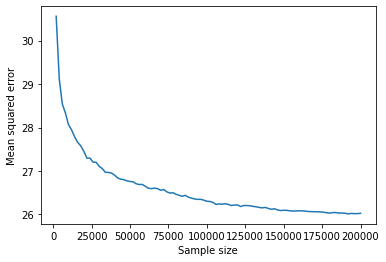

In [69]:
sample_size_ensembles(X_raw, y_raw, params_gbdt, "GBDT_SampleSizeTest_Raw")

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Total Bins 9325
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 89
[LightGBM] [Info] Start training from score 4.151500
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 3.4807	Validation error's l2: 37.6753
[10]	Train error's l2: 2.38606	Validation error's l2: 34.6503
[15]	Train error's l2: 1.99068	Validation error's l2: 33.3761
[20]	Train error's l2: 1.85082	Validation error's l2: 32.9972
[25]	Train error's l2: 1.72589	Validation error's l2: 32.8124
[30]	Train error's l2: 1.6117	Validation error's l2: 32.5643
[35]	Train error's l2: 1.53587	Validation error's l2: 32.4316
[40]	Train error's l2: 1.48425	Validation error's l2: 32.2238
[45]	Train error's l2: 1.4463	Validation error's l2: 32.1585
[50]	Train error's l2: 1.42362	Validation error's l2: 32.0245
[55]	Train error's l2: 1.41971	Validation error's l2: 31.9252
[60]	Train error's l2: 1.40784	Validation error's l2: 31.9415
[65]	Train error's l

[165]	Train error's l2: 3.60612	Validation error's l2: 29.4857
[170]	Train error's l2: 3.60346	Validation error's l2: 29.4827
[175]	Train error's l2: 3.60112	Validation error's l2: 29.4806
[180]	Train error's l2: 3.6009	Validation error's l2: 29.4605
[185]	Train error's l2: 3.59572	Validation error's l2: 29.4616
[190]	Train error's l2: 3.59263	Validation error's l2: 29.4559
[195]	Train error's l2: 3.5906	Validation error's l2: 29.4543
[200]	Train error's l2: 3.58587	Validation error's l2: 29.4535
[205]	Train error's l2: 3.58429	Validation error's l2: 29.455
[210]	Train error's l2: 3.58101	Validation error's l2: 29.4546
[215]	Train error's l2: 3.58107	Validation error's l2: 29.4516
[220]	Train error's l2: 3.57855	Validation error's l2: 29.435
[225]	Train error's l2: 3.576	Validation error's l2: 29.438
[230]	Train error's l2: 3.57627	Validation error's l2: 29.4315
[235]	Train error's l2: 3.57695	Validation error's l2: 29.4219
[240]	Train error's l2: 3.57478	Validation error's l2: 29.4201

[55]	Train error's l2: 7.78332	Validation error's l2: 28.7793
[60]	Train error's l2: 7.76467	Validation error's l2: 28.7352
[65]	Train error's l2: 7.75632	Validation error's l2: 28.7
[70]	Train error's l2: 7.74223	Validation error's l2: 28.6782
[75]	Train error's l2: 7.74241	Validation error's l2: 28.6696
[80]	Train error's l2: 7.72874	Validation error's l2: 28.6504
[85]	Train error's l2: 7.72719	Validation error's l2: 28.6373
[90]	Train error's l2: 7.70795	Validation error's l2: 28.6206
[95]	Train error's l2: 7.71066	Validation error's l2: 28.6178
[100]	Train error's l2: 7.70688	Validation error's l2: 28.6282
[105]	Train error's l2: 7.68787	Validation error's l2: 28.6263
[110]	Train error's l2: 7.6835	Validation error's l2: 28.6207
[115]	Train error's l2: 7.67514	Validation error's l2: 28.6132
[120]	Train error's l2: 7.67611	Validation error's l2: 28.6208
[125]	Train error's l2: 7.67553	Validation error's l2: 28.6168
[130]	Train error's l2: 7.67523	Validation error's l2: 28.5968
[135]

[40]	Train error's l2: 10.8434	Validation error's l2: 28.4868
[45]	Train error's l2: 10.8196	Validation error's l2: 28.4618
[50]	Train error's l2: 10.7969	Validation error's l2: 28.4365
[55]	Train error's l2: 10.8041	Validation error's l2: 28.4229
[60]	Train error's l2: 10.7898	Validation error's l2: 28.444
[65]	Train error's l2: 10.7704	Validation error's l2: 28.3867
[70]	Train error's l2: 10.76	Validation error's l2: 28.38
[75]	Train error's l2: 10.7427	Validation error's l2: 28.3589
[80]	Train error's l2: 10.736	Validation error's l2: 28.3721
[85]	Train error's l2: 10.7287	Validation error's l2: 28.3601
[90]	Train error's l2: 10.7309	Validation error's l2: 28.3425
[95]	Train error's l2: 10.7252	Validation error's l2: 28.3216
[100]	Train error's l2: 10.7185	Validation error's l2: 28.306
[105]	Train error's l2: 10.7138	Validation error's l2: 28.2879
[110]	Train error's l2: 10.7138	Validation error's l2: 28.3022
[115]	Train error's l2: 10.709	Validation error's l2: 28.3013
[120]	Train 

[85]	Train error's l2: 12.482	Validation error's l2: 28.0716
[90]	Train error's l2: 12.4787	Validation error's l2: 28.0548
[95]	Train error's l2: 12.479	Validation error's l2: 28.041
[100]	Train error's l2: 12.4759	Validation error's l2: 28.0242
[105]	Train error's l2: 12.4749	Validation error's l2: 28.0101
[110]	Train error's l2: 12.4728	Validation error's l2: 28.0214
[115]	Train error's l2: 12.4669	Validation error's l2: 28.0164
[120]	Train error's l2: 12.4679	Validation error's l2: 28.0101
[125]	Train error's l2: 12.4688	Validation error's l2: 27.9902
[130]	Train error's l2: 12.4686	Validation error's l2: 27.9901
[135]	Train error's l2: 12.4642	Validation error's l2: 27.99
[140]	Train error's l2: 12.4671	Validation error's l2: 27.9828
[145]	Train error's l2: 12.4675	Validation error's l2: 27.9774
[150]	Train error's l2: 12.4664	Validation error's l2: 27.9777
[155]	Train error's l2: 12.4663	Validation error's l2: 27.9718
[160]	Train error's l2: 12.4626	Validation error's l2: 27.9668


[35]	Train error's l2: 14.3868	Validation error's l2: 28.0077
[40]	Train error's l2: 14.3598	Validation error's l2: 27.9442
[45]	Train error's l2: 14.3347	Validation error's l2: 27.9438
[50]	Train error's l2: 14.3215	Validation error's l2: 27.9399
[55]	Train error's l2: 14.3157	Validation error's l2: 27.9209
[60]	Train error's l2: 14.3004	Validation error's l2: 27.9185
[65]	Train error's l2: 14.2825	Validation error's l2: 27.8785
[70]	Train error's l2: 14.2755	Validation error's l2: 27.8584
[75]	Train error's l2: 14.2702	Validation error's l2: 27.8444
[80]	Train error's l2: 14.2651	Validation error's l2: 27.8438
[85]	Train error's l2: 14.255	Validation error's l2: 27.8344
[90]	Train error's l2: 14.2545	Validation error's l2: 27.815
[95]	Train error's l2: 14.2491	Validation error's l2: 27.8081
[100]	Train error's l2: 14.2446	Validation error's l2: 27.7897
[105]	Train error's l2: 14.2456	Validation error's l2: 27.7771
[110]	Train error's l2: 14.2383	Validation error's l2: 27.7854
[115]	T

[225]	Train error's l2: 14.9905	Validation error's l2: 27.6339
[230]	Train error's l2: 14.9898	Validation error's l2: 27.6328
[235]	Train error's l2: 14.9885	Validation error's l2: 27.6288
[240]	Train error's l2: 14.9844	Validation error's l2: 27.6289
[245]	Train error's l2: 14.9864	Validation error's l2: 27.6295
[250]	Train error's l2: 14.9818	Validation error's l2: 27.6302
[255]	Train error's l2: 14.9805	Validation error's l2: 27.6313
[260]	Train error's l2: 14.9769	Validation error's l2: 27.6342
[265]	Train error's l2: 14.9764	Validation error's l2: 27.6307
Early stopping, best iteration is:
[246]	Train error's l2: 14.9846	Validation error's l2: 27.6275
[LightGBM] [Info] Total Bins 11375
[LightGBM] [Info] Number of data points in the train set: 44000, number of used features: 101
[LightGBM] [Info] Start training from score 4.196636
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 16.5813	Validation error's l2: 29.893
[10]	Train error's l2: 15.8956	V

[20]	Train error's l2: 16.1129	Validation error's l2: 27.9853
[25]	Train error's l2: 16.0836	Validation error's l2: 27.872
[30]	Train error's l2: 16.0304	Validation error's l2: 27.794
[35]	Train error's l2: 16.0073	Validation error's l2: 27.789
[40]	Train error's l2: 16.0046	Validation error's l2: 27.7732
[45]	Train error's l2: 15.9871	Validation error's l2: 27.7437
[50]	Train error's l2: 15.9602	Validation error's l2: 27.7108
[55]	Train error's l2: 15.9567	Validation error's l2: 27.6843
[60]	Train error's l2: 15.9445	Validation error's l2: 27.6642
[65]	Train error's l2: 15.9227	Validation error's l2: 27.6299
[70]	Train error's l2: 15.9202	Validation error's l2: 27.6063
[75]	Train error's l2: 15.9136	Validation error's l2: 27.5899
[80]	Train error's l2: 15.9049	Validation error's l2: 27.5915
[85]	Train error's l2: 15.8968	Validation error's l2: 27.5827
[90]	Train error's l2: 15.8955	Validation error's l2: 27.5796
[95]	Train error's l2: 15.8872	Validation error's l2: 27.5666
[100]	Train

[115]	Train error's l2: 16.4047	Validation error's l2: 27.5131
[120]	Train error's l2: 16.4024	Validation error's l2: 27.5011
[125]	Train error's l2: 16.3958	Validation error's l2: 27.4975
[130]	Train error's l2: 16.3948	Validation error's l2: 27.4917
[135]	Train error's l2: 16.3945	Validation error's l2: 27.4844
[140]	Train error's l2: 16.3913	Validation error's l2: 27.4781
[145]	Train error's l2: 16.3922	Validation error's l2: 27.4735
[150]	Train error's l2: 16.3876	Validation error's l2: 27.4704
[155]	Train error's l2: 16.3903	Validation error's l2: 27.4682
[160]	Train error's l2: 16.39	Validation error's l2: 27.4678
[165]	Train error's l2: 16.3852	Validation error's l2: 27.4626
[170]	Train error's l2: 16.3789	Validation error's l2: 27.4626
[175]	Train error's l2: 16.3814	Validation error's l2: 27.4689
[180]	Train error's l2: 16.3849	Validation error's l2: 27.4663
[185]	Train error's l2: 16.3822	Validation error's l2: 27.459
[190]	Train error's l2: 16.3823	Validation error's l2: 27.

[LightGBM] [Info] Total Bins 11470
[LightGBM] [Info] Number of data points in the train set: 58000, number of used features: 101
[LightGBM] [Info] Start training from score 4.197190
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 18.1734	Validation error's l2: 29.5142
[10]	Train error's l2: 17.5886	Validation error's l2: 28.5481
[15]	Train error's l2: 17.3983	Validation error's l2: 28.1047
[20]	Train error's l2: 17.3123	Validation error's l2: 27.9169
[25]	Train error's l2: 17.2778	Validation error's l2: 27.8058
[30]	Train error's l2: 17.24	Validation error's l2: 27.7146
[35]	Train error's l2: 17.2231	Validation error's l2: 27.681
[40]	Train error's l2: 17.2187	Validation error's l2: 27.6616
[45]	Train error's l2: 17.2074	Validation error's l2: 27.6274
[50]	Train error's l2: 17.1917	Validation error's l2: 27.5913
[55]	Train error's l2: 17.1994	Validation error's l2: 27.5847
[60]	Train error's l2: 17.1863	Validation error's l2: 27.5791
[65]	Train error'

[90]	Train error's l2: 17.5517	Validation error's l2: 27.4646
[95]	Train error's l2: 17.545	Validation error's l2: 27.4552
[100]	Train error's l2: 17.5479	Validation error's l2: 27.4564
[105]	Train error's l2: 17.5373	Validation error's l2: 27.448
[110]	Train error's l2: 17.5329	Validation error's l2: 27.4438
[115]	Train error's l2: 17.528	Validation error's l2: 27.4433
[120]	Train error's l2: 17.5241	Validation error's l2: 27.431
[125]	Train error's l2: 17.5218	Validation error's l2: 27.4262
[130]	Train error's l2: 17.5265	Validation error's l2: 27.4293
[135]	Train error's l2: 17.5278	Validation error's l2: 27.4303
[140]	Train error's l2: 17.5256	Validation error's l2: 27.4238
[145]	Train error's l2: 17.5255	Validation error's l2: 27.4158
[150]	Train error's l2: 17.5173	Validation error's l2: 27.4137
[155]	Train error's l2: 17.5199	Validation error's l2: 27.414
[160]	Train error's l2: 17.5187	Validation error's l2: 27.4155
[165]	Train error's l2: 17.5147	Validation error's l2: 27.4085

[55]	Train error's l2: 18.1836	Validation error's l2: 27.4799
[60]	Train error's l2: 18.1655	Validation error's l2: 27.4773
[65]	Train error's l2: 18.1486	Validation error's l2: 27.4481
[70]	Train error's l2: 18.1458	Validation error's l2: 27.4308
[75]	Train error's l2: 18.1348	Validation error's l2: 27.4107
[80]	Train error's l2: 18.1262	Validation error's l2: 27.4106
[85]	Train error's l2: 18.1159	Validation error's l2: 27.3934
[90]	Train error's l2: 18.12	Validation error's l2: 27.3857
[95]	Train error's l2: 18.1138	Validation error's l2: 27.3783
[100]	Train error's l2: 18.113	Validation error's l2: 27.3799
[105]	Train error's l2: 18.1022	Validation error's l2: 27.3727
[110]	Train error's l2: 18.0959	Validation error's l2: 27.3763
[115]	Train error's l2: 18.0946	Validation error's l2: 27.3767
[120]	Train error's l2: 18.0925	Validation error's l2: 27.3714
[125]	Train error's l2: 18.0877	Validation error's l2: 27.368
[130]	Train error's l2: 18.0893	Validation error's l2: 27.3654
[135]

Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 19.6358	Validation error's l2: 28.8912
[10]	Train error's l2: 19.056	Validation error's l2: 28.1331
[15]	Train error's l2: 18.8797	Validation error's l2: 27.8462
[20]	Train error's l2: 18.7902	Validation error's l2: 27.6894
[25]	Train error's l2: 18.74	Validation error's l2: 27.5745
[30]	Train error's l2: 18.7026	Validation error's l2: 27.5255
[35]	Train error's l2: 18.6872	Validation error's l2: 27.485
[40]	Train error's l2: 18.6919	Validation error's l2: 27.4577
[45]	Train error's l2: 18.6777	Validation error's l2: 27.4382
[50]	Train error's l2: 18.6662	Validation error's l2: 27.4196
[55]	Train error's l2: 18.665	Validation error's l2: 27.4063
[60]	Train error's l2: 18.6528	Validation error's l2: 27.4125
[65]	Train error's l2: 18.6334	Validation error's l2: 27.3851
[70]	Train error's l2: 18.6249	Validation error's l2: 27.3736
[75]	Train error's l2: 18.611	Validation error's l2: 27.3583
[80]	Train error

[30]	Train error's l2: 19.1401	Validation error's l2: 27.4704
[35]	Train error's l2: 19.1241	Validation error's l2: 27.425
[40]	Train error's l2: 19.1348	Validation error's l2: 27.4176
[45]	Train error's l2: 19.1248	Validation error's l2: 27.392
[50]	Train error's l2: 19.1111	Validation error's l2: 27.3831
[55]	Train error's l2: 19.1145	Validation error's l2: 27.3858
[60]	Train error's l2: 19.1018	Validation error's l2: 27.3948
[65]	Train error's l2: 19.0759	Validation error's l2: 27.3681
[70]	Train error's l2: 19.0688	Validation error's l2: 27.3571
[75]	Train error's l2: 19.0537	Validation error's l2: 27.3397
[80]	Train error's l2: 19.0506	Validation error's l2: 27.3354
[85]	Train error's l2: 19.0411	Validation error's l2: 27.3202
[90]	Train error's l2: 19.0411	Validation error's l2: 27.3184
[95]	Train error's l2: 19.0353	Validation error's l2: 27.3064
[100]	Train error's l2: 19.0381	Validation error's l2: 27.3028
[105]	Train error's l2: 19.0275	Validation error's l2: 27.2898
[110]	Tr

[160]	Train error's l2: 19.26	Validation error's l2: 27.229
[165]	Train error's l2: 19.2568	Validation error's l2: 27.2263
[170]	Train error's l2: 19.2539	Validation error's l2: 27.2263
[175]	Train error's l2: 19.253	Validation error's l2: 27.2292
[180]	Train error's l2: 19.2532	Validation error's l2: 27.2286
[185]	Train error's l2: 19.2497	Validation error's l2: 27.2249
[190]	Train error's l2: 19.2487	Validation error's l2: 27.2203
[195]	Train error's l2: 19.2484	Validation error's l2: 27.2211
[200]	Train error's l2: 19.2471	Validation error's l2: 27.2224
[205]	Train error's l2: 19.2459	Validation error's l2: 27.2229
Early stopping, best iteration is:
[189]	Train error's l2: 19.2489	Validation error's l2: 27.2201
[LightGBM] [Info] Total Bins 11611
[LightGBM] [Info] Number of data points in the train set: 86000, number of used features: 101
[LightGBM] [Info] Start training from score 4.183326
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 20.3658	Val

[5]	Train error's l2: 20.537	Validation error's l2: 28.6107
[10]	Train error's l2: 20.0524	Validation error's l2: 27.8809
[15]	Train error's l2: 19.8415	Validation error's l2: 27.5531
[20]	Train error's l2: 19.7639	Validation error's l2: 27.4275
[25]	Train error's l2: 19.72	Validation error's l2: 27.352
[30]	Train error's l2: 19.6746	Validation error's l2: 27.3116
[35]	Train error's l2: 19.6703	Validation error's l2: 27.2907
[40]	Train error's l2: 19.686	Validation error's l2: 27.273
[45]	Train error's l2: 19.6782	Validation error's l2: 27.2507
[50]	Train error's l2: 19.6665	Validation error's l2: 27.2482
[55]	Train error's l2: 19.6718	Validation error's l2: 27.2458
[60]	Train error's l2: 19.6635	Validation error's l2: 27.2415
[65]	Train error's l2: 19.6462	Validation error's l2: 27.2204
[70]	Train error's l2: 19.6394	Validation error's l2: 27.2101
[75]	Train error's l2: 19.6318	Validation error's l2: 27.1947
[80]	Train error's l2: 19.6266	Validation error's l2: 27.1963
[85]	Train erro

[80]	Train error's l2: 19.9234	Validation error's l2: 27.1621
[85]	Train error's l2: 19.9152	Validation error's l2: 27.1567
[90]	Train error's l2: 19.9172	Validation error's l2: 27.1583
[95]	Train error's l2: 19.9069	Validation error's l2: 27.1526
[100]	Train error's l2: 19.9098	Validation error's l2: 27.1477
[105]	Train error's l2: 19.9019	Validation error's l2: 27.141
[110]	Train error's l2: 19.8977	Validation error's l2: 27.1442
[115]	Train error's l2: 19.8977	Validation error's l2: 27.1497
[120]	Train error's l2: 19.8955	Validation error's l2: 27.1471
[125]	Train error's l2: 19.891	Validation error's l2: 27.1464
Early stopping, best iteration is:
[106]	Train error's l2: 19.9023	Validation error's l2: 27.1394
[LightGBM] [Info] Total Bins 11659
[LightGBM] [Info] Number of data points in the train set: 98000, number of used features: 101
[LightGBM] [Info] Start training from score 4.188071
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 20.8691	Valid

[45]	Train error's l2: 20.4094	Validation error's l2: 27.1933
[50]	Train error's l2: 20.407	Validation error's l2: 27.1801
[55]	Train error's l2: 20.4049	Validation error's l2: 27.1722
[60]	Train error's l2: 20.3921	Validation error's l2: 27.1743
[65]	Train error's l2: 20.3761	Validation error's l2: 27.1499
[70]	Train error's l2: 20.3746	Validation error's l2: 27.1448
[75]	Train error's l2: 20.3677	Validation error's l2: 27.1326
[80]	Train error's l2: 20.3602	Validation error's l2: 27.1322
[85]	Train error's l2: 20.3486	Validation error's l2: 27.1241
[90]	Train error's l2: 20.3503	Validation error's l2: 27.1236
[95]	Train error's l2: 20.3444	Validation error's l2: 27.1163
[100]	Train error's l2: 20.347	Validation error's l2: 27.1181
[105]	Train error's l2: 20.337	Validation error's l2: 27.1115
[110]	Train error's l2: 20.3325	Validation error's l2: 27.1158
[115]	Train error's l2: 20.3293	Validation error's l2: 27.1187
[120]	Train error's l2: 20.3233	Validation error's l2: 27.1074
[125]	

[LightGBM] [Info] Total Bins 11723
[LightGBM] [Info] Number of data points in the train set: 110000, number of used features: 101
[LightGBM] [Info] Start training from score 4.186991
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 21.3749	Validation error's l2: 28.4069
[10]	Train error's l2: 20.9447	Validation error's l2: 27.7691
[15]	Train error's l2: 20.7638	Validation error's l2: 27.487
[20]	Train error's l2: 20.7013	Validation error's l2: 27.3562
[25]	Train error's l2: 20.653	Validation error's l2: 27.283
[30]	Train error's l2: 20.6143	Validation error's l2: 27.2486
[35]	Train error's l2: 20.5973	Validation error's l2: 27.2261
[40]	Train error's l2: 20.6078	Validation error's l2: 27.202
[45]	Train error's l2: 20.6006	Validation error's l2: 27.1766
[50]	Train error's l2: 20.5968	Validation error's l2: 27.1678
[55]	Train error's l2: 20.6013	Validation error's l2: 27.1684
[60]	Train error's l2: 20.5958	Validation error's l2: 27.1693
[65]	Train error'

[170]	Train error's l2: 20.6862	Validation error's l2: 27.0536
Early stopping, best iteration is:
[153]	Train error's l2: 20.6847	Validation error's l2: 27.0494
[LightGBM] [Info] Total Bins 11750
[LightGBM] [Info] Number of data points in the train set: 116000, number of used features: 101
[LightGBM] [Info] Start training from score 4.184448
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 21.5494	Validation error's l2: 28.2485
[10]	Train error's l2: 21.1449	Validation error's l2: 27.72
[15]	Train error's l2: 20.9952	Validation error's l2: 27.4242
[20]	Train error's l2: 20.9304	Validation error's l2: 27.3182
[25]	Train error's l2: 20.8928	Validation error's l2: 27.2531
[30]	Train error's l2: 20.8616	Validation error's l2: 27.2131
[35]	Train error's l2: 20.8504	Validation error's l2: 27.196
[40]	Train error's l2: 20.8617	Validation error's l2: 27.1644
[45]	Train error's l2: 20.8551	Validation error's l2: 27.1483
[50]	Train error's l2: 20.8476	Validation

[120]	Train error's l2: 21.0043	Validation error's l2: 27.0436
[125]	Train error's l2: 20.998	Validation error's l2: 27.0321
[130]	Train error's l2: 20.9917	Validation error's l2: 27.0277
[135]	Train error's l2: 20.9885	Validation error's l2: 27.0218
[140]	Train error's l2: 20.9836	Validation error's l2: 27.0179
[145]	Train error's l2: 20.9798	Validation error's l2: 27.015
[150]	Train error's l2: 20.9753	Validation error's l2: 27.0133
[155]	Train error's l2: 20.9744	Validation error's l2: 27.0112
[160]	Train error's l2: 20.9698	Validation error's l2: 27.0055
[165]	Train error's l2: 20.9699	Validation error's l2: 27.0047
[170]	Train error's l2: 20.9719	Validation error's l2: 27.0021
[175]	Train error's l2: 20.9725	Validation error's l2: 27.0049
[180]	Train error's l2: 20.9774	Validation error's l2: 27.0055
[185]	Train error's l2: 20.976	Validation error's l2: 27.0073
[190]	Train error's l2: 20.9748	Validation error's l2: 27.0079
Early stopping, best iteration is:
[172]	Train error's l2:

[LightGBM] [Info] Total Bins 11824
[LightGBM] [Info] Number of data points in the train set: 130000, number of used features: 105
[LightGBM] [Info] Start training from score 4.173969
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 21.9916	Validation error's l2: 28.0842
[10]	Train error's l2: 21.5792	Validation error's l2: 27.508
[15]	Train error's l2: 21.4403	Validation error's l2: 27.343
[20]	Train error's l2: 21.4209	Validation error's l2: 27.2792
[25]	Train error's l2: 21.4175	Validation error's l2: 27.254
[30]	Train error's l2: 21.3829	Validation error's l2: 27.2047
[35]	Train error's l2: 21.3602	Validation error's l2: 27.1753
[40]	Train error's l2: 21.3702	Validation error's l2: 27.1798
[45]	Train error's l2: 21.339	Validation error's l2: 27.1462
[50]	Train error's l2: 21.3369	Validation error's l2: 27.1472
[55]	Train error's l2: 21.3461	Validation error's l2: 27.1545
[60]	Train error's l2: 21.3081	Validation error's l2: 27.1175
[65]	Train error'

Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 22.1284	Validation error's l2: 28.0238
[10]	Train error's l2: 21.7538	Validation error's l2: 27.5166
[15]	Train error's l2: 21.5989	Validation error's l2: 27.3299
[20]	Train error's l2: 21.5771	Validation error's l2: 27.2469
[25]	Train error's l2: 21.5835	Validation error's l2: 27.223
[30]	Train error's l2: 21.5398	Validation error's l2: 27.1758
[35]	Train error's l2: 21.5179	Validation error's l2: 27.1565
[40]	Train error's l2: 21.5321	Validation error's l2: 27.1779
[45]	Train error's l2: 21.4943	Validation error's l2: 27.1318
[50]	Train error's l2: 21.4942	Validation error's l2: 27.1323
[55]	Train error's l2: 21.5044	Validation error's l2: 27.1374
[60]	Train error's l2: 21.4655	Validation error's l2: 27.0984
[65]	Train error's l2: 21.4355	Validation error's l2: 27.058
[70]	Train error's l2: 21.4153	Validation error's l2: 27.0362
[75]	Train error's l2: 21.4202	Validation error's l2: 27.0445
[80]	Train e

[80]	Train error's l2: 21.5641	Validation error's l2: 27.0157
[85]	Train error's l2: 21.5519	Validation error's l2: 26.9985
[90]	Train error's l2: 21.5396	Validation error's l2: 26.9864
[95]	Train error's l2: 21.5359	Validation error's l2: 26.9864
[100]	Train error's l2: 21.5379	Validation error's l2: 26.9861
[105]	Train error's l2: 21.5333	Validation error's l2: 26.9873
[110]	Train error's l2: 21.5309	Validation error's l2: 26.989
[115]	Train error's l2: 21.5357	Validation error's l2: 26.9909
[120]	Train error's l2: 21.5321	Validation error's l2: 26.9866
[125]	Train error's l2: 21.5257	Validation error's l2: 26.9796
[130]	Train error's l2: 21.5201	Validation error's l2: 26.9769
[135]	Train error's l2: 21.5159	Validation error's l2: 26.9711
[140]	Train error's l2: 21.5088	Validation error's l2: 26.9654
[145]	Train error's l2: 21.5057	Validation error's l2: 26.9615
[150]	Train error's l2: 21.5013	Validation error's l2: 26.9565
[155]	Train error's l2: 21.5024	Validation error's l2: 26.95

[70]	Train error's l2: 21.733	Validation error's l2: 27.0051
[75]	Train error's l2: 21.7385	Validation error's l2: 27.0121
[80]	Train error's l2: 21.7318	Validation error's l2: 27.0053
[85]	Train error's l2: 21.7199	Validation error's l2: 26.9906
[90]	Train error's l2: 21.7093	Validation error's l2: 26.9792
[95]	Train error's l2: 21.7069	Validation error's l2: 26.9755
[100]	Train error's l2: 21.7108	Validation error's l2: 26.9802
[105]	Train error's l2: 21.7052	Validation error's l2: 26.9764
[110]	Train error's l2: 21.7026	Validation error's l2: 26.9753
[115]	Train error's l2: 21.7078	Validation error's l2: 26.9804
[120]	Train error's l2: 21.7022	Validation error's l2: 26.9745
[125]	Train error's l2: 21.6948	Validation error's l2: 26.9664
[130]	Train error's l2: 21.6899	Validation error's l2: 26.9627
[135]	Train error's l2: 21.6855	Validation error's l2: 26.9575
[140]	Train error's l2: 21.68	Validation error's l2: 26.9529
[145]	Train error's l2: 21.6762	Validation error's l2: 26.9475
[

[65]	Train error's l2: 21.9255	Validation error's l2: 27.031
[70]	Train error's l2: 21.9104	Validation error's l2: 27.0146
[75]	Train error's l2: 21.9138	Validation error's l2: 27.0208
[80]	Train error's l2: 21.9088	Validation error's l2: 27.013
[85]	Train error's l2: 21.8957	Validation error's l2: 26.995
[90]	Train error's l2: 21.885	Validation error's l2: 26.9861
[95]	Train error's l2: 21.882	Validation error's l2: 26.9812
[100]	Train error's l2: 21.8874	Validation error's l2: 26.9847
[105]	Train error's l2: 21.884	Validation error's l2: 26.9858
[110]	Train error's l2: 21.8842	Validation error's l2: 26.9831
[115]	Train error's l2: 21.8882	Validation error's l2: 26.9863
[120]	Train error's l2: 21.8839	Validation error's l2: 26.9828
[125]	Train error's l2: 21.8773	Validation error's l2: 26.9749
[130]	Train error's l2: 21.8717	Validation error's l2: 26.97
[135]	Train error's l2: 21.8687	Validation error's l2: 26.9627
[140]	Train error's l2: 21.8634	Validation error's l2: 26.957
[145]	Tr

[35]	Train error's l2: 22.127	Validation error's l2: 27.0647
[40]	Train error's l2: 22.1436	Validation error's l2: 27.07
[45]	Train error's l2: 22.1015	Validation error's l2: 27.0271
[50]	Train error's l2: 22.101	Validation error's l2: 27.0299
[55]	Train error's l2: 22.12	Validation error's l2: 27.0475
[60]	Train error's l2: 22.0851	Validation error's l2: 27.0061
[65]	Train error's l2: 22.057	Validation error's l2: 26.9781
[70]	Train error's l2: 22.0363	Validation error's l2: 26.9598
[75]	Train error's l2: 22.0434	Validation error's l2: 26.9687
[80]	Train error's l2: 22.0395	Validation error's l2: 26.9594
[85]	Train error's l2: 22.0255	Validation error's l2: 26.9485
[90]	Train error's l2: 22.0168	Validation error's l2: 26.9392
[95]	Train error's l2: 22.0119	Validation error's l2: 26.9375
[100]	Train error's l2: 22.0134	Validation error's l2: 26.9364
[105]	Train error's l2: 22.0089	Validation error's l2: 26.9349
[110]	Train error's l2: 22.0078	Validation error's l2: 26.9371
[115]	Train 

[75]	Train error's l2: 22.1617	Validation error's l2: 26.9563
[80]	Train error's l2: 22.1563	Validation error's l2: 26.949
[85]	Train error's l2: 22.1439	Validation error's l2: 26.9366
[90]	Train error's l2: 22.1354	Validation error's l2: 26.9274
[95]	Train error's l2: 22.1304	Validation error's l2: 26.9251
[100]	Train error's l2: 22.1336	Validation error's l2: 26.9248
[105]	Train error's l2: 22.1285	Validation error's l2: 26.9215
[110]	Train error's l2: 22.1267	Validation error's l2: 26.9211
[115]	Train error's l2: 22.1313	Validation error's l2: 26.9251
[120]	Train error's l2: 22.1272	Validation error's l2: 26.9195
[125]	Train error's l2: 22.1205	Validation error's l2: 26.912
[130]	Train error's l2: 22.1142	Validation error's l2: 26.904
[135]	Train error's l2: 22.1096	Validation error's l2: 26.8969
[140]	Train error's l2: 22.1037	Validation error's l2: 26.8883
[145]	Train error's l2: 22.0985	Validation error's l2: 26.8859
[150]	Train error's l2: 22.0943	Validation error's l2: 26.8832


[65]	Train error's l2: 22.313	Validation error's l2: 26.9758
[70]	Train error's l2: 22.2943	Validation error's l2: 26.9612
[75]	Train error's l2: 22.2986	Validation error's l2: 26.9634
[80]	Train error's l2: 22.2928	Validation error's l2: 26.9499
[85]	Train error's l2: 22.2794	Validation error's l2: 26.9352
[90]	Train error's l2: 22.269	Validation error's l2: 26.9256
[95]	Train error's l2: 22.2653	Validation error's l2: 26.9225
[100]	Train error's l2: 22.2678	Validation error's l2: 26.9219
[105]	Train error's l2: 22.2619	Validation error's l2: 26.919
[110]	Train error's l2: 22.2601	Validation error's l2: 26.9198
[115]	Train error's l2: 22.2638	Validation error's l2: 26.9252
[120]	Train error's l2: 22.2578	Validation error's l2: 26.9184
[125]	Train error's l2: 22.2522	Validation error's l2: 26.9103
[130]	Train error's l2: 22.2472	Validation error's l2: 26.9042
[135]	Train error's l2: 22.2435	Validation error's l2: 26.8997
[140]	Train error's l2: 22.2386	Validation error's l2: 26.8947
[1

[75]	Train error's l2: 22.4348	Validation error's l2: 26.961
[80]	Train error's l2: 22.4319	Validation error's l2: 26.9538
[85]	Train error's l2: 22.4187	Validation error's l2: 26.9424
[90]	Train error's l2: 22.4124	Validation error's l2: 26.9334
[95]	Train error's l2: 22.4096	Validation error's l2: 26.9289
[100]	Train error's l2: 22.4117	Validation error's l2: 26.9274
[105]	Train error's l2: 22.4085	Validation error's l2: 26.9242
[110]	Train error's l2: 22.4095	Validation error's l2: 26.9298
[115]	Train error's l2: 22.4118	Validation error's l2: 26.9343
[120]	Train error's l2: 22.4067	Validation error's l2: 26.9271
[125]	Train error's l2: 22.3995	Validation error's l2: 26.9175
[130]	Train error's l2: 22.3929	Validation error's l2: 26.9122
[135]	Train error's l2: 22.3885	Validation error's l2: 26.9072
[140]	Train error's l2: 22.3818	Validation error's l2: 26.9002
[145]	Train error's l2: 22.3765	Validation error's l2: 26.8927
[150]	Train error's l2: 22.3724	Validation error's l2: 26.890

[80]	Train error's l2: 22.5988	Validation error's l2: 26.9455
[85]	Train error's l2: 22.5838	Validation error's l2: 26.9266
[90]	Train error's l2: 22.5735	Validation error's l2: 26.9128
[95]	Train error's l2: 22.5694	Validation error's l2: 26.9107
[100]	Train error's l2: 22.5723	Validation error's l2: 26.9088
[105]	Train error's l2: 22.5681	Validation error's l2: 26.9068
[110]	Train error's l2: 22.5674	Validation error's l2: 26.91
[115]	Train error's l2: 22.5698	Validation error's l2: 26.9129
[120]	Train error's l2: 22.5641	Validation error's l2: 26.9023
[125]	Train error's l2: 22.5586	Validation error's l2: 26.8937
[130]	Train error's l2: 22.5529	Validation error's l2: 26.8877
[135]	Train error's l2: 22.5484	Validation error's l2: 26.8819
[140]	Train error's l2: 22.5403	Validation error's l2: 26.876
[145]	Train error's l2: 22.5348	Validation error's l2: 26.8689
[150]	Train error's l2: 22.5305	Validation error's l2: 26.8663
[155]	Train error's l2: 22.5298	Validation error's l2: 26.867


[95]	Train error's l2: 22.6857	Validation error's l2: 26.8743
[100]	Train error's l2: 22.6893	Validation error's l2: 26.8705
[105]	Train error's l2: 22.685	Validation error's l2: 26.8675
[110]	Train error's l2: 22.6833	Validation error's l2: 26.8667
[115]	Train error's l2: 22.6865	Validation error's l2: 26.8656
[120]	Train error's l2: 22.6814	Validation error's l2: 26.8597
[125]	Train error's l2: 22.6735	Validation error's l2: 26.8514
[130]	Train error's l2: 22.6675	Validation error's l2: 26.8481
[135]	Train error's l2: 22.6633	Validation error's l2: 26.8445
[140]	Train error's l2: 22.6547	Validation error's l2: 26.8383
[145]	Train error's l2: 22.6501	Validation error's l2: 26.8345
[150]	Train error's l2: 22.6465	Validation error's l2: 26.8337
[155]	Train error's l2: 22.6465	Validation error's l2: 26.8338
[160]	Train error's l2: 22.6421	Validation error's l2: 26.83
[165]	Train error's l2: 22.6399	Validation error's l2: 26.8275
[170]	Train error's l2: 22.6417	Validation error's l2: 26.8

[105]	Train error's l2: 22.7515	Validation error's l2: 26.8657
[110]	Train error's l2: 22.7515	Validation error's l2: 26.8655
[115]	Train error's l2: 22.7557	Validation error's l2: 26.8664
[120]	Train error's l2: 22.7498	Validation error's l2: 26.8585
[125]	Train error's l2: 22.7423	Validation error's l2: 26.8508
[130]	Train error's l2: 22.7355	Validation error's l2: 26.846
[135]	Train error's l2: 22.7312	Validation error's l2: 26.8407
[140]	Train error's l2: 22.7226	Validation error's l2: 26.8331
[145]	Train error's l2: 22.716	Validation error's l2: 26.8294
[150]	Train error's l2: 22.7115	Validation error's l2: 26.8273
[155]	Train error's l2: 22.7099	Validation error's l2: 26.8272
[160]	Train error's l2: 22.7061	Validation error's l2: 26.8248
[165]	Train error's l2: 22.7063	Validation error's l2: 26.8248
[170]	Train error's l2: 22.7071	Validation error's l2: 26.8244
[175]	Train error's l2: 22.71	Validation error's l2: 26.8305
[180]	Train error's l2: 22.714	Validation error's l2: 26.83

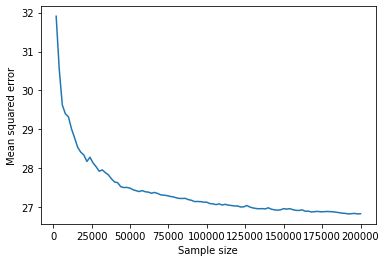

In [68]:
sample_size_ensembles(X_raw, y_raw, params_rf, "RF_SampleSizeTest_Raw")

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 14
[LightGBM] [Info] Start training from score 4.151500
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 37.6733	Validation error's l2: 38.7618
[10]	Train error's l2: 35.5017	Validation error's l2: 37.2315
[15]	Train error's l2: 33.6441	Validation error's l2: 36.0156
[20]	Train error's l2: 32.0615	Validation error's l2: 35.0021
[25]	Train error's l2: 30.714	Validation error's l2: 34.2015
[30]	Train error's l2: 29.463	Validation error's l2: 33.5334
[35]	Train error's l2: 28.3632	Validation error's l2: 32.9812
[40]	Train error's l2: 27.4191	Validation error's l2: 32.5482
[45]	Train error's l2: 26.604	Validation error's l2: 32.2473
[50]	Train error's l2: 25.727	Validation error's l2: 31.936
[55]	Train error's l2: 24.9435	Validation error's l2: 31.7009
[60]	Train error's l2: 24.2421	Validation error's l2: 31.5136
[65]	Train error's l2:

[65]	Train error's l2: 29.0528	Validation error's l2: 30.437
[70]	Train error's l2: 28.6996	Validation error's l2: 30.2565
[75]	Train error's l2: 28.3472	Validation error's l2: 30.0886
[80]	Train error's l2: 28.0283	Validation error's l2: 29.9484
[85]	Train error's l2: 27.7432	Validation error's l2: 29.8355
[90]	Train error's l2: 27.4723	Validation error's l2: 29.7326
[95]	Train error's l2: 27.2097	Validation error's l2: 29.6379
[100]	Train error's l2: 26.9617	Validation error's l2: 29.5572
[105]	Train error's l2: 26.7299	Validation error's l2: 29.4865
[110]	Train error's l2: 26.5102	Validation error's l2: 29.4311
[115]	Train error's l2: 26.2993	Validation error's l2: 29.3792
[120]	Train error's l2: 26.0963	Validation error's l2: 29.3259
[125]	Train error's l2: 25.9077	Validation error's l2: 29.282
[130]	Train error's l2: 25.7033	Validation error's l2: 29.2425
[135]	Train error's l2: 25.516	Validation error's l2: 29.2102
[140]	Train error's l2: 25.3462	Validation error's l2: 29.1962
[1

[215]	Train error's l2: 24.4276	Validation error's l2: 28.8571
[220]	Train error's l2: 24.3413	Validation error's l2: 28.8559
[225]	Train error's l2: 24.2496	Validation error's l2: 28.853
[230]	Train error's l2: 24.1696	Validation error's l2: 28.8513
[235]	Train error's l2: 24.0971	Validation error's l2: 28.8515
[240]	Train error's l2: 24.024	Validation error's l2: 28.8454
[245]	Train error's l2: 23.9527	Validation error's l2: 28.8419
[250]	Train error's l2: 23.8712	Validation error's l2: 28.8393
[255]	Train error's l2: 23.8061	Validation error's l2: 28.8407
[260]	Train error's l2: 23.7322	Validation error's l2: 28.8369
[265]	Train error's l2: 23.6575	Validation error's l2: 28.8372
[270]	Train error's l2: 23.5907	Validation error's l2: 28.8352
[275]	Train error's l2: 23.514	Validation error's l2: 28.8348
[280]	Train error's l2: 23.4566	Validation error's l2: 28.8365
[285]	Train error's l2: 23.3898	Validation error's l2: 28.8356
[290]	Train error's l2: 23.3322	Validation error's l2: 28.

[275]	Train error's l2: 24.2829	Validation error's l2: 28.6526
[280]	Train error's l2: 24.224	Validation error's l2: 28.6509
[285]	Train error's l2: 24.1676	Validation error's l2: 28.652
[290]	Train error's l2: 24.1168	Validation error's l2: 28.6506
[295]	Train error's l2: 24.0625	Validation error's l2: 28.653
Early stopping, best iteration is:
[278]	Train error's l2: 24.2463	Validation error's l2: 28.6501
[LightGBM] [Info] Total Bins 1172
[LightGBM] [Info] Number of data points in the train set: 18000, number of used features: 14
[LightGBM] [Info] Start training from score 4.178222
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 38.6768	Validation error's l2: 38.6914
[10]	Train error's l2: 36.9395	Validation error's l2: 37.0827
[15]	Train error's l2: 35.4732	Validation error's l2: 35.7331
[20]	Train error's l2: 34.2702	Validation error's l2: 34.639
[25]	Train error's l2: 33.2522	Validation error's l2: 33.7307
[30]	Train error's l2: 32.3928	Validation

[295]	Train error's l2: 24.538	Validation error's l2: 28.5701
[300]	Train error's l2: 24.4902	Validation error's l2: 28.566
[305]	Train error's l2: 24.441	Validation error's l2: 28.565
[310]	Train error's l2: 24.3993	Validation error's l2: 28.5623
[315]	Train error's l2: 24.3563	Validation error's l2: 28.5599
[320]	Train error's l2: 24.3127	Validation error's l2: 28.5589
[325]	Train error's l2: 24.2705	Validation error's l2: 28.5604
[330]	Train error's l2: 24.2234	Validation error's l2: 28.5587
[335]	Train error's l2: 24.1848	Validation error's l2: 28.5568
[340]	Train error's l2: 24.1398	Validation error's l2: 28.5571
[345]	Train error's l2: 24.0964	Validation error's l2: 28.5556
[350]	Train error's l2: 24.0489	Validation error's l2: 28.5535
[355]	Train error's l2: 24.0121	Validation error's l2: 28.555
[360]	Train error's l2: 23.9678	Validation error's l2: 28.557
Early stopping, best iteration is:
[342]	Train error's l2: 24.1204	Validation error's l2: 28.5529
[LightGBM] [Info] Total Bi

[180]	Train error's l2: 26.5124	Validation error's l2: 28.6196
[185]	Train error's l2: 26.4455	Validation error's l2: 28.6067
[190]	Train error's l2: 26.3817	Validation error's l2: 28.5963
[195]	Train error's l2: 26.3172	Validation error's l2: 28.5843
[200]	Train error's l2: 26.2523	Validation error's l2: 28.5692
[205]	Train error's l2: 26.1885	Validation error's l2: 28.56
[210]	Train error's l2: 26.1276	Validation error's l2: 28.5504
[215]	Train error's l2: 26.0731	Validation error's l2: 28.5468
[220]	Train error's l2: 26.0114	Validation error's l2: 28.5319
[225]	Train error's l2: 25.96	Validation error's l2: 28.5302
[230]	Train error's l2: 25.9003	Validation error's l2: 28.5172
[235]	Train error's l2: 25.8404	Validation error's l2: 28.5067
[240]	Train error's l2: 25.7869	Validation error's l2: 28.502
[245]	Train error's l2: 25.7376	Validation error's l2: 28.4947
[250]	Train error's l2: 25.6816	Validation error's l2: 28.49
[255]	Train error's l2: 25.63	Validation error's l2: 28.4851
[

[375]	Train error's l2: 24.7887	Validation error's l2: 28.3698
[380]	Train error's l2: 24.7463	Validation error's l2: 28.3676
[385]	Train error's l2: 24.7051	Validation error's l2: 28.3647
[390]	Train error's l2: 24.6702	Validation error's l2: 28.3662
[395]	Train error's l2: 24.6352	Validation error's l2: 28.3653
[400]	Train error's l2: 24.6	Validation error's l2: 28.3628
[405]	Train error's l2: 24.5646	Validation error's l2: 28.3629
[410]	Train error's l2: 24.5277	Validation error's l2: 28.3627
[415]	Train error's l2: 24.4929	Validation error's l2: 28.3608
[420]	Train error's l2: 24.4558	Validation error's l2: 28.3602
[425]	Train error's l2: 24.4173	Validation error's l2: 28.3589
[430]	Train error's l2: 24.3813	Validation error's l2: 28.3575
[435]	Train error's l2: 24.3503	Validation error's l2: 28.3557
[440]	Train error's l2: 24.3145	Validation error's l2: 28.3543
[445]	Train error's l2: 24.2827	Validation error's l2: 28.3564
[450]	Train error's l2: 24.2474	Validation error's l2: 28.

[410]	Train error's l2: 24.7704	Validation error's l2: 28.2892
[415]	Train error's l2: 24.7317	Validation error's l2: 28.2864
[420]	Train error's l2: 24.6903	Validation error's l2: 28.2836
[425]	Train error's l2: 24.6546	Validation error's l2: 28.2818
[430]	Train error's l2: 24.6192	Validation error's l2: 28.281
[435]	Train error's l2: 24.5917	Validation error's l2: 28.2811
[440]	Train error's l2: 24.5539	Validation error's l2: 28.28
[445]	Train error's l2: 24.5251	Validation error's l2: 28.2798
[450]	Train error's l2: 24.4901	Validation error's l2: 28.278
[455]	Train error's l2: 24.4582	Validation error's l2: 28.2787
[460]	Train error's l2: 24.4201	Validation error's l2: 28.2744
[465]	Train error's l2: 24.3856	Validation error's l2: 28.2735
[470]	Train error's l2: 24.3517	Validation error's l2: 28.2714
[475]	Train error's l2: 24.3202	Validation error's l2: 28.2723
[480]	Train error's l2: 24.2843	Validation error's l2: 28.2677
[485]	Train error's l2: 24.2548	Validation error's l2: 28.2

[560]	Train error's l2: 23.9555	Validation error's l2: 28.2233
[565]	Train error's l2: 23.9285	Validation error's l2: 28.2225
[570]	Train error's l2: 23.8993	Validation error's l2: 28.2239
[575]	Train error's l2: 23.8685	Validation error's l2: 28.2227
[580]	Train error's l2: 23.8385	Validation error's l2: 28.2238
Early stopping, best iteration is:
[562]	Train error's l2: 23.946	Validation error's l2: 28.2224
[LightGBM] [Info] Total Bins 1176
[LightGBM] [Info] Number of data points in the train set: 32000, number of used features: 14
[LightGBM] [Info] Start training from score 4.215156
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.0906	Validation error's l2: 38.6583
[10]	Train error's l2: 37.3772	Validation error's l2: 37.0262
[15]	Train error's l2: 35.9669	Validation error's l2: 35.6905
[20]	Train error's l2: 34.7986	Validation error's l2: 34.595
[25]	Train error's l2: 33.8188	Validation error's l2: 33.6775
[30]	Train error's l2: 33.0005	Validati

[40]	Train error's l2: 31.801	Validation error's l2: 31.7937
[45]	Train error's l2: 31.3175	Validation error's l2: 31.362
[50]	Train error's l2: 30.8968	Validation error's l2: 30.9938
[55]	Train error's l2: 30.5375	Validation error's l2: 30.6869
[60]	Train error's l2: 30.2181	Validation error's l2: 30.4228
[65]	Train error's l2: 29.9428	Validation error's l2: 30.2043
[70]	Train error's l2: 29.6984	Validation error's l2: 30.0146
[75]	Train error's l2: 29.4768	Validation error's l2: 29.8465
[80]	Train error's l2: 29.2736	Validation error's l2: 29.694
[85]	Train error's l2: 29.0872	Validation error's l2: 29.5508
[90]	Train error's l2: 28.9256	Validation error's l2: 29.4344
[95]	Train error's l2: 28.7764	Validation error's l2: 29.3285
[100]	Train error's l2: 28.6356	Validation error's l2: 29.2316
[105]	Train error's l2: 28.4986	Validation error's l2: 29.1389
[110]	Train error's l2: 28.3801	Validation error's l2: 29.0673
[115]	Train error's l2: 28.27	Validation error's l2: 29.0042
[120]	Tra

[145]	Train error's l2: 27.707	Validation error's l2: 28.6298
[150]	Train error's l2: 27.6267	Validation error's l2: 28.5891
[155]	Train error's l2: 27.5515	Validation error's l2: 28.5566
[160]	Train error's l2: 27.4788	Validation error's l2: 28.5288
[165]	Train error's l2: 27.4135	Validation error's l2: 28.5099
[170]	Train error's l2: 27.3467	Validation error's l2: 28.4868
[175]	Train error's l2: 27.2841	Validation error's l2: 28.4691
[180]	Train error's l2: 27.2225	Validation error's l2: 28.4478
[185]	Train error's l2: 27.1647	Validation error's l2: 28.43
[190]	Train error's l2: 27.1128	Validation error's l2: 28.4181
[195]	Train error's l2: 27.0564	Validation error's l2: 28.4013
[200]	Train error's l2: 27.0042	Validation error's l2: 28.3868
[205]	Train error's l2: 26.9541	Validation error's l2: 28.3769
[210]	Train error's l2: 26.9075	Validation error's l2: 28.3672
[215]	Train error's l2: 26.8574	Validation error's l2: 28.3549
[220]	Train error's l2: 26.8106	Validation error's l2: 28.

[210]	Train error's l2: 26.9827	Validation error's l2: 28.3686
[215]	Train error's l2: 26.9353	Validation error's l2: 28.3572
[220]	Train error's l2: 26.8938	Validation error's l2: 28.3477
[225]	Train error's l2: 26.8511	Validation error's l2: 28.3401
[230]	Train error's l2: 26.8073	Validation error's l2: 28.3279
[235]	Train error's l2: 26.762	Validation error's l2: 28.3153
[240]	Train error's l2: 26.7205	Validation error's l2: 28.3101
[245]	Train error's l2: 26.6797	Validation error's l2: 28.3034
[250]	Train error's l2: 26.6425	Validation error's l2: 28.2978
[255]	Train error's l2: 26.5998	Validation error's l2: 28.2898
[260]	Train error's l2: 26.5614	Validation error's l2: 28.2836
[265]	Train error's l2: 26.522	Validation error's l2: 28.2765
[270]	Train error's l2: 26.4851	Validation error's l2: 28.2696
[275]	Train error's l2: 26.4493	Validation error's l2: 28.2642
[280]	Train error's l2: 26.409	Validation error's l2: 28.2549
[285]	Train error's l2: 26.3767	Validation error's l2: 28.

[330]	Train error's l2: 26.0682	Validation error's l2: 28.1871
[335]	Train error's l2: 26.0356	Validation error's l2: 28.1818
[340]	Train error's l2: 26.0043	Validation error's l2: 28.1771
[345]	Train error's l2: 25.9745	Validation error's l2: 28.1755
[350]	Train error's l2: 25.9439	Validation error's l2: 28.1694
[355]	Train error's l2: 25.9136	Validation error's l2: 28.1685
[360]	Train error's l2: 25.8824	Validation error's l2: 28.1643
[365]	Train error's l2: 25.8542	Validation error's l2: 28.1645
[370]	Train error's l2: 25.828	Validation error's l2: 28.165
[375]	Train error's l2: 25.7987	Validation error's l2: 28.1626
[380]	Train error's l2: 25.7704	Validation error's l2: 28.1596
[385]	Train error's l2: 25.7386	Validation error's l2: 28.1568
[390]	Train error's l2: 25.7102	Validation error's l2: 28.1568
[395]	Train error's l2: 25.6836	Validation error's l2: 28.1551
[400]	Train error's l2: 25.658	Validation error's l2: 28.1545
[405]	Train error's l2: 25.63	Validation error's l2: 28.15

[375]	Train error's l2: 26.0063	Validation error's l2: 28.1586
[380]	Train error's l2: 25.9794	Validation error's l2: 28.1551
[385]	Train error's l2: 25.9561	Validation error's l2: 28.1557
[390]	Train error's l2: 25.9275	Validation error's l2: 28.1544
[395]	Train error's l2: 25.8994	Validation error's l2: 28.1516
[400]	Train error's l2: 25.8691	Validation error's l2: 28.147
[405]	Train error's l2: 25.838	Validation error's l2: 28.1421
[410]	Train error's l2: 25.8107	Validation error's l2: 28.1388
[415]	Train error's l2: 25.7814	Validation error's l2: 28.1354
[420]	Train error's l2: 25.7515	Validation error's l2: 28.1332
[425]	Train error's l2: 25.7211	Validation error's l2: 28.1283
[430]	Train error's l2: 25.6974	Validation error's l2: 28.126
[435]	Train error's l2: 25.6689	Validation error's l2: 28.1191
[440]	Train error's l2: 25.6388	Validation error's l2: 28.1142
[445]	Train error's l2: 25.6103	Validation error's l2: 28.1113
[450]	Train error's l2: 25.5853	Validation error's l2: 28.

[435]	Train error's l2: 25.7226	Validation error's l2: 28.0815
[440]	Train error's l2: 25.6949	Validation error's l2: 28.0795
[445]	Train error's l2: 25.6701	Validation error's l2: 28.0776
[450]	Train error's l2: 25.6444	Validation error's l2: 28.0759
[455]	Train error's l2: 25.6187	Validation error's l2: 28.0728
[460]	Train error's l2: 25.5949	Validation error's l2: 28.0706
[465]	Train error's l2: 25.5695	Validation error's l2: 28.0679
[470]	Train error's l2: 25.5428	Validation error's l2: 28.064
[475]	Train error's l2: 25.5175	Validation error's l2: 28.0626
[480]	Train error's l2: 25.4938	Validation error's l2: 28.0602
[485]	Train error's l2: 25.4694	Validation error's l2: 28.0582
[490]	Train error's l2: 25.4461	Validation error's l2: 28.0566
[495]	Train error's l2: 25.4207	Validation error's l2: 28.0548
[500]	Train error's l2: 25.3987	Validation error's l2: 28.0545
[505]	Train error's l2: 25.375	Validation error's l2: 28.0527
[510]	Train error's l2: 25.3524	Validation error's l2: 28

[495]	Train error's l2: 25.5078	Validation error's l2: 28.0257
[500]	Train error's l2: 25.4843	Validation error's l2: 28.0253
[505]	Train error's l2: 25.4575	Validation error's l2: 28.0228
[510]	Train error's l2: 25.4366	Validation error's l2: 28.0226
[515]	Train error's l2: 25.4116	Validation error's l2: 28.0208
[520]	Train error's l2: 25.3892	Validation error's l2: 28.0195
[525]	Train error's l2: 25.3672	Validation error's l2: 28.018
[530]	Train error's l2: 25.347	Validation error's l2: 28.0179
[535]	Train error's l2: 25.3221	Validation error's l2: 28.0161
[540]	Train error's l2: 25.3007	Validation error's l2: 28.0147
[545]	Train error's l2: 25.2814	Validation error's l2: 28.014
[550]	Train error's l2: 25.2554	Validation error's l2: 28.0139
[555]	Train error's l2: 25.2332	Validation error's l2: 28.0123
[560]	Train error's l2: 25.21	Validation error's l2: 28.0113
[565]	Train error's l2: 25.1848	Validation error's l2: 28.0097
[570]	Train error's l2: 25.1619	Validation error's l2: 28.00

[460]	Train error's l2: 25.7175	Validation error's l2: 28.0548
[465]	Train error's l2: 25.6937	Validation error's l2: 28.0543
[470]	Train error's l2: 25.67	Validation error's l2: 28.0508
[475]	Train error's l2: 25.6486	Validation error's l2: 28.0503
[480]	Train error's l2: 25.6236	Validation error's l2: 28.0492
[485]	Train error's l2: 25.599	Validation error's l2: 28.0452
[490]	Train error's l2: 25.5778	Validation error's l2: 28.0437
[495]	Train error's l2: 25.5556	Validation error's l2: 28.043
[500]	Train error's l2: 25.5341	Validation error's l2: 28.0425
[505]	Train error's l2: 25.511	Validation error's l2: 28.0401
[510]	Train error's l2: 25.4914	Validation error's l2: 28.0375
[515]	Train error's l2: 25.4682	Validation error's l2: 28.0353
[520]	Train error's l2: 25.445	Validation error's l2: 28.0337
[525]	Train error's l2: 25.4261	Validation error's l2: 28.031
[530]	Train error's l2: 25.4063	Validation error's l2: 28.0304
[535]	Train error's l2: 25.3822	Validation error's l2: 28.0286

[345]	Train error's l2: 26.323	Validation error's l2: 28.1261
[350]	Train error's l2: 26.2929	Validation error's l2: 28.1196
[355]	Train error's l2: 26.2672	Validation error's l2: 28.1175
[360]	Train error's l2: 26.2401	Validation error's l2: 28.1128
[365]	Train error's l2: 26.2159	Validation error's l2: 28.1108
[370]	Train error's l2: 26.1859	Validation error's l2: 28.1061
[375]	Train error's l2: 26.1615	Validation error's l2: 28.1056
[380]	Train error's l2: 26.1357	Validation error's l2: 28.1046
[385]	Train error's l2: 26.1117	Validation error's l2: 28.1024
[390]	Train error's l2: 26.0887	Validation error's l2: 28.1003
[395]	Train error's l2: 26.0646	Validation error's l2: 28.099
[400]	Train error's l2: 26.0381	Validation error's l2: 28.0968
[405]	Train error's l2: 26.013	Validation error's l2: 28.0956
[410]	Train error's l2: 25.9846	Validation error's l2: 28.0913
[415]	Train error's l2: 25.9579	Validation error's l2: 28.0903
[420]	Train error's l2: 25.9314	Validation error's l2: 28.

[180]	Train error's l2: 27.5167	Validation error's l2: 28.3756
[185]	Train error's l2: 27.4675	Validation error's l2: 28.3552
[190]	Train error's l2: 27.4197	Validation error's l2: 28.3365
[195]	Train error's l2: 27.3761	Validation error's l2: 28.3202
[200]	Train error's l2: 27.3301	Validation error's l2: 28.3057
[205]	Train error's l2: 27.2904	Validation error's l2: 28.2925
[210]	Train error's l2: 27.2468	Validation error's l2: 28.2782
[215]	Train error's l2: 27.2065	Validation error's l2: 28.2666
[220]	Train error's l2: 27.1687	Validation error's l2: 28.2588
[225]	Train error's l2: 27.13	Validation error's l2: 28.2453
[230]	Train error's l2: 27.0913	Validation error's l2: 28.2366
[235]	Train error's l2: 27.0507	Validation error's l2: 28.2269
[240]	Train error's l2: 27.0157	Validation error's l2: 28.2179
[245]	Train error's l2: 26.9813	Validation error's l2: 28.2108
[250]	Train error's l2: 26.9465	Validation error's l2: 28.203
[255]	Train error's l2: 26.9134	Validation error's l2: 28.

[175]	Train error's l2: 27.5927	Validation error's l2: 28.3949
[180]	Train error's l2: 27.539	Validation error's l2: 28.3722
[185]	Train error's l2: 27.4886	Validation error's l2: 28.3522
[190]	Train error's l2: 27.4434	Validation error's l2: 28.3365
[195]	Train error's l2: 27.4012	Validation error's l2: 28.3232
[200]	Train error's l2: 27.3577	Validation error's l2: 28.3087
[205]	Train error's l2: 27.3159	Validation error's l2: 28.2952
[210]	Train error's l2: 27.2745	Validation error's l2: 28.2827
[215]	Train error's l2: 27.231	Validation error's l2: 28.2684
[220]	Train error's l2: 27.1901	Validation error's l2: 28.2549
[225]	Train error's l2: 27.1522	Validation error's l2: 28.243
[230]	Train error's l2: 27.1142	Validation error's l2: 28.2314
[235]	Train error's l2: 27.0793	Validation error's l2: 28.2231
[240]	Train error's l2: 27.0442	Validation error's l2: 28.2151
[245]	Train error's l2: 27.0078	Validation error's l2: 28.2082
[250]	Train error's l2: 26.9757	Validation error's l2: 28.

[140]	Train error's l2: 27.9985	Validation error's l2: 28.6438
[145]	Train error's l2: 27.9217	Validation error's l2: 28.5978
[150]	Train error's l2: 27.8459	Validation error's l2: 28.5519
[155]	Train error's l2: 27.7836	Validation error's l2: 28.5184
[160]	Train error's l2: 27.7206	Validation error's l2: 28.4863
[165]	Train error's l2: 27.6632	Validation error's l2: 28.4578
[170]	Train error's l2: 27.6042	Validation error's l2: 28.4263
[175]	Train error's l2: 27.5498	Validation error's l2: 28.4041
[180]	Train error's l2: 27.4961	Validation error's l2: 28.379
[185]	Train error's l2: 27.4482	Validation error's l2: 28.3595
[190]	Train error's l2: 27.3986	Validation error's l2: 28.3375
[195]	Train error's l2: 27.3527	Validation error's l2: 28.3178
[200]	Train error's l2: 27.3079	Validation error's l2: 28.3007
[205]	Train error's l2: 27.2655	Validation error's l2: 28.2861
[210]	Train error's l2: 27.2233	Validation error's l2: 28.2704
[215]	Train error's l2: 27.1813	Validation error's l2: 2

[LightGBM] [Info] Start training from score 4.197190
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.0463	Validation error's l2: 38.6764
[10]	Train error's l2: 37.3792	Validation error's l2: 37.0541
[15]	Train error's l2: 35.9951	Validation error's l2: 35.714
[20]	Train error's l2: 34.8501	Validation error's l2: 34.6097
[25]	Train error's l2: 33.8936	Validation error's l2: 33.695
[30]	Train error's l2: 33.1046	Validation error's l2: 32.9449
[35]	Train error's l2: 32.4404	Validation error's l2: 32.3176
[40]	Train error's l2: 31.8786	Validation error's l2: 31.791
[45]	Train error's l2: 31.4064	Validation error's l2: 31.3568
[50]	Train error's l2: 31.0093	Validation error's l2: 30.996
[55]	Train error's l2: 30.6634	Validation error's l2: 30.6904
[60]	Train error's l2: 30.3554	Validation error's l2: 30.4154
[65]	Train error's l2: 30.0837	Validation error's l2: 30.1802
[70]	Train error's l2: 29.8434	Validation error's l2: 29.9735
[75]	Train error's l2: 

[655]	Train error's l2: 25.2261	Validation error's l2: 27.9909
[660]	Train error's l2: 25.2106	Validation error's l2: 27.9909
[665]	Train error's l2: 25.1903	Validation error's l2: 27.9912
[670]	Train error's l2: 25.1748	Validation error's l2: 27.9911
[675]	Train error's l2: 25.1555	Validation error's l2: 27.9891
[680]	Train error's l2: 25.1365	Validation error's l2: 27.9874
[685]	Train error's l2: 25.1194	Validation error's l2: 27.9856
[690]	Train error's l2: 25.1024	Validation error's l2: 27.9862
[695]	Train error's l2: 25.0846	Validation error's l2: 27.9842
[700]	Train error's l2: 25.0691	Validation error's l2: 27.9849
[705]	Train error's l2: 25.054	Validation error's l2: 27.9855
[710]	Train error's l2: 25.0373	Validation error's l2: 27.9857
[715]	Train error's l2: 25.0187	Validation error's l2: 27.9849
Early stopping, best iteration is:
[695]	Train error's l2: 25.0846	Validation error's l2: 27.9842
[LightGBM] [Info] Total Bins 1176
[LightGBM] [Info] Number of data points in the tra

[605]	Train error's l2: 25.4659	Validation error's l2: 27.9712
[610]	Train error's l2: 25.4453	Validation error's l2: 27.969
[615]	Train error's l2: 25.4273	Validation error's l2: 27.9684
[620]	Train error's l2: 25.4063	Validation error's l2: 27.9662
[625]	Train error's l2: 25.3891	Validation error's l2: 27.9658
[630]	Train error's l2: 25.3709	Validation error's l2: 27.965
[635]	Train error's l2: 25.3533	Validation error's l2: 27.9645
[640]	Train error's l2: 25.3341	Validation error's l2: 27.9642
[645]	Train error's l2: 25.3167	Validation error's l2: 27.9622
[650]	Train error's l2: 25.2973	Validation error's l2: 27.9613
[655]	Train error's l2: 25.277	Validation error's l2: 27.959
[660]	Train error's l2: 25.2572	Validation error's l2: 27.9587
[665]	Train error's l2: 25.235	Validation error's l2: 27.956
[670]	Train error's l2: 25.2164	Validation error's l2: 27.9539
[675]	Train error's l2: 25.1969	Validation error's l2: 27.9531
[680]	Train error's l2: 25.1801	Validation error's l2: 27.953

[485]	Train error's l2: 26.0351	Validation error's l2: 28.0257
[490]	Train error's l2: 26.0176	Validation error's l2: 28.0245
[495]	Train error's l2: 26.0016	Validation error's l2: 28.025
[500]	Train error's l2: 25.9801	Validation error's l2: 28.0224
[505]	Train error's l2: 25.9597	Validation error's l2: 28.0189
[510]	Train error's l2: 25.9415	Validation error's l2: 28.0166
[515]	Train error's l2: 25.9226	Validation error's l2: 28.0169
[520]	Train error's l2: 25.899	Validation error's l2: 28.0135
[525]	Train error's l2: 25.8778	Validation error's l2: 28.0111
[530]	Train error's l2: 25.8552	Validation error's l2: 28.0069
[535]	Train error's l2: 25.8376	Validation error's l2: 28.0048
[540]	Train error's l2: 25.8193	Validation error's l2: 28.003
[545]	Train error's l2: 25.7973	Validation error's l2: 28
[550]	Train error's l2: 25.7778	Validation error's l2: 27.9976
[555]	Train error's l2: 25.7597	Validation error's l2: 27.9969
[560]	Train error's l2: 25.7392	Validation error's l2: 27.9939


[390]	Train error's l2: 26.4746	Validation error's l2: 28.0532
[395]	Train error's l2: 26.4549	Validation error's l2: 28.0497
[400]	Train error's l2: 26.4358	Validation error's l2: 28.0482
[405]	Train error's l2: 26.4149	Validation error's l2: 28.0447
[410]	Train error's l2: 26.3933	Validation error's l2: 28.0408
[415]	Train error's l2: 26.3716	Validation error's l2: 28.0389
[420]	Train error's l2: 26.3552	Validation error's l2: 28.0369
[425]	Train error's l2: 26.335	Validation error's l2: 28.0353
[430]	Train error's l2: 26.3136	Validation error's l2: 28.0328
[435]	Train error's l2: 26.2951	Validation error's l2: 28.031
[440]	Train error's l2: 26.2745	Validation error's l2: 28.0279
[445]	Train error's l2: 26.2514	Validation error's l2: 28.0239
[450]	Train error's l2: 26.2295	Validation error's l2: 28.0211
[455]	Train error's l2: 26.2118	Validation error's l2: 28.0211
[460]	Train error's l2: 26.1901	Validation error's l2: 28.0174
[465]	Train error's l2: 26.1714	Validation error's l2: 28

[335]	Train error's l2: 26.6706	Validation error's l2: 28.0638
[340]	Train error's l2: 26.6517	Validation error's l2: 28.0626
[345]	Train error's l2: 26.6284	Validation error's l2: 28.0583
[350]	Train error's l2: 26.6035	Validation error's l2: 28.054
[355]	Train error's l2: 26.5818	Validation error's l2: 28.0519
[360]	Train error's l2: 26.5606	Validation error's l2: 28.0503
[365]	Train error's l2: 26.5376	Validation error's l2: 28.046
[370]	Train error's l2: 26.5183	Validation error's l2: 28.045
[375]	Train error's l2: 26.4958	Validation error's l2: 28.0425
[380]	Train error's l2: 26.4726	Validation error's l2: 28.0389
[385]	Train error's l2: 26.4523	Validation error's l2: 28.0388
[390]	Train error's l2: 26.4295	Validation error's l2: 28.0361
[395]	Train error's l2: 26.4093	Validation error's l2: 28.0348
[400]	Train error's l2: 26.3829	Validation error's l2: 28.0275
[405]	Train error's l2: 26.3647	Validation error's l2: 28.0283
[410]	Train error's l2: 26.3431	Validation error's l2: 28.

[70]	Train error's l2: 29.8833	Validation error's l2: 29.9771
[75]	Train error's l2: 29.6697	Validation error's l2: 29.7892
[80]	Train error's l2: 29.4932	Validation error's l2: 29.6418
[85]	Train error's l2: 29.3285	Validation error's l2: 29.5098
[90]	Train error's l2: 29.1838	Validation error's l2: 29.3942
[95]	Train error's l2: 29.0544	Validation error's l2: 29.293
[100]	Train error's l2: 28.936	Validation error's l2: 29.2007
[105]	Train error's l2: 28.8311	Validation error's l2: 29.1226
[110]	Train error's l2: 28.7203	Validation error's l2: 29.0388
[115]	Train error's l2: 28.6143	Validation error's l2: 28.9596
[120]	Train error's l2: 28.5225	Validation error's l2: 28.8942
[125]	Train error's l2: 28.4309	Validation error's l2: 28.8297
[130]	Train error's l2: 28.3485	Validation error's l2: 28.7749
[135]	Train error's l2: 28.2574	Validation error's l2: 28.7145
[140]	Train error's l2: 28.1803	Validation error's l2: 28.6644
[145]	Train error's l2: 28.1104	Validation error's l2: 28.6195


[735]	Train error's l2: 25.2477	Validation error's l2: 27.9089
[740]	Train error's l2: 25.23	Validation error's l2: 27.9074
[745]	Train error's l2: 25.2144	Validation error's l2: 27.9074
[750]	Train error's l2: 25.2003	Validation error's l2: 27.9066
[755]	Train error's l2: 25.1832	Validation error's l2: 27.9043
[760]	Train error's l2: 25.1694	Validation error's l2: 27.9042
[765]	Train error's l2: 25.1548	Validation error's l2: 27.9028
[770]	Train error's l2: 25.1403	Validation error's l2: 27.9026
[775]	Train error's l2: 25.1225	Validation error's l2: 27.901
[780]	Train error's l2: 25.1079	Validation error's l2: 27.9005
[785]	Train error's l2: 25.0946	Validation error's l2: 27.9006
[790]	Train error's l2: 25.081	Validation error's l2: 27.901
[795]	Train error's l2: 25.0685	Validation error's l2: 27.9013
[800]	Train error's l2: 25.05	Validation error's l2: 27.8986
[805]	Train error's l2: 25.0375	Validation error's l2: 27.8987
[810]	Train error's l2: 25.022	Validation error's l2: 27.8992


[510]	Train error's l2: 26.0217	Validation error's l2: 27.9545
[515]	Train error's l2: 26.0052	Validation error's l2: 27.9535
[520]	Train error's l2: 25.9847	Validation error's l2: 27.951
[525]	Train error's l2: 25.9663	Validation error's l2: 27.9504
[530]	Train error's l2: 25.9519	Validation error's l2: 27.9509
[535]	Train error's l2: 25.9342	Validation error's l2: 27.9483
[540]	Train error's l2: 25.9125	Validation error's l2: 27.9444
[545]	Train error's l2: 25.8971	Validation error's l2: 27.9442
[550]	Train error's l2: 25.8789	Validation error's l2: 27.943
[555]	Train error's l2: 25.8599	Validation error's l2: 27.9405
[560]	Train error's l2: 25.8423	Validation error's l2: 27.94
[565]	Train error's l2: 25.8251	Validation error's l2: 27.938
[570]	Train error's l2: 25.8083	Validation error's l2: 27.9371
[575]	Train error's l2: 25.7906	Validation error's l2: 27.9356
[580]	Train error's l2: 25.7726	Validation error's l2: 27.9337
[585]	Train error's l2: 25.7555	Validation error's l2: 27.93

[345]	Train error's l2: 26.7251	Validation error's l2: 28.0292
[350]	Train error's l2: 26.7045	Validation error's l2: 28.0254
[355]	Train error's l2: 26.6845	Validation error's l2: 28.0235
[360]	Train error's l2: 26.6643	Validation error's l2: 28.0206
[365]	Train error's l2: 26.6433	Validation error's l2: 28.018
[370]	Train error's l2: 26.6217	Validation error's l2: 28.0136
[375]	Train error's l2: 26.6014	Validation error's l2: 28.0123
[380]	Train error's l2: 26.5823	Validation error's l2: 28.0104
[385]	Train error's l2: 26.5592	Validation error's l2: 28.0056
[390]	Train error's l2: 26.5358	Validation error's l2: 28.0005
[395]	Train error's l2: 26.516	Validation error's l2: 27.9975
[400]	Train error's l2: 26.497	Validation error's l2: 27.9955
[405]	Train error's l2: 26.4778	Validation error's l2: 27.994
[410]	Train error's l2: 26.4595	Validation error's l2: 27.9924
[415]	Train error's l2: 26.4428	Validation error's l2: 27.991
[420]	Train error's l2: 26.4198	Validation error's l2: 27.98

[300]	Train error's l2: 26.9172	Validation error's l2: 28.0637
[305]	Train error's l2: 26.8942	Validation error's l2: 28.0609
[310]	Train error's l2: 26.8694	Validation error's l2: 28.0546
[315]	Train error's l2: 26.8474	Validation error's l2: 28.0512
[320]	Train error's l2: 26.8222	Validation error's l2: 28.045
[325]	Train error's l2: 26.8007	Validation error's l2: 28.0413
[330]	Train error's l2: 26.7768	Validation error's l2: 28.0354
[335]	Train error's l2: 26.754	Validation error's l2: 28.0309
[340]	Train error's l2: 26.7335	Validation error's l2: 28.0266
[345]	Train error's l2: 26.7085	Validation error's l2: 28.0203
[350]	Train error's l2: 26.6847	Validation error's l2: 28.0144
[355]	Train error's l2: 26.6609	Validation error's l2: 28.0098
[360]	Train error's l2: 26.6388	Validation error's l2: 28.0041
[365]	Train error's l2: 26.6198	Validation error's l2: 28.0018
[370]	Train error's l2: 26.5996	Validation error's l2: 27.997
[375]	Train error's l2: 26.5803	Validation error's l2: 27.

[30]	Train error's l2: 33.121	Validation error's l2: 32.9695
[35]	Train error's l2: 32.4562	Validation error's l2: 32.3349
[40]	Train error's l2: 31.9012	Validation error's l2: 31.8106
[45]	Train error's l2: 31.4353	Validation error's l2: 31.3734
[50]	Train error's l2: 31.038	Validation error's l2: 31.0011
[55]	Train error's l2: 30.6858	Validation error's l2: 30.6805
[60]	Train error's l2: 30.3841	Validation error's l2: 30.4148
[65]	Train error's l2: 30.1242	Validation error's l2: 30.1854
[70]	Train error's l2: 29.8916	Validation error's l2: 29.9824
[75]	Train error's l2: 29.6831	Validation error's l2: 29.8042
[80]	Train error's l2: 29.5042	Validation error's l2: 29.6532
[85]	Train error's l2: 29.339	Validation error's l2: 29.5157
[90]	Train error's l2: 29.1901	Validation error's l2: 29.3928
[95]	Train error's l2: 29.0599	Validation error's l2: 29.2898
[100]	Train error's l2: 28.9443	Validation error's l2: 29.2
[105]	Train error's l2: 28.8372	Validation error's l2: 29.1167
[110]	Train 

[720]	Train error's l2: 25.5083	Validation error's l2: 27.8791
[725]	Train error's l2: 25.493	Validation error's l2: 27.878
[730]	Train error's l2: 25.4788	Validation error's l2: 27.8787
[735]	Train error's l2: 25.4618	Validation error's l2: 27.8759
[740]	Train error's l2: 25.4458	Validation error's l2: 27.8754
[745]	Train error's l2: 25.4292	Validation error's l2: 27.8746
[750]	Train error's l2: 25.4127	Validation error's l2: 27.8733
[755]	Train error's l2: 25.3969	Validation error's l2: 27.8722
[760]	Train error's l2: 25.3811	Validation error's l2: 27.8709
[765]	Train error's l2: 25.3652	Validation error's l2: 27.8697
[770]	Train error's l2: 25.3512	Validation error's l2: 27.869
[775]	Train error's l2: 25.3349	Validation error's l2: 27.8681
[780]	Train error's l2: 25.3195	Validation error's l2: 27.8678
[785]	Train error's l2: 25.3053	Validation error's l2: 27.8671
[790]	Train error's l2: 25.2898	Validation error's l2: 27.8669
[795]	Train error's l2: 25.2737	Validation error's l2: 27.

[490]	Train error's l2: 26.3124	Validation error's l2: 27.9605
[495]	Train error's l2: 26.2935	Validation error's l2: 27.9559
[500]	Train error's l2: 26.2802	Validation error's l2: 27.9542
[505]	Train error's l2: 26.269	Validation error's l2: 27.9542
[510]	Train error's l2: 26.2498	Validation error's l2: 27.9517
[515]	Train error's l2: 26.2302	Validation error's l2: 27.9461
[520]	Train error's l2: 26.2113	Validation error's l2: 27.942
[525]	Train error's l2: 26.1953	Validation error's l2: 27.9395
[530]	Train error's l2: 26.1813	Validation error's l2: 27.9397
[535]	Train error's l2: 26.1635	Validation error's l2: 27.9345
[540]	Train error's l2: 26.1457	Validation error's l2: 27.9303
[545]	Train error's l2: 26.1287	Validation error's l2: 27.9255
[550]	Train error's l2: 26.114	Validation error's l2: 27.9231
[555]	Train error's l2: 26.0988	Validation error's l2: 27.9207
[560]	Train error's l2: 26.0805	Validation error's l2: 27.9162
[565]	Train error's l2: 26.0662	Validation error's l2: 27.

[275]	Train error's l2: 27.1275	Validation error's l2: 28.0816
[280]	Train error's l2: 27.1046	Validation error's l2: 28.077
[285]	Train error's l2: 27.0787	Validation error's l2: 28.0687
[290]	Train error's l2: 27.0562	Validation error's l2: 28.064
[295]	Train error's l2: 27.0325	Validation error's l2: 28.057
[300]	Train error's l2: 27.0092	Validation error's l2: 28.0497
[305]	Train error's l2: 26.9874	Validation error's l2: 28.044
[310]	Train error's l2: 26.965	Validation error's l2: 28.0392
[315]	Train error's l2: 26.9431	Validation error's l2: 28.0332
[320]	Train error's l2: 26.9242	Validation error's l2: 28.0311
[325]	Train error's l2: 26.9014	Validation error's l2: 28.0264
[330]	Train error's l2: 26.8801	Validation error's l2: 28.0201
[335]	Train error's l2: 26.8585	Validation error's l2: 28.0163
[340]	Train error's l2: 26.8348	Validation error's l2: 28.0105
[345]	Train error's l2: 26.8146	Validation error's l2: 28.0067
[350]	Train error's l2: 26.7967	Validation error's l2: 28.00

[155]	Train error's l2: 27.9811	Validation error's l2: 28.5139
[160]	Train error's l2: 27.9249	Validation error's l2: 28.4783
[165]	Train error's l2: 27.8666	Validation error's l2: 28.4408
[170]	Train error's l2: 27.8158	Validation error's l2: 28.4102
[175]	Train error's l2: 27.7641	Validation error's l2: 28.3772
[180]	Train error's l2: 27.7184	Validation error's l2: 28.3503
[185]	Train error's l2: 27.672	Validation error's l2: 28.3268
[190]	Train error's l2: 27.6303	Validation error's l2: 28.3078
[195]	Train error's l2: 27.5902	Validation error's l2: 28.2852
[200]	Train error's l2: 27.5532	Validation error's l2: 28.268
[205]	Train error's l2: 27.5141	Validation error's l2: 28.2468
[210]	Train error's l2: 27.4776	Validation error's l2: 28.2275
[215]	Train error's l2: 27.4438	Validation error's l2: 28.2123
[220]	Train error's l2: 27.41	Validation error's l2: 28.1973
[225]	Train error's l2: 27.3794	Validation error's l2: 28.1834
[230]	Train error's l2: 27.3461	Validation error's l2: 28.1

[845]	Train error's l2: 25.2158	Validation error's l2: 27.8082
[850]	Train error's l2: 25.2012	Validation error's l2: 27.8088
[855]	Train error's l2: 25.1887	Validation error's l2: 27.8083
[860]	Train error's l2: 25.1764	Validation error's l2: 27.8064
[865]	Train error's l2: 25.1641	Validation error's l2: 27.806
[870]	Train error's l2: 25.15	Validation error's l2: 27.8054
[875]	Train error's l2: 25.1389	Validation error's l2: 27.8053
[880]	Train error's l2: 25.1235	Validation error's l2: 27.8054
[885]	Train error's l2: 25.1118	Validation error's l2: 27.8036
[890]	Train error's l2: 25.0995	Validation error's l2: 27.8033
[895]	Train error's l2: 25.0871	Validation error's l2: 27.8033
[900]	Train error's l2: 25.0745	Validation error's l2: 27.8033
[905]	Train error's l2: 25.0605	Validation error's l2: 27.8037
[910]	Train error's l2: 25.0483	Validation error's l2: 27.8031
Early stopping, best iteration is:
[892]	Train error's l2: 25.0931	Validation error's l2: 27.8025
[LightGBM] [Info] Total

[575]	Train error's l2: 26.0408	Validation error's l2: 27.8527
[580]	Train error's l2: 26.0246	Validation error's l2: 27.8497
[585]	Train error's l2: 26.0087	Validation error's l2: 27.8472
[590]	Train error's l2: 25.9936	Validation error's l2: 27.8448
[595]	Train error's l2: 25.9782	Validation error's l2: 27.843
[600]	Train error's l2: 25.962	Validation error's l2: 27.8415
[605]	Train error's l2: 25.9457	Validation error's l2: 27.8395
[610]	Train error's l2: 25.9311	Validation error's l2: 27.8389
[615]	Train error's l2: 25.9171	Validation error's l2: 27.8382
[620]	Train error's l2: 25.9006	Validation error's l2: 27.8362
[625]	Train error's l2: 25.8857	Validation error's l2: 27.8343
[630]	Train error's l2: 25.8715	Validation error's l2: 27.8322
[635]	Train error's l2: 25.8554	Validation error's l2: 27.8306
[640]	Train error's l2: 25.8416	Validation error's l2: 27.828
[645]	Train error's l2: 25.8284	Validation error's l2: 27.8272
[650]	Train error's l2: 25.8149	Validation error's l2: 27.

[265]	Train error's l2: 27.1934	Validation error's l2: 28.0894
[270]	Train error's l2: 27.1689	Validation error's l2: 28.0802
[275]	Train error's l2: 27.1439	Validation error's l2: 28.0706
[280]	Train error's l2: 27.1175	Validation error's l2: 28.0612
[285]	Train error's l2: 27.0973	Validation error's l2: 28.0563
[290]	Train error's l2: 27.0738	Validation error's l2: 28.0483
[295]	Train error's l2: 27.0523	Validation error's l2: 28.0414
[300]	Train error's l2: 27.0327	Validation error's l2: 28.0362
[305]	Train error's l2: 27.0108	Validation error's l2: 28.031
[310]	Train error's l2: 26.99	Validation error's l2: 28.0272
[315]	Train error's l2: 26.971	Validation error's l2: 28.0225
[320]	Train error's l2: 26.9516	Validation error's l2: 28.0166
[325]	Train error's l2: 26.9319	Validation error's l2: 28.0125
[330]	Train error's l2: 26.91	Validation error's l2: 28.0081
[335]	Train error's l2: 26.892	Validation error's l2: 28.0023
[340]	Train error's l2: 26.8701	Validation error's l2: 27.9965

[25]	Train error's l2: 33.8213	Validation error's l2: 33.7241
[30]	Train error's l2: 33.0325	Validation error's l2: 32.9621
[35]	Train error's l2: 32.3813	Validation error's l2: 32.3383
[40]	Train error's l2: 31.8312	Validation error's l2: 31.8145
[45]	Train error's l2: 31.3694	Validation error's l2: 31.3788
[50]	Train error's l2: 30.9735	Validation error's l2: 31.0068
[55]	Train error's l2: 30.6212	Validation error's l2: 30.6754
[60]	Train error's l2: 30.3263	Validation error's l2: 30.4057
[65]	Train error's l2: 30.0658	Validation error's l2: 30.1695
[70]	Train error's l2: 29.8397	Validation error's l2: 29.9682
[75]	Train error's l2: 29.6407	Validation error's l2: 29.7916
[80]	Train error's l2: 29.4627	Validation error's l2: 29.6379
[85]	Train error's l2: 29.3109	Validation error's l2: 29.5115
[90]	Train error's l2: 29.1722	Validation error's l2: 29.3962
[95]	Train error's l2: 29.0433	Validation error's l2: 29.2907
[100]	Train error's l2: 28.9335	Validation error's l2: 29.2044
[105]	T

[745]	Train error's l2: 25.567	Validation error's l2: 27.7949
[750]	Train error's l2: 25.5533	Validation error's l2: 27.7926
[755]	Train error's l2: 25.5402	Validation error's l2: 27.7925
[760]	Train error's l2: 25.5259	Validation error's l2: 27.7914
[765]	Train error's l2: 25.5157	Validation error's l2: 27.7919
[770]	Train error's l2: 25.5025	Validation error's l2: 27.7902
[775]	Train error's l2: 25.4893	Validation error's l2: 27.7894
[780]	Train error's l2: 25.4745	Validation error's l2: 27.7863
[785]	Train error's l2: 25.4613	Validation error's l2: 27.7845
[790]	Train error's l2: 25.4489	Validation error's l2: 27.784
[795]	Train error's l2: 25.4365	Validation error's l2: 27.7821
[800]	Train error's l2: 25.422	Validation error's l2: 27.7813
[805]	Train error's l2: 25.4086	Validation error's l2: 27.7804
[810]	Train error's l2: 25.3972	Validation error's l2: 27.7796
[815]	Train error's l2: 25.3857	Validation error's l2: 27.7795
[820]	Train error's l2: 25.3752	Validation error's l2: 27.

[400]	Train error's l2: 26.6391	Validation error's l2: 27.935
[405]	Train error's l2: 26.6206	Validation error's l2: 27.9306
[410]	Train error's l2: 26.6033	Validation error's l2: 27.9283
[415]	Train error's l2: 26.5878	Validation error's l2: 27.9256
[420]	Train error's l2: 26.5716	Validation error's l2: 27.9232
[425]	Train error's l2: 26.555	Validation error's l2: 27.9188
[430]	Train error's l2: 26.539	Validation error's l2: 27.9176
[435]	Train error's l2: 26.5217	Validation error's l2: 27.9142
[440]	Train error's l2: 26.5088	Validation error's l2: 27.9142
[445]	Train error's l2: 26.4927	Validation error's l2: 27.9097
[450]	Train error's l2: 26.4771	Validation error's l2: 27.908
[455]	Train error's l2: 26.459	Validation error's l2: 27.9036
[460]	Train error's l2: 26.4439	Validation error's l2: 27.9008
[465]	Train error's l2: 26.4268	Validation error's l2: 27.8959
[470]	Train error's l2: 26.4123	Validation error's l2: 27.8938
[475]	Train error's l2: 26.3965	Validation error's l2: 27.89

[65]	Train error's l2: 30.0705	Validation error's l2: 30.1663
[70]	Train error's l2: 29.84	Validation error's l2: 29.9576
[75]	Train error's l2: 29.6394	Validation error's l2: 29.78
[80]	Train error's l2: 29.4595	Validation error's l2: 29.6245
[85]	Train error's l2: 29.31	Validation error's l2: 29.4991
[90]	Train error's l2: 29.1686	Validation error's l2: 29.3836
[95]	Train error's l2: 29.0406	Validation error's l2: 29.2798
[100]	Train error's l2: 28.9231	Validation error's l2: 29.184
[105]	Train error's l2: 28.8193	Validation error's l2: 29.0999
[110]	Train error's l2: 28.7106	Validation error's l2: 29.0122
[115]	Train error's l2: 28.6006	Validation error's l2: 28.9246
[120]	Train error's l2: 28.519	Validation error's l2: 28.8652
[125]	Train error's l2: 28.4465	Validation error's l2: 28.8139
[130]	Train error's l2: 28.3671	Validation error's l2: 28.7542
[135]	Train error's l2: 28.2851	Validation error's l2: 28.6909
[140]	Train error's l2: 28.2081	Validation error's l2: 28.635
[145]	Tr

[740]	Train error's l2: 25.6584	Validation error's l2: 27.7479
[745]	Train error's l2: 25.6466	Validation error's l2: 27.7465
[750]	Train error's l2: 25.6339	Validation error's l2: 27.7456
[755]	Train error's l2: 25.6218	Validation error's l2: 27.7451
[760]	Train error's l2: 25.6067	Validation error's l2: 27.7441
[765]	Train error's l2: 25.5934	Validation error's l2: 27.7421
[770]	Train error's l2: 25.5806	Validation error's l2: 27.7411
[775]	Train error's l2: 25.5655	Validation error's l2: 27.7394
[780]	Train error's l2: 25.551	Validation error's l2: 27.7384
[785]	Train error's l2: 25.5385	Validation error's l2: 27.7359
[790]	Train error's l2: 25.5266	Validation error's l2: 27.7355
[795]	Train error's l2: 25.5162	Validation error's l2: 27.7347
[800]	Train error's l2: 25.5013	Validation error's l2: 27.7331
[805]	Train error's l2: 25.4874	Validation error's l2: 27.73
[810]	Train error's l2: 25.4739	Validation error's l2: 27.729
[815]	Train error's l2: 25.4626	Validation error's l2: 27.7

[390]	Train error's l2: 26.706	Validation error's l2: 27.9245
[395]	Train error's l2: 26.6919	Validation error's l2: 27.9237
[400]	Train error's l2: 26.6724	Validation error's l2: 27.9184
[405]	Train error's l2: 26.6557	Validation error's l2: 27.9155
[410]	Train error's l2: 26.6383	Validation error's l2: 27.9125
[415]	Train error's l2: 26.6227	Validation error's l2: 27.9106
[420]	Train error's l2: 26.6088	Validation error's l2: 27.9092
[425]	Train error's l2: 26.5906	Validation error's l2: 27.9052
[430]	Train error's l2: 26.5758	Validation error's l2: 27.9031
[435]	Train error's l2: 26.5575	Validation error's l2: 27.8985
[440]	Train error's l2: 26.5427	Validation error's l2: 27.895
[445]	Train error's l2: 26.5275	Validation error's l2: 27.8937
[450]	Train error's l2: 26.5096	Validation error's l2: 27.8889
[455]	Train error's l2: 26.4953	Validation error's l2: 27.8869
[460]	Train error's l2: 26.4811	Validation error's l2: 27.8847
[465]	Train error's l2: 26.4651	Validation error's l2: 27

[30]	Train error's l2: 33.0243	Validation error's l2: 32.9683
[35]	Train error's l2: 32.3765	Validation error's l2: 32.3497
[40]	Train error's l2: 31.8199	Validation error's l2: 31.8172
[45]	Train error's l2: 31.3592	Validation error's l2: 31.3836
[50]	Train error's l2: 30.9511	Validation error's l2: 31.0005
[55]	Train error's l2: 30.6047	Validation error's l2: 30.6763
[60]	Train error's l2: 30.31	Validation error's l2: 30.4075
[65]	Train error's l2: 30.051	Validation error's l2: 30.1709
[70]	Train error's l2: 29.8185	Validation error's l2: 29.9605
[75]	Train error's l2: 29.6163	Validation error's l2: 29.7821
[80]	Train error's l2: 29.4366	Validation error's l2: 29.6246
[85]	Train error's l2: 29.2863	Validation error's l2: 29.4968
[90]	Train error's l2: 29.1401	Validation error's l2: 29.3742
[95]	Train error's l2: 29.0056	Validation error's l2: 29.2624
[100]	Train error's l2: 28.8876	Validation error's l2: 29.1646
[105]	Train error's l2: 28.7831	Validation error's l2: 29.0827
[110]	Tra

[730]	Train error's l2: 25.7022	Validation error's l2: 27.7497
[735]	Train error's l2: 25.6884	Validation error's l2: 27.7487
[740]	Train error's l2: 25.674	Validation error's l2: 27.7481
[745]	Train error's l2: 25.6623	Validation error's l2: 27.7472
[750]	Train error's l2: 25.6484	Validation error's l2: 27.7452
[755]	Train error's l2: 25.6322	Validation error's l2: 27.7441
[760]	Train error's l2: 25.6178	Validation error's l2: 27.7421
[765]	Train error's l2: 25.6054	Validation error's l2: 27.7417
[770]	Train error's l2: 25.5918	Validation error's l2: 27.7399
[775]	Train error's l2: 25.5765	Validation error's l2: 27.7392
[780]	Train error's l2: 25.5648	Validation error's l2: 27.7378
[785]	Train error's l2: 25.5511	Validation error's l2: 27.7367
[790]	Train error's l2: 25.5381	Validation error's l2: 27.735
[795]	Train error's l2: 25.526	Validation error's l2: 27.7342
[800]	Train error's l2: 25.5114	Validation error's l2: 27.7319
[805]	Train error's l2: 25.4979	Validation error's l2: 27.

[400]	Train error's l2: 26.6968	Validation error's l2: 27.9003
[405]	Train error's l2: 26.6824	Validation error's l2: 27.8985
[410]	Train error's l2: 26.6681	Validation error's l2: 27.8967
[415]	Train error's l2: 26.6533	Validation error's l2: 27.8943
[420]	Train error's l2: 26.638	Validation error's l2: 27.8907
[425]	Train error's l2: 26.6224	Validation error's l2: 27.8873
[430]	Train error's l2: 26.6061	Validation error's l2: 27.882
[435]	Train error's l2: 26.5923	Validation error's l2: 27.8813
[440]	Train error's l2: 26.5779	Validation error's l2: 27.8781
[445]	Train error's l2: 26.5637	Validation error's l2: 27.8757
[450]	Train error's l2: 26.5486	Validation error's l2: 27.8735
[455]	Train error's l2: 26.5349	Validation error's l2: 27.8716
[460]	Train error's l2: 26.5203	Validation error's l2: 27.8691
[465]	Train error's l2: 26.5051	Validation error's l2: 27.8666
[470]	Train error's l2: 26.4937	Validation error's l2: 27.8648
[475]	Train error's l2: 26.4771	Validation error's l2: 27

[40]	Train error's l2: 31.902	Validation error's l2: 31.8138
[45]	Train error's l2: 31.4388	Validation error's l2: 31.3772
[50]	Train error's l2: 31.0464	Validation error's l2: 31.0105
[55]	Train error's l2: 30.6929	Validation error's l2: 30.6784
[60]	Train error's l2: 30.391	Validation error's l2: 30.402
[65]	Train error's l2: 30.1317	Validation error's l2: 30.1676
[70]	Train error's l2: 29.9045	Validation error's l2: 29.9631
[75]	Train error's l2: 29.7028	Validation error's l2: 29.7862
[80]	Train error's l2: 29.533	Validation error's l2: 29.6421
[85]	Train error's l2: 29.3819	Validation error's l2: 29.5145
[90]	Train error's l2: 29.2326	Validation error's l2: 29.3888
[95]	Train error's l2: 29.1005	Validation error's l2: 29.2788
[100]	Train error's l2: 28.9834	Validation error's l2: 29.1832
[105]	Train error's l2: 28.8746	Validation error's l2: 29.0968
[110]	Train error's l2: 28.7719	Validation error's l2: 29.015
[115]	Train error's l2: 28.6669	Validation error's l2: 28.933
[120]	Trai

[740]	Train error's l2: 25.7974	Validation error's l2: 27.727
[745]	Train error's l2: 25.7855	Validation error's l2: 27.7264
[750]	Train error's l2: 25.774	Validation error's l2: 27.7254
[755]	Train error's l2: 25.761	Validation error's l2: 27.7235
[760]	Train error's l2: 25.7491	Validation error's l2: 27.723
[765]	Train error's l2: 25.7388	Validation error's l2: 27.722
[770]	Train error's l2: 25.7273	Validation error's l2: 27.7205
[775]	Train error's l2: 25.7135	Validation error's l2: 27.7192
[780]	Train error's l2: 25.7024	Validation error's l2: 27.7181
[785]	Train error's l2: 25.6894	Validation error's l2: 27.7168
[790]	Train error's l2: 25.6765	Validation error's l2: 27.7152
[795]	Train error's l2: 25.6642	Validation error's l2: 27.7139
[800]	Train error's l2: 25.6562	Validation error's l2: 27.7138
[805]	Train error's l2: 25.6445	Validation error's l2: 27.7125
[810]	Train error's l2: 25.6335	Validation error's l2: 27.7121
[815]	Train error's l2: 25.6211	Validation error's l2: 27.71

[410]	Train error's l2: 26.7798	Validation error's l2: 27.8741
[415]	Train error's l2: 26.7673	Validation error's l2: 27.8725
[420]	Train error's l2: 26.7515	Validation error's l2: 27.8688
[425]	Train error's l2: 26.7364	Validation error's l2: 27.8656
[430]	Train error's l2: 26.7219	Validation error's l2: 27.8634
[435]	Train error's l2: 26.7094	Validation error's l2: 27.8608
[440]	Train error's l2: 26.695	Validation error's l2: 27.8601
[445]	Train error's l2: 26.6785	Validation error's l2: 27.8543
[450]	Train error's l2: 26.6634	Validation error's l2: 27.8517
[455]	Train error's l2: 26.6493	Validation error's l2: 27.8497
[460]	Train error's l2: 26.6352	Validation error's l2: 27.8465
[465]	Train error's l2: 26.6177	Validation error's l2: 27.8403
[470]	Train error's l2: 26.6039	Validation error's l2: 27.8378
[475]	Train error's l2: 26.5895	Validation error's l2: 27.8349
[480]	Train error's l2: 26.5759	Validation error's l2: 27.8318
[485]	Train error's l2: 26.5589	Validation error's l2: 2

[70]	Train error's l2: 29.9602	Validation error's l2: 29.9533
[75]	Train error's l2: 29.7608	Validation error's l2: 29.7754
[80]	Train error's l2: 29.5861	Validation error's l2: 29.6246
[85]	Train error's l2: 29.4307	Validation error's l2: 29.4928
[90]	Train error's l2: 29.291	Validation error's l2: 29.3765
[95]	Train error's l2: 29.1628	Validation error's l2: 29.2697
[100]	Train error's l2: 29.0402	Validation error's l2: 29.17
[105]	Train error's l2: 28.9336	Validation error's l2: 29.0864
[110]	Train error's l2: 28.8223	Validation error's l2: 28.9962
[115]	Train error's l2: 28.7191	Validation error's l2: 28.9147
[120]	Train error's l2: 28.6274	Validation error's l2: 28.8438
[125]	Train error's l2: 28.5456	Validation error's l2: 28.7825
[130]	Train error's l2: 28.4762	Validation error's l2: 28.7309
[135]	Train error's l2: 28.4131	Validation error's l2: 28.686
[140]	Train error's l2: 28.3336	Validation error's l2: 28.628
[145]	Train error's l2: 28.2649	Validation error's l2: 28.5767
[15

[755]	Train error's l2: 25.8776	Validation error's l2: 27.7079
[760]	Train error's l2: 25.866	Validation error's l2: 27.7057
[765]	Train error's l2: 25.8532	Validation error's l2: 27.7045
[770]	Train error's l2: 25.8407	Validation error's l2: 27.7033
[775]	Train error's l2: 25.831	Validation error's l2: 27.7036
[780]	Train error's l2: 25.8184	Validation error's l2: 27.7024
[785]	Train error's l2: 25.8053	Validation error's l2: 27.7001
[790]	Train error's l2: 25.7935	Validation error's l2: 27.6989
[795]	Train error's l2: 25.7836	Validation error's l2: 27.6978
[800]	Train error's l2: 25.7707	Validation error's l2: 27.696
[805]	Train error's l2: 25.7588	Validation error's l2: 27.6949
[810]	Train error's l2: 25.7477	Validation error's l2: 27.6934
[815]	Train error's l2: 25.737	Validation error's l2: 27.6927
[820]	Train error's l2: 25.7239	Validation error's l2: 27.6913
[825]	Train error's l2: 25.7112	Validation error's l2: 27.6914
[830]	Train error's l2: 25.6994	Validation error's l2: 27.6

[405]	Train error's l2: 26.8379	Validation error's l2: 27.8823
[410]	Train error's l2: 26.8242	Validation error's l2: 27.8805
[415]	Train error's l2: 26.807	Validation error's l2: 27.8755
[420]	Train error's l2: 26.7925	Validation error's l2: 27.8723
[425]	Train error's l2: 26.7752	Validation error's l2: 27.8659
[430]	Train error's l2: 26.7633	Validation error's l2: 27.8649
[435]	Train error's l2: 26.7463	Validation error's l2: 27.8586
[440]	Train error's l2: 26.7321	Validation error's l2: 27.8574
[445]	Train error's l2: 26.7173	Validation error's l2: 27.854
[450]	Train error's l2: 26.6997	Validation error's l2: 27.8472
[455]	Train error's l2: 26.6841	Validation error's l2: 27.8434
[460]	Train error's l2: 26.6694	Validation error's l2: 27.8399
[465]	Train error's l2: 26.6564	Validation error's l2: 27.8379
[470]	Train error's l2: 26.6373	Validation error's l2: 27.8296
[475]	Train error's l2: 26.6212	Validation error's l2: 27.8245
[480]	Train error's l2: 26.6062	Validation error's l2: 27

[60]	Train error's l2: 30.4768	Validation error's l2: 30.4078
[65]	Train error's l2: 30.2177	Validation error's l2: 30.1735
[70]	Train error's l2: 29.9898	Validation error's l2: 29.9687
[75]	Train error's l2: 29.7859	Validation error's l2: 29.7854
[80]	Train error's l2: 29.609	Validation error's l2: 29.6322
[85]	Train error's l2: 29.4495	Validation error's l2: 29.4947
[90]	Train error's l2: 29.309	Validation error's l2: 29.3762
[95]	Train error's l2: 29.178	Validation error's l2: 29.2676
[100]	Train error's l2: 29.0638	Validation error's l2: 29.1755
[105]	Train error's l2: 28.96	Validation error's l2: 29.0957
[110]	Train error's l2: 28.8586	Validation error's l2: 29.0152
[115]	Train error's l2: 28.7578	Validation error's l2: 28.9341
[120]	Train error's l2: 28.6668	Validation error's l2: 28.8607
[125]	Train error's l2: 28.5812	Validation error's l2: 28.794
[130]	Train error's l2: 28.5161	Validation error's l2: 28.7482
[135]	Train error's l2: 28.4531	Validation error's l2: 28.7041
[140]	

[740]	Train error's l2: 25.9592	Validation error's l2: 27.7205
[745]	Train error's l2: 25.9441	Validation error's l2: 27.718
[750]	Train error's l2: 25.9312	Validation error's l2: 27.7169
[755]	Train error's l2: 25.9179	Validation error's l2: 27.715
[760]	Train error's l2: 25.9063	Validation error's l2: 27.7142
[765]	Train error's l2: 25.8951	Validation error's l2: 27.7123
[770]	Train error's l2: 25.8835	Validation error's l2: 27.7119
[775]	Train error's l2: 25.87	Validation error's l2: 27.7093
[780]	Train error's l2: 25.8563	Validation error's l2: 27.7075
[785]	Train error's l2: 25.8424	Validation error's l2: 27.706
[790]	Train error's l2: 25.8313	Validation error's l2: 27.7052
[795]	Train error's l2: 25.8192	Validation error's l2: 27.7035
[800]	Train error's l2: 25.8081	Validation error's l2: 27.7029
[805]	Train error's l2: 25.7954	Validation error's l2: 27.7009
[810]	Train error's l2: 25.7839	Validation error's l2: 27.7007
[815]	Train error's l2: 25.772	Validation error's l2: 27.699

[400]	Train error's l2: 26.8799	Validation error's l2: 27.8789
[405]	Train error's l2: 26.8677	Validation error's l2: 27.8779
[410]	Train error's l2: 26.8536	Validation error's l2: 27.8759
[415]	Train error's l2: 26.8397	Validation error's l2: 27.8723
[420]	Train error's l2: 26.8252	Validation error's l2: 27.8715
[425]	Train error's l2: 26.8084	Validation error's l2: 27.8658
[430]	Train error's l2: 26.7957	Validation error's l2: 27.8637
[435]	Train error's l2: 26.783	Validation error's l2: 27.8613
[440]	Train error's l2: 26.767	Validation error's l2: 27.8576
[445]	Train error's l2: 26.7531	Validation error's l2: 27.8543
[450]	Train error's l2: 26.7409	Validation error's l2: 27.8528
[455]	Train error's l2: 26.7263	Validation error's l2: 27.85
[460]	Train error's l2: 26.7148	Validation error's l2: 27.8484
[465]	Train error's l2: 26.7034	Validation error's l2: 27.8476
[470]	Train error's l2: 26.6894	Validation error's l2: 27.8458
[475]	Train error's l2: 26.676	Validation error's l2: 27.84

[60]	Train error's l2: 30.4568	Validation error's l2: 30.3961
[65]	Train error's l2: 30.2047	Validation error's l2: 30.1697
[70]	Train error's l2: 29.976	Validation error's l2: 29.9626
[75]	Train error's l2: 29.7773	Validation error's l2: 29.7865
[80]	Train error's l2: 29.6011	Validation error's l2: 29.6317
[85]	Train error's l2: 29.4411	Validation error's l2: 29.4931
[90]	Train error's l2: 29.2943	Validation error's l2: 29.3669
[95]	Train error's l2: 29.1626	Validation error's l2: 29.2565
[100]	Train error's l2: 29.0451	Validation error's l2: 29.1605
[105]	Train error's l2: 28.9443	Validation error's l2: 29.0805
[110]	Train error's l2: 28.8529	Validation error's l2: 29.0086
[115]	Train error's l2: 28.7546	Validation error's l2: 28.9286
[120]	Train error's l2: 28.6614	Validation error's l2: 28.8557
[125]	Train error's l2: 28.5816	Validation error's l2: 28.7946
[130]	Train error's l2: 28.5137	Validation error's l2: 28.7446
[135]	Train error's l2: 28.4405	Validation error's l2: 28.6906
[

[720]	Train error's l2: 26.0531	Validation error's l2: 27.7166
[725]	Train error's l2: 26.0419	Validation error's l2: 27.7146
[730]	Train error's l2: 26.029	Validation error's l2: 27.7126
[735]	Train error's l2: 26.0185	Validation error's l2: 27.7118
[740]	Train error's l2: 26.0046	Validation error's l2: 27.7097
[745]	Train error's l2: 25.9915	Validation error's l2: 27.7082
[750]	Train error's l2: 25.9808	Validation error's l2: 27.7061
[755]	Train error's l2: 25.9666	Validation error's l2: 27.7035
[760]	Train error's l2: 25.9555	Validation error's l2: 27.7009
[765]	Train error's l2: 25.9438	Validation error's l2: 27.6996
[770]	Train error's l2: 25.9305	Validation error's l2: 27.6969
[775]	Train error's l2: 25.9196	Validation error's l2: 27.6955
[780]	Train error's l2: 25.9073	Validation error's l2: 27.6933
[785]	Train error's l2: 25.8942	Validation error's l2: 27.6896
[790]	Train error's l2: 25.8835	Validation error's l2: 27.6883
[795]	Train error's l2: 25.8702	Validation error's l2: 2

[350]	Train error's l2: 27.0705	Validation error's l2: 27.9121
[355]	Train error's l2: 27.0518	Validation error's l2: 27.9052
[360]	Train error's l2: 27.0341	Validation error's l2: 27.8982
[365]	Train error's l2: 27.0172	Validation error's l2: 27.8931
[370]	Train error's l2: 27.0024	Validation error's l2: 27.8912
[375]	Train error's l2: 26.9855	Validation error's l2: 27.8857
[380]	Train error's l2: 26.9683	Validation error's l2: 27.88
[385]	Train error's l2: 26.9524	Validation error's l2: 27.8765
[390]	Train error's l2: 26.9363	Validation error's l2: 27.8732
[395]	Train error's l2: 26.9225	Validation error's l2: 27.8716
[400]	Train error's l2: 26.9096	Validation error's l2: 27.8698
[405]	Train error's l2: 26.8951	Validation error's l2: 27.8676
[410]	Train error's l2: 26.8807	Validation error's l2: 27.8638
[415]	Train error's l2: 26.8683	Validation error's l2: 27.8623
[420]	Train error's l2: 26.8523	Validation error's l2: 27.8591
[425]	Train error's l2: 26.8378	Validation error's l2: 27

[LightGBM] [Info] Total Bins 1178
[LightGBM] [Info] Number of data points in the train set: 116000, number of used features: 14
[LightGBM] [Info] Start training from score 4.184448
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 38.934	Validation error's l2: 38.6946
[10]	Train error's l2: 37.2914	Validation error's l2: 37.0726
[15]	Train error's l2: 35.9321	Validation error's l2: 35.7316
[20]	Train error's l2: 34.8111	Validation error's l2: 34.6318
[25]	Train error's l2: 33.8771	Validation error's l2: 33.7171
[30]	Train error's l2: 33.1078	Validation error's l2: 32.9702
[35]	Train error's l2: 32.4623	Validation error's l2: 32.344
[40]	Train error's l2: 31.9188	Validation error's l2: 31.8189
[45]	Train error's l2: 31.4633	Validation error's l2: 31.3817
[50]	Train error's l2: 31.058	Validation error's l2: 30.9932
[55]	Train error's l2: 30.7184	Validation error's l2: 30.6734
[60]	Train error's l2: 30.4294	Validation error's l2: 30.4046
[65]	Train error's

[645]	Train error's l2: 26.2796	Validation error's l2: 27.724
[650]	Train error's l2: 26.2696	Validation error's l2: 27.7235
[655]	Train error's l2: 26.2558	Validation error's l2: 27.7202
[660]	Train error's l2: 26.243	Validation error's l2: 27.7189
[665]	Train error's l2: 26.2302	Validation error's l2: 27.7166
[670]	Train error's l2: 26.2178	Validation error's l2: 27.7138
[675]	Train error's l2: 26.204	Validation error's l2: 27.7094
[680]	Train error's l2: 26.1903	Validation error's l2: 27.705
[685]	Train error's l2: 26.1782	Validation error's l2: 27.7036
[690]	Train error's l2: 26.167	Validation error's l2: 27.7018
[695]	Train error's l2: 26.1544	Validation error's l2: 27.6991
[700]	Train error's l2: 26.1439	Validation error's l2: 27.6976
[705]	Train error's l2: 26.1303	Validation error's l2: 27.6956
[710]	Train error's l2: 26.1181	Validation error's l2: 27.6946
[715]	Train error's l2: 26.1078	Validation error's l2: 27.6944
[720]	Train error's l2: 26.0968	Validation error's l2: 27.69

[290]	Train error's l2: 27.3557	Validation error's l2: 27.9889
[295]	Train error's l2: 27.3346	Validation error's l2: 27.9803
[300]	Train error's l2: 27.3152	Validation error's l2: 27.9742
[305]	Train error's l2: 27.2939	Validation error's l2: 27.9642
[310]	Train error's l2: 27.2732	Validation error's l2: 27.9546
[315]	Train error's l2: 27.2534	Validation error's l2: 27.9468
[320]	Train error's l2: 27.2318	Validation error's l2: 27.9361
[325]	Train error's l2: 27.2123	Validation error's l2: 27.9278
[330]	Train error's l2: 27.1937	Validation error's l2: 27.9204
[335]	Train error's l2: 27.1771	Validation error's l2: 27.9165
[340]	Train error's l2: 27.1595	Validation error's l2: 27.9109
[345]	Train error's l2: 27.1444	Validation error's l2: 27.9076
[350]	Train error's l2: 27.1262	Validation error's l2: 27.9005
[355]	Train error's l2: 27.1089	Validation error's l2: 27.8944
[360]	Train error's l2: 27.0928	Validation error's l2: 27.8893
[365]	Train error's l2: 27.0785	Validation error's l2: 

[990]	Train error's l2: 25.5325	Validation error's l2: 27.625
[995]	Train error's l2: 25.5238	Validation error's l2: 27.6244
[1000]	Train error's l2: 25.5136	Validation error's l2: 27.6236
Did not meet early stopping. Best iteration is:
[1000]	Train error's l2: 25.5136	Validation error's l2: 27.6236
[LightGBM] [Info] Total Bins 1179
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 14
[LightGBM] [Info] Start training from score 4.184133
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 38.9351	Validation error's l2: 38.6954
[10]	Train error's l2: 37.2899	Validation error's l2: 37.0719
[15]	Train error's l2: 35.9263	Validation error's l2: 35.7302
[20]	Train error's l2: 34.8051	Validation error's l2: 34.6307
[25]	Train error's l2: 33.8748	Validation error's l2: 33.7244
[30]	Train error's l2: 33.1	Validation error's l2: 32.971
[35]	Train error's l2: 32.4559	Validation error's l2: 32.3467
[40]	Train error's l2: 31.91

[635]	Train error's l2: 26.3266	Validation error's l2: 27.7104
[640]	Train error's l2: 26.3134	Validation error's l2: 27.7065
[645]	Train error's l2: 26.3005	Validation error's l2: 27.7051
[650]	Train error's l2: 26.2886	Validation error's l2: 27.7029
[655]	Train error's l2: 26.273	Validation error's l2: 27.6989
[660]	Train error's l2: 26.2623	Validation error's l2: 27.6982
[665]	Train error's l2: 26.2498	Validation error's l2: 27.6957
[670]	Train error's l2: 26.2371	Validation error's l2: 27.6946
[675]	Train error's l2: 26.2261	Validation error's l2: 27.6938
[680]	Train error's l2: 26.2129	Validation error's l2: 27.6913
[685]	Train error's l2: 26.2022	Validation error's l2: 27.6904
[690]	Train error's l2: 26.1889	Validation error's l2: 27.6884
[695]	Train error's l2: 26.177	Validation error's l2: 27.6868
[700]	Train error's l2: 26.1656	Validation error's l2: 27.6857
[705]	Train error's l2: 26.1527	Validation error's l2: 27.683
[710]	Train error's l2: 26.1406	Validation error's l2: 27.

[285]	Train error's l2: 27.3158	Validation error's l2: 27.9815
[290]	Train error's l2: 27.293	Validation error's l2: 27.9707
[295]	Train error's l2: 27.2739	Validation error's l2: 27.9624
[300]	Train error's l2: 27.2531	Validation error's l2: 27.9532
[305]	Train error's l2: 27.2333	Validation error's l2: 27.9448
[310]	Train error's l2: 27.2155	Validation error's l2: 27.9376
[315]	Train error's l2: 27.1961	Validation error's l2: 27.9306
[320]	Train error's l2: 27.1776	Validation error's l2: 27.9231
[325]	Train error's l2: 27.1606	Validation error's l2: 27.9173
[330]	Train error's l2: 27.1429	Validation error's l2: 27.9094
[335]	Train error's l2: 27.1238	Validation error's l2: 27.9005
[340]	Train error's l2: 27.1079	Validation error's l2: 27.8967
[345]	Train error's l2: 27.0919	Validation error's l2: 27.8923
[350]	Train error's l2: 27.075	Validation error's l2: 27.8874
[355]	Train error's l2: 27.059	Validation error's l2: 27.8824
[360]	Train error's l2: 27.0407	Validation error's l2: 27.

[965]	Train error's l2: 25.5882	Validation error's l2: 27.6185
[970]	Train error's l2: 25.5772	Validation error's l2: 27.6163
[975]	Train error's l2: 25.5686	Validation error's l2: 27.6152
[980]	Train error's l2: 25.5584	Validation error's l2: 27.6136
[985]	Train error's l2: 25.5496	Validation error's l2: 27.613
[990]	Train error's l2: 25.5415	Validation error's l2: 27.6128
[995]	Train error's l2: 25.5323	Validation error's l2: 27.612
[1000]	Train error's l2: 25.5217	Validation error's l2: 27.6113
Did not meet early stopping. Best iteration is:
[1000]	Train error's l2: 25.5217	Validation error's l2: 27.6113
[LightGBM] [Info] Total Bins 1180
[LightGBM] [Info] Number of data points in the train set: 124000, number of used features: 14
[LightGBM] [Info] Start training from score 4.177798
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 38.8692	Validation error's l2: 38.6847
[10]	Train error's l2: 37.2246	Validation error's l2: 37.0617
[15]	Train error's l

[635]	Train error's l2: 26.2808	Validation error's l2: 27.6911
[640]	Train error's l2: 26.2687	Validation error's l2: 27.6889
[645]	Train error's l2: 26.2574	Validation error's l2: 27.686
[650]	Train error's l2: 26.2442	Validation error's l2: 27.6825
[655]	Train error's l2: 26.2333	Validation error's l2: 27.6806
[660]	Train error's l2: 26.2197	Validation error's l2: 27.6773
[665]	Train error's l2: 26.2074	Validation error's l2: 27.6744
[670]	Train error's l2: 26.1956	Validation error's l2: 27.6724
[675]	Train error's l2: 26.1836	Validation error's l2: 27.6695
[680]	Train error's l2: 26.1704	Validation error's l2: 27.6659
[685]	Train error's l2: 26.1577	Validation error's l2: 27.6643
[690]	Train error's l2: 26.1448	Validation error's l2: 27.6613
[695]	Train error's l2: 26.1329	Validation error's l2: 27.6591
[700]	Train error's l2: 26.1217	Validation error's l2: 27.6567
[705]	Train error's l2: 26.1092	Validation error's l2: 27.6546
[710]	Train error's l2: 26.0981	Validation error's l2: 2

[280]	Train error's l2: 27.3261	Validation error's l2: 27.9916
[285]	Train error's l2: 27.3035	Validation error's l2: 27.9793
[290]	Train error's l2: 27.2825	Validation error's l2: 27.9693
[295]	Train error's l2: 27.263	Validation error's l2: 27.9613
[300]	Train error's l2: 27.2442	Validation error's l2: 27.9527
[305]	Train error's l2: 27.2241	Validation error's l2: 27.9442
[310]	Train error's l2: 27.2038	Validation error's l2: 27.9351
[315]	Train error's l2: 27.1847	Validation error's l2: 27.9277
[320]	Train error's l2: 27.1644	Validation error's l2: 27.9164
[325]	Train error's l2: 27.1472	Validation error's l2: 27.9103
[330]	Train error's l2: 27.1297	Validation error's l2: 27.9027
[335]	Train error's l2: 27.1129	Validation error's l2: 27.8973
[340]	Train error's l2: 27.0969	Validation error's l2: 27.8925
[345]	Train error's l2: 27.081	Validation error's l2: 27.8884
[350]	Train error's l2: 27.0622	Validation error's l2: 27.8802
[355]	Train error's l2: 27.0471	Validation error's l2: 27

[955]	Train error's l2: 25.619	Validation error's l2: 27.604
[960]	Train error's l2: 25.6086	Validation error's l2: 27.6024
[965]	Train error's l2: 25.5991	Validation error's l2: 27.6017
[970]	Train error's l2: 25.5891	Validation error's l2: 27.6009
[975]	Train error's l2: 25.5794	Validation error's l2: 27.6
[980]	Train error's l2: 25.5698	Validation error's l2: 27.5988
[985]	Train error's l2: 25.5592	Validation error's l2: 27.5971
[990]	Train error's l2: 25.55	Validation error's l2: 27.5969
[995]	Train error's l2: 25.5392	Validation error's l2: 27.5962
[1000]	Train error's l2: 25.531	Validation error's l2: 27.5947
Did not meet early stopping. Best iteration is:
[1000]	Train error's l2: 25.531	Validation error's l2: 27.5947
[LightGBM] [Info] Total Bins 1180
[LightGBM] [Info] Number of data points in the train set: 128000, number of used features: 14
[LightGBM] [Info] Start training from score 4.171453
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 38

[640]	Train error's l2: 26.2662	Validation error's l2: 27.6846
[645]	Train error's l2: 26.2552	Validation error's l2: 27.6833
[650]	Train error's l2: 26.2432	Validation error's l2: 27.6811
[655]	Train error's l2: 26.231	Validation error's l2: 27.6784
[660]	Train error's l2: 26.2198	Validation error's l2: 27.6759
[665]	Train error's l2: 26.2108	Validation error's l2: 27.6752
[670]	Train error's l2: 26.1985	Validation error's l2: 27.6726
[675]	Train error's l2: 26.1857	Validation error's l2: 27.67
[680]	Train error's l2: 26.1747	Validation error's l2: 27.6681
[685]	Train error's l2: 26.162	Validation error's l2: 27.6662
[690]	Train error's l2: 26.1512	Validation error's l2: 27.6644
[695]	Train error's l2: 26.1403	Validation error's l2: 27.6626
[700]	Train error's l2: 26.1288	Validation error's l2: 27.6607
[705]	Train error's l2: 26.1195	Validation error's l2: 27.6593
[710]	Train error's l2: 26.1076	Validation error's l2: 27.6571
[715]	Train error's l2: 26.0958	Validation error's l2: 27.6

[295]	Train error's l2: 27.2679	Validation error's l2: 27.9541
[300]	Train error's l2: 27.2485	Validation error's l2: 27.946
[305]	Train error's l2: 27.2278	Validation error's l2: 27.9371
[310]	Train error's l2: 27.207	Validation error's l2: 27.9263
[315]	Train error's l2: 27.1892	Validation error's l2: 27.9189
[320]	Train error's l2: 27.1723	Validation error's l2: 27.9114
[325]	Train error's l2: 27.1552	Validation error's l2: 27.905
[330]	Train error's l2: 27.1375	Validation error's l2: 27.8982
[335]	Train error's l2: 27.1213	Validation error's l2: 27.8927
[340]	Train error's l2: 27.1041	Validation error's l2: 27.885
[345]	Train error's l2: 27.0897	Validation error's l2: 27.8814
[350]	Train error's l2: 27.0737	Validation error's l2: 27.876
[355]	Train error's l2: 27.0583	Validation error's l2: 27.871
[360]	Train error's l2: 27.0414	Validation error's l2: 27.8657
[365]	Train error's l2: 27.0266	Validation error's l2: 27.8616
[370]	Train error's l2: 27.0111	Validation error's l2: 27.855

[950]	Train error's l2: 25.6967	Validation error's l2: 27.5916
[955]	Train error's l2: 25.6881	Validation error's l2: 27.5914
[960]	Train error's l2: 25.6771	Validation error's l2: 27.5903
[965]	Train error's l2: 25.6689	Validation error's l2: 27.5902
[970]	Train error's l2: 25.6595	Validation error's l2: 27.5897
[975]	Train error's l2: 25.6509	Validation error's l2: 27.5888
[980]	Train error's l2: 25.6428	Validation error's l2: 27.5883
[985]	Train error's l2: 25.6328	Validation error's l2: 27.5877
[990]	Train error's l2: 25.6244	Validation error's l2: 27.5871
[995]	Train error's l2: 25.6149	Validation error's l2: 27.5869
[1000]	Train error's l2: 25.6051	Validation error's l2: 27.586
Did not meet early stopping. Best iteration is:
[1000]	Train error's l2: 25.6051	Validation error's l2: 27.586
[LightGBM] [Info] Total Bins 1180
[LightGBM] [Info] Number of data points in the train set: 132000, number of used features: 14
[LightGBM] [Info] Start training from score 4.174068
Training until 

[605]	Train error's l2: 26.3959	Validation error's l2: 27.6878
[610]	Train error's l2: 26.3841	Validation error's l2: 27.686
[615]	Train error's l2: 26.3711	Validation error's l2: 27.6827
[620]	Train error's l2: 26.3597	Validation error's l2: 27.6796
[625]	Train error's l2: 26.3511	Validation error's l2: 27.6789
[630]	Train error's l2: 26.3383	Validation error's l2: 27.6766
[635]	Train error's l2: 26.3265	Validation error's l2: 27.6742
[640]	Train error's l2: 26.3164	Validation error's l2: 27.6725
[645]	Train error's l2: 26.3046	Validation error's l2: 27.6693
[650]	Train error's l2: 26.2936	Validation error's l2: 27.6672
[655]	Train error's l2: 26.2813	Validation error's l2: 27.6641
[660]	Train error's l2: 26.2687	Validation error's l2: 27.6614
[665]	Train error's l2: 26.2598	Validation error's l2: 27.661
[670]	Train error's l2: 26.2491	Validation error's l2: 27.6604
[675]	Train error's l2: 26.2372	Validation error's l2: 27.6582
[680]	Train error's l2: 26.2275	Validation error's l2: 27

[235]	Train error's l2: 27.5575	Validation error's l2: 28.1029
[240]	Train error's l2: 27.5296	Validation error's l2: 28.0856
[245]	Train error's l2: 27.504	Validation error's l2: 28.0704
[250]	Train error's l2: 27.4806	Validation error's l2: 28.0563
[255]	Train error's l2: 27.4583	Validation error's l2: 28.0458
[260]	Train error's l2: 27.4352	Validation error's l2: 28.0336
[265]	Train error's l2: 27.4127	Validation error's l2: 28.0218
[270]	Train error's l2: 27.3885	Validation error's l2: 28.0076
[275]	Train error's l2: 27.3668	Validation error's l2: 27.9969
[280]	Train error's l2: 27.3477	Validation error's l2: 27.9885
[285]	Train error's l2: 27.3263	Validation error's l2: 27.9766
[290]	Train error's l2: 27.3066	Validation error's l2: 27.9666
[295]	Train error's l2: 27.2845	Validation error's l2: 27.9549
[300]	Train error's l2: 27.2619	Validation error's l2: 27.9418
[305]	Train error's l2: 27.2436	Validation error's l2: 27.9331
[310]	Train error's l2: 27.2242	Validation error's l2: 2

[915]	Train error's l2: 25.7918	Validation error's l2: 27.5834
[920]	Train error's l2: 25.7826	Validation error's l2: 27.5818
[925]	Train error's l2: 25.7731	Validation error's l2: 27.5802
[930]	Train error's l2: 25.7632	Validation error's l2: 27.5792
[935]	Train error's l2: 25.7537	Validation error's l2: 27.5787
[940]	Train error's l2: 25.744	Validation error's l2: 27.5777
[945]	Train error's l2: 25.7362	Validation error's l2: 27.577
[950]	Train error's l2: 25.7276	Validation error's l2: 27.5772
[955]	Train error's l2: 25.718	Validation error's l2: 27.5766
[960]	Train error's l2: 25.7086	Validation error's l2: 27.5746
[965]	Train error's l2: 25.7005	Validation error's l2: 27.5739
[970]	Train error's l2: 25.6905	Validation error's l2: 27.573
[975]	Train error's l2: 25.6815	Validation error's l2: 27.5727
[980]	Train error's l2: 25.6712	Validation error's l2: 27.5716
[985]	Train error's l2: 25.661	Validation error's l2: 27.5705
[990]	Train error's l2: 25.6526	Validation error's l2: 27.56

[565]	Train error's l2: 26.5086	Validation error's l2: 27.7055
[570]	Train error's l2: 26.4982	Validation error's l2: 27.7036
[575]	Train error's l2: 26.4851	Validation error's l2: 27.6999
[580]	Train error's l2: 26.4725	Validation error's l2: 27.6974
[585]	Train error's l2: 26.4597	Validation error's l2: 27.6939
[590]	Train error's l2: 26.4477	Validation error's l2: 27.6907
[595]	Train error's l2: 26.4358	Validation error's l2: 27.688
[600]	Train error's l2: 26.4228	Validation error's l2: 27.6838
[605]	Train error's l2: 26.4129	Validation error's l2: 27.6817
[610]	Train error's l2: 26.403	Validation error's l2: 27.6798
[615]	Train error's l2: 26.3908	Validation error's l2: 27.6775
[620]	Train error's l2: 26.38	Validation error's l2: 27.6756
[625]	Train error's l2: 26.3671	Validation error's l2: 27.672
[630]	Train error's l2: 26.3564	Validation error's l2: 27.6702
[635]	Train error's l2: 26.3456	Validation error's l2: 27.6669
[640]	Train error's l2: 26.3348	Validation error's l2: 27.66

[225]	Train error's l2: 27.6081	Validation error's l2: 28.1361
[230]	Train error's l2: 27.5802	Validation error's l2: 28.1184
[235]	Train error's l2: 27.5551	Validation error's l2: 28.1041
[240]	Train error's l2: 27.5287	Validation error's l2: 28.0876
[245]	Train error's l2: 27.5056	Validation error's l2: 28.0753
[250]	Train error's l2: 27.4803	Validation error's l2: 28.0611
[255]	Train error's l2: 27.458	Validation error's l2: 28.0489
[260]	Train error's l2: 27.4359	Validation error's l2: 28.0375
[265]	Train error's l2: 27.4144	Validation error's l2: 28.025
[270]	Train error's l2: 27.3926	Validation error's l2: 28.0146
[275]	Train error's l2: 27.3705	Validation error's l2: 28.0013
[280]	Train error's l2: 27.3486	Validation error's l2: 27.9905
[285]	Train error's l2: 27.3274	Validation error's l2: 27.9793
[290]	Train error's l2: 27.3065	Validation error's l2: 27.9697
[295]	Train error's l2: 27.2852	Validation error's l2: 27.9583
[300]	Train error's l2: 27.2658	Validation error's l2: 27

[910]	Train error's l2: 25.7811	Validation error's l2: 27.5669
[915]	Train error's l2: 25.7716	Validation error's l2: 27.5656
[920]	Train error's l2: 25.7612	Validation error's l2: 27.5634
[925]	Train error's l2: 25.7539	Validation error's l2: 27.5636
[930]	Train error's l2: 25.7454	Validation error's l2: 27.5636
[935]	Train error's l2: 25.7361	Validation error's l2: 27.562
[940]	Train error's l2: 25.7262	Validation error's l2: 27.5612
[945]	Train error's l2: 25.7173	Validation error's l2: 27.5612
[950]	Train error's l2: 25.7084	Validation error's l2: 27.5605
[955]	Train error's l2: 25.6999	Validation error's l2: 27.5597
[960]	Train error's l2: 25.6907	Validation error's l2: 27.5591
[965]	Train error's l2: 25.6809	Validation error's l2: 27.5584
[970]	Train error's l2: 25.6723	Validation error's l2: 27.5573
[975]	Train error's l2: 25.6639	Validation error's l2: 27.556
[980]	Train error's l2: 25.6565	Validation error's l2: 27.556
[985]	Train error's l2: 25.6492	Validation error's l2: 27.

[540]	Train error's l2: 26.5841	Validation error's l2: 27.6972
[545]	Train error's l2: 26.5708	Validation error's l2: 27.6939
[550]	Train error's l2: 26.5584	Validation error's l2: 27.6919
[555]	Train error's l2: 26.5463	Validation error's l2: 27.6886
[560]	Train error's l2: 26.5339	Validation error's l2: 27.6858
[565]	Train error's l2: 26.5224	Validation error's l2: 27.6828
[570]	Train error's l2: 26.5109	Validation error's l2: 27.6811
[575]	Train error's l2: 26.4985	Validation error's l2: 27.6777
[580]	Train error's l2: 26.4862	Validation error's l2: 27.673
[585]	Train error's l2: 26.4744	Validation error's l2: 27.6708
[590]	Train error's l2: 26.4618	Validation error's l2: 27.6677
[595]	Train error's l2: 26.4512	Validation error's l2: 27.6657
[600]	Train error's l2: 26.439	Validation error's l2: 27.6641
[605]	Train error's l2: 26.4266	Validation error's l2: 27.6616
[610]	Train error's l2: 26.4128	Validation error's l2: 27.6565
[615]	Train error's l2: 26.4044	Validation error's l2: 27

[180]	Train error's l2: 27.8978	Validation error's l2: 28.3445
[185]	Train error's l2: 27.8573	Validation error's l2: 28.3139
[190]	Train error's l2: 27.8183	Validation error's l2: 28.2886
[195]	Train error's l2: 27.7823	Validation error's l2: 28.2635
[200]	Train error's l2: 27.7468	Validation error's l2: 28.2376
[205]	Train error's l2: 27.7123	Validation error's l2: 28.2134
[210]	Train error's l2: 27.6793	Validation error's l2: 28.1884
[215]	Train error's l2: 27.6456	Validation error's l2: 28.1629
[220]	Train error's l2: 27.6176	Validation error's l2: 28.1445
[225]	Train error's l2: 27.5879	Validation error's l2: 28.1236
[230]	Train error's l2: 27.5595	Validation error's l2: 28.1056
[235]	Train error's l2: 27.5316	Validation error's l2: 28.0883
[240]	Train error's l2: 27.5065	Validation error's l2: 28.0728
[245]	Train error's l2: 27.4826	Validation error's l2: 28.0587
[250]	Train error's l2: 27.4573	Validation error's l2: 28.044
[255]	Train error's l2: 27.4359	Validation error's l2: 2

[845]	Train error's l2: 25.9368	Validation error's l2: 27.5813
[850]	Train error's l2: 25.928	Validation error's l2: 27.5815
[855]	Train error's l2: 25.9189	Validation error's l2: 27.5794
[860]	Train error's l2: 25.9087	Validation error's l2: 27.5783
[865]	Train error's l2: 25.8989	Validation error's l2: 27.5769
[870]	Train error's l2: 25.8903	Validation error's l2: 27.576
[875]	Train error's l2: 25.8824	Validation error's l2: 27.5757
[880]	Train error's l2: 25.8722	Validation error's l2: 27.5733
[885]	Train error's l2: 25.8657	Validation error's l2: 27.5733
[890]	Train error's l2: 25.8576	Validation error's l2: 27.5731
[895]	Train error's l2: 25.8489	Validation error's l2: 27.5718
[900]	Train error's l2: 25.8392	Validation error's l2: 27.5704
[905]	Train error's l2: 25.8302	Validation error's l2: 27.5697
[910]	Train error's l2: 25.8196	Validation error's l2: 27.5688
[915]	Train error's l2: 25.8098	Validation error's l2: 27.5666
[920]	Train error's l2: 25.8013	Validation error's l2: 27

[475]	Train error's l2: 26.7624	Validation error's l2: 27.7459
[480]	Train error's l2: 26.7487	Validation error's l2: 27.7411
[485]	Train error's l2: 26.735	Validation error's l2: 27.7362
[490]	Train error's l2: 26.7247	Validation error's l2: 27.7351
[495]	Train error's l2: 26.7125	Validation error's l2: 27.7312
[500]	Train error's l2: 26.6998	Validation error's l2: 27.7275
[505]	Train error's l2: 26.6876	Validation error's l2: 27.7235
[510]	Train error's l2: 26.6773	Validation error's l2: 27.7217
[515]	Train error's l2: 26.6667	Validation error's l2: 27.7184
[520]	Train error's l2: 26.6549	Validation error's l2: 27.7157
[525]	Train error's l2: 26.6426	Validation error's l2: 27.712
[530]	Train error's l2: 26.6299	Validation error's l2: 27.7089
[535]	Train error's l2: 26.6171	Validation error's l2: 27.7052
[540]	Train error's l2: 26.6048	Validation error's l2: 27.7025
[545]	Train error's l2: 26.5923	Validation error's l2: 27.6985
[550]	Train error's l2: 26.5803	Validation error's l2: 27

[120]	Train error's l2: 28.6054	Validation error's l2: 28.894
[125]	Train error's l2: 28.5336	Validation error's l2: 28.8331
[130]	Train error's l2: 28.4708	Validation error's l2: 28.7805
[135]	Train error's l2: 28.3987	Validation error's l2: 28.7212
[140]	Train error's l2: 28.3379	Validation error's l2: 28.6725
[145]	Train error's l2: 28.2802	Validation error's l2: 28.6263
[150]	Train error's l2: 28.2201	Validation error's l2: 28.5776
[155]	Train error's l2: 28.165	Validation error's l2: 28.5335
[160]	Train error's l2: 28.1135	Validation error's l2: 28.4916
[165]	Train error's l2: 28.0596	Validation error's l2: 28.4477
[170]	Train error's l2: 28.0115	Validation error's l2: 28.4099
[175]	Train error's l2: 27.9627	Validation error's l2: 28.3713
[180]	Train error's l2: 27.9223	Validation error's l2: 28.3412
[185]	Train error's l2: 27.8845	Validation error's l2: 28.313
[190]	Train error's l2: 27.8444	Validation error's l2: 28.2828
[195]	Train error's l2: 27.8109	Validation error's l2: 28.

[810]	Train error's l2: 26.0413	Validation error's l2: 27.5732
[815]	Train error's l2: 26.0329	Validation error's l2: 27.5714
[820]	Train error's l2: 26.0254	Validation error's l2: 27.571
[825]	Train error's l2: 26.0156	Validation error's l2: 27.5687
[830]	Train error's l2: 26.0052	Validation error's l2: 27.5661
[835]	Train error's l2: 25.9966	Validation error's l2: 27.5646
[840]	Train error's l2: 25.9878	Validation error's l2: 27.5635
[845]	Train error's l2: 25.9806	Validation error's l2: 27.5633
[850]	Train error's l2: 25.9715	Validation error's l2: 27.563
[855]	Train error's l2: 25.9622	Validation error's l2: 27.5615
[860]	Train error's l2: 25.9539	Validation error's l2: 27.5601
[865]	Train error's l2: 25.9461	Validation error's l2: 27.5601
[870]	Train error's l2: 25.9371	Validation error's l2: 27.5592
[875]	Train error's l2: 25.928	Validation error's l2: 27.5577
[880]	Train error's l2: 25.919	Validation error's l2: 27.5558
[885]	Train error's l2: 25.9097	Validation error's l2: 27.5

[475]	Train error's l2: 26.7624	Validation error's l2: 27.7368
[480]	Train error's l2: 26.7508	Validation error's l2: 27.7339
[485]	Train error's l2: 26.7401	Validation error's l2: 27.7315
[490]	Train error's l2: 26.73	Validation error's l2: 27.7297
[495]	Train error's l2: 26.7188	Validation error's l2: 27.7259
[500]	Train error's l2: 26.7067	Validation error's l2: 27.7226
[505]	Train error's l2: 26.6978	Validation error's l2: 27.7217
[510]	Train error's l2: 26.6853	Validation error's l2: 27.7177
[515]	Train error's l2: 26.6733	Validation error's l2: 27.7145
[520]	Train error's l2: 26.6627	Validation error's l2: 27.7128
[525]	Train error's l2: 26.65	Validation error's l2: 27.707
[530]	Train error's l2: 26.6367	Validation error's l2: 27.7028
[535]	Train error's l2: 26.6281	Validation error's l2: 27.7018
[540]	Train error's l2: 26.6159	Validation error's l2: 27.6986
[545]	Train error's l2: 26.6033	Validation error's l2: 27.6941
[550]	Train error's l2: 26.5926	Validation error's l2: 27.69

[110]	Train error's l2: 28.7413	Validation error's l2: 29.031
[115]	Train error's l2: 28.6484	Validation error's l2: 28.9534
[120]	Train error's l2: 28.5611	Validation error's l2: 28.8795
[125]	Train error's l2: 28.4791	Validation error's l2: 28.809
[130]	Train error's l2: 28.4083	Validation error's l2: 28.7484
[135]	Train error's l2: 28.3463	Validation error's l2: 28.6969
[140]	Train error's l2: 28.2862	Validation error's l2: 28.6468
[145]	Train error's l2: 28.2231	Validation error's l2: 28.5942
[150]	Train error's l2: 28.1678	Validation error's l2: 28.5502
[155]	Train error's l2: 28.1161	Validation error's l2: 28.5097
[160]	Train error's l2: 28.062	Validation error's l2: 28.4654
[165]	Train error's l2: 28.0119	Validation error's l2: 28.4243
[170]	Train error's l2: 27.9663	Validation error's l2: 28.39
[175]	Train error's l2: 27.9208	Validation error's l2: 28.355
[180]	Train error's l2: 27.8783	Validation error's l2: 28.3234
[185]	Train error's l2: 27.8412	Validation error's l2: 28.296

[775]	Train error's l2: 26.0987	Validation error's l2: 27.5735
[780]	Train error's l2: 26.0879	Validation error's l2: 27.5707
[785]	Train error's l2: 26.079	Validation error's l2: 27.5696
[790]	Train error's l2: 26.0702	Validation error's l2: 27.5678
[795]	Train error's l2: 26.0603	Validation error's l2: 27.5652
[800]	Train error's l2: 26.0508	Validation error's l2: 27.5638
[805]	Train error's l2: 26.0406	Validation error's l2: 27.5618
[810]	Train error's l2: 26.032	Validation error's l2: 27.5607
[815]	Train error's l2: 26.0237	Validation error's l2: 27.559
[820]	Train error's l2: 26.0148	Validation error's l2: 27.5582
[825]	Train error's l2: 26.0059	Validation error's l2: 27.5563
[830]	Train error's l2: 25.9975	Validation error's l2: 27.5559
[835]	Train error's l2: 25.9885	Validation error's l2: 27.5558
[840]	Train error's l2: 25.98	Validation error's l2: 27.5546
[845]	Train error's l2: 25.9702	Validation error's l2: 27.5528
[850]	Train error's l2: 25.962	Validation error's l2: 27.551

[435]	Train error's l2: 26.8333	Validation error's l2: 27.7484
[440]	Train error's l2: 26.8212	Validation error's l2: 27.7448
[445]	Train error's l2: 26.81	Validation error's l2: 27.7413
[450]	Train error's l2: 26.7998	Validation error's l2: 27.7386
[455]	Train error's l2: 26.7902	Validation error's l2: 27.737
[460]	Train error's l2: 26.7775	Validation error's l2: 27.7334
[465]	Train error's l2: 26.7654	Validation error's l2: 27.7298
[470]	Train error's l2: 26.7551	Validation error's l2: 27.728
[475]	Train error's l2: 26.741	Validation error's l2: 27.7223
[480]	Train error's l2: 26.7292	Validation error's l2: 27.7197
[485]	Train error's l2: 26.7174	Validation error's l2: 27.7164
[490]	Train error's l2: 26.7054	Validation error's l2: 27.7128
[495]	Train error's l2: 26.6934	Validation error's l2: 27.7097
[500]	Train error's l2: 26.6791	Validation error's l2: 27.705
[505]	Train error's l2: 26.6684	Validation error's l2: 27.7022
[510]	Train error's l2: 26.657	Validation error's l2: 27.6985

[85]	Train error's l2: 29.2763	Validation error's l2: 29.5252
[90]	Train error's l2: 29.1522	Validation error's l2: 29.4148
[95]	Train error's l2: 29.0275	Validation error's l2: 29.3008
[100]	Train error's l2: 28.9137	Validation error's l2: 29.1982
[105]	Train error's l2: 28.8131	Validation error's l2: 29.1091
[110]	Train error's l2: 28.7203	Validation error's l2: 29.0295
[115]	Train error's l2: 28.6333	Validation error's l2: 28.9552
[120]	Train error's l2: 28.552	Validation error's l2: 28.8848
[125]	Train error's l2: 28.4806	Validation error's l2: 28.8249
[130]	Train error's l2: 28.4144	Validation error's l2: 28.7684
[135]	Train error's l2: 28.348	Validation error's l2: 28.7112
[140]	Train error's l2: 28.2809	Validation error's l2: 28.6552
[145]	Train error's l2: 28.2189	Validation error's l2: 28.6047
[150]	Train error's l2: 28.1588	Validation error's l2: 28.5541
[155]	Train error's l2: 28.1056	Validation error's l2: 28.5115
[160]	Train error's l2: 28.0527	Validation error's l2: 28.46

[740]	Train error's l2: 26.1658	Validation error's l2: 27.5661
[745]	Train error's l2: 26.1565	Validation error's l2: 27.5645
[750]	Train error's l2: 26.1475	Validation error's l2: 27.5633
[755]	Train error's l2: 26.1372	Validation error's l2: 27.5599
[760]	Train error's l2: 26.1274	Validation error's l2: 27.5577
[765]	Train error's l2: 26.1162	Validation error's l2: 27.5544
[770]	Train error's l2: 26.1077	Validation error's l2: 27.5531
[775]	Train error's l2: 26.0984	Validation error's l2: 27.5516
[780]	Train error's l2: 26.0879	Validation error's l2: 27.5497
[785]	Train error's l2: 26.0806	Validation error's l2: 27.5486
[790]	Train error's l2: 26.0727	Validation error's l2: 27.5473
[795]	Train error's l2: 26.0641	Validation error's l2: 27.5464
[800]	Train error's l2: 26.0545	Validation error's l2: 27.5441
[805]	Train error's l2: 26.0451	Validation error's l2: 27.5423
[810]	Train error's l2: 26.0362	Validation error's l2: 27.5407
[815]	Train error's l2: 26.0273	Validation error's l2: 

[390]	Train error's l2: 26.9818	Validation error's l2: 27.7886
[395]	Train error's l2: 26.9704	Validation error's l2: 27.7859
[400]	Train error's l2: 26.9567	Validation error's l2: 27.7807
[405]	Train error's l2: 26.9433	Validation error's l2: 27.7763
[410]	Train error's l2: 26.9294	Validation error's l2: 27.7707
[415]	Train error's l2: 26.915	Validation error's l2: 27.7644
[420]	Train error's l2: 26.9022	Validation error's l2: 27.7605
[425]	Train error's l2: 26.8902	Validation error's l2: 27.757
[430]	Train error's l2: 26.8779	Validation error's l2: 27.753
[435]	Train error's l2: 26.8652	Validation error's l2: 27.7487
[440]	Train error's l2: 26.854	Validation error's l2: 27.7455
[445]	Train error's l2: 26.8419	Validation error's l2: 27.7415
[450]	Train error's l2: 26.8321	Validation error's l2: 27.7397
[455]	Train error's l2: 26.8197	Validation error's l2: 27.7355
[460]	Train error's l2: 26.8081	Validation error's l2: 27.7314
[465]	Train error's l2: 26.7973	Validation error's l2: 27.7

[20]	Train error's l2: 34.6014	Validation error's l2: 34.6661
[25]	Train error's l2: 33.6922	Validation error's l2: 33.7649
[30]	Train error's l2: 32.9323	Validation error's l2: 33.0142
[35]	Train error's l2: 32.2876	Validation error's l2: 32.377
[40]	Train error's l2: 31.7467	Validation error's l2: 31.846
[45]	Train error's l2: 31.2999	Validation error's l2: 31.4104
[50]	Train error's l2: 30.9168	Validation error's l2: 31.037
[55]	Train error's l2: 30.5893	Validation error's l2: 30.7211
[60]	Train error's l2: 30.3066	Validation error's l2: 30.4511
[65]	Train error's l2: 30.0604	Validation error's l2: 30.2193
[70]	Train error's l2: 29.8358	Validation error's l2: 30.0074
[75]	Train error's l2: 29.638	Validation error's l2: 29.8236
[80]	Train error's l2: 29.4706	Validation error's l2: 29.6697
[85]	Train error's l2: 29.3202	Validation error's l2: 29.531
[90]	Train error's l2: 29.1901	Validation error's l2: 29.4149
[95]	Train error's l2: 29.0693	Validation error's l2: 29.3045
[100]	Train e

[695]	Train error's l2: 26.3084	Validation error's l2: 27.5777
[700]	Train error's l2: 26.2986	Validation error's l2: 27.5756
[705]	Train error's l2: 26.2901	Validation error's l2: 27.5744
[710]	Train error's l2: 26.2798	Validation error's l2: 27.5715
[715]	Train error's l2: 26.2691	Validation error's l2: 27.569
[720]	Train error's l2: 26.26	Validation error's l2: 27.5666
[725]	Train error's l2: 26.2504	Validation error's l2: 27.5646
[730]	Train error's l2: 26.2417	Validation error's l2: 27.5628
[735]	Train error's l2: 26.2328	Validation error's l2: 27.5611
[740]	Train error's l2: 26.2236	Validation error's l2: 27.5594
[745]	Train error's l2: 26.214	Validation error's l2: 27.5577
[750]	Train error's l2: 26.2056	Validation error's l2: 27.557
[755]	Train error's l2: 26.1954	Validation error's l2: 27.5541
[760]	Train error's l2: 26.186	Validation error's l2: 27.5521
[765]	Train error's l2: 26.1757	Validation error's l2: 27.5494
[770]	Train error's l2: 26.1651	Validation error's l2: 27.547

[355]	Train error's l2: 27.1051	Validation error's l2: 27.815
[360]	Train error's l2: 27.0892	Validation error's l2: 27.8079
[365]	Train error's l2: 27.0757	Validation error's l2: 27.8028
[370]	Train error's l2: 27.0624	Validation error's l2: 27.7982
[375]	Train error's l2: 27.0476	Validation error's l2: 27.7914
[380]	Train error's l2: 27.0346	Validation error's l2: 27.7873
[385]	Train error's l2: 27.02	Validation error's l2: 27.7815
[390]	Train error's l2: 27.0064	Validation error's l2: 27.7759
[395]	Train error's l2: 26.9918	Validation error's l2: 27.7699
[400]	Train error's l2: 26.9798	Validation error's l2: 27.7658
[405]	Train error's l2: 26.966	Validation error's l2: 27.7607
[410]	Train error's l2: 26.9542	Validation error's l2: 27.7572
[415]	Train error's l2: 26.9413	Validation error's l2: 27.7527
[420]	Train error's l2: 26.9291	Validation error's l2: 27.7489
[425]	Train error's l2: 26.9185	Validation error's l2: 27.7467
[430]	Train error's l2: 26.907	Validation error's l2: 27.74

[LightGBM] [Info] Total Bins 1180
[LightGBM] [Info] Number of data points in the train set: 162000, number of used features: 14
[LightGBM] [Info] Start training from score 4.168333
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 38.6517	Validation error's l2: 38.7137
[10]	Train error's l2: 37.0266	Validation error's l2: 37.0945
[15]	Train error's l2: 35.6876	Validation error's l2: 35.763
[20]	Train error's l2: 34.584	Validation error's l2: 34.6669
[25]	Train error's l2: 33.6754	Validation error's l2: 33.7677
[30]	Train error's l2: 32.9125	Validation error's l2: 33.0133
[35]	Train error's l2: 32.2735	Validation error's l2: 32.3824
[40]	Train error's l2: 31.7381	Validation error's l2: 31.8549
[45]	Train error's l2: 31.2938	Validation error's l2: 31.4198
[50]	Train error's l2: 30.9096	Validation error's l2: 31.0472
[55]	Train error's l2: 30.5804	Validation error's l2: 30.7285
[60]	Train error's l2: 30.2989	Validation error's l2: 30.4585
[65]	Train error'

[650]	Train error's l2: 26.4161	Validation error's l2: 27.5943
[655]	Train error's l2: 26.4054	Validation error's l2: 27.5918
[660]	Train error's l2: 26.3956	Validation error's l2: 27.59
[665]	Train error's l2: 26.387	Validation error's l2: 27.5893
[670]	Train error's l2: 26.3782	Validation error's l2: 27.5879
[675]	Train error's l2: 26.3679	Validation error's l2: 27.5856
[680]	Train error's l2: 26.3581	Validation error's l2: 27.5823
[685]	Train error's l2: 26.3485	Validation error's l2: 27.5813
[690]	Train error's l2: 26.3388	Validation error's l2: 27.5795
[695]	Train error's l2: 26.3293	Validation error's l2: 27.5779
[700]	Train error's l2: 26.321	Validation error's l2: 27.5762
[705]	Train error's l2: 26.3115	Validation error's l2: 27.5742
[710]	Train error's l2: 26.301	Validation error's l2: 27.5709
[715]	Train error's l2: 26.2911	Validation error's l2: 27.5681
[720]	Train error's l2: 26.2822	Validation error's l2: 27.5662
[725]	Train error's l2: 26.272	Validation error's l2: 27.564

[285]	Train error's l2: 27.3405	Validation error's l2: 27.9362
[290]	Train error's l2: 27.3206	Validation error's l2: 27.9234
[295]	Train error's l2: 27.3034	Validation error's l2: 27.9147
[300]	Train error's l2: 27.2853	Validation error's l2: 27.9036
[305]	Train error's l2: 27.2687	Validation error's l2: 27.8952
[310]	Train error's l2: 27.2493	Validation error's l2: 27.8827
[315]	Train error's l2: 27.2317	Validation error's l2: 27.8726
[320]	Train error's l2: 27.2157	Validation error's l2: 27.865
[325]	Train error's l2: 27.2005	Validation error's l2: 27.8588
[330]	Train error's l2: 27.1828	Validation error's l2: 27.8494
[335]	Train error's l2: 27.1683	Validation error's l2: 27.8435
[340]	Train error's l2: 27.1517	Validation error's l2: 27.8348
[345]	Train error's l2: 27.1355	Validation error's l2: 27.8267
[350]	Train error's l2: 27.1218	Validation error's l2: 27.8216
[355]	Train error's l2: 27.1079	Validation error's l2: 27.8154
[360]	Train error's l2: 27.0935	Validation error's l2: 2

[965]	Train error's l2: 25.8812	Validation error's l2: 27.5143
[970]	Train error's l2: 25.8725	Validation error's l2: 27.5124
[975]	Train error's l2: 25.8657	Validation error's l2: 27.5118
[980]	Train error's l2: 25.8575	Validation error's l2: 27.5107
[985]	Train error's l2: 25.8488	Validation error's l2: 27.5095
[990]	Train error's l2: 25.8412	Validation error's l2: 27.5083
[995]	Train error's l2: 25.8337	Validation error's l2: 27.5076
[1000]	Train error's l2: 25.8267	Validation error's l2: 27.5074
Did not meet early stopping. Best iteration is:
[1000]	Train error's l2: 25.8267	Validation error's l2: 27.5074
[LightGBM] [Info] Total Bins 1180
[LightGBM] [Info] Number of data points in the train set: 166000, number of used features: 14
[LightGBM] [Info] Start training from score 4.167849
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 38.6979	Validation error's l2: 38.7063
[10]	Train error's l2: 37.0737	Validation error's l2: 37.0903
[15]	Train error's

[610]	Train error's l2: 26.5628	Validation error's l2: 27.6078
[615]	Train error's l2: 26.5556	Validation error's l2: 27.6069
[620]	Train error's l2: 26.544	Validation error's l2: 27.6038
[625]	Train error's l2: 26.5327	Validation error's l2: 27.5993
[630]	Train error's l2: 26.5235	Validation error's l2: 27.5974
[635]	Train error's l2: 26.514	Validation error's l2: 27.595
[640]	Train error's l2: 26.5026	Validation error's l2: 27.5918
[645]	Train error's l2: 26.4918	Validation error's l2: 27.5891
[650]	Train error's l2: 26.4816	Validation error's l2: 27.5864
[655]	Train error's l2: 26.4702	Validation error's l2: 27.5825
[660]	Train error's l2: 26.4598	Validation error's l2: 27.5785
[665]	Train error's l2: 26.4506	Validation error's l2: 27.5766
[670]	Train error's l2: 26.4412	Validation error's l2: 27.5753
[675]	Train error's l2: 26.4301	Validation error's l2: 27.572
[680]	Train error's l2: 26.4193	Validation error's l2: 27.5687
[685]	Train error's l2: 26.41	Validation error's l2: 27.567

[260]	Train error's l2: 27.4712	Validation error's l2: 27.9943
[265]	Train error's l2: 27.4499	Validation error's l2: 27.9825
[270]	Train error's l2: 27.4279	Validation error's l2: 27.9679
[275]	Train error's l2: 27.4062	Validation error's l2: 27.9531
[280]	Train error's l2: 27.3845	Validation error's l2: 27.9389
[285]	Train error's l2: 27.3619	Validation error's l2: 27.9232
[290]	Train error's l2: 27.3425	Validation error's l2: 27.9128
[295]	Train error's l2: 27.3233	Validation error's l2: 27.9018
[300]	Train error's l2: 27.3037	Validation error's l2: 27.89
[305]	Train error's l2: 27.285	Validation error's l2: 27.8793
[310]	Train error's l2: 27.2661	Validation error's l2: 27.8682
[315]	Train error's l2: 27.2488	Validation error's l2: 27.8574
[320]	Train error's l2: 27.2337	Validation error's l2: 27.8497
[325]	Train error's l2: 27.2155	Validation error's l2: 27.839
[330]	Train error's l2: 27.1996	Validation error's l2: 27.8314
[335]	Train error's l2: 27.1844	Validation error's l2: 27.8

[950]	Train error's l2: 25.9317	Validation error's l2: 27.4856
[955]	Train error's l2: 25.9225	Validation error's l2: 27.4842
[960]	Train error's l2: 25.9142	Validation error's l2: 27.4837
[965]	Train error's l2: 25.9054	Validation error's l2: 27.4827
[970]	Train error's l2: 25.8976	Validation error's l2: 27.4814
[975]	Train error's l2: 25.8897	Validation error's l2: 27.4807
[980]	Train error's l2: 25.8821	Validation error's l2: 27.4804
[985]	Train error's l2: 25.8747	Validation error's l2: 27.479
[990]	Train error's l2: 25.8659	Validation error's l2: 27.478
[995]	Train error's l2: 25.8597	Validation error's l2: 27.4771
[1000]	Train error's l2: 25.8518	Validation error's l2: 27.4768
Did not meet early stopping. Best iteration is:
[1000]	Train error's l2: 25.8518	Validation error's l2: 27.4768
[LightGBM] [Info] Total Bins 1180
[LightGBM] [Info] Number of data points in the train set: 170000, number of used features: 14
[LightGBM] [Info] Start training from score 4.167112
Training until 

[600]	Train error's l2: 26.6014	Validation error's l2: 27.6117
[605]	Train error's l2: 26.5928	Validation error's l2: 27.6103
[610]	Train error's l2: 26.5842	Validation error's l2: 27.6093
[615]	Train error's l2: 26.5742	Validation error's l2: 27.6068
[620]	Train error's l2: 26.5653	Validation error's l2: 27.606
[625]	Train error's l2: 26.5555	Validation error's l2: 27.6037
[630]	Train error's l2: 26.5447	Validation error's l2: 27.6013
[635]	Train error's l2: 26.5355	Validation error's l2: 27.6004
[640]	Train error's l2: 26.5276	Validation error's l2: 27.5991
[645]	Train error's l2: 26.5163	Validation error's l2: 27.5955
[650]	Train error's l2: 26.5092	Validation error's l2: 27.5949
[655]	Train error's l2: 26.4982	Validation error's l2: 27.5917
[660]	Train error's l2: 26.4901	Validation error's l2: 27.5908
[665]	Train error's l2: 26.4799	Validation error's l2: 27.5878
[670]	Train error's l2: 26.4703	Validation error's l2: 27.5871
[675]	Train error's l2: 26.4612	Validation error's l2: 2

[230]	Train error's l2: 27.6564	Validation error's l2: 28.0871
[235]	Train error's l2: 27.6316	Validation error's l2: 28.0712
[240]	Train error's l2: 27.607	Validation error's l2: 28.0541
[245]	Train error's l2: 27.5828	Validation error's l2: 28.0389
[250]	Train error's l2: 27.5575	Validation error's l2: 28.0222
[255]	Train error's l2: 27.5359	Validation error's l2: 28.0067
[260]	Train error's l2: 27.5151	Validation error's l2: 27.9951
[265]	Train error's l2: 27.4929	Validation error's l2: 27.9811
[270]	Train error's l2: 27.4713	Validation error's l2: 27.9671
[275]	Train error's l2: 27.4485	Validation error's l2: 27.9522
[280]	Train error's l2: 27.428	Validation error's l2: 27.9391
[285]	Train error's l2: 27.408	Validation error's l2: 27.9252
[290]	Train error's l2: 27.3876	Validation error's l2: 27.9127
[295]	Train error's l2: 27.3701	Validation error's l2: 27.9026
[300]	Train error's l2: 27.3525	Validation error's l2: 27.8933
[305]	Train error's l2: 27.3365	Validation error's l2: 27.

[900]	Train error's l2: 26.0685	Validation error's l2: 27.4953
[905]	Train error's l2: 26.0606	Validation error's l2: 27.4947
[910]	Train error's l2: 26.0533	Validation error's l2: 27.4943
[915]	Train error's l2: 26.0469	Validation error's l2: 27.494
[920]	Train error's l2: 26.0385	Validation error's l2: 27.4931
[925]	Train error's l2: 26.0303	Validation error's l2: 27.4918
[930]	Train error's l2: 26.0228	Validation error's l2: 27.4905
[935]	Train error's l2: 26.0136	Validation error's l2: 27.4887
[940]	Train error's l2: 26.006	Validation error's l2: 27.4885
[945]	Train error's l2: 25.9981	Validation error's l2: 27.4875
[950]	Train error's l2: 25.9896	Validation error's l2: 27.4866
[955]	Train error's l2: 25.9838	Validation error's l2: 27.4862
[960]	Train error's l2: 25.9763	Validation error's l2: 27.4858
[965]	Train error's l2: 25.9684	Validation error's l2: 27.4849
[970]	Train error's l2: 25.9595	Validation error's l2: 27.483
[975]	Train error's l2: 25.9517	Validation error's l2: 27.

[545]	Train error's l2: 26.7363	Validation error's l2: 27.6452
[550]	Train error's l2: 26.7263	Validation error's l2: 27.6424
[555]	Train error's l2: 26.716	Validation error's l2: 27.6388
[560]	Train error's l2: 26.7061	Validation error's l2: 27.6361
[565]	Train error's l2: 26.6961	Validation error's l2: 27.634
[570]	Train error's l2: 26.6863	Validation error's l2: 27.6318
[575]	Train error's l2: 26.6756	Validation error's l2: 27.6284
[580]	Train error's l2: 26.665	Validation error's l2: 27.6246
[585]	Train error's l2: 26.6526	Validation error's l2: 27.6205
[590]	Train error's l2: 26.6434	Validation error's l2: 27.618
[595]	Train error's l2: 26.6329	Validation error's l2: 27.6156
[600]	Train error's l2: 26.6229	Validation error's l2: 27.6125
[605]	Train error's l2: 26.6127	Validation error's l2: 27.6092
[610]	Train error's l2: 26.6019	Validation error's l2: 27.6048
[615]	Train error's l2: 26.5925	Validation error's l2: 27.6027
[620]	Train error's l2: 26.5845	Validation error's l2: 27.6

[195]	Train error's l2: 27.9234	Validation error's l2: 28.2335
[200]	Train error's l2: 27.8924	Validation error's l2: 28.2104
[205]	Train error's l2: 27.8577	Validation error's l2: 28.1868
[210]	Train error's l2: 27.8274	Validation error's l2: 28.1658
[215]	Train error's l2: 27.797	Validation error's l2: 28.144
[220]	Train error's l2: 27.7682	Validation error's l2: 28.1243
[225]	Train error's l2: 27.7391	Validation error's l2: 28.1025
[230]	Train error's l2: 27.7125	Validation error's l2: 28.0839
[235]	Train error's l2: 27.6869	Validation error's l2: 28.0665
[240]	Train error's l2: 27.6633	Validation error's l2: 28.0515
[245]	Train error's l2: 27.6403	Validation error's l2: 28.0366
[250]	Train error's l2: 27.6156	Validation error's l2: 28.0202
[255]	Train error's l2: 27.5947	Validation error's l2: 28.0068
[260]	Train error's l2: 27.5709	Validation error's l2: 27.9905
[265]	Train error's l2: 27.5485	Validation error's l2: 27.9746
[270]	Train error's l2: 27.5275	Validation error's l2: 27

[870]	Train error's l2: 26.1943	Validation error's l2: 27.5038
[875]	Train error's l2: 26.1857	Validation error's l2: 27.5025
[880]	Train error's l2: 26.1788	Validation error's l2: 27.5018
[885]	Train error's l2: 26.1694	Validation error's l2: 27.499
[890]	Train error's l2: 26.1617	Validation error's l2: 27.4985
[895]	Train error's l2: 26.153	Validation error's l2: 27.4967
[900]	Train error's l2: 26.1449	Validation error's l2: 27.4956
[905]	Train error's l2: 26.1363	Validation error's l2: 27.4939
[910]	Train error's l2: 26.1277	Validation error's l2: 27.4928
[915]	Train error's l2: 26.1207	Validation error's l2: 27.4924
[920]	Train error's l2: 26.1121	Validation error's l2: 27.4906
[925]	Train error's l2: 26.1041	Validation error's l2: 27.4888
[930]	Train error's l2: 26.0944	Validation error's l2: 27.4863
[935]	Train error's l2: 26.0865	Validation error's l2: 27.4854
[940]	Train error's l2: 26.08	Validation error's l2: 27.4849
[945]	Train error's l2: 26.0731	Validation error's l2: 27.4

[530]	Train error's l2: 26.8236	Validation error's l2: 27.6336
[535]	Train error's l2: 26.8128	Validation error's l2: 27.6306
[540]	Train error's l2: 26.8007	Validation error's l2: 27.6255
[545]	Train error's l2: 26.7893	Validation error's l2: 27.6214
[550]	Train error's l2: 26.7791	Validation error's l2: 27.618
[555]	Train error's l2: 26.7684	Validation error's l2: 27.6131
[560]	Train error's l2: 26.7574	Validation error's l2: 27.6094
[565]	Train error's l2: 26.7477	Validation error's l2: 27.6071
[570]	Train error's l2: 26.7381	Validation error's l2: 27.6037
[575]	Train error's l2: 26.7266	Validation error's l2: 27.5997
[580]	Train error's l2: 26.715	Validation error's l2: 27.596
[585]	Train error's l2: 26.7056	Validation error's l2: 27.5933
[590]	Train error's l2: 26.6963	Validation error's l2: 27.5906
[595]	Train error's l2: 26.6849	Validation error's l2: 27.5875
[600]	Train error's l2: 26.6761	Validation error's l2: 27.5857
[605]	Train error's l2: 26.6679	Validation error's l2: 27.

[170]	Train error's l2: 28.13	Validation error's l2: 28.3854
[175]	Train error's l2: 28.0852	Validation error's l2: 28.3485
[180]	Train error's l2: 28.0454	Validation error's l2: 28.3156
[185]	Train error's l2: 28.0066	Validation error's l2: 28.2856
[190]	Train error's l2: 27.9675	Validation error's l2: 28.2572
[195]	Train error's l2: 27.9346	Validation error's l2: 28.2344
[200]	Train error's l2: 27.9019	Validation error's l2: 28.211
[205]	Train error's l2: 27.8688	Validation error's l2: 28.1876
[210]	Train error's l2: 27.8407	Validation error's l2: 28.1686
[215]	Train error's l2: 27.811	Validation error's l2: 28.1474
[220]	Train error's l2: 27.7806	Validation error's l2: 28.1258
[225]	Train error's l2: 27.7524	Validation error's l2: 28.1044
[230]	Train error's l2: 27.7278	Validation error's l2: 28.0876
[235]	Train error's l2: 27.7022	Validation error's l2: 28.0703
[240]	Train error's l2: 27.6774	Validation error's l2: 28.0536
[245]	Train error's l2: 27.6525	Validation error's l2: 28.0

[845]	Train error's l2: 26.2618	Validation error's l2: 27.4992
[850]	Train error's l2: 26.2545	Validation error's l2: 27.4986
[855]	Train error's l2: 26.2465	Validation error's l2: 27.4966
[860]	Train error's l2: 26.2386	Validation error's l2: 27.4949
[865]	Train error's l2: 26.2311	Validation error's l2: 27.4944
[870]	Train error's l2: 26.223	Validation error's l2: 27.4928
[875]	Train error's l2: 26.2154	Validation error's l2: 27.4923
[880]	Train error's l2: 26.2076	Validation error's l2: 27.4921
[885]	Train error's l2: 26.2	Validation error's l2: 27.4914
[890]	Train error's l2: 26.1924	Validation error's l2: 27.4908
[895]	Train error's l2: 26.1851	Validation error's l2: 27.4897
[900]	Train error's l2: 26.177	Validation error's l2: 27.4887
[905]	Train error's l2: 26.1691	Validation error's l2: 27.4879
[910]	Train error's l2: 26.1611	Validation error's l2: 27.4864
[915]	Train error's l2: 26.1537	Validation error's l2: 27.4858
[920]	Train error's l2: 26.1456	Validation error's l2: 27.48

[515]	Train error's l2: 26.8983	Validation error's l2: 27.6467
[520]	Train error's l2: 26.8863	Validation error's l2: 27.6424
[525]	Train error's l2: 26.8747	Validation error's l2: 27.6389
[530]	Train error's l2: 26.8654	Validation error's l2: 27.6371
[535]	Train error's l2: 26.8556	Validation error's l2: 27.6346
[540]	Train error's l2: 26.8447	Validation error's l2: 27.6317
[545]	Train error's l2: 26.8339	Validation error's l2: 27.6279
[550]	Train error's l2: 26.8219	Validation error's l2: 27.6239
[555]	Train error's l2: 26.8131	Validation error's l2: 27.6223
[560]	Train error's l2: 26.8021	Validation error's l2: 27.6185
[565]	Train error's l2: 26.7917	Validation error's l2: 27.614
[570]	Train error's l2: 26.7803	Validation error's l2: 27.6093
[575]	Train error's l2: 26.7687	Validation error's l2: 27.6043
[580]	Train error's l2: 26.7586	Validation error's l2: 27.601
[585]	Train error's l2: 26.7507	Validation error's l2: 27.5999
[590]	Train error's l2: 26.7401	Validation error's l2: 27

[170]	Train error's l2: 28.1747	Validation error's l2: 28.3857
[175]	Train error's l2: 28.1357	Validation error's l2: 28.356
[180]	Train error's l2: 28.0979	Validation error's l2: 28.327
[185]	Train error's l2: 28.0567	Validation error's l2: 28.2941
[190]	Train error's l2: 28.0215	Validation error's l2: 28.2682
[195]	Train error's l2: 27.9856	Validation error's l2: 28.2415
[200]	Train error's l2: 27.9556	Validation error's l2: 28.2203
[205]	Train error's l2: 27.9238	Validation error's l2: 28.1963
[210]	Train error's l2: 27.8924	Validation error's l2: 28.1731
[215]	Train error's l2: 27.8622	Validation error's l2: 28.1502
[220]	Train error's l2: 27.8336	Validation error's l2: 28.1318
[225]	Train error's l2: 27.8053	Validation error's l2: 28.1104
[230]	Train error's l2: 27.78	Validation error's l2: 28.0939
[235]	Train error's l2: 27.7538	Validation error's l2: 28.075
[240]	Train error's l2: 27.729	Validation error's l2: 28.0576
[245]	Train error's l2: 27.7064	Validation error's l2: 28.042

[825]	Train error's l2: 26.3627	Validation error's l2: 27.5195
[830]	Train error's l2: 26.3545	Validation error's l2: 27.5186
[835]	Train error's l2: 26.3454	Validation error's l2: 27.5169
[840]	Train error's l2: 26.3389	Validation error's l2: 27.5165
[845]	Train error's l2: 26.3302	Validation error's l2: 27.515
[850]	Train error's l2: 26.323	Validation error's l2: 27.5139
[855]	Train error's l2: 26.3145	Validation error's l2: 27.512
[860]	Train error's l2: 26.3077	Validation error's l2: 27.5114
[865]	Train error's l2: 26.3001	Validation error's l2: 27.5109
[870]	Train error's l2: 26.2914	Validation error's l2: 27.5095
[875]	Train error's l2: 26.2845	Validation error's l2: 27.5083
[880]	Train error's l2: 26.2773	Validation error's l2: 27.507
[885]	Train error's l2: 26.2693	Validation error's l2: 27.5055
[890]	Train error's l2: 26.2617	Validation error's l2: 27.5042
[895]	Train error's l2: 26.2536	Validation error's l2: 27.5034
[900]	Train error's l2: 26.2464	Validation error's l2: 27.5

[465]	Train error's l2: 27.0592	Validation error's l2: 27.6805
[470]	Train error's l2: 27.0495	Validation error's l2: 27.6787
[475]	Train error's l2: 27.0402	Validation error's l2: 27.6764
[480]	Train error's l2: 27.0291	Validation error's l2: 27.6727
[485]	Train error's l2: 27.0158	Validation error's l2: 27.6663
[490]	Train error's l2: 27.0049	Validation error's l2: 27.6632
[495]	Train error's l2: 26.9931	Validation error's l2: 27.6582
[500]	Train error's l2: 26.9831	Validation error's l2: 27.6548
[505]	Train error's l2: 26.9713	Validation error's l2: 27.6504
[510]	Train error's l2: 26.9611	Validation error's l2: 27.6477
[515]	Train error's l2: 26.9515	Validation error's l2: 27.6451
[520]	Train error's l2: 26.9415	Validation error's l2: 27.6407
[525]	Train error's l2: 26.9315	Validation error's l2: 27.6376
[530]	Train error's l2: 26.921	Validation error's l2: 27.6336
[535]	Train error's l2: 26.9104	Validation error's l2: 27.6305
[540]	Train error's l2: 26.8981	Validation error's l2: 2

[110]	Train error's l2: 28.9691	Validation error's l2: 29.0333
[115]	Train error's l2: 28.864	Validation error's l2: 28.941
[120]	Train error's l2: 28.7765	Validation error's l2: 28.8644
[125]	Train error's l2: 28.7023	Validation error's l2: 28.7996
[130]	Train error's l2: 28.6287	Validation error's l2: 28.734
[135]	Train error's l2: 28.5633	Validation error's l2: 28.6764
[140]	Train error's l2: 28.5057	Validation error's l2: 28.6254
[145]	Train error's l2: 28.4566	Validation error's l2: 28.5851
[150]	Train error's l2: 28.4021	Validation error's l2: 28.5396
[155]	Train error's l2: 28.3542	Validation error's l2: 28.5011
[160]	Train error's l2: 28.3042	Validation error's l2: 28.4595
[165]	Train error's l2: 28.2596	Validation error's l2: 28.4228
[170]	Train error's l2: 28.2148	Validation error's l2: 28.385
[175]	Train error's l2: 28.173	Validation error's l2: 28.3521
[180]	Train error's l2: 28.1373	Validation error's l2: 28.3247
[185]	Train error's l2: 28.0935	Validation error's l2: 28.28

[785]	Train error's l2: 26.4914	Validation error's l2: 27.5236
[790]	Train error's l2: 26.4825	Validation error's l2: 27.522
[795]	Train error's l2: 26.4743	Validation error's l2: 27.5201
[800]	Train error's l2: 26.4668	Validation error's l2: 27.5202
[805]	Train error's l2: 26.4581	Validation error's l2: 27.5183
[810]	Train error's l2: 26.452	Validation error's l2: 27.5181
[815]	Train error's l2: 26.4443	Validation error's l2: 27.5158
[820]	Train error's l2: 26.4362	Validation error's l2: 27.5145
[825]	Train error's l2: 26.4297	Validation error's l2: 27.5138
[830]	Train error's l2: 26.4206	Validation error's l2: 27.5111
[835]	Train error's l2: 26.4126	Validation error's l2: 27.509
[840]	Train error's l2: 26.4051	Validation error's l2: 27.5078
[845]	Train error's l2: 26.3965	Validation error's l2: 27.5065
[850]	Train error's l2: 26.3904	Validation error's l2: 27.5064
[855]	Train error's l2: 26.3819	Validation error's l2: 27.5046
[860]	Train error's l2: 26.3741	Validation error's l2: 27.

[430]	Train error's l2: 27.1822	Validation error's l2: 27.7202
[435]	Train error's l2: 27.1692	Validation error's l2: 27.7142
[440]	Train error's l2: 27.1555	Validation error's l2: 27.708
[445]	Train error's l2: 27.1456	Validation error's l2: 27.7048
[450]	Train error's l2: 27.1357	Validation error's l2: 27.7016
[455]	Train error's l2: 27.124	Validation error's l2: 27.697
[460]	Train error's l2: 27.1114	Validation error's l2: 27.6899
[465]	Train error's l2: 27.0987	Validation error's l2: 27.6842
[470]	Train error's l2: 27.0881	Validation error's l2: 27.6805
[475]	Train error's l2: 27.0753	Validation error's l2: 27.6742
[480]	Train error's l2: 27.0641	Validation error's l2: 27.6702
[485]	Train error's l2: 27.0538	Validation error's l2: 27.6656
[490]	Train error's l2: 27.0439	Validation error's l2: 27.6628
[495]	Train error's l2: 27.0342	Validation error's l2: 27.6606
[500]	Train error's l2: 27.023	Validation error's l2: 27.6553
[505]	Train error's l2: 27.0121	Validation error's l2: 27.6

[80]	Train error's l2: 29.6874	Validation error's l2: 29.6684
[85]	Train error's l2: 29.5351	Validation error's l2: 29.5262
[90]	Train error's l2: 29.4072	Validation error's l2: 29.4093
[95]	Train error's l2: 29.2895	Validation error's l2: 29.3031
[100]	Train error's l2: 29.1806	Validation error's l2: 29.2047
[105]	Train error's l2: 29.0787	Validation error's l2: 29.1125
[110]	Train error's l2: 28.9888	Validation error's l2: 29.033
[115]	Train error's l2: 28.8944	Validation error's l2: 28.9505
[120]	Train error's l2: 28.8044	Validation error's l2: 28.872
[125]	Train error's l2: 28.7276	Validation error's l2: 28.8049
[130]	Train error's l2: 28.6581	Validation error's l2: 28.7438
[135]	Train error's l2: 28.5921	Validation error's l2: 28.6834
[140]	Train error's l2: 28.5322	Validation error's l2: 28.6332
[145]	Train error's l2: 28.4833	Validation error's l2: 28.5928
[150]	Train error's l2: 28.4256	Validation error's l2: 28.5434
[155]	Train error's l2: 28.3751	Validation error's l2: 28.501

[740]	Train error's l2: 26.5842	Validation error's l2: 27.515
[745]	Train error's l2: 26.5775	Validation error's l2: 27.5147
[750]	Train error's l2: 26.5684	Validation error's l2: 27.5127
[755]	Train error's l2: 26.561	Validation error's l2: 27.5124
[760]	Train error's l2: 26.553	Validation error's l2: 27.511
[765]	Train error's l2: 26.5452	Validation error's l2: 27.5098
[770]	Train error's l2: 26.5369	Validation error's l2: 27.5072
[775]	Train error's l2: 26.5279	Validation error's l2: 27.5053
[780]	Train error's l2: 26.5202	Validation error's l2: 27.5043
[785]	Train error's l2: 26.511	Validation error's l2: 27.5017
[790]	Train error's l2: 26.5032	Validation error's l2: 27.5005
[795]	Train error's l2: 26.4954	Validation error's l2: 27.499
[800]	Train error's l2: 26.4862	Validation error's l2: 27.4971
[805]	Train error's l2: 26.4785	Validation error's l2: 27.4962
[810]	Train error's l2: 26.4706	Validation error's l2: 27.4948
[815]	Train error's l2: 26.464	Validation error's l2: 27.4942

[385]	Train error's l2: 27.2919	Validation error's l2: 27.7441
[390]	Train error's l2: 27.2801	Validation error's l2: 27.7389
[395]	Train error's l2: 27.2666	Validation error's l2: 27.7325
[400]	Train error's l2: 27.255	Validation error's l2: 27.7262
[405]	Train error's l2: 27.2428	Validation error's l2: 27.7214
[410]	Train error's l2: 27.2312	Validation error's l2: 27.7169
[415]	Train error's l2: 27.2194	Validation error's l2: 27.7121
[420]	Train error's l2: 27.2083	Validation error's l2: 27.7067
[425]	Train error's l2: 27.1974	Validation error's l2: 27.7029
[430]	Train error's l2: 27.1847	Validation error's l2: 27.6973
[435]	Train error's l2: 27.1744	Validation error's l2: 27.694
[440]	Train error's l2: 27.161	Validation error's l2: 27.6862
[445]	Train error's l2: 27.1501	Validation error's l2: 27.6827
[450]	Train error's l2: 27.1379	Validation error's l2: 27.6771
[455]	Train error's l2: 27.1276	Validation error's l2: 27.6733
[460]	Train error's l2: 27.1179	Validation error's l2: 27.

[20]	Train error's l2: 34.7837	Validation error's l2: 34.663
[25]	Train error's l2: 33.8662	Validation error's l2: 33.7538
[30]	Train error's l2: 33.1036	Validation error's l2: 33.004
[35]	Train error's l2: 32.464	Validation error's l2: 32.3728
[40]	Train error's l2: 31.9249	Validation error's l2: 31.8441
[45]	Train error's l2: 31.4782	Validation error's l2: 31.4085
[50]	Train error's l2: 31.0997	Validation error's l2: 31.0405
[55]	Train error's l2: 30.7671	Validation error's l2: 30.7192
[60]	Train error's l2: 30.4884	Validation error's l2: 30.4548
[65]	Train error's l2: 30.2485	Validation error's l2: 30.2275
[70]	Train error's l2: 30.0283	Validation error's l2: 30.0183
[75]	Train error's l2: 29.8345	Validation error's l2: 29.8367
[80]	Train error's l2: 29.6574	Validation error's l2: 29.6715
[85]	Train error's l2: 29.5031	Validation error's l2: 29.5284
[90]	Train error's l2: 29.3785	Validation error's l2: 29.415
[95]	Train error's l2: 29.2611	Validation error's l2: 29.3063
[100]	Train 

[715]	Train error's l2: 26.6226	Validation error's l2: 27.5312
[720]	Train error's l2: 26.6155	Validation error's l2: 27.5303
[725]	Train error's l2: 26.6072	Validation error's l2: 27.5282
[730]	Train error's l2: 26.5982	Validation error's l2: 27.5255
[735]	Train error's l2: 26.5901	Validation error's l2: 27.5236
[740]	Train error's l2: 26.5822	Validation error's l2: 27.5216
[745]	Train error's l2: 26.575	Validation error's l2: 27.5207
[750]	Train error's l2: 26.5669	Validation error's l2: 27.5194
[755]	Train error's l2: 26.5594	Validation error's l2: 27.518
[760]	Train error's l2: 26.5518	Validation error's l2: 27.5172
[765]	Train error's l2: 26.5446	Validation error's l2: 27.5159
[770]	Train error's l2: 26.5365	Validation error's l2: 27.5143
[775]	Train error's l2: 26.5296	Validation error's l2: 27.5136
[780]	Train error's l2: 26.5205	Validation error's l2: 27.5108
[785]	Train error's l2: 26.513	Validation error's l2: 27.51
[790]	Train error's l2: 26.505	Validation error's l2: 27.509

[365]	Train error's l2: 27.3107	Validation error's l2: 27.7567
[370]	Train error's l2: 27.2963	Validation error's l2: 27.749
[375]	Train error's l2: 27.2851	Validation error's l2: 27.7447
[380]	Train error's l2: 27.2728	Validation error's l2: 27.7389
[385]	Train error's l2: 27.2609	Validation error's l2: 27.7341
[390]	Train error's l2: 27.2481	Validation error's l2: 27.7275
[395]	Train error's l2: 27.2353	Validation error's l2: 27.7207
[400]	Train error's l2: 27.2245	Validation error's l2: 27.7155
[405]	Train error's l2: 27.2104	Validation error's l2: 27.7084
[410]	Train error's l2: 27.1999	Validation error's l2: 27.7053
[415]	Train error's l2: 27.1878	Validation error's l2: 27.6997
[420]	Train error's l2: 27.1766	Validation error's l2: 27.6952
[425]	Train error's l2: 27.1644	Validation error's l2: 27.6889
[430]	Train error's l2: 27.1522	Validation error's l2: 27.683
[435]	Train error's l2: 27.1406	Validation error's l2: 27.6779
[440]	Train error's l2: 27.1301	Validation error's l2: 27

[20]	Train error's l2: 34.7582	Validation error's l2: 34.6613
[25]	Train error's l2: 33.8401	Validation error's l2: 33.7563
[30]	Train error's l2: 33.0809	Validation error's l2: 33.008
[35]	Train error's l2: 32.4393	Validation error's l2: 32.3784
[40]	Train error's l2: 31.9091	Validation error's l2: 31.8576
[45]	Train error's l2: 31.4573	Validation error's l2: 31.4132
[50]	Train error's l2: 31.0724	Validation error's l2: 31.0388
[55]	Train error's l2: 30.7414	Validation error's l2: 30.7191
[60]	Train error's l2: 30.4618	Validation error's l2: 30.453
[65]	Train error's l2: 30.2208	Validation error's l2: 30.2233
[70]	Train error's l2: 30.0057	Validation error's l2: 30.0181
[75]	Train error's l2: 29.8107	Validation error's l2: 29.8331
[80]	Train error's l2: 29.6418	Validation error's l2: 29.6745
[85]	Train error's l2: 29.4863	Validation error's l2: 29.5298
[90]	Train error's l2: 29.3578	Validation error's l2: 29.4116
[95]	Train error's l2: 29.2377	Validation error's l2: 29.2998
[100]	Trai

[675]	Train error's l2: 26.6816	Validation error's l2: 27.5388
[680]	Train error's l2: 26.6738	Validation error's l2: 27.5369
[685]	Train error's l2: 26.6656	Validation error's l2: 27.5348
[690]	Train error's l2: 26.6564	Validation error's l2: 27.5318
[695]	Train error's l2: 26.6467	Validation error's l2: 27.5283
[700]	Train error's l2: 26.638	Validation error's l2: 27.5258
[705]	Train error's l2: 26.6288	Validation error's l2: 27.5228
[710]	Train error's l2: 26.6207	Validation error's l2: 27.5214
[715]	Train error's l2: 26.6138	Validation error's l2: 27.5206
[720]	Train error's l2: 26.6065	Validation error's l2: 27.5191
[725]	Train error's l2: 26.5975	Validation error's l2: 27.5167
[730]	Train error's l2: 26.5886	Validation error's l2: 27.5151
[735]	Train error's l2: 26.5813	Validation error's l2: 27.513
[740]	Train error's l2: 26.5743	Validation error's l2: 27.5119
[745]	Train error's l2: 26.5662	Validation error's l2: 27.51
[750]	Train error's l2: 26.5602	Validation error's l2: 27.5

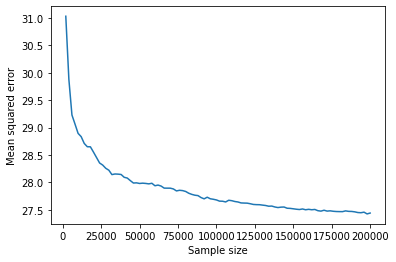

In [70]:
sample_size_ensembles(X_crafted, y_crafted, params_gbdt, "GBDT_SampleSizeTest_Crafted")

[LightGBM] [Info] Total Bins 1166
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 14
[LightGBM] [Info] Start training from score 4.151500
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 3.95873	Validation error's l2: 39.3624
[10]	Train error's l2: 2.56317	Validation error's l2: 34.6188
[15]	Train error's l2: 2.04628	Validation error's l2: 33.4749
[20]	Train error's l2: 1.91672	Validation error's l2: 33.0036
[25]	Train error's l2: 1.80442	Validation error's l2: 32.7937
[30]	Train error's l2: 1.69344	Validation error's l2: 32.6815
[35]	Train error's l2: 1.60275	Validation error's l2: 32.5314
[40]	Train error's l2: 1.52666	Validation error's l2: 32.3044
[45]	Train error's l2: 1.49411	Validation error's l2: 32.1396
[50]	Train error's l2: 1.47299	Validation error's l2: 32.0973
[55]	Train error's l2: 1.47753	Validation error's l2: 32.0455
[60]	Train error's l2: 1.44536	Validation error's l2: 31.96
[65]	Train error's 

[60]	Train error's l2: 5.4829	Validation error's l2: 30.0932
[65]	Train error's l2: 5.46155	Validation error's l2: 30.0744
[70]	Train error's l2: 5.44795	Validation error's l2: 30.0793
[75]	Train error's l2: 5.43273	Validation error's l2: 30.0287
[80]	Train error's l2: 5.43973	Validation error's l2: 30.031
[85]	Train error's l2: 5.43986	Validation error's l2: 30.0347
[90]	Train error's l2: 5.42963	Validation error's l2: 30.0416
[95]	Train error's l2: 5.42188	Validation error's l2: 30.0254
[100]	Train error's l2: 5.39912	Validation error's l2: 30.0112
[105]	Train error's l2: 5.3806	Validation error's l2: 30.0035
[110]	Train error's l2: 5.37411	Validation error's l2: 30.0119
[115]	Train error's l2: 5.37264	Validation error's l2: 30.0002
[120]	Train error's l2: 5.37232	Validation error's l2: 29.9871
[125]	Train error's l2: 5.3698	Validation error's l2: 29.9784
[130]	Train error's l2: 5.37222	Validation error's l2: 29.9635
[135]	Train error's l2: 5.36907	Validation error's l2: 29.9582
[140

[70]	Train error's l2: 9.64161	Validation error's l2: 29.353
[75]	Train error's l2: 9.62446	Validation error's l2: 29.3164
[80]	Train error's l2: 9.63821	Validation error's l2: 29.3223
[85]	Train error's l2: 9.63283	Validation error's l2: 29.3292
[90]	Train error's l2: 9.62125	Validation error's l2: 29.3419
[95]	Train error's l2: 9.60623	Validation error's l2: 29.3195
Early stopping, best iteration is:
[75]	Train error's l2: 9.62446	Validation error's l2: 29.3164
[LightGBM] [Info] Total Bins 1173
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 14
[LightGBM] [Info] Start training from score 4.182688
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 12.4825	Validation error's l2: 32.7612
[10]	Train error's l2: 11.4204	Validation error's l2: 30.7065
[15]	Train error's l2: 11.0047	Validation error's l2: 30.2075
[20]	Train error's l2: 10.9598	Validation error's l2: 29.8274
[25]	Train error's l2: 10.987	Validation err

[30]	Train error's l2: 14.1973	Validation error's l2: 29.2294
[35]	Train error's l2: 14.1283	Validation error's l2: 29.2125
[40]	Train error's l2: 14.0776	Validation error's l2: 29.1197
[45]	Train error's l2: 14.0781	Validation error's l2: 29.0751
[50]	Train error's l2: 14.0164	Validation error's l2: 29.0691
[55]	Train error's l2: 14.003	Validation error's l2: 29.0558
[60]	Train error's l2: 13.9846	Validation error's l2: 29.012
[65]	Train error's l2: 13.9682	Validation error's l2: 29.0091
[70]	Train error's l2: 13.9607	Validation error's l2: 28.9946
[75]	Train error's l2: 13.9489	Validation error's l2: 28.9806
[80]	Train error's l2: 13.9764	Validation error's l2: 29.0035
[85]	Train error's l2: 13.9773	Validation error's l2: 29.0122
[90]	Train error's l2: 13.9777	Validation error's l2: 29.0117
[95]	Train error's l2: 13.9714	Validation error's l2: 28.9861
Early stopping, best iteration is:
[75]	Train error's l2: 13.9489	Validation error's l2: 28.9806
[LightGBM] [Info] Total Bins 1176
[Li

[10]	Train error's l2: 17.1796	Validation error's l2: 29.5351
[15]	Train error's l2: 16.8252	Validation error's l2: 29.1397
[20]	Train error's l2: 16.8265	Validation error's l2: 28.9427
[25]	Train error's l2: 16.8702	Validation error's l2: 28.8051
[30]	Train error's l2: 16.8313	Validation error's l2: 28.7595
[35]	Train error's l2: 16.7655	Validation error's l2: 28.7287
[40]	Train error's l2: 16.726	Validation error's l2: 28.6512
[45]	Train error's l2: 16.7419	Validation error's l2: 28.6251
[50]	Train error's l2: 16.6904	Validation error's l2: 28.5987
[55]	Train error's l2: 16.6822	Validation error's l2: 28.5939
[60]	Train error's l2: 16.6793	Validation error's l2: 28.5623
[65]	Train error's l2: 16.6667	Validation error's l2: 28.562
[70]	Train error's l2: 16.6599	Validation error's l2: 28.5593
[75]	Train error's l2: 16.6335	Validation error's l2: 28.5415
[80]	Train error's l2: 16.6587	Validation error's l2: 28.5573
[85]	Train error's l2: 16.6613	Validation error's l2: 28.5708
[90]	Train

[65]	Train error's l2: 18.4206	Validation error's l2: 28.433
[70]	Train error's l2: 18.4111	Validation error's l2: 28.4317
[75]	Train error's l2: 18.3898	Validation error's l2: 28.4201
[80]	Train error's l2: 18.423	Validation error's l2: 28.4382
[85]	Train error's l2: 18.4323	Validation error's l2: 28.4564
[90]	Train error's l2: 18.4289	Validation error's l2: 28.4523
Early stopping, best iteration is:
[74]	Train error's l2: 18.3939	Validation error's l2: 28.4196
[LightGBM] [Info] Total Bins 1177
[LightGBM] [Info] Number of data points in the train set: 46000, number of used features: 14
[LightGBM] [Info] Start training from score 4.198783
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 19.9164	Validation error's l2: 30.5479
[10]	Train error's l2: 19.1171	Validation error's l2: 29.3285
[15]	Train error's l2: 18.8317	Validation error's l2: 28.9543
[20]	Train error's l2: 18.865	Validation error's l2: 28.7749
[25]	Train error's l2: 18.9249	Validation erro

[5]	Train error's l2: 21.0196	Validation error's l2: 30.2619
[10]	Train error's l2: 20.24	Validation error's l2: 29.1258
[15]	Train error's l2: 19.9631	Validation error's l2: 28.7981
[20]	Train error's l2: 19.9793	Validation error's l2: 28.6673
[25]	Train error's l2: 20.0182	Validation error's l2: 28.6264
[30]	Train error's l2: 19.9837	Validation error's l2: 28.6015
[35]	Train error's l2: 19.9271	Validation error's l2: 28.5809
[40]	Train error's l2: 19.8812	Validation error's l2: 28.4992
[45]	Train error's l2: 19.889	Validation error's l2: 28.4641
[50]	Train error's l2: 19.8389	Validation error's l2: 28.4438
[55]	Train error's l2: 19.8317	Validation error's l2: 28.4425
[60]	Train error's l2: 19.8226	Validation error's l2: 28.4129
[65]	Train error's l2: 19.8157	Validation error's l2: 28.4175
[70]	Train error's l2: 19.8128	Validation error's l2: 28.4167
[75]	Train error's l2: 19.7955	Validation error's l2: 28.4002
[80]	Train error's l2: 19.8227	Validation error's l2: 28.4251
[85]	Train e

[65]	Train error's l2: 20.719	Validation error's l2: 28.3075
[70]	Train error's l2: 20.7085	Validation error's l2: 28.3071
[75]	Train error's l2: 20.6925	Validation error's l2: 28.2891
[80]	Train error's l2: 20.7203	Validation error's l2: 28.3047
[85]	Train error's l2: 20.7256	Validation error's l2: 28.3174
[90]	Train error's l2: 20.7244	Validation error's l2: 28.3226
[95]	Train error's l2: 20.7159	Validation error's l2: 28.3074
Early stopping, best iteration is:
[75]	Train error's l2: 20.6925	Validation error's l2: 28.2891
[LightGBM] [Info] Total Bins 1178
[LightGBM] [Info] Number of data points in the train set: 68000, number of used features: 14
[LightGBM] [Info] Start training from score 4.189765
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 21.978	Validation error's l2: 29.8297
[10]	Train error's l2: 21.181	Validation error's l2: 28.844
[15]	Train error's l2: 20.9449	Validation error's l2: 28.6033
[20]	Train error's l2: 20.9952	Validation error

[5]	Train error's l2: 22.641	Validation error's l2: 29.6887
[10]	Train error's l2: 21.8731	Validation error's l2: 28.6882
[15]	Train error's l2: 21.6396	Validation error's l2: 28.4795
[20]	Train error's l2: 21.6797	Validation error's l2: 28.4031
[25]	Train error's l2: 21.7547	Validation error's l2: 28.3885
[30]	Train error's l2: 21.7243	Validation error's l2: 28.3711
[35]	Train error's l2: 21.6845	Validation error's l2: 28.3603
[40]	Train error's l2: 21.6408	Validation error's l2: 28.2922
[45]	Train error's l2: 21.6421	Validation error's l2: 28.2738
[50]	Train error's l2: 21.5966	Validation error's l2: 28.2499
[55]	Train error's l2: 21.5872	Validation error's l2: 28.2532
[60]	Train error's l2: 21.5693	Validation error's l2: 28.2326
[65]	Train error's l2: 21.5684	Validation error's l2: 28.2399
[70]	Train error's l2: 21.5594	Validation error's l2: 28.2381
[75]	Train error's l2: 21.547	Validation error's l2: 28.2207
[80]	Train error's l2: 21.5748	Validation error's l2: 28.2417
[85]	Train 

[90]	Train error's l2: 22.0747	Validation error's l2: 28.206
[95]	Train error's l2: 22.0631	Validation error's l2: 28.1887
Early stopping, best iteration is:
[75]	Train error's l2: 22.0391	Validation error's l2: 28.1635
[LightGBM] [Info] Total Bins 1179
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 14
[LightGBM] [Info] Start training from score 4.177800
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 23.178	Validation error's l2: 29.4195
[10]	Train error's l2: 22.4217	Validation error's l2: 28.5332
[15]	Train error's l2: 22.2162	Validation error's l2: 28.3433
[20]	Train error's l2: 22.2521	Validation error's l2: 28.2971
[25]	Train error's l2: 22.3055	Validation error's l2: 28.3048
[30]	Train error's l2: 22.2846	Validation error's l2: 28.2816
[35]	Train error's l2: 22.2461	Validation error's l2: 28.269
[40]	Train error's l2: 22.1994	Validation error's l2: 28.201
[45]	Train error's l2: 22.2018	Validation error

[25]	Train error's l2: 22.7651	Validation error's l2: 28.2499
[30]	Train error's l2: 22.7392	Validation error's l2: 28.2201
[35]	Train error's l2: 22.7013	Validation error's l2: 28.2139
[40]	Train error's l2: 22.6663	Validation error's l2: 28.1431
[45]	Train error's l2: 22.6727	Validation error's l2: 28.1462
[50]	Train error's l2: 22.6266	Validation error's l2: 28.1173
[55]	Train error's l2: 22.6208	Validation error's l2: 28.1257
[60]	Train error's l2: 22.6145	Validation error's l2: 28.1123
[65]	Train error's l2: 22.6139	Validation error's l2: 28.1151
[70]	Train error's l2: 22.6147	Validation error's l2: 28.117
[75]	Train error's l2: 22.5995	Validation error's l2: 28.0994
[80]	Train error's l2: 22.6219	Validation error's l2: 28.1225
[85]	Train error's l2: 22.6299	Validation error's l2: 28.1368
[90]	Train error's l2: 22.6337	Validation error's l2: 28.1454
[95]	Train error's l2: 22.6233	Validation error's l2: 28.1324
Early stopping, best iteration is:
[75]	Train error's l2: 22.5995	Valid

[LightGBM] [Info] Total Bins 1179
[LightGBM] [Info] Number of data points in the train set: 112000, number of used features: 14
[LightGBM] [Info] Start training from score 4.186438
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 24.0331	Validation error's l2: 29.1747
[10]	Train error's l2: 23.3466	Validation error's l2: 28.4215
[15]	Train error's l2: 23.1632	Validation error's l2: 28.2177
[20]	Train error's l2: 23.1873	Validation error's l2: 28.1761
[25]	Train error's l2: 23.2499	Validation error's l2: 28.1941
[30]	Train error's l2: 23.2235	Validation error's l2: 28.1796
[35]	Train error's l2: 23.1836	Validation error's l2: 28.1741
[40]	Train error's l2: 23.1364	Validation error's l2: 28.1008
[45]	Train error's l2: 23.1502	Validation error's l2: 28.1041
[50]	Train error's l2: 23.1082	Validation error's l2: 28.0808
[55]	Train error's l2: 23.0959	Validation error's l2: 28.0855
[60]	Train error's l2: 23.0938	Validation error's l2: 28.0652
[65]	Train erro

[45]	Train error's l2: 23.425	Validation error's l2: 28.0746
[50]	Train error's l2: 23.3825	Validation error's l2: 28.0402
[55]	Train error's l2: 23.3745	Validation error's l2: 28.0397
[60]	Train error's l2: 23.3663	Validation error's l2: 28.0222
[65]	Train error's l2: 23.3655	Validation error's l2: 28.0244
[70]	Train error's l2: 23.3645	Validation error's l2: 28.0277
[75]	Train error's l2: 23.353	Validation error's l2: 28.0133
[80]	Train error's l2: 23.3773	Validation error's l2: 28.0417
[85]	Train error's l2: 23.388	Validation error's l2: 28.0613
[90]	Train error's l2: 23.3946	Validation error's l2: 28.0674
[95]	Train error's l2: 23.3864	Validation error's l2: 28.0569
Early stopping, best iteration is:
[75]	Train error's l2: 23.353	Validation error's l2: 28.0133
[LightGBM] [Info] Total Bins 1180
[LightGBM] [Info] Number of data points in the train set: 124000, number of used features: 14
[LightGBM] [Info] Start training from score 4.177798
Training until validation scores don't impro

[LightGBM] [Info] Total Bins 1180
[LightGBM] [Info] Number of data points in the train set: 134000, number of used features: 14
[LightGBM] [Info] Start training from score 4.176090
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 24.4679	Validation error's l2: 28.9863
[10]	Train error's l2: 23.8101	Validation error's l2: 28.2925
[15]	Train error's l2: 23.6698	Validation error's l2: 28.1192
[20]	Train error's l2: 23.7128	Validation error's l2: 28.0874
[25]	Train error's l2: 23.7592	Validation error's l2: 28.1021
[30]	Train error's l2: 23.7446	Validation error's l2: 28.0906
[35]	Train error's l2: 23.7085	Validation error's l2: 28.0799
[40]	Train error's l2: 23.6727	Validation error's l2: 28.0192
[45]	Train error's l2: 23.6791	Validation error's l2: 28.0327
[50]	Train error's l2: 23.6386	Validation error's l2: 28.0032
[55]	Train error's l2: 23.6284	Validation error's l2: 28.0093
[60]	Train error's l2: 23.6182	Validation error's l2: 27.9914
[65]	Train erro

[45]	Train error's l2: 23.9233	Validation error's l2: 28.0483
[50]	Train error's l2: 23.8826	Validation error's l2: 28.0173
[55]	Train error's l2: 23.8726	Validation error's l2: 28.0201
[60]	Train error's l2: 23.8638	Validation error's l2: 28.0045
[65]	Train error's l2: 23.8652	Validation error's l2: 28.0073
[70]	Train error's l2: 23.8621	Validation error's l2: 28.0116
[75]	Train error's l2: 23.8506	Validation error's l2: 27.9882
[80]	Train error's l2: 23.8722	Validation error's l2: 28.0103
[85]	Train error's l2: 23.8808	Validation error's l2: 28.0248
[90]	Train error's l2: 23.8899	Validation error's l2: 28.0334
[95]	Train error's l2: 23.8794	Validation error's l2: 28.0215
Early stopping, best iteration is:
[75]	Train error's l2: 23.8506	Validation error's l2: 27.9882
[LightGBM] [Info] Total Bins 1180
[LightGBM] [Info] Number of data points in the train set: 146000, number of used features: 14
[LightGBM] [Info] Start training from score 4.169753
Training until validation scores don't i

[5]	Train error's l2: 24.8588	Validation error's l2: 28.8668
[10]	Train error's l2: 24.2596	Validation error's l2: 28.2174
[15]	Train error's l2: 24.1074	Validation error's l2: 28.0664
[20]	Train error's l2: 24.1475	Validation error's l2: 28.051
[25]	Train error's l2: 24.2141	Validation error's l2: 28.0958
[30]	Train error's l2: 24.2037	Validation error's l2: 28.0783
[35]	Train error's l2: 24.1758	Validation error's l2: 28.0731
[40]	Train error's l2: 24.1392	Validation error's l2: 28.0137
[45]	Train error's l2: 24.1517	Validation error's l2: 28.0218
[50]	Train error's l2: 24.1115	Validation error's l2: 27.99
[55]	Train error's l2: 24.106	Validation error's l2: 27.9892
[60]	Train error's l2: 24.0985	Validation error's l2: 27.9686
[65]	Train error's l2: 24.102	Validation error's l2: 27.972
[70]	Train error's l2: 24.1016	Validation error's l2: 27.9794
[75]	Train error's l2: 24.092	Validation error's l2: 27.9586
[80]	Train error's l2: 24.115	Validation error's l2: 27.9847
[85]	Train error'

[95]	Train error's l2: 24.2802	Validation error's l2: 27.9665
Early stopping, best iteration is:
[75]	Train error's l2: 24.2535	Validation error's l2: 27.9337
[LightGBM] [Info] Total Bins 1180
[LightGBM] [Info] Number of data points in the train set: 168000, number of used features: 14
[LightGBM] [Info] Start training from score 4.166524
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 25.07	Validation error's l2: 28.8404
[10]	Train error's l2: 24.4677	Validation error's l2: 28.1676
[15]	Train error's l2: 24.3074	Validation error's l2: 28.0221
[20]	Train error's l2: 24.3367	Validation error's l2: 27.9996
[25]	Train error's l2: 24.4034	Validation error's l2: 28.0335
[30]	Train error's l2: 24.3913	Validation error's l2: 28.0239
[35]	Train error's l2: 24.3597	Validation error's l2: 28.0178
[40]	Train error's l2: 24.3166	Validation error's l2: 27.9652
[45]	Train error's l2: 24.3252	Validation error's l2: 27.9763
[50]	Train error's l2: 24.285	Validation err

[75]	Train error's l2: 24.5063	Validation error's l2: 27.9195
[80]	Train error's l2: 24.5297	Validation error's l2: 27.9443
[85]	Train error's l2: 24.5413	Validation error's l2: 27.9602
[90]	Train error's l2: 24.5486	Validation error's l2: 27.9691
[95]	Train error's l2: 24.5347	Validation error's l2: 27.9563
Early stopping, best iteration is:
[75]	Train error's l2: 24.5063	Validation error's l2: 27.9195
[LightGBM] [Info] Total Bins 1180
[LightGBM] [Info] Number of data points in the train set: 180000, number of used features: 14
[LightGBM] [Info] Start training from score 4.168856
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 25.2953	Validation error's l2: 28.8053
[10]	Train error's l2: 24.6975	Validation error's l2: 28.179
[15]	Train error's l2: 24.5552	Validation error's l2: 28.0317
[20]	Train error's l2: 24.5843	Validation error's l2: 28.0013
[25]	Train error's l2: 24.6417	Validation error's l2: 28.0349
[30]	Train error's l2: 24.625	Validation er

[50]	Train error's l2: 24.7697	Validation error's l2: 27.9036
[55]	Train error's l2: 24.7672	Validation error's l2: 27.9069
[60]	Train error's l2: 24.7632	Validation error's l2: 27.8973
[65]	Train error's l2: 24.7702	Validation error's l2: 27.9069
[70]	Train error's l2: 24.7748	Validation error's l2: 27.9115
[75]	Train error's l2: 24.7599	Validation error's l2: 27.8919
[80]	Train error's l2: 24.7822	Validation error's l2: 27.9115
[85]	Train error's l2: 24.7956	Validation error's l2: 27.9264
[90]	Train error's l2: 24.8023	Validation error's l2: 27.9359
[95]	Train error's l2: 24.7894	Validation error's l2: 27.9223
Early stopping, best iteration is:
[75]	Train error's l2: 24.7599	Validation error's l2: 27.8919
[LightGBM] [Info] Total Bins 1180
[LightGBM] [Info] Number of data points in the train set: 194000, number of used features: 14
[LightGBM] [Info] Start training from score 4.170562
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 25.5019	Validation 

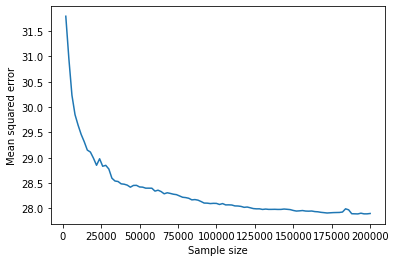

In [67]:
sample_size_ensembles(X_crafted, y_crafted, params_rf, "RF_SampleSizeTest_Crafted")

### Test 1.2: Linear Regression

In [81]:
### Convergence test for Scikit-Learn's Linear Regression ###
def sample_size_lr(X, y, title, start=1000, stop=100000, step=1000):
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8, random_state=42)
    sample_sizes = np.arange(start=start, stop=stop, step=step)
    results = []
    
    for rows in sample_sizes:
        lr = LinearRegression()
        lr.fit(X_train[:rows], y_train[:rows])
        mse = mean_squared_error(y_test, lr.predict(X_test))
        print(f"Sample size - error : {rows} - {mse}")
        results.append(mse)
    plot_convergence(sample_sizes, results, title)

Sample size - error : 1000 - 37.50497055053711
Sample size - error : 2000 - 35.35260009765625
Sample size - error : 3000 - 34.40842056274414
Sample size - error : 4000 - 52.334896087646484
Sample size - error : 5000 - 32.46792221069336
Sample size - error : 6000 - 31.8137149810791
Sample size - error : 7000 - 31.049558639526367
Sample size - error : 8000 - 31.14853286743164
Sample size - error : 9000 - 31.00687026977539
Sample size - error : 10000 - 31.02054786682129
Sample size - error : 11000 - 31.211185455322266
Sample size - error : 12000 - 31.001482009887695
Sample size - error : 13000 - 30.838653564453125
Sample size - error : 14000 - 30.891538619995117
Sample size - error : 15000 - 30.76746940612793
Sample size - error : 16000 - 30.70929527282715
Sample size - error : 17000 - 30.70697021484375
Sample size - error : 18000 - 30.699813842773438
Sample size - error : 19000 - 30.681949615478516
Sample size - error : 20000 - 30.660472869873047
Sample size - error : 21000 - 30.66489982

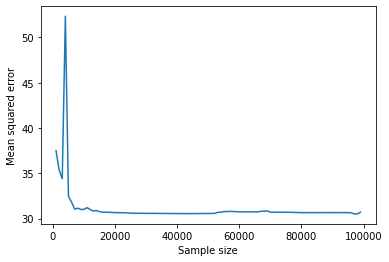

In [82]:
sample_size_lr(X_raw, y_raw, "LR_SampleSize_Raw")

Sample size - error : 1000 - 32.013851165771484
Sample size - error : 2000 - 31.576719284057617
Sample size - error : 3000 - 31.49754524230957
Sample size - error : 4000 - 31.537202835083008
Sample size - error : 5000 - 31.530109405517578
Sample size - error : 6000 - 31.49772834777832
Sample size - error : 7000 - 31.490310668945312
Sample size - error : 8000 - 31.486736297607422
Sample size - error : 9000 - 31.489288330078125
Sample size - error : 10000 - 31.482444763183594
Sample size - error : 11000 - 31.4780216217041
Sample size - error : 12000 - 31.480331420898438
Sample size - error : 13000 - 31.48769760131836
Sample size - error : 14000 - 31.483068466186523
Sample size - error : 15000 - 31.481718063354492
Sample size - error : 16000 - 31.47732925415039
Sample size - error : 17000 - 31.48045539855957
Sample size - error : 18000 - 31.479341506958008
Sample size - error : 19000 - 31.47994041442871
Sample size - error : 20000 - 31.481239318847656
Sample size - error : 21000 - 31.4796

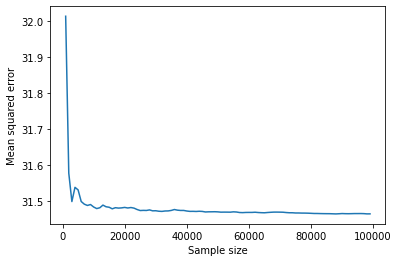

In [83]:
sample_size_lr(X_crafted, y_crafted, "LR_SampleSize_Crafted")

### Test 1.3: Neural Network

In [9]:
def sample_size_nn(data, sample_sizes):

    sample_sizes = sample_sizes
    results = []

    n_features = len(data.columns) - 1
    n_hidden = math.ceil(n_features * (1 / 2))
    n_code = math.ceil(n_hidden * (1 / 2))
    
    slp = Regressor(n_features = n_features, n_hidden = n_hidden, n_output = 1)
    
    params = {
        "patience" : 50,
        "criterion" : nn.MSELoss(),
        "optimizer" : optim.Adam(slp.parameters(), lr=0.0005),
        "epochs" : 500,
        "batch_size" : 50,
    }
    
    for rows in sample_sizes:
        model, mse = nn_train(
            model=slp, 
            data=data, 
            params=params,
            rows=rows
        )
        results.append(mse)
        print(f"Mean squared error: {mse} for sample size: {rows}")
    plot_convergence(sample_sizes, results, "nn_sample_size")

In [10]:
sample_sizes = [100000,200000,500000]
sample_size_nn(data=crafted, sample_sizes=sample_sizes)

14
7


TypeError: new() received an invalid combination of arguments - got (float, int), but expected one of:
 * (*, torch.device device)
      didn't match because some of the arguments have invalid types: ([31;1mfloat[0m, [31;1mint[0m)
 * (torch.Storage storage)
 * (Tensor other)
 * (tuple of ints size, *, torch.device device)
 * (object data, *, torch.device device)


## Part 2: Hyperparameter optimization (HPO)

### Helper functions

In [3]:
def print_results(study):
    print("Number of finished trials: {}".format(len(study.trials)))
    print("Best trial:")
    trial = study.best_trial
    print("Value: {}".format(trial.value))
    print("Params: ")
    for key, value in trial.params.items():
        print("{}: {}".format(key, value))  

### HPO for Ensembles

In [238]:
sample_size=200000
X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, train_size=0.8, random_state=42)
train_set = lgb.Dataset(X_train[:sample_size],y_train[:sample_size])
valid_set = lgb.Dataset(X_test, y_test)

params = {
    "boosting_type" : "rf",
    "metric" : "l2",
    "n_estimators" : 1000,
    "early_stopping" : 20,
    'max_depth': 52, 
    'feature_fraction': 0.8700000000000001,
    'feature_fraction_bynode': 0.8600000000000001, 
    'subsample': 0.99,
    'subsample_freq': 5,
    'num_leaves': 900,
    'min_child_samples': 205,
    "max_bin" : 1000,
    "min_data_in_bin" : 1,
    "random_state" : 42,
    
}

evals_result = {}

bst = lgb.train(
    params,
    train_set=train_set,
    valid_sets=[valid_set],
    valid_names=["Validation error", "Train error"],
    verbose_eval=1,
    evals_result = evals_result
)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40674
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 89
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	Validation error's l2: 28.8479
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	Validation error's l2: 28.0756
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	Validation error's l2: 27.8598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	Validation error's l2: 27.6293
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	Validatio

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[71]	Validation error's l2: 27.3241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[72]	Validation error's l2: 27.3233
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[73]	Validation error's l2: 27.3275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[74]	Validation error's l2: 27.3262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[75]	Validation error's l2: 27.3247
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[76]	Validation error's l2: 27.3231
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[77]	Validation error's l2: 27.3193
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[78]	Validation error's l2: 27.3181
Early stopping, best iteration is:
[58]	Validation error's l2: 27.3086


In [212]:
def hpo_trees(trial, X, y, mode, sample_size=200000):
    
    sample_size=sample_size
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
    train_set = lgb.Dataset(X_train[:sample_size],y_train[:sample_size])
    valid_set = lgb.Dataset(X_test, y_test)

    if mode == "gbdt":
        params = {
            "boosting_type" : "gbdt",
            "metric" : "l2",
            "objective" : "regression",
            "n_estimators": 1000,
            "max_depth" : trial.suggest_int("max_depth", 5, 100),
            "learning_rate" : trial.suggest_float("learning_rate", 0.01, 0.05, step=0.001),
            "feature_fraction" : trial.suggest_float("feature_fraction", 0.1, 1.0, step=0.01),
            "feature_fraction_bynode" : trial.suggest_float("feature_fraction_bynode", 0.3, 1.0, step=0.01),
            "num_leaves" : trial.suggest_int("num_leaves", 20, 300),
            "min_child_samples" : trial.suggest_int("min_child_samples", 10, 400),
            "subsample_freq" : trial.suggest_int("subsample_freq", 1, 10, step=1),
            "subsample" : trial.suggest_float("subsample", 0.3, 1.0, step=0.01),
            "max_bin" : 1000,
            "feature_pre_filter" : False,
            "num_threads"  : 6,
            "random_state" : 42,
            "force_row_wise" : True, 
            "early_stopping" : 20,
        }
    else:
        params = {
            "boosting_type" : "rf",
            "metric" : "l2", 
            "objective" : "regression",
            "n_estimators" : 1000,
            "max_depth" : trial.suggest_int("max_depth", 5, 100),
            "feature_fraction" : trial.suggest_float("feature_fraction", 0.30, 0.99, step=0.01),
            "feature_fraction_bynode" : trial.suggest_float("feature_fraction_bynode", 0.3, 1.0, step=0.01),
            "feature_pre_filter" : False,
            "subsample" : trial.suggest_float("subsample", 0.30, 0.99, step=0.01), 
            "subsample_freq" : trial.suggest_int("subsample_freq", 1, 10),
            "num_leaves" : trial.suggest_int("num_leaves", 600, 1200),
            "min_child_samples" : trial.suggest_int("min_child_samples", 10, 400),
            "max_bin" : 1000,
            "min_data_in_bin" : 1,
            "num_threads"  : 6,
            "random_state" : 42,
            "force_row_wise" : True, 
            "early_stopping" : 20,
        }
    evals_result = {}
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "l2")
    lgb.train(
        params,
        train_set=train_set,
        valid_sets=[valid_set],
        verbose_eval=0,
        evals_result = evals_result,
        callbacks=[pruning_callback]
    )

    best_mse = best_iteration(evals_result["valid_0"]["l2"])
    return best_mse

In [243]:
gbdt_raw_optuna = optuna.create_study(
    direction="minimize", 
    sampler=optuna.samplers.CmaEsSampler(seed=42),
    pruner=optuna.pruners.HyperbandPruner()
)
gbdt_raw_optuna.optimize(lambda trial: hpo_trees(trial, X_raw, y_raw, "gbdt"), n_trials=100)

joblib.dump(gbdt_raw_optuna, "optunaStudies/gbdt_raw_optuna.pkl")

print_results(gbdt_raw_optuna)

[I 2021-02-05 18:16:38,616] A new study created in memory with name: no-name-3c6b9afa-deab-4af4-b2ab-76050959ad53


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:16:53,406] Trial 0 finished with value: 25.99924776168702 and parameters: {'max_depth': 56, 'learning_rate': 0.048, 'feature_fraction': 0.76, 'feature_fraction_bynode': 0.72, 'num_leaves': 122, 'min_child_samples': 131, 'sumbsample_freq': 3, 'subsample': 0.37}. Best is trial 0 with value: 25.99924776168702.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:17:22,398] Trial 1 finished with value: 25.696462051938067 and parameters: {'max_depth': 52, 'learning_rate': 0.03, 'feature_fraction': 0.65, 'feature_fraction_bynode': 0.94, 'num_leaves': 160, 'min_child_samples': 205, 'sumbsample_freq': 5, 'subsample': 0.94}. Best is trial 1 with value: 25.696462051938067.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:17:54,373] Trial 2 finished with value: 25.67324072576271 and parameters: {'max_depth': 53, 'learning_rate': 0.031, 'feature_fraction': 0.65, 'feature_fraction_bynode': 0.94, 'num_leaves': 160, 'min_child_samples': 205, 'sumbsample_freq': 6, 'subsample': 0.95}. Best is trial 2 with value: 25.67324072576271.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:18:20,961] Trial 3 finished with value: 25.791821014230887 and parameters: {'max_depth': 79, 'learning_rate': 0.045000000000000005, 'feature_fraction': 0.64, 'feature_fraction_bynode': 0.8, 'num_leaves': 169, 'min_child_samples': 318, 'sumbsample_freq': 2, 'subsample': 0.81}. Best is trial 2 with value: 25.67324072576271.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:18:44,467] Trial 4 finished with value: 25.724290910128197 and parameters: {'max_depth': 52, 'learning_rate': 0.045000000000000005, 'feature_fraction': 0.65, 'feature_fraction_bynode': 0.95, 'num_leaves': 160, 'min_child_samples': 205, 'sumbsample_freq': 6, 'subsample': 0.95}. Best is trial 2 with value: 25.67324072576271.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:18:46,201] Trial 5 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-05 18:18:47,659] Trial 6 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-05 18:18:49,145] Trial 7 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-05 18:18:50,724] Trial 8 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:18:52,382] Trial 9 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:18:54,011] Trial 10 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:19:12,930] Trial 11 finished with value: 26.36730391072015 and parameters: {'max_depth': 34, 'learning_rate': 0.018000000000000002, 'feature_fraction': 0.26, 'feature_fraction_bynode': 0.43, 'num_leaves': 41, 'min_child_samples': 262, 'sumbsample_freq': 9, 'subsample': 0.5}. Best is trial 2 with value: 25.67324072576271.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:19:16,242] Trial 12 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2021-02-05 18:19:56,875] Trial 13 finished with value: 26.329806409770487 and parameters: {'max_depth': 63, 'learning_rate': 0.026000000000000002, 'feature_fraction': 0.14, 'feature_fraction_bynode': 0.99, 'num_leaves': 290, 'min_child_samples': 199, 'sumbsample_freq': 3, 'subsample': 0.5700000000000001}. Best is trial 2 with value: 25.67324072576271.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:20:17,972] Trial 14 finished with value: 25.7038750593864 and parameters: {'max_depth': 52, 'learning_rate': 0.048, 'feature_fraction': 0.64, 'feature_fraction_bynode': 0.96, 'num_leaves': 160, 'min_child_samples': 205, 'sumbsample_freq': 6, 'subsample': 0.94}. Best is trial 2 with value: 25.67324072576271.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:20:19,682] Trial 15 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-05 18:20:21,148] Trial 16 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:20:43,726] Trial 17 finished with value: 25.72220100453942 and parameters: {'max_depth': 52, 'learning_rate': 0.046000000000000006, 'feature_fraction': 0.64, 'feature_fraction_bynode': 0.96, 'num_leaves': 160, 'min_child_samples': 205, 'sumbsample_freq': 6, 'subsample': 0.95}. Best is trial 2 with value: 25.67324072576271.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:21:06,678] Trial 18 finished with value: 25.728889966756775 and parameters: {'max_depth': 53, 'learning_rate': 0.047, 'feature_fraction': 0.65, 'feature_fraction_bynode': 0.95, 'num_leaves': 160, 'min_child_samples': 205, 'sumbsample_freq': 5, 'subsample': 0.96}. Best is trial 2 with value: 25.67324072576271.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-05 18:21:08,215] Trial 19 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:21:09,811] Trial 20 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:21:11,403] Trial 21 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-05 18:21:12,910] Trial 22 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:21:14,993] Trial 23 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-05 18:21:16,420] Trial 24 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-05 18:21:17,906] Trial 25 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-05 18:21:19,425] Trial 26 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-05 18:21:20,899] Trial 27 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:21:22,468] Trial 28 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-05 18:21:24,036] Trial 29 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:21:30,745] Trial 30 pruned. Trial was pruned at iteration 81.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-05 18:21:32,250] Trial 31 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:21:33,835] Trial 32 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:21:35,434] Trial 33 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:21:54,653] Trial 34 finished with value: 25.72262750025697 and parameters: {'max_depth': 53, 'learning_rate': 0.046000000000000006, 'feature_fraction': 0.66, 'feature_fraction_bynode': 0.94, 'num_leaves': 160, 'min_child_samples': 205, 'sumbsample_freq': 5, 'subsample': 0.97}. Best is trial 2 with value: 25.67324072576271.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:21:56,243] Trial 35 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-05 18:21:57,711] Trial 36 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:21:59,772] Trial 37 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:22:01,768] Trial 38 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:22:18,313] Trial 39 pruned. Trial was pruned at iteration 243.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:22:19,944] Trial 40 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:22:21,924] Trial 41 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:23:03,316] Trial 42 finished with value: 25.6893937737575 and parameters: {'max_depth': 68, 'learning_rate': 0.028999999999999998, 'feature_fraction': 0.88, 'feature_fraction_bynode': 0.78, 'num_leaves': 186, 'min_child_samples': 283, 'sumbsample_freq': 4, 'subsample': 0.96}. Best is trial 2 with value: 25.67324072576271.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:23:04,988] Trial 43 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:23:11,961] Trial 44 pruned. Trial was pruned at iteration 81.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-05 18:23:13,442] Trial 45 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:23:15,463] Trial 46 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-05 18:23:16,916] Trial 47 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-05 18:23:18,339] Trial 48 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:23:19,958] Trial 49 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-05 18:23:21,604] Trial 50 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:23:23,196] Trial 51 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-05 18:23:24,718] Trial 52 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-05 18:23:26,209] Trial 53 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:23:29,458] Trial 54 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-05 18:23:30,927] Trial 55 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:23:32,529] Trial 56 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-05 18:23:33,988] Trial 57 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-05 18:23:35,461] Trial 58 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:23:58,260] Trial 59 finished with value: 25.72322860741928 and parameters: {'max_depth': 53, 'learning_rate': 0.038, 'feature_fraction': 0.65, 'feature_fraction_bynode': 0.94, 'num_leaves': 160, 'min_child_samples': 205, 'sumbsample_freq': 6, 'subsample': 0.95}. Best is trial 2 with value: 25.67324072576271.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:24:17,293] Trial 60 finished with value: 25.728079232044937 and parameters: {'max_depth': 52, 'learning_rate': 0.05, 'feature_fraction': 0.63, 'feature_fraction_bynode': 0.95, 'num_leaves': 160, 'min_child_samples': 205, 'sumbsample_freq': 5, 'subsample': 0.96}. Best is trial 2 with value: 25.67324072576271.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:24:18,853] Trial 61 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-05 18:24:20,356] Trial 62 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-05 18:24:21,779] Trial 63 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-05 18:24:23,225] Trial 64 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:24:24,962] Trial 65 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:24:31,841] Trial 66 pruned. Trial was pruned at iteration 81.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:24:33,439] Trial 67 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-05 18:24:34,941] Trial 68 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:24:36,460] Trial 69 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:24:39,714] Trial 70 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:25:04,567] Trial 71 finished with value: 25.703174698997994 and parameters: {'max_depth': 53, 'learning_rate': 0.039, 'feature_fraction': 0.66, 'feature_fraction_bynode': 0.95, 'num_leaves': 160, 'min_child_samples': 205, 'sumbsample_freq': 6, 'subsample': 0.94}. Best is trial 2 with value: 25.67324072576271.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-05 18:25:06,083] Trial 72 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:25:08,154] Trial 73 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-05 18:25:09,641] Trial 74 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:25:11,263] Trial 75 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:25:12,868] Trial 76 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:25:14,407] Trial 77 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-05 18:25:15,847] Trial 78 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-05 18:25:17,356] Trial 79 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:25:38,295] Trial 80 finished with value: 25.734265505285585 and parameters: {'max_depth': 52, 'learning_rate': 0.048, 'feature_fraction': 0.66, 'feature_fraction_bynode': 0.96, 'num_leaves': 160, 'min_child_samples': 205, 'sumbsample_freq': 5, 'subsample': 0.95}. Best is trial 2 with value: 25.67324072576271.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:25:54,728] Trial 81 pruned. Trial was pruned at iteration 243.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:25:58,061] Trial 82 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:26:00,066] Trial 83 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-05 18:26:01,576] Trial 84 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:26:03,161] Trial 85 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-05 18:26:04,747] Trial 86 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:26:06,389] Trial 87 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-05 18:26:07,920] Trial 88 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:26:09,698] Trial 89 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:26:12,899] Trial 90 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:26:32,581] Trial 91 finished with value: 25.732318033694536 and parameters: {'max_depth': 53, 'learning_rate': 0.05, 'feature_fraction': 0.66, 'feature_fraction_bynode': 0.95, 'num_leaves': 160, 'min_child_samples': 205, 'sumbsample_freq': 6, 'subsample': 0.95}. Best is trial 2 with value: 25.67324072576271.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:26:39,225] Trial 92 pruned. Trial was pruned at iteration 81.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:26:41,331] Trial 93 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:26:48,245] Trial 94 pruned. Trial was pruned at iteration 81.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:26:49,835] Trial 95 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-05 18:26:51,282] Trial 96 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-05 18:26:52,734] Trial 97 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-05 18:26:54,249] Trial 98 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:26:56,291] Trial 99 pruned. Trial was pruned at iteration 9.


Number of finished trials: 100
Best trial:
Value: 25.67324072576271
Params: 
max_depth: 53
learning_rate: 0.031
feature_fraction: 0.65
feature_fraction_bynode: 0.94
num_leaves: 160
min_child_samples: 205
sumbsample_freq: 6
subsample: 0.95


In [244]:
gbdt_crafted_optuna = optuna.create_study(
    direction="minimize", 
    sampler=optuna.samplers.CmaEsSampler(seed=42),
    pruner=optuna.pruners.HyperbandPruner()
)
gbdt_crafted_optuna.optimize(lambda trial: hpo_trees(trial, X_crafted, y_crafted, "gbdt"), n_trials=100)

joblib.dump(gbdt_crafted_optuna, "optunaStudies/gbdt_crafted_optuna.pkl")

print_results(gbdt_crafted_optuna)

[I 2021-02-05 18:26:56,381] A new study created in memory with name: no-name-dbc08d6b-ea3e-43f8-8a59-619e5b74f507


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:27:00,296] Trial 0 finished with value: 27.532633332423543 and parameters: {'max_depth': 56, 'learning_rate': 0.048, 'feature_fraction': 0.76, 'feature_fraction_bynode': 0.72, 'num_leaves': 122, 'min_child_samples': 131, 'sumbsample_freq': 3, 'subsample': 0.37}. Best is trial 0 with value: 27.532633332423543.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:27:06,766] Trial 1 finished with value: 27.3484347358926 and parameters: {'max_depth': 52, 'learning_rate': 0.03, 'feature_fraction': 0.65, 'feature_fraction_bynode': 0.94, 'num_leaves': 160, 'min_child_samples': 205, 'sumbsample_freq': 5, 'subsample': 0.94}. Best is trial 1 with value: 27.3484347358926.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:27:13,605] Trial 2 finished with value: 27.34935557648767 and parameters: {'max_depth': 53, 'learning_rate': 0.031, 'feature_fraction': 0.65, 'feature_fraction_bynode': 0.94, 'num_leaves': 160, 'min_child_samples': 205, 'sumbsample_freq': 6, 'subsample': 0.95}. Best is trial 1 with value: 27.3484347358926.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:27:19,002] Trial 3 finished with value: 27.365229583686435 and parameters: {'max_depth': 52, 'learning_rate': 0.039, 'feature_fraction': 0.66, 'feature_fraction_bynode': 0.95, 'num_leaves': 160, 'min_child_samples': 205, 'sumbsample_freq': 6, 'subsample': 0.96}. Best is trial 1 with value: 27.3484347358926.
[I 2021-02-05 18:27:19,349] Trial 4 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:27:23,729] Trial 5 finished with value: 27.380281626746903 and parameters: {'max_depth': 53, 'learning_rate': 0.049, 'feature_fraction': 0.66, 'feature_fraction_bynode': 0.94, 'num_leaves': 160, 'min_child_samples': 205, 'sumbsample_freq': 6, 'subsample': 0.96}. Best is trial 1 with value: 27.3484347358926.
[I 2021-02-05 18:27:24,084] Trial 6 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:27:29,441] Trial 7 finished with value: 27.43471062653656 and parameters: {'max_depth': 79, 'learning_rate': 0.045000000000000005, 'feature_fraction': 0.64, 'feature_fraction_bynode': 0.8, 'num_leaves': 169, 'min_child_samples': 318, 'sumbsample_freq': 2, 'subsample': 0.81}. Best is trial 1 with value: 27.3484347358926.
[I 2021-02-05 18:27:29,759] Trial 8 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:27:30,121] Trial 9 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:27:35,222] Trial 10 finished with value: 27.3870399840062 and parameters: {'max_depth': 52, 'learning_rate': 0.043000000000000003, 'feature_fraction': 0.65, 'feature_fraction_bynode': 0.94, 'num_leaves': 160, 'min_child_samples': 205, 'sumbsample_freq': 6, 'subsample': 0.94}. Best is trial 1 with value: 27.3484347358926.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-02-05 18:27:41,450] Trial 11 finished with value: 29.18828935820578 and parameters: {'max_depth': 34, 'learning_rate': 0.018000000000000002, 'feature_fraction': 0.26, 'feature_fraction_bynode': 0.43, 'num_leaves': 41, 'min_child_samples': 262, 'sumbsample_freq': 9, 'subsample': 0.5}. Best is trial 1 with value: 27.3484347358926.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:27:46,025] Trial 12 finished with value: 27.358341327985354 and parameters: {'max_depth': 53, 'learning_rate': 0.041, 'feature_fraction': 0.65, 'feature_fraction_bynode': 0.95, 'num_leaves': 160, 'min_child_samples': 205, 'sumbsample_freq': 5, 'subsample': 0.95}. Best is trial 1 with value: 27.3484347358926.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:27:46,522] Trial 13 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:27:50,762] Trial 14 finished with value: 27.388616544845192 and parameters: {'max_depth': 53, 'learning_rate': 0.05, 'feature_fraction': 0.66, 'feature_fraction_bynode': 0.94, 'num_leaves': 160, 'min_child_samples': 205, 'sumbsample_freq': 6, 'subsample': 0.94}. Best is trial 1 with value: 27.3484347358926.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:27:54,942] Trial 15 finished with value: 27.380336434791793 and parameters: {'max_depth': 52, 'learning_rate': 0.047, 'feature_fraction': 0.65, 'feature_fraction_bynode': 0.95, 'num_leaves': 160, 'min_child_samples': 205, 'sumbsample_freq': 5, 'subsample': 0.94}. Best is trial 1 with value: 27.3484347358926.
[I 2021-02-05 18:27:55,268] Trial 16 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-02-05 18:28:04,201] Trial 17 finished with value: 28.84482939361948 and parameters: {'max_depth': 63, 'learning_rate': 0.026000000000000002, 'feature_fraction': 0.14, 'feature_fraction_bynode': 0.99, 'num_leaves': 290, 'min_child_samples': 199, 'sumbsample_freq': 3, 'subsample': 0.5700000000000001}. Best is trial 1 with value: 27.3484347358926.
[I 2021-02-05 18:28:04,562] Trial 18 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:04,884] Trial 19 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:05,202] Trial 20 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:05,567] Trial 21 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:05,892] Trial 22 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:06,217] Trial 23 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:06,573] Trial 24 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:06,882] Trial 25 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:07,186] Trial 26 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:07,672] Trial 27 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:08,140] Trial 28 pruned. Trial was pruned at iteration 9.
[I 2021-02-05 18:28:08,454] Trial 29 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:08,814] Trial 30 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:13,948] Trial 31 finished with value: 27.371294956752347 and parameters: {'max_depth': 52, 'learning_rate': 0.042, 'feature_fraction': 0.66, 'feature_fraction_bynode': 0.94, 'num_leaves': 160, 'min_child_samples': 205, 'sumbsample_freq': 5, 'subsample': 0.96}. Best is trial 1 with value: 27.3484347358926.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:18,254] Trial 32 finished with value: 27.36229075096164 and parameters: {'max_depth': 53, 'learning_rate': 0.049, 'feature_fraction': 0.65, 'feature_fraction_bynode': 0.95, 'num_leaves': 160, 'min_child_samples': 205, 'sumbsample_freq': 5, 'subsample': 0.96}. Best is trial 1 with value: 27.3484347358926.
[I 2021-02-05 18:28:18,587] Trial 33 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:18,957] Trial 34 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:19,271] Trial 35 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:19,576] Trial 36 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:23,767] Trial 37 finished with value: 27.384403771633732 and parameters: {'max_depth': 52, 'learning_rate': 0.05, 'feature_fraction': 0.66, 'feature_fraction_bynode': 0.95, 'num_leaves': 160, 'min_child_samples': 205, 'sumbsample_freq': 5, 'subsample': 0.95}. Best is trial 1 with value: 27.3484347358926.
[I 2021-02-05 18:28:24,092] Trial 38 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:28,382] Trial 39 finished with value: 27.381939214688092 and parameters: {'max_depth': 52, 'learning_rate': 0.05, 'feature_fraction': 0.65, 'feature_fraction_bynode': 0.95, 'num_leaves': 160, 'min_child_samples': 205, 'sumbsample_freq': 6, 'subsample': 0.95}. Best is trial 1 with value: 27.3484347358926.
[I 2021-02-05 18:28:28,726] Trial 40 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:29,038] Trial 41 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:29,549] Trial 42 pruned. Trial was pruned at iteration 9.
[I 2021-02-05 18:28:29,897] Trial 43 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:30,201] Trial 44 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:30,554] Trial 45 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:30,875] Trial 46 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:31,243] Trial 47 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:37,500] Trial 48 finished with value: 27.364683351311648 and parameters: {'max_depth': 68, 'learning_rate': 0.028999999999999998, 'feature_fraction': 0.88, 'feature_fraction_bynode': 0.78, 'num_leaves': 186, 'min_child_samples': 283, 'sumbsample_freq': 4, 'subsample': 0.96}. Best is trial 1 with value: 27.3484347358926.
[I 2021-02-05 18:28:37,836] Trial 49 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:38,170] Trial 50 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:38,533] Trial 51 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:38,869] Trial 52 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:39,236] Trial 53 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:39,701] Trial 54 pruned. Trial was pruned at iteration 9.
[I 2021-02-05 18:28:40,057] Trial 55 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:40,413] Trial 56 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:40,761] Trial 57 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:41,081] Trial 58 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:41,438] Trial 59 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:45,829] Trial 60 finished with value: 27.375819146927377 and parameters: {'max_depth': 52, 'learning_rate': 0.05, 'feature_fraction': 0.63, 'feature_fraction_bynode': 0.95, 'num_leaves': 160, 'min_child_samples': 205, 'sumbsample_freq': 5, 'subsample': 0.96}. Best is trial 1 with value: 27.3484347358926.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:46,290] Trial 61 pruned. Trial was pruned at iteration 9.
[I 2021-02-05 18:28:46,594] Trial 62 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:46,939] Trial 63 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:47,249] Trial 64 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:47,707] Trial 65 pruned. Trial was pruned at iteration 9.
[I 2021-02-05 18:28:48,054] Trial 66 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:48,424] Trial 67 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:48,743] Trial 68 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:49,089] Trial 69 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:49,567] Trial 70 pruned. Trial was pruned at iteration 9.
[I 2021-02-05 18:28:49,869] Trial 71 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:50,179] Trial 72 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:55,491] Trial 73 finished with value: 27.3755235742832 and parameters: {'max_depth': 52, 'learning_rate': 0.042, 'feature_fraction': 0.65, 'feature_fraction_bynode': 0.95, 'num_leaves': 160, 'min_child_samples': 205, 'sumbsample_freq': 6, 'subsample': 0.95}. Best is trial 1 with value: 27.3484347358926.
[I 2021-02-05 18:28:55,842] Trial 74 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:56,189] Trial 75 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:56,518] Trial 76 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:56,872] Trial 77 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:57,738] Trial 78 pruned. Trial was pruned at iteration 27.
[I 2021-02-05 18:28:58,056] Trial 79 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:28:58,554] Trial 80 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:29:02,732] Trial 81 finished with value: 27.381939214688092 and parameters: {'max_depth': 53, 'learning_rate': 0.05, 'feature_fraction': 0.65, 'feature_fraction_bynode': 0.95, 'num_leaves': 160, 'min_child_samples': 205, 'sumbsample_freq': 6, 'subsample': 0.95}. Best is trial 1 with value: 27.3484347358926.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:29:03,258] Trial 82 pruned. Trial was pruned at iteration 9.
[I 2021-02-05 18:29:03,579] Trial 83 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:29:03,900] Trial 84 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:29:04,355] Trial 85 pruned. Trial was pruned at iteration 9.
[I 2021-02-05 18:29:04,669] Trial 86 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:29:04,977] Trial 87 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:29:05,459] Trial 88 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:29:05,924] Trial 89 pruned. Trial was pruned at iteration 9.
[I 2021-02-05 18:29:06,261] Trial 90 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:29:10,387] Trial 91 finished with value: 27.381939214688092 and parameters: {'max_depth': 53, 'learning_rate': 0.05, 'feature_fraction': 0.66, 'feature_fraction_bynode': 0.95, 'num_leaves': 160, 'min_child_samples': 205, 'sumbsample_freq': 6, 'subsample': 0.95}. Best is trial 1 with value: 27.3484347358926.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:29:14,487] Trial 92 finished with value: 27.384403771633732 and parameters: {'max_depth': 53, 'learning_rate': 0.05, 'feature_fraction': 0.65, 'feature_fraction_bynode': 0.94, 'num_leaves': 160, 'min_child_samples': 205, 'sumbsample_freq': 5, 'subsample': 0.95}. Best is trial 1 with value: 27.3484347358926.
[I 2021-02-05 18:29:14,843] Trial 93 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:29:15,340] Trial 94 pruned. Trial was pruned at iteration 9.
[I 2021-02-05 18:29:15,649] Trial 95 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:29:17,376] Trial 96 pruned. Trial was pruned at iteration 81.
[I 2021-02-05 18:29:17,690] Trial 97 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:29:18,150] Trial 98 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:29:22,453] Trial 99 finished with value: 27.374771640968653 and parameters: {'max_depth': 53, 'learning_rate': 0.045000000000000005, 'feature_fraction': 0.64, 'feature_fraction_bynode': 0.95, 'num_leaves': 160, 'min_child_samples': 205, 'sumbsample_freq': 6, 'subsample': 0.94}. Best is trial 1 with value: 27.3484347358926.


Number of finished trials: 100
Best trial:
Value: 27.3484347358926
Params: 
max_depth: 52
learning_rate: 0.03
feature_fraction: 0.65
feature_fraction_bynode: 0.94
num_leaves: 160
min_child_samples: 205
sumbsample_freq: 5
subsample: 0.94


In [245]:
rf_raw_optuna = optuna.create_study(
    direction="minimize", 
    sampler=optuna.samplers.CmaEsSampler(seed=42),
    pruner=optuna.pruners.HyperbandPruner()
)
rf_raw_optuna.optimize(lambda trial: hpo_trees(trial, X_raw, y_raw, "rf"), n_trials=100)

joblib.dump(rf_raw_optuna, "optunaStudies/rf_raw_optuna.pkl")

print_results(rf_raw_optuna)

[I 2021-02-05 18:29:22,539] A new study created in memory with name: no-name-5897b207-c275-40d7-bce1-646ca0cb972d


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2021-02-05 18:29:33,215] Trial 0 finished with value: 27.703027410281315 and parameters: {'max_depth': 56, 'feature_fraction': 0.96, 'feature_fraction_bynode': 0.81, 'subsample': 0.71, 'subsample_freq': 7, 'num_leaves': 1170, 'min_child_samples': 224}. Best is trial 0 with value: 27.703027410281315.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2021-02-05 18:29:40,413] Trial 1 finished with value: 27.430165645057595 and parameters: {'max_depth': 52, 'feature_fraction': 0.9199999999999999, 'feature_fraction_bynode': 0.8600000000000001, 'subsample': 0.99, 'subsample_freq': 5, 'num_leaves': 900, 'min_child_samples': 205}. Best is trial 1 with value: 27.430165645057595.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-02-05 18:30:06,535] Trial 2 finished with value: 27.376419348748346 and parameters: {'max_depth': 52, 'feature_fraction': 0.94, 'feature_fraction_bynode': 0.8400000000000001, 'subsample': 0.99, 'subsample_freq': 5, 'num_leaves': 900, 'min_child_samples': 205}. Best is trial 2 with value: 27.376419348748346.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2021-02-05 18:30:10,380] Trial 3 finished with value: 28.90723065570647 and parameters: {'max_depth': 79, 'feature_fraction': 0.62, 'feature_fraction_bynode': 0.53, 'subsample': 0.4, 'subsample_freq': 3, 'num_leaves': 810, 'min_child_samples': 318}. Best is trial 2 with value: 27.376419348748346.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:30:12,022] Trial 4 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:30:13,745] Trial 5 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:30:15,725] Trial 6 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:30:17,383] Trial 7 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-02-05 18:30:36,081] Trial 8 finished with value: 27.69514120346789 and parameters: {'max_depth': 52, 'feature_fraction': 0.99, 'feature_fraction_bynode': 1.0, 'subsample': 0.8500000000000001, 'subsample_freq': 6, 'num_leaves': 900, 'min_child_samples': 205}. Best is trial 2 with value: 27.376419348748346.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:30:37,694] Trial 9 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:30:39,727] Trial 10 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2021-02-05 18:30:45,769] Trial 11 pruned. Trial was pruned at iteration 27.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2021-02-05 18:30:49,082] Trial 12 finished with value: 30.151162452845348 and parameters: {'max_depth': 6, 'feature_fraction': 0.8, 'feature_fraction_bynode': 0.96, 'subsample': 0.3, 'subsample_freq': 5, 'num_leaves': 920, 'min_child_samples': 323}. Best is trial 2 with value: 27.376419348748346.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2021-02-05 18:30:57,470] Trial 13 finished with value: 27.666904442966718 and parameters: {'max_depth': 52, 'feature_fraction': 0.99, 'feature_fraction_bynode': 0.8999999999999999, 'subsample': 0.99, 'subsample_freq': 5, 'num_leaves': 900, 'min_child_samples': 205}. Best is trial 2 with value: 27.376419348748346.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:30:59,100] Trial 14 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:31:00,771] Trial 15 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:31:02,397] Trial 16 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:31:04,512] Trial 17 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2021-02-05 18:31:17,246] Trial 18 finished with value: 27.594183998624107 and parameters: {'max_depth': 52, 'feature_fraction': 0.9299999999999999, 'feature_fraction_bynode': 1.0, 'subsample': 0.97, 'subsample_freq': 6, 'num_leaves': 900, 'min_child_samples': 205}. Best is trial 2 with value: 27.376419348748346.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:31:18,865] Trial 19 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2021-02-05 18:31:34,327] Trial 20 finished with value: 27.39164311311969 and parameters: {'max_depth': 52, 'feature_fraction': 0.8500000000000001, 'feature_fraction_bynode': 0.96, 'subsample': 0.99, 'subsample_freq': 6, 'num_leaves': 900, 'min_child_samples': 205}. Best is trial 2 with value: 27.376419348748346.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:31:36,264] Trial 21 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:31:37,906] Trial 22 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:31:39,816] Trial 23 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2021-02-05 18:31:44,576] Trial 24 finished with value: 30.88921233526304 and parameters: {'max_depth': 26, 'feature_fraction': 0.3, 'feature_fraction_bynode': 0.31, 'subsample': 0.6599999999999999, 'subsample_freq': 10, 'num_leaves': 870, 'min_child_samples': 197}. Best is trial 2 with value: 27.376419348748346.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:31:47,478] Trial 25 pruned. Trial was pruned at iteration 9.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:31:49,169] Trial 26 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:31:51,243] Trial 27 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:31:53,059] Trial 28 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:31:55,092] Trial 29 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:31:56,743] Trial 30 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2021-02-05 18:32:10,780] Trial 31 finished with value: 27.495095758886013 and parameters: {'max_depth': 53, 'feature_fraction': 0.99, 'feature_fraction_bynode': 0.8200000000000001, 'subsample': 0.8200000000000001, 'subsample_freq': 6, 'num_leaves': 900, 'min_child_samples': 205}. Best is trial 2 with value: 27.376419348748346.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:32:12,418] Trial 32 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2021-02-05 18:32:26,076] Trial 33 finished with value: 27.454995312014 and parameters: {'max_depth': 53, 'feature_fraction': 0.98, 'feature_fraction_bynode': 0.81, 'subsample': 0.8500000000000001, 'subsample_freq': 5, 'num_leaves': 900, 'min_child_samples': 205}. Best is trial 2 with value: 27.376419348748346.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2021-02-05 18:32:39,044] Trial 34 finished with value: 27.41911200112866 and parameters: {'max_depth': 53, 'feature_fraction': 0.99, 'feature_fraction_bynode': 0.78, 'subsample': 0.99, 'subsample_freq': 6, 'num_leaves': 900, 'min_child_samples': 205}. Best is trial 2 with value: 27.376419348748346.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:32:41,004] Trial 35 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:32:43,888] Trial 36 pruned. Trial was pruned at iteration 9.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:32:45,867] Trial 37 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2021-02-05 18:33:00,074] Trial 38 pruned. Trial was pruned at iteration 81.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:33:01,714] Trial 39 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:33:04,717] Trial 40 pruned. Trial was pruned at iteration 9.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:33:07,471] Trial 41 pruned. Trial was pruned at iteration 9.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:33:09,552] Trial 42 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:33:11,235] Trial 43 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:33:13,198] Trial 44 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:33:14,880] Trial 45 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:33:16,496] Trial 46 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:33:19,509] Trial 47 pruned. Trial was pruned at iteration 9.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2021-02-05 18:33:25,339] Trial 48 pruned. Trial was pruned at iteration 27.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2021-02-05 18:33:30,894] Trial 49 pruned. Trial was pruned at iteration 27.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:33:32,834] Trial 50 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2021-02-05 18:33:38,658] Trial 51 pruned. Trial was pruned at iteration 27.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2021-02-05 18:33:52,642] Trial 52 finished with value: 27.418972120478713 and parameters: {'max_depth': 53, 'feature_fraction': 0.99, 'feature_fraction_bynode': 0.72, 'subsample': 0.99, 'subsample_freq': 6, 'num_leaves': 900, 'min_child_samples': 205}. Best is trial 2 with value: 27.376419348748346.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:33:54,324] Trial 53 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2021-02-05 18:34:00,519] Trial 54 pruned. Trial was pruned at iteration 27.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:34:02,411] Trial 55 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2021-02-05 18:34:07,685] Trial 56 pruned. Trial was pruned at iteration 27.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:34:09,426] Trial 57 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:34:11,054] Trial 58 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:34:12,714] Trial 59 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:34:14,368] Trial 60 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:34:17,382] Trial 61 pruned. Trial was pruned at iteration 9.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2021-02-05 18:34:24,113] Trial 62 finished with value: 27.427845402427508 and parameters: {'max_depth': 52, 'feature_fraction': 0.96, 'feature_fraction_bynode': 0.78, 'subsample': 0.99, 'subsample_freq': 6, 'num_leaves': 900, 'min_child_samples': 205}. Best is trial 2 with value: 27.376419348748346.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:34:26,226] Trial 63 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:34:28,276] Trial 64 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:34:30,176] Trial 65 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2021-02-05 18:34:37,074] Trial 66 finished with value: 27.475909210066806 and parameters: {'max_depth': 53, 'feature_fraction': 0.8, 'feature_fraction_bynode': 1.0, 'subsample': 0.9199999999999999, 'subsample_freq': 5, 'num_leaves': 900, 'min_child_samples': 205}. Best is trial 2 with value: 27.376419348748346.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:34:38,772] Trial 67 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:34:40,341] Trial 68 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:34:42,015] Trial 69 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:34:44,001] Trial 70 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:34:46,069] Trial 71 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:34:48,139] Trial 72 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:34:49,784] Trial 73 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:34:52,708] Trial 74 pruned. Trial was pruned at iteration 9.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:34:54,428] Trial 75 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:34:56,593] Trial 76 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2021-02-05 18:35:05,806] Trial 77 finished with value: 27.35594818824187 and parameters: {'max_depth': 52, 'feature_fraction': 0.8300000000000001, 'feature_fraction_bynode': 0.9299999999999999, 'subsample': 0.99, 'subsample_freq': 6, 'num_leaves': 900, 'min_child_samples': 205}. Best is trial 77 with value: 27.35594818824187.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:35:07,871] Trial 78 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:35:09,606] Trial 79 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:35:11,303] Trial 80 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:35:13,030] Trial 81 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:35:15,018] Trial 82 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:35:17,073] Trial 83 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:35:19,172] Trial 84 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:35:20,838] Trial 85 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:35:22,439] Trial 86 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:35:24,208] Trial 87 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-02-05 18:35:43,767] Trial 88 finished with value: 27.367901600821693 and parameters: {'max_depth': 52, 'feature_fraction': 0.8200000000000001, 'feature_fraction_bynode': 1.0, 'subsample': 0.9299999999999999, 'subsample_freq': 6, 'num_leaves': 900, 'min_child_samples': 205}. Best is trial 77 with value: 27.35594818824187.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2021-02-05 18:35:49,493] Trial 89 pruned. Trial was pruned at iteration 27.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:35:51,559] Trial 90 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-02-05 18:36:14,765] Trial 91 finished with value: 27.286320835777634 and parameters: {'max_depth': 53, 'feature_fraction': 0.8200000000000001, 'feature_fraction_bynode': 0.8200000000000001, 'subsample': 0.99, 'subsample_freq': 6, 'num_leaves': 900, 'min_child_samples': 205}. Best is trial 91 with value: 27.286320835777634.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:36:16,386] Trial 92 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:36:18,037] Trial 93 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:36:19,762] Trial 94 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:36:21,481] Trial 95 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:36:23,550] Trial 96 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:36:25,215] Trial 97 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:36:27,189] Trial 98 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-05 18:36:28,852] Trial 99 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Number of finished trials: 100
Best trial:
Value: 27.286320835777634
Params: 
max_depth: 53
feature_fraction: 0.8200000000000001
feature_fraction_bynode: 0.8200000000000001
subsample: 0.99
subsample_freq: 6
num_leaves: 900
min_child_samples: 205


In [246]:
rf_crafted_optuna = optuna.create_study(
    direction="minimize", 
    sampler=optuna.samplers.CmaEsSampler(seed=42),
    pruner=optuna.pruners.HyperbandPruner(),
    load_if_exists=False
)

rf_crafted_optuna.optimize(lambda trial : hpo_trees(trial, X_crafted, y_crafted, mode="rf"), n_trials=100)

joblib.dump(rf_crafted_optuna, "optunaStudies/rf_crafted_optuna.pkl")

print_results(rf_crafted_optuna)

[I 2021-02-05 18:36:28,923] A new study created in memory with name: no-name-8b6a425c-b78b-49f4-86d3-a172fd4ef7e5


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-02-05 18:36:35,380] Trial 0 finished with value: 28.3367159505024 and parameters: {'max_depth': 56, 'feature_fraction': 0.96, 'feature_fraction_bynode': 0.81, 'subsample': 0.71, 'subsample_freq': 7, 'num_leaves': 1170, 'min_child_samples': 224}. Best is trial 0 with value: 28.3367159505024.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2021-02-05 18:36:38,371] Trial 1 finished with value: 28.1178878407148 and parameters: {'max_depth': 52, 'feature_fraction': 0.9199999999999999, 'feature_fraction_bynode': 0.8600000000000001, 'subsample': 0.99, 'subsample_freq': 5, 'num_leaves': 900, 'min_child_samples': 205}. Best is trial 1 with value: 28.1178878407148.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2021-02-05 18:36:39,049] Trial 2 finished with value: 30.095791897053637 and parameters: {'max_depth': 79, 'feature_fraction': 0.62, 'feature_fraction_bynode': 0.53, 'subsample': 0.4, 'subsample_freq': 3, 'num_leaves': 810, 'min_child_samples': 318}. Best is trial 1 with value: 28.1178878407148.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2021-02-05 18:36:39,644] Trial 3 finished with value: 30.270940351979014 and parameters: {'max_depth': 6, 'feature_fraction': 0.8, 'feature_fraction_bynode': 0.96, 'subsample': 0.3, 'subsample_freq': 5, 'num_leaves': 920, 'min_child_samples': 323}. Best is trial 1 with value: 28.1178878407148.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-02-05 18:36:40,016] Trial 4 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2021-02-05 18:36:43,477] Trial 5 finished with value: 28.139340927155132 and parameters: {'max_depth': 52, 'feature_fraction': 0.9199999999999999, 'feature_fraction_bynode': 0.9299999999999999, 'subsample': 0.99, 'subsample_freq': 6, 'num_leaves': 900, 'min_child_samples': 205}. Best is trial 1 with value: 28.1178878407148.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2021-02-05 18:36:46,302] Trial 6 finished with value: 28.4020199889791 and parameters: {'max_depth': 53, 'feature_fraction': 0.99, 'feature_fraction_bynode': 0.99, 'subsample': 0.9299999999999999, 'subsample_freq': 5, 'num_leaves': 900, 'min_child_samples': 205}. Best is trial 1 with value: 28.1178878407148.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:36:46,776] Trial 7 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:36:47,156] Trial 8 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:36:47,552] Trial 9 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:36:47,926] Trial 10 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:36:48,297] Trial 11 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2021-02-05 18:36:49,544] Trial 12 finished with value: 33.55601019440561 and parameters: {'max_depth': 26, 'feature_fraction': 0.3, 'feature_fraction_bynode': 0.31, 'subsample': 0.6599999999999999, 'subsample_freq': 10, 'num_leaves': 870, 'min_child_samples': 197}. Best is trial 1 with value: 28.1178878407148.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2021-02-05 18:36:51,089] Trial 13 pruned. Trial was pruned at iteration 27.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:36:51,445] Trial 14 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:36:51,899] Trial 15 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:36:52,261] Trial 16 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:36:52,703] Trial 17 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:36:53,086] Trial 18 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:36:53,470] Trial 19 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:36:53,835] Trial 20 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:36:54,290] Trial 21 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2021-02-05 18:36:55,083] Trial 22 finished with value: 30.194608771838542 and parameters: {'max_depth': 84, 'feature_fraction': 0.45999999999999996, 'feature_fraction_bynode': 0.36, 'subsample': 0.73, 'subsample_freq': 7, 'num_leaves': 1110, 'min_child_samples': 329}. Best is trial 1 with value: 28.1178878407148.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:36:55,442] Trial 23 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:36:55,826] Trial 24 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:36:56,277] Trial 25 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:36:56,627] Trial 26 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:36:57,098] Trial 27 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:36:57,466] Trial 28 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2021-02-05 18:36:59,836] Trial 29 finished with value: 28.11224124246164 and parameters: {'max_depth': 52, 'feature_fraction': 0.8700000000000001, 'feature_fraction_bynode': 0.8600000000000001, 'subsample': 0.99, 'subsample_freq': 5, 'num_leaves': 900, 'min_child_samples': 205}. Best is trial 29 with value: 28.11224124246164.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:00,187] Trial 30 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:00,538] Trial 31 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2021-02-05 18:37:01,285] Trial 32 pruned. Trial was pruned at iteration 9.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:01,653] Trial 33 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:02,007] Trial 34 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:02,450] Trial 35 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:02,875] Trial 36 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:03,311] Trial 37 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:03,810] Trial 38 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:04,557] Trial 39 pruned. Trial was pruned at iteration 9.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:05,036] Trial 40 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:05,406] Trial 41 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2021-02-05 18:37:06,082] Trial 42 pruned. Trial was pruned at iteration 9.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:06,573] Trial 43 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:06,947] Trial 44 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2021-02-05 18:37:08,433] Trial 45 pruned. Trial was pruned at iteration 27.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:08,809] Trial 46 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2021-02-05 18:37:09,508] Trial 47 pruned. Trial was pruned at iteration 9.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:09,863] Trial 48 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2021-02-05 18:37:10,568] Trial 49 pruned. Trial was pruned at iteration 9.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:10,927] Trial 50 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:11,370] Trial 51 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:11,732] Trial 52 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:12,205] Trial 53 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:12,567] Trial 54 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:12,910] Trial 55 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2021-02-05 18:37:13,571] Trial 56 pruned. Trial was pruned at iteration 9.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:13,928] Trial 57 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:14,388] Trial 58 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:15,059] Trial 59 pruned. Trial was pruned at iteration 9.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2021-02-05 18:37:16,571] Trial 60 finished with value: 28.410334186487027 and parameters: {'max_depth': 53, 'feature_fraction': 0.6599999999999999, 'feature_fraction_bynode': 0.9299999999999999, 'subsample': 0.8799999999999999, 'subsample_freq': 6, 'num_leaves': 900, 'min_child_samples': 205}. Best is trial 29 with value: 28.11224124246164.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:16,945] Trial 61 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:17,312] Trial 62 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:17,660] Trial 63 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:18,083] Trial 64 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:18,501] Trial 65 pruned. Trial was pruned at iteration 3.
[I 2021-02-05 18:37:18,867] Trial 66 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:19,320] Trial 67 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:20,011] Trial 68 pruned. Trial was pruned at iteration 9.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:20,485] Trial 69 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2021-02-05 18:37:22,834] Trial 70 finished with value: 28.237507152034667 and parameters: {'max_depth': 53, 'feature_fraction': 0.77, 'feature_fraction_bynode': 0.9099999999999999, 'subsample': 0.99, 'subsample_freq': 5, 'num_leaves': 900, 'min_child_samples': 205}. Best is trial 29 with value: 28.11224124246164.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:23,273] Trial 71 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:23,717] Trial 72 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2021-02-05 18:37:26,174] Trial 73 finished with value: 28.19277653254681 and parameters: {'max_depth': 53, 'feature_fraction': 0.94, 'feature_fraction_bynode': 0.99, 'subsample': 0.75, 'subsample_freq': 6, 'num_leaves': 900, 'min_child_samples': 205}. Best is trial 29 with value: 28.11224124246164.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2021-02-05 18:37:26,904] Trial 74 pruned. Trial was pruned at iteration 9.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:27,646] Trial 75 pruned. Trial was pruned at iteration 9.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:28,010] Trial 76 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:28,365] Trial 77 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2021-02-05 18:37:29,841] Trial 78 pruned. Trial was pruned at iteration 27.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:30,479] Trial 79 pruned. Trial was pruned at iteration 9.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:30,925] Trial 80 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2021-02-05 18:37:32,452] Trial 81 pruned. Trial was pruned at iteration 27.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2021-02-05 18:37:33,121] Trial 82 pruned. Trial was pruned at iteration 9.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:33,886] Trial 83 pruned. Trial was pruned at iteration 9.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:34,256] Trial 84 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:34,617] Trial 85 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:35,058] Trial 86 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:35,431] Trial 87 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2021-02-05 18:37:36,111] Trial 88 pruned. Trial was pruned at iteration 9.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:36,477] Trial 89 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:36,836] Trial 90 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:37,285] Trial 91 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:37,965] Trial 92 pruned. Trial was pruned at iteration 9.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:38,431] Trial 93 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:39,173] Trial 94 pruned. Trial was pruned at iteration 9.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:39,635] Trial 95 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:40,089] Trial 96 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:40,440] Trial 97 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:40,813] Trial 98 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-05 18:37:41,262] Trial 99 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Number of finished trials: 100
Best trial:
Value: 28.11224124246164
Params: 
max_depth: 52
feature_fraction: 0.8700000000000001
feature_fraction_bynode: 0.8600000000000001
subsample: 0.99
subsample_freq: 5
num_leaves: 900
min_child_samples: 205


### HPO for Neural Network

### Visualize results

Load study

In [8]:
loaded_study = joblib.load("optunaStudies/gbdt_crafted_optuna.pkl")
print_results(loaded_study)

Number of finished trials: 100
Best trial:
Value: 27.3484347358926
Params: 
max_depth: 52
learning_rate: 0.03
feature_fraction: 0.65
feature_fraction_bynode: 0.94
num_leaves: 160
min_child_samples: 205
sumbsample_freq: 5
subsample: 0.94


In [9]:
optuna.visualization.plot_param_importances(
    loaded_study, 
    evaluator=optuna.importance.FanovaImportanceEvaluator(n_trees = 1000, seed=42)
)

In [8]:
optuna.visualization.plot_parallel_coordinate(loaded_study)

In [9]:
optuna.visualization.plot_intermediate_values(loaded_study)

In [288]:
optuna.visualization.plot_slice(loaded_study)

In [27]:
optuna.visualization.plot_contour(loaded_study, ["subsample", "subsample_freq"])

# Part 3: Introducing Noise